In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math

from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;
import re
import torch

In [2]:
list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [3]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [4]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    k_best_bids_and_asks = np.zeros(shape = (2,2,k))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        try:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        except IndexError as err:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=0
            print('bid', err, record)
        #ask
        try:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        except IndexError as err:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=0
            print("ask", err, record)        
    return k_best_bids_and_asks

In [5]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [6]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [7]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [8]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5), for 5 best bids/asks
    if record.shape!=(2,2,10):
        raise Exception('Bad record shape!')
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [9]:
#### PO co?
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [10]:
def index_to_time(index):
    if index<0:
        raise ValueError("Index lower than 0!")
    hour=index//60
    minute=index%60
    return hour+8, minute, 0 
# why minute+1???? was because orderbook[0] was from 8:01
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [11]:
### ADD valueerrors?

def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice #???? bad?
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [12]:
def my_confusion_matrix(y_true, y_pred, labels): # for binary clasification
    if len(labels)!=2:
        raise ValueError("wrong labels fro binary clasiffication")
    if len(y_true)!=len(y_pred):
        raise ValueError("shapes for y differ")
    truth=labels[0]
    tp=0 
    fp=0 #truth was false, prediction was true
    fn=0 #truth was true, prediction was false
    tn=0
    for i in range(len(y_true)):
        if y_true[i]==truth: # true positive or false negative
            if y_true[i]==y_pred[i]:
                tp+=1
            else:
                fn+=1
        else: # true negative or false positive
            if y_true[i]==y_pred[i]:
                tn+=1
            else:
                fp+=1
    return np.array([[tp, fp],[fn, tn]]) 

In [13]:
'''def get_order_inbalance(record): #single company
    
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result'''
#uhmmm wrong func???

'def get_order_inbalance(record): #single company\n    \n    timestamps=record.shape[0]\n    result=np.zeros(timestamps)\n    for i in range (0,timestamps):\n        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)\n    return result'

# READ DATA

In [14]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [15]:
# read order books into data
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>=0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<30)):
                data[count_comp][count] = get_k_best_offers(elements[1:], k=10)  
                count+=1

ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '124

ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list

ask list index out of range ['BID', '1000.0', '6000.0', '1020.0', '500.0', '1180.0', '1000.0', '1193.0', '2466.0', '1375.0', '125.0', '1383.0', '40.0', '1410.0', '709.0', '1421.0', '1200.0', '1449.0', '1200.0', '1461.0', '1018.0', '1465.0', '339.0', '1470.0', '5002.0', '1474.0', '4282.0', '1487.0', '684.0', '1488.0', '1180.0', '1489.0', '150.0', 'ASK', '1491.0', '588.0', '1492.0', '630.0', '1500.0', '374.0', '1502.0', '339.0', '1505.0', '4194.0', '1506.0', '1021.0', '1509.0', '5002.0', '1510.0', '1200.0', '1540.0', '1200.0']
ask list index out of range ['BID', '1000.0', '6000.0', '1020.0', '500.0', '1180.0', '1000.0', '1193.0', '2466.0', '1375.0', '125.0', '1383.0', '40.0', '1410.0', '709.0', '1421.0', '1200.0', '1449.0', '1200.0', '1461.0', '1018.0', '1465.0', '339.0', '1470.0', '5002.0', '1474.0', '4282.0', '1487.0', '684.0', '1488.0', '1180.0', '1489.0', '150.0', 'ASK', '1491.0', '588.0', '1492.0', '630.0', '1500.0', '374.0', '1502.0', '339.0', '1505.0', '4194.0', '1506.0', '1021.0'

ask list index out of range ['BID', '976.0', '1482.0', '980.0', '912.0', '990.0', '305.0', '995.0', '5000.0', '1000.0', '2000.0', '1005.0', '888.0', '1009.0', '10057.0', '1010.0', '127.0', '1016.0', '853.0', '1017.0', '265.0', '1018.0', '2645.0', 'ASK', '1025.0', '5631.0', '1026.0', '877.0', '1030.0', '125.0', '1033.0', '7499.0', '1037.0', '895.0', '1049.0', '1482.0', '1051.0', '1000.0', '1064.0', '1208.0', '1200.0', '217.0']
ask list index out of range ['BID', '976.0', '1482.0', '980.0', '912.0', '990.0', '305.0', '995.0', '5000.0', '1000.0', '2000.0', '1005.0', '888.0', '1009.0', '10057.0', '1010.0', '127.0', '1016.0', '853.0', '1017.0', '265.0', '1018.0', '2645.0', 'ASK', '1025.0', '5631.0', '1026.0', '877.0', '1030.0', '125.0', '1033.0', '7499.0', '1037.0', '895.0', '1049.0', '1482.0', '1051.0', '1000.0', '1064.0', '1208.0', '1200.0', '217.0']
ask list index out of range ['BID', '943.5', '218.0', '970.0', '5000.0', '981.0', '2500.0', '988.5', '89.0', '1000.0', '6250.0', '1003.0', '

ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0', '578.0', '585.5', '8.0', 'ASK', '551.5', '751.0', '553.5', '16.0', '554.0', '1700.0', '554.5', '3986.0', '557.5', '2470.0', '560.0', '181.0', '561.5', '1254.0']
ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0', '578.0', '585.5', '8.0', 'ASK', '551.5', '751.0', '553.5', '16.0', '554.0', '1700.0', '554.5', '3986.0', '557.5', '2470.0', '560.0', '181.0', '561.5', '1254.0']
ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0

ask list index out of range ['BID', '1016.0', '992.0', '1025.0', '75.0', '1110.0', '4000.0', '1140.0', '176.0', '1164.0', '239.0', '1180.0', '895.0', '1181.0', '1120.0', '1182.0', '83.0', '1184.0', '464.0', '1185.0', '600.0', '1187.0', '1877.0', '1188.0', '92.0', '1189.0', '194.0', '1191.0', '194.0', '1247.0', '83.0', '1259.0', '7.0', 'ASK', '1188.0', '486.0', '1189.0', '1688.0', '1190.0', '195.0', '1191.0', '1309.0', '1193.0', '1191.0', '1194.0', '1438.0', '1197.0', '464.0', '1200.0', '500.0', '1213.0', '245.0']
ask list index out of range ['BID', '1016.0', '992.0', '1025.0', '75.0', '1110.0', '4000.0', '1140.0', '176.0', '1164.0', '239.0', '1180.0', '895.0', '1181.0', '1120.0', '1182.0', '83.0', '1184.0', '464.0', '1185.0', '600.0', '1187.0', '1877.0', '1188.0', '92.0', '1189.0', '194.0', '1191.0', '194.0', '1247.0', '83.0', '1259.0', '7.0', 'ASK', '1188.0', '486.0', '1189.0', '1688.0', '1190.0', '195.0', '1191.0', '1309.0', '1193.0', '1191.0', '1194.0', '1438.0', '1197.0', '464.0', 

ask list index out of range ['BID', '290.0', '2000.0', '293.1', '757.0', '293.8', '1000.0', '295.9', '349.0', '298.2', '2734.0', '298.5', '2657.0', '299.4', '3773.0', '300.6', '149.0', '300.7', '10675.0', '300.8', '1794.0', '318.8', '207.0', 'ASK', '292.6', '248.0', '294.8', '1736.0', '300.4', '295.0', '300.9', '10675.0', '302.0', '2701.0', '302.3', '2655.0', '302.8', '149.0', '303.6', '3773.0', '307.7', '349.0']
ask list index out of range ['BID', '290.0', '2000.0', '293.1', '757.0', '293.8', '1000.0', '295.9', '349.0', '298.2', '2734.0', '298.5', '2657.0', '299.4', '3773.0', '300.6', '149.0', '300.7', '10675.0', '300.8', '1794.0', '318.8', '207.0', 'ASK', '292.6', '248.0', '294.8', '1736.0', '300.4', '295.0', '300.9', '10675.0', '302.0', '2701.0', '302.3', '2655.0', '302.8', '149.0', '303.6', '3773.0', '307.7', '349.0']
ask list index out of range ['BID', '290.0', '1243.0', '293.1', '757.0', '293.8', '1000.0', '295.2', '16.0', '296.0', '20000.0', '298.0', '2932.0', '298.4', '21152.0'

ask list index out of range ['BID', '459.7', '15.0', '500.5', '1631.0', '503.0', '1490.0', '505.5', '3035.0', '506.0', '3046.0', '506.5', '838.0', '508.0', '8269.0', '509.0', '428.0', '510.5', '93.0', '540.0', '5.0', 'ASK', '491.4', '25.0', '510.5', '6.0', '511.0', '1200.0', '512.0', '3010.0', '512.5', '3869.0', '514.0', '1230.0', '517.0', '1377.0', '542.0', '600.0']
ask list index out of range ['BID', '459.7', '15.0', '500.5', '1631.0', '503.0', '1490.0', '505.5', '3035.0', '506.0', '3046.0', '506.5', '838.0', '508.0', '8269.0', '509.0', '428.0', '510.5', '93.0', '540.0', '5.0', 'ASK', '491.4', '25.0', '510.5', '6.0', '511.0', '1200.0', '512.0', '3010.0', '512.5', '3869.0', '514.0', '1230.0', '517.0', '1377.0', '542.0', '600.0']
ask list index out of range ['BID', '459.7', '15.0', '500.5', '1631.0', '503.0', '1490.0', '505.5', '3035.0', '506.0', '3046.0', '506.5', '838.0', '508.0', '8269.0', '509.0', '428.0', '510.5', '93.0', '540.0', '5.0', 'ASK', '491.4', '25.0', '510.5', '6.0', '51

In [16]:
data[1,0]

array([[[  874. ,   873. ,   872. ,   870. ,   865. ,   862.5,   861. ,
           860. ,   859. ,   858. ],
        [ 5000. ,  1096. , 10000. ,  6000. , 38000. ,   850. ,   555. ,
          5460. , 28555. , 12134. ]],

       [[  804. ,   838. ,   859.5,   864. ,   865. ,   865.5,   866. ,
           866.5,   868. ,   868.5],
        [  137. ,  1042. ,   347. ,   850. ,   702. ,   371. ,   555. ,
          1110. ,  1671. ,   918. ]]])

In [17]:
# read trades into trades
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [18]:
print(data.shape)
print(trades.shape)

(100, 5100, 2, 2, 10)
(99, 10)


# parameters calculation functions

In [19]:


def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        pom=i*interval
        result[i]=math.log((1e-10+np.sum(record[pom:pom+interval,0,1]))/(1e-10+np.sum(record[pom:pom+interval,1,1]))) # ln(bid size/ask size)
    return result

def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [20]:
pom=data[3, 510:510*(2)]
pom[1:5,0,1]

array([[ 1504.,   466.,  2115.,  8682.,   667.,   500.,  6922.,  3677.,
         4357., 28300.],
       [ 3396.,   701.,  2615.,  8682.,   501.,   667.,   500., 11935.,
           77.,  4357.],
       [ 3582.,   701.,  2115.,  8682.,  1001.,   667.,  3600.,   500.,
        11935.,    77.],
       [ 3323.,  3262.,  3146.,  9713.,  2032.,   667.,   500., 11935.,
           77.,  4357.]])

In [21]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.03052776,  0.11092192,  0.26586873, -0.10167188,  0.06743892,
        0.07931277, -0.07177632, -0.30107863])

In [22]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.03052776,  0.11092192,  0.26586873, -0.10167188,  0.06743892,
        0.07931277, -0.07177632, -0.30107863])

In [23]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
   # last_time=index_to_time(0)
    for day in range(vwaps.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(timestamps):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            last_time=time_tuple
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
               # print(day, time_tuple)
                sells_vol=math.nan
            if buys_vol>max_vol:
                #print(day, time_tuple)
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
  #  print(last_time)
    return vwaps, order_sizes

In [24]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip-interval)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(time_to_skip+(book_counter-1)*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=(next_trade_price-true_price) #no abs
                #why abs?#abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError("trying to get nonexisting parameter")
    return next_trade_x

In [25]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    orders_not_filled=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    buys_s2f_price=true_price
                    buys_vol=0
                    empty_buys+=1
                    s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    sells_s2f_price=true_price
                    sells_vol=0
                    empty_sells+=1
                    s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    print('{}% of intervals were set not filled'.format(100*orders_not_filled/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [26]:
s2f_imp,_=get_s2f_impact_and_ordersizes_comp(comp_id=0, time_to_skip=10,
                                   interval=1)
c=0
for day in s2f_imp:
    for i in day:
        if math.isnan(i):
            c+=1
print(c/s2f_imp.size)


37.94% of intervals were SELL empty
35.71% of intervals were BUY empty
0.07% of intervals were set not filled
0.7365


In [27]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp

def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [28]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [29]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('bad shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

In [30]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,29,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 1e7
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [31]:
1e7

10000000.0

# HEATMAP

In [32]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


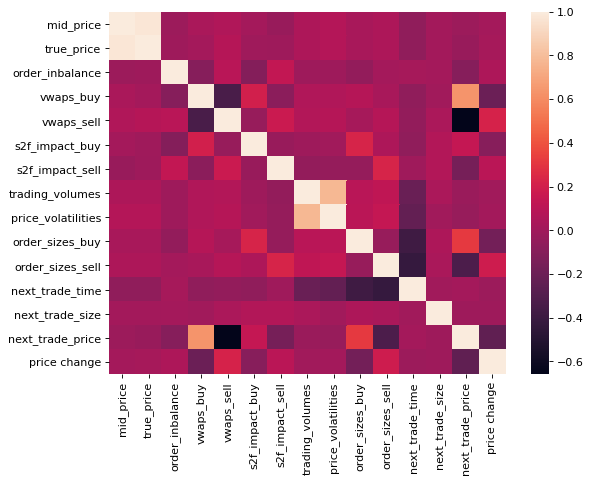

In [33]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

# models

In [34]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix



In [35]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [36]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
  #  rolled_records = np.roll(records, past, axis = 1)
   # rolled_records = rolled_records[:,past:]
    rolled_records=records[:,:-past] # does the same as above 
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            count_elem = 0.0
            sum_elem = 0.0
            # loop for changing nans to zeros, np.sum(arr) returns nan if nan is in the arr
            for elem in records[day][buck:buck+past]:
                if not math.isnan(elem):
                    sum_elem+=elem
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [37]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [38]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=1e-3):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            true_price=true_prices[i,j]
            if true_price==0:
                true_price=prev_true_price
                print("true price at index {},{} was zero!".format(i,j))
            else:
                prev_true_price=true_prices[i,j]
            if (max_val-true_price)/true_price>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=1e-3):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            true_price=true_prices[i,j]
            if true_price==0:
                true_price=prev_true_price
                print("true price at index {},{} was zero!".format(i,j))
            else:
                prev_true_price=true_prices[i,j]
            if (min_val-true_price)/true_price<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [39]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                    flat_out=True,
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    if flat_out:
        X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)), dtype=np.float32)
    else:
        X = np.empty(shape=(10, len(names), -time_back+((510-time_to_skip)//interval)))

    #average_smoothing reduces shape "time_back" times per day
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]  
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        if flat_out:
            X[:,index]=np.asarray(average_smoothing(arr, time_back).flatten(), dtype=np.float32)
        else:
            pass
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
      #  y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = np.asarray(y[:,time_back:].flatten(), dtype=np.float32)
    return y

In [40]:
type(get_y()[0])

numpy.float32

In [41]:
np.unique(get_y())

array([-30.693243, -24.889122,  -8.999589, ...,  41.6205  ,  47.011253,
        64.156715], dtype=float32)

In [42]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')   
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]            
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [43]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [44]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [45]:
np.exp(1)

2.718281828459045

In [46]:
def logistic_regr(X, y, split_percent, comp_id, epsilon=2.7e-6, 
                               use_scaling=True, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False,
                               param_dict_logreg=param_dict_logreg):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=20 ,solver='sag', tol=1/np.exp(1))).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=20).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    conf_mat=my_confusion_matrix(y[split:], y_predicted, labels=[1,0])
    print(conf_mat)
    precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
    recall=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0])
    return clf.score(X[split:], y[split:]), precision, recall

In [47]:
def decision_tree(X, y, split_percent, comp_id, epsilon=2.7e-6,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("decision tree score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [48]:
def xgb_model(X, y, split_percent, comp_id, epsilon=2.7e-6,
                               use_scaling=False, 
                               check_up_down=False, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    neg_class_count = np.sum(y[:split]==0)
    pos_class_count = np.sum(y[:split]==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), 
                          xgb.XGBClassifier(max_depth=5, scale_pos_weight=neg_class_count/pos_class_count)).fit(X[:split], y[:split])
    else:
        clf = xgb.XGBClassifier().fit(X[:split], y[:split])
    y_predicted=clf.predict(X[split:])

    print("Percent of correct classification:")
    print(np.sum(y_predicted ==  y[split:])/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix( y[split:], y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique( y[split:]).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X[split:], y[split:]), precision, recall
    else:
        return clf.score(X[split:], y[split:]), math.nan, math.nan

In [49]:
def permutate_Xy(X, y):
    assert(len(X.shape)==2)
    s1, s2=X.shape
    assert(y.size==s1)
    Xy=np.empty(shape=(s1,s2+1))
    Xy[:,:s2]=X
    Xy[:,s2]=y
    Xy=np.random.permutation(Xy)
    return Xy[:,:s2], Xy[:,s2]

In [50]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [51]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=2.7e-6

In [52]:
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]

In [53]:
print(average_comp_price[comp_id])
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
print("decision_tree")
print("score: ",decision_tree(X, np.copy(y),split_percent, comp_id, epsilon, use_scaling=True, local_names=names))
print("log reg")
print("score: ",logistic_regr(X, np.copy(y),split_percent, comp_id,epsilon, use_scaling=True, local_names=names))

#print("xgb")
#print("score: ",xgb_model(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))


851.5752484506002
30.520833333333332% of intervals were SELL empty
17.34375% of intervals were BUY empty
1.09375% of intervals were set not filled
decision_tree
Coefficient impact:
true_price   0.10259526721799012
order_inbalance   0.11271474396566003
vwaps_buy   0.07505006322924618
vwaps_sell   0.0611060065236029
s2f_impact_buy   0.0430213877233908
s2f_impact_sell   0.08307682308234308
trading_volumes   0.06411928942825765
price_volatilities   0.0037721194907606318
vwaps_order_sizes_buy   0.034953411227395086
vwaps_order_sizes_sell   0.04169716887834286
s2f_order_sizes_buy   0.015545229462589493
s2f_order_sizes_sell   0.0166522823121882
next_trade_time   0.12388397679446168
next_trade_size   0.13881071139745438
next_trade_price   0.08300151926631687
score:  0.4789473684210526
log reg
Coefficient impact:
true_price   -0.09129934
order_inbalance   -0.053272277
vwaps_buy   0.16536053
vwaps_sell   0.024374481
s2f_impact_buy   -0.0651064
s2f_impact_sell   0.6067885
trading_volumes   0.3559

In [ ]:
log_scale=[]
log=[]
tree_scale=[]
tree=[]
for i in range(100):
    tree_scale.append(decision_tree(X, np.copy(y),split_percent, comp_id, epsilon, use_scaling=True, local_names=names))
    log_scale.append(logistic_regr(X, np.copy(y),split_percent, comp_id,epsilon, use_scaling=True, local_names=names))
    tree.append(decision_tree(X, np.copy(y),split_percent, comp_id, epsilon, use_scaling=False, local_names=names))
    log.append(logistic_regr(X, np.copy(y),split_percent, comp_id,epsilon, use_scaling=False, local_names=names))

In [ ]:
print("log_scale: ", np.sum(log_scale)/100)
print("log: ", np.sum(log)/100)
print("tree_scale: ", np.sum(tree_scale)/100)
print("tree: ", np.sum(tree)/100)

# find best epsilon

In [ ]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.concatenate((np.array([0]),np.logspace(-8, -3, num=6)))
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [ ]:
epsilons

In [ ]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
    print(np.unique(y))
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=logistic_regr(X, np.copy(y),split_percent, comp_id, epsilons[eps], True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

In [ ]:
np.unique(get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change'))

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.xticks(np.arange(len(epsilons)), epsilons, rotation='0')

plt.grid()

plt.plot(np.sum(comp_eps, axis=0)/9)

## take a look around 1e-6

In [ ]:
epsilons=np.arange(start=2e-6,stop=4e-6, step=1e-7)
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [ ]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='change')
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=logistic_regr(X, np.copy(y),split_percent, comp_id,epsilons[eps], True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

In [ ]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
#plt.xticks(np.arange(len(epsilons)), epsilons, rotation='90')

plt.grid()
print("best epsilon: ", epsilons[np.argmax(np.sum(comp_eps, axis=0))])
plt.plot(epsilons, np.sum(comp_eps, axis=0)/9)


In [ ]:
2.7e-6

# try with different features

In [ ]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=2.7e-6
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

In [ ]:
comps=np.arange(len(list_of_companies_number)//10)
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back , y_name='true_price', check='change')
    scores[c,0]=logistic_regr(X, np.copy(y),split_percent,  comps[c], epsilon, True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=logistic_regr(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               comps[c], epsilon, True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


In [ ]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
#plt.legend(comps)
 ### LOG REg

In [ ]:
comps=np.arange(len(list_of_companies_number))
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='change')
    scores[c,0]=decision_tree(X, np.copy(y),split_percent, epsilon, comps[c], True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=decision_tree(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               epsilon, comps[c], True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


In [ ]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
 ### DRZEWO

# find threshold for price swing

In [122]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=1
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
thresholds=np.logspace(-8, -3, num=6)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds),3))

In [77]:
thresholds

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])

In [111]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X_hold=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        X,y=permutate_Xy(X_hold,y)
        print(y.shape)
        comp_ths[comp_id,th,0],comp_ths[comp_id,th,1],comp_ths[comp_id,th,2]=logistic_regr(X, y,split_percent, comp_id=comp_id, check_up_down=False, track_params=False, local_names=names)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
30.9375% of intervals were SELL empty
17.5% of intervals were BUY empty
0.3645833333333333% of intervals were set not filled
threshold  1e-08
(950, 15)
(950,)
Coefficient impact:
true_price   0.2780087637843258
order_inbalance   -0.27146339701863953
vwaps_buy   -0.296172645494598
vwaps_sell   0.2597394410322689
s2f_impact_buy   -0.32259889559327315
s2f_impact_sell   0.18760905493973865
trading_volumes   -2.2197721113891045
price_volatilities   0.132051756763103
vwaps_order_sizes_buy   -0.1780297037943057
vwaps_order_sizes_sell   0.13676377282699326
s2f_order_sizes_buy   -0.1780297037943057
s2f_order_sizes_sell   0.13676377282699326
next_trade_time   0.423507392391907
next_trade_size   0.29064869754501976
next_trade_price   -0.5368734530645102
[[166  24]
 [  0   0]]
threshold  1e-07
(950, 15)
(950,)
Coefficient impact:
true_price   -0.21584405695037137
order_inbalance   -0.02340536883888933
vwaps_buy   -0.08727009469612748
vwaps_sell   0.06981796258886191
s2f_impact_buy   -0.328632455

threshold  1e-08
(950, 15)
(950,)
Coefficient impact:
true_price   0.3162106651003648
order_inbalance   0.43445262804609847
vwaps_buy   -0.12792612151906757
vwaps_sell   1.2947231521512166
s2f_impact_buy   0.4697149851916185
s2f_impact_sell   -0.2688794115376568
trading_volumes   -2.0759512247136023
price_volatilities   -0.39961987756806117
vwaps_order_sizes_buy   -0.28697365720073637
vwaps_order_sizes_sell   0.06086299148585663
s2f_order_sizes_buy   -0.28697365720073637
s2f_order_sizes_sell   0.06086299148585663
next_trade_time   0.6853275626569935
next_trade_size   0.15702416713081524
next_trade_price   -0.6891141720450125
[[163  27]
 [  0   0]]
threshold  1e-07
(950, 15)
(950,)
Coefficient impact:
true_price   0.36264788822958777
order_inbalance   -0.051604228901678074
vwaps_buy   0.016134476464077955
vwaps_sell   0.957812659824956
s2f_impact_buy   0.5763096006430996
s2f_impact_sell   -0.15087532636013046
trading_volumes   -1.8562044235575448
price_volatilities   -0.3571477658307969

true price at index 9,95 was zero!
(950,)
Coefficient impact:
true_price   -0.10309084084167773
order_inbalance   0.835430062780854
vwaps_buy   -0.5081434834278874
vwaps_sell   -0.3757758351069785
s2f_impact_buy   0.041370032321164825
s2f_impact_sell   -0.336013874623527
trading_volumes   -0.9581085954940802
price_volatilities   0.036395508547375104
vwaps_order_sizes_buy   0.2717066739562531
vwaps_order_sizes_sell   -0.46720927319192956
s2f_order_sizes_buy   0.2717066739562531
s2f_order_sizes_sell   -0.46720927319192956
next_trade_time   0.3362461955378122
next_trade_size   0.14606979654752755
next_trade_price   -0.19348567260116886
[[163  27]
 [  0   0]]
threshold  1e-05
(950, 15)
true price at index 9,95 was zero!
(950,)
Coefficient impact:
true_price   0.06599300631347496
order_inbalance   1.0319507398445968
vwaps_buy   -0.508475702987635
vwaps_sell   -0.4487613815142162
s2f_impact_buy   -0.2852185247627065
s2f_impact_sell   -0.5567757175446557
trading_volumes   -1.4790666213706036


(950,)
Coefficient impact:
true_price   -0.5109386485662161
order_inbalance   0.34729372195273767
vwaps_buy   -0.7811156246015127
vwaps_sell   0.43810144168783705
s2f_impact_buy   0.48959354393904214
s2f_impact_sell   -0.6878102759924426
trading_volumes   -0.9291355542189644
price_volatilities   -0.4466241697405184
vwaps_order_sizes_buy   -0.6031814637485751
vwaps_order_sizes_sell   0.4814741450711897
s2f_order_sizes_buy   -0.6031814637485751
s2f_order_sizes_sell   0.4814741450711897
next_trade_time   0.11911114216327548
next_trade_size   0.43830150655972433
next_trade_price   -0.7856967487084076
[[101  57]
 [ 18  14]]
7
21.71875% of intervals were SELL empty
21.40625% of intervals were BUY empty
2.4479166666666665% of intervals were set not filled
threshold  1e-08
(950, 15)
(950,)
Coefficient impact:
true_price   -0.20428497439504487
order_inbalance   0.058061760327793796
vwaps_buy   0.15031307263464438
vwaps_sell   0.0935102092223868
s2f_impact_buy   -0.9171904999123317
s2f_impact_se

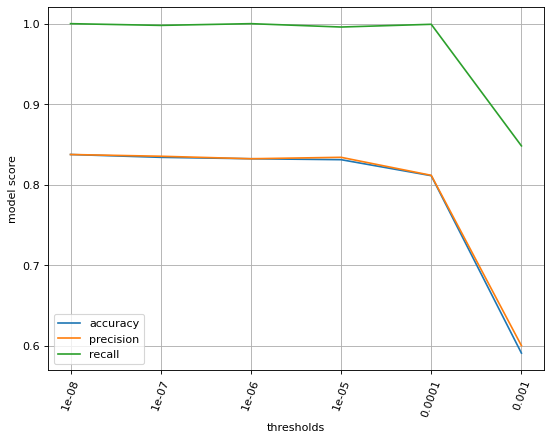

In [112]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
plt.xticks(np.arange(len(thresholds)), thresholds, rotation='70')
plt.grid()
for i in range(3):
    plt.plot(np.sum(comp_ths, axis=0)[:,i]/9)
plt.legend(['accuracy', 'precision', 'recall'])

In [123]:
thresholds=np.arange(8*1e-4, 3*1e-3, step=1e-4)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds),3))

In [107]:
thresholds

array([0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029])

In [124]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X_hold=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        X,y=permutate_Xy(X_hold,y)
        print(y.shape)
        comp_ths[comp_id,th,0],comp_ths[comp_id,th,1],comp_ths[comp_id,th,2]=logistic_regr(X, y,split_percent, 
                                                                                           comp_id=comp_id, check_up_down=False, track_params=False, local_names=names)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
threshold  0.0008
(950, 15)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -0.7450623686495217
order_inbalance   -1.3607189785375295
vwaps_buy   -0.5716708090443763
vwaps_sell   0.5014760502473385
s2f_impact_buy   -0.31722439030047755
s2f_impact_sell   -0.037295495937971046
trading_volumes   -0.2187053850019229
price_volatilities   0.13997881158504982
vwaps_order_sizes_buy   -0.39557342689040453
vwaps_order_sizes_sell   0.05465763696234419
s2f_order_sizes_buy   -0.39557342689040453
s2f_order_sizes_sell   0.05465763696234419
next_trade_time   -1.5196344612640982
next_trade_size   1.5882149058865143
next_trade_price   2.3960489346073657
[[711 246]
 [  1   0]]
threshold  0.0009000000000000001
(4790, 15)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -0.599533292157828
order_inbalance   -1.582

price_volatilities   -0.039963439676139315
vwaps_order_sizes_buy   -0.8420935407953614
vwaps_order_sizes_sell   0.12728851029999608
s2f_order_sizes_buy   -0.8420935407953614
s2f_order_sizes_sell   0.12728851029999608
next_trade_time   -0.5942042431156713
next_trade_size   0.4844585247954563
next_trade_price   1.4914953175051817
[[366 353]
 [ 76 163]]
threshold  0.0020000000000000005
(4790, 15)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -0.36065153106814546
order_inbalance   -1.4028692608133468
vwaps_buy   1.035411684072242
vwaps_sell   0.9150394182477369
s2f_impact_buy   0.049645090860379326
s2f_impact_sell   0.2531387416647945
trading_volumes   0.03202703298588082
price_volatilities   0.2026523254889008
vwaps_order_sizes_buy   -0.6641560819611112
vwaps_order_sizes_sell   0.3243455831139494
s2f_order_sizes_buy   -0.6641560819611112
s2f_order_sizes_sell   0.3243455831139494
next_trade_time   -1.3727380666244295
next_trade_size   0.46730479359111227
next

(4790,)
Coefficient impact:
true_price   -2.677966306997005
order_inbalance   0.32189501710735857
vwaps_buy   -0.1479092131319748
vwaps_sell   0.3907946673956997
s2f_impact_buy   0.2167974858882962
s2f_impact_sell   0.17930034646355786
trading_volumes   -0.19089128091834195
price_volatilities   -0.39511324594707187
vwaps_order_sizes_buy   -0.11912905632577209
vwaps_order_sizes_sell   -0.8949229369337034
s2f_order_sizes_buy   -0.11912905632577209
s2f_order_sizes_sell   -0.8949229369337034
next_trade_time   0.07536618740129544
next_trade_size   0.24575630970017706
next_trade_price   0.5565544056251831
[[688 270]
 [  0   0]]
threshold  0.001
(4790, 15)
(4790,)
Coefficient impact:
true_price   -2.575634631877796
order_inbalance   0.2545134477616589
vwaps_buy   -0.4138980213743873
vwaps_sell   0.5391649855988969
s2f_impact_buy   0.47053402937396166
s2f_impact_sell   0.518539320141289
trading_volumes   -0.1664967691782955
price_volatilities   -0.11825286665458731
vwaps_order_sizes_buy   0.22

(4790,)
Coefficient impact:
true_price   -3.461290985364446
order_inbalance   0.5439502555032103
vwaps_buy   -0.2646358156375027
vwaps_sell   0.6847451541287428
s2f_impact_buy   0.010924331824303005
s2f_impact_sell   0.181423351544646
trading_volumes   -0.24716633630473286
price_volatilities   -0.04645911786174455
vwaps_order_sizes_buy   -0.09257134400080988
vwaps_order_sizes_sell   -0.1921719212749488
s2f_order_sizes_buy   -0.09257134400080988
s2f_order_sizes_sell   -0.1921719212749488
next_trade_time   0.22851458381873774
next_trade_size   0.18903671365793226
next_trade_price   -0.17027721091365083
[[  0   0]
 [484 474]]
threshold  0.002300000000000001
(4790, 15)


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   -3.0787597307597108
order_inbalance   0.512836911585918
vwaps_buy   0.4252775429357579
vwaps_sell   0.542043378308986
s2f_impact_buy   0.3744471640476793
s2f_impact_sell   0.06422119115867207
trading_volumes   -0.36202051593100837
price_volatilities   -0.09010899062275542
vwaps_order_sizes_buy   -0.6872901038490048
vwaps_order_sizes_sell   -0.41027128396428025
s2f_order_sizes_buy   -0.6872901038490048
s2f_order_sizes_sell   -0.41027128396428025
next_trade_time   0.33520329238013885
next_trade_size   0.4318896409541385
next_trade_price   -0.3899047206281311
[[170 139]
 [300 349]]
threshold  0.0024000000000000007
(4790, 15)
(4790,)
Coefficient impact:
true_price   -2.351861191102206
order_inbalance   0.042432092744319326
vwaps_buy   -0.3685889114029835
vwaps_sell   0.8281535879693084
s2f_impact_buy   -0.04634256089025749
s2f_impact_sell   -0.7136373261557456
trading_volumes   0.6270443350311626
price_volatilities   -0.10399203132918436
vwaps_order

(4790,)
Coefficient impact:
true_price   0.1945052973701764
order_inbalance   -0.2253643010265986
vwaps_buy   -0.5782874075984613
vwaps_sell   0.30612933787472124
s2f_impact_buy   0.13174576944725072
s2f_impact_sell   -0.6773144497672438
trading_volumes   -0.5998750461835041
price_volatilities   0.045248413774562485
vwaps_order_sizes_buy   -0.345978124299603
vwaps_order_sizes_sell   -0.10904983204177669
s2f_order_sizes_buy   -0.345978124299603
s2f_order_sizes_sell   -0.10904983204177669
next_trade_time   -1.0857597325050878
next_trade_size   0.7785998921560762
next_trade_price   -0.1832972576918377
[[453 350]
 [ 82  73]]
threshold  0.0015000000000000005
(4790, 15)
(4790,)
Coefficient impact:
true_price   0.1364601386815834
order_inbalance   -0.07950873908103194
vwaps_buy   -0.39430000873209475
vwaps_sell   0.633244583637531
s2f_impact_buy   0.12337004179776562
s2f_impact_sell   -0.9386838032027874
trading_volumes   -0.36606774614349985
price_volatilities   -0.017406108247251098
vwaps_o

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   0.6751486007361994
order_inbalance   -0.3962335389396622
vwaps_buy   0.11902748059370465
vwaps_sell   0.5282849630887486
s2f_impact_buy   0.2929554384319144
s2f_impact_sell   -0.6520779411063572
trading_volumes   -0.6323290914702466
price_volatilities   0.00896148635922706
vwaps_order_sizes_buy   -0.502316723827789
vwaps_order_sizes_sell   -0.031076588031897057
s2f_order_sizes_buy   -0.502316723827789
s2f_order_sizes_sell   -0.031076588031897057
next_trade_time   -0.13545672523732408
next_trade_size   -0.1662336956196503
next_trade_price   -0.29626563591584454
[[  0   0]
 [380 578]]
threshold  0.002300000000000001
(4790, 15)


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   1.1485495988366325
order_inbalance   -0.3512794945189619
vwaps_buy   -0.05004343120388532
vwaps_sell   0.7919372010331708
s2f_impact_buy   0.45569420787716836
s2f_impact_sell   -0.6115107060888789
trading_volumes   -0.6446221745208679
price_volatilities   -0.05572611612249293
vwaps_order_sizes_buy   0.006871692326370809
vwaps_order_sizes_sell   0.18795430959711573
s2f_order_sizes_buy   0.006871692326370809
s2f_order_sizes_sell   0.18795430959711573
next_trade_time   -0.26700969392178475
next_trade_size   -0.6099836767947295
next_trade_price   -0.3328385523168503
[[  7   6]
 [347 598]]
threshold  0.0024000000000000007
(4790, 15)
(4790,)
Coefficient impact:
true_price   0.9528687544631099
order_inbalance   -0.1807520052822099
vwaps_buy   -0.17929551891867232
vwaps_sell   -0.06528017449868564
s2f_impact_buy   0.45117194441783803
s2f_impact_sell   -0.43323104738926266
trading_volumes   -0.3472053131131582
price_volatilities   0.10449390358663162
vwa

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   0.3894195819062411
order_inbalance   -0.39776329089009443
vwaps_buy   -0.36711945467473683
vwaps_sell   0.18496577486638544
s2f_impact_buy   0.5134817591930095
s2f_impact_sell   -0.47201952255128243
trading_volumes   -0.9211918347755187
price_volatilities   -0.03555457957488948
vwaps_order_sizes_buy   -0.13703536322678303
vwaps_order_sizes_sell   -0.20315380501064523
s2f_order_sizes_buy   -0.13703536322678303
s2f_order_sizes_sell   -0.20315380501064523
next_trade_time   -0.47981236736144456
next_trade_size   -0.11795264122226012
next_trade_price   -0.5689959378135967
[[  0   0]
 [343 615]]
threshold  0.002700000000000001
(4790, 15)


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   0.501666743809671
order_inbalance   -0.4636332728030899
vwaps_buy   0.2474773233402845
vwaps_sell   0.621293226360789
s2f_impact_buy   0.05751088413043518
s2f_impact_sell   -0.5577039773534338
trading_volumes   -1.4097750193288605
price_volatilities   0.1884107972402502
vwaps_order_sizes_buy   0.1611535536171323
vwaps_order_sizes_sell   -0.08727242433301642
s2f_order_sizes_buy   0.1611535536171323
s2f_order_sizes_sell   -0.08727242433301642
next_trade_time   -0.442260823403402
next_trade_size   -0.8540738919480212
next_trade_price   -0.5069432279883683
[[  0   0]
 [309 649]]
threshold  0.002800000000000001
(4790, 15)


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   0.6925984086203384
order_inbalance   -0.6436222426695962
vwaps_buy   -0.4572753866775251
vwaps_sell   0.5257524015586872
s2f_impact_buy   0.3272492513462474
s2f_impact_sell   -0.4490282984482926
trading_volumes   -0.5043002952402561
price_volatilities   0.07785829004467237
vwaps_order_sizes_buy   0.16965684293114047
vwaps_order_sizes_sell   0.10712505601264673
s2f_order_sizes_buy   0.16965684293114047
s2f_order_sizes_sell   0.10712505601264673
next_trade_time   -0.3028611020444908
next_trade_size   -0.7116039442084192
next_trade_price   -0.542570223185501
[[  0   0]
 [292 666]]
threshold  0.002900000000000001
(4790, 15)


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   0.3757724336886775
order_inbalance   -0.651285051597884
vwaps_buy   -0.06952111054639344
vwaps_sell   0.32811919573492315
s2f_impact_buy   0.23031130577838027
s2f_impact_sell   -0.31915248968465826
trading_volumes   -0.5275668282182251
price_volatilities   0.17269179572488824
vwaps_order_sizes_buy   -0.04283142162462872
vwaps_order_sizes_sell   -0.08046266514372451
s2f_order_sizes_buy   -0.04283142162462872
s2f_order_sizes_sell   -0.08046266514372451
next_trade_time   -0.004461218866599081
next_trade_size   -0.505267042277132
next_trade_price   -0.5296418066465255
[[  0   0]
 [286 672]]
3


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
threshold  0.0008
(4790, 15)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -0.3041341004196979
order_inbalance   0.5320161033864785
vwaps_buy   -0.39617635570163345
vwaps_sell   0.5262143858213963
s2f_impact_buy   -0.19286491236122677
s2f_impact_sell   -0.32522791608523816
trading_volumes   0.760432600867455
price_volatilities   -0.1265566843419808
vwaps_order_sizes_buy   0.45355901547803257
vwaps_order_sizes_sell   0.2847385054600269
s2f_order_sizes_buy   0.45355901547803257
s2f_order_sizes_sell   0.2847385054600269
next_trade_time   -0.17814629682693636
next_trade_size   0.7385104229343974
next_trade_price   -0.3948671183703184
[[663 294]
 [  0   1]]
threshold  0.0009000000000000001
(4790, 15)
true price at index 9,477 was zero!
true price at in

true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -0.23571979082530692
order_inbalance   0.6916854679024556
vwaps_buy   -0.39224471180027454
vwaps_sell   -0.0708784685583488
s2f_impact_buy   0.20694322346391142
s2f_impact_sell   -0.2968879888163099
trading_volumes   -0.2477694998958969
price_volatilities   -0.10565094690776536
vwaps_order_sizes_buy   0.4646894455488443
vwaps_order_sizes_sell   0.3385481194055549
s2f_order_sizes_buy   0.4646894455488443
s2f_order_sizes_sell   0.3385481194055549
next_trade_time   -0.5713460250767691
next_trade_size   1.0093429733021155
next_trade_price   -0.37809896172513924
[[ 39  44]
 [385 490]]
threshold  0.0020000000000000005
(4790, 15)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -0.13202837144297283
order_inbalance   0.5930586847898733
vwaps_buy   -

31.489583333333332% of intervals were SELL empty
31.541666666666668% of intervals were BUY empty
0.09375% of intervals were set not filled
threshold  0.0008
(4790, 15)
true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -1.135952740457755
order_inbalance   2.144397507326199
vwaps_buy   -1.4555271605303226
vwaps_sell   -0.7032991521087699
s2f_impact_buy   0.12481160694624475
s2f_impact_sell   -0.5497621615126221
trading_volumes   0.5353698973390594
price_volatilities   0.4682114924930001
vwaps_order_sizes_buy   1.2765397452870815
vwaps_order_sizes_sell   -0.4724761092337637
s2f_order_sizes_buy   1.2765397452870815
s2f_order_sizes_sell   -0.4724761092337637
next_trade_time   -0.28066971376342353
next_trade_size   0.3509886809796335
next_trade_price   -1.3619752472339361
[[533 173]
 [168  84]]
threshold  0.0009000000000000

true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -2.050173673178253
order_inbalance   2.24031763234932
vwaps_buy   -1.359928639591024
vwaps_sell   -0.2429046267748484
s2f_impact_buy   1.6386372721212328
s2f_impact_sell   -0.6192921638280932
trading_volumes   1.4653352223538083
price_volatilities   -0.11255106289999166
vwaps_order_sizes_buy   0.776517434487894
vwaps_order_sizes_sell   0.35072537678023064
s2f_order_sizes_buy   0.776517434487894
s2f_order_sizes_sell   0.35072537678023064
next_trade_time   -0.8537868087133729
next_trade_size   -0.2511290714852532
next_trade_price   -1.2932245554237725
[[379 377]
 [ 78 124]]
threshold  0.0019000000000000006
(4790, 15)
true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price a

true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -2.2313429285008106
order_inbalance   1.3501517808131038
vwaps_buy   -0.8479285042089981
vwaps_sell   0.3938297704987423
s2f_impact_buy   1.139285750879157
s2f_impact_sell   -0.10434850739484045
trading_volumes   1.7508232495753753
price_volatilities   0.22223906271390478
vwaps_order_sizes_buy   0.2396932869560699
vwaps_order_sizes_sell   0.480028340154681
s2f_order_sizes_buy   0.2396932869560699
s2f_order_sizes_sell   0.480028340154681
next_trade_time   -0.5678525057295549
next_trade_size   -0.1062017976450272
next_trade_price   -0.8282939133383537
[[ 43  33]
 [303 579]]
threshold  0.002900000000000001
(4790, 15)
true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at

(4790,)
Coefficient impact:
true_price   -2.360224000363979
order_inbalance   -0.8745567859468769
vwaps_buy   -0.28408836192144876
vwaps_sell   0.4537633353163125
s2f_impact_buy   0.6796881526295391
s2f_impact_sell   0.6805084784984017
trading_volumes   0.07471084338374068
price_volatilities   -0.19418102315287977
vwaps_order_sizes_buy   0.19837481716088912
vwaps_order_sizes_sell   0.30911339950841993
s2f_order_sizes_buy   0.19837481716088912
s2f_order_sizes_sell   0.30911339950841993
next_trade_time   -0.06206038420270072
next_trade_size   0.40956078183991645
next_trade_price   -0.7369625870943058
[[316 285]
 [169 188]]
threshold  0.0019000000000000006
(4790, 15)
(4790,)
Coefficient impact:
true_price   -1.9472770555607224
order_inbalance   -0.13217321531923829
vwaps_buy   -0.1568028071746754
vwaps_sell   -0.21215709571110292
s2f_impact_buy   0.43406258951308535
s2f_impact_sell   -0.018006606091843406
trading_volumes   0.21843144311824103
price_volatilities   0.0664157980684386
vwaps_

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   -3.0123581403978053
order_inbalance   0.24621549141161111
vwaps_buy   0.618383260502472
vwaps_sell   -0.6830391585387401
s2f_impact_buy   0.7873544242289265
s2f_impact_sell   0.2885021958988303
trading_volumes   0.40456101155987834
price_volatilities   -0.3159532369224102
vwaps_order_sizes_buy   0.31656613246024473
vwaps_order_sizes_sell   0.1890578363190389
s2f_order_sizes_buy   0.31656613246024473
s2f_order_sizes_sell   0.1890578363190389
next_trade_time   -0.19104081631929232
next_trade_size   0.4420323571830607
next_trade_price   0.07429778835147935
[[ 34  46]
 [344 534]]
threshold  0.002700000000000001
(4790, 15)
(4790,)
Coefficient impact:
true_price   -3.1975581177625525
order_inbalance   0.25305768331027895
vwaps_buy   0.9699572189593754
vwaps_sell   -1.0238803850214373
s2f_impact_buy   0.4915570524010754
s2f_impact_sell   0.035843797252225584
trading_volumes   0.5514906188590519
price_volatilities   -0.17508205536441707
vwaps_order_size

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   -3.383025247381694
order_inbalance   0.7096159957314349
vwaps_buy   0.580075948670511
vwaps_sell   -1.105384639692461
s2f_impact_buy   1.4131699229576185
s2f_impact_sell   -0.08168449693813506
trading_volumes   0.020598091325792833
price_volatilities   0.12101692890326772
vwaps_order_sizes_buy   -0.09852683359499131
vwaps_order_sizes_sell   0.29806369645741465
s2f_order_sizes_buy   -0.09852683359499131
s2f_order_sizes_sell   0.29806369645741465
next_trade_time   0.24658780655697227
next_trade_size   0.20518185807318226
next_trade_price   0.7771004259814285
[[  2   1]
 [324 631]]
6
35.71875% of intervals were SELL empty
35.46875% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
threshold  0.0008
(4790, 15)
(4790,)
Coefficient impact:
true_price   -2.4508951565388366
order_inbalance   0.5885824217421202
vwaps_buy   -1.207310764745793
vwaps_sell   1.6165738577001973
s2f_impact_buy   -0.092166921730119
s2f_impact_se

threshold  0.0020000000000000005
(4790, 15)
(4790,)
Coefficient impact:
true_price   -2.25822379962319
order_inbalance   0.1610574228491474
vwaps_buy   -0.2507004220618564
vwaps_sell   1.1881062306113934
s2f_impact_buy   0.3606824213498934
s2f_impact_sell   0.029163124046390924
trading_volumes   -0.7850618574240469
price_volatilities   0.30564505978329914
vwaps_order_sizes_buy   -0.7138756222102073
vwaps_order_sizes_sell   -0.7975467247294667
s2f_order_sizes_buy   -0.7138756222102073
s2f_order_sizes_sell   -0.7975467247294667
next_trade_time   0.5022625318412052
next_trade_size   -0.916279079788877
next_trade_price   1.5417341385170664
[[459 457]
 [ 11  31]]
threshold  0.0021000000000000007
(4790, 15)
(4790,)
Coefficient impact:
true_price   -3.0144141772482853
order_inbalance   0.28186871464817237
vwaps_buy   -0.7518654197583574
vwaps_sell   2.247287900494378
s2f_impact_buy   0.4405767937210645
s2f_impact_sell   0.011078119647705244
trading_volumes   -0.816814137006117
price_volatilit

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   -3.2030733282227852
order_inbalance   -0.030456838894844167
vwaps_buy   0.07918083300880017
vwaps_sell   1.105890775534012
s2f_impact_buy   0.5773994870005313
s2f_impact_sell   -0.4987470711130126
trading_volumes   -1.08972299162813
price_volatilities   -0.17723956041721728
vwaps_order_sizes_buy   -0.7560781225932484
vwaps_order_sizes_sell   -0.376898905421743
s2f_order_sizes_buy   -0.7560781225932484
s2f_order_sizes_sell   -0.376898905421743
next_trade_time   0.04056653550556542
next_trade_size   -0.6699397992394751
next_trade_price   1.3897397532639497
[[  0   0]
 [388 570]]
threshold  0.0026000000000000007
(4790, 15)


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   -1.9396709006216535
order_inbalance   0.2879555410463329
vwaps_buy   -0.5205314537077196
vwaps_sell   0.44180552406482737
s2f_impact_buy   -0.31137826339460944
s2f_impact_sell   -0.7746357014472677
trading_volumes   -0.8150235800664524
price_volatilities   -0.5534811364533401
vwaps_order_sizes_buy   -0.34806003975947086
vwaps_order_sizes_sell   -0.33707319756804355
s2f_order_sizes_buy   -0.34806003975947086
s2f_order_sizes_sell   -0.33707319756804355
next_trade_time   -0.36813281191648156
next_trade_size   -0.2002006251636929
next_trade_price   1.3971688377025324
[[164 230]
 [204 360]]
threshold  0.002700000000000001
(4790, 15)
(4790,)
Coefficient impact:
true_price   -2.9551733765158126
order_inbalance   -0.42585940633997954
vwaps_buy   0.27501467351970926
vwaps_sell   0.6698446363765083
s2f_impact_buy   -0.37529423532441264
s2f_impact_sell   -0.15054450453468105
trading_volumes   -0.8891690158081776
price_volatilities   -0.0495644911814979
vwa

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


23.697916666666668% of intervals were SELL empty
24.3125% of intervals were BUY empty
0.16666666666666666% of intervals were set not filled
threshold  0.0008
(4790, 15)
(4790,)
Coefficient impact:
true_price   -1.3030947339008252
order_inbalance   -0.5796636995803128
vwaps_buy   0.800218163972483
vwaps_sell   0.42000519336100195
s2f_impact_buy   0.6139359773828469
s2f_impact_sell   1.015752969426618
trading_volumes   -1.0917662601562867
price_volatilities   0.31414665336382785
vwaps_order_sizes_buy   -1.4890553856587878
vwaps_order_sizes_sell   -0.25020064565457095
s2f_order_sizes_buy   -1.4890553856587878
s2f_order_sizes_sell   -0.25020064565457095
next_trade_time   0.18550877685672976
next_trade_size   0.509007315591378
next_trade_price   0.3391486923047188
[[655 301]
 [  2   0]]
threshold  0.0009000000000000001
(4790, 15)
(4790,)
Coefficient impact:
true_price   -1.4030205662876805
order_inbalance   -0.6918061588004403
vwaps_buy   0.41376318340411206
vwaps_sell   0.07121951597198597

(4790,)
Coefficient impact:
true_price   -2.237857276375336
order_inbalance   -1.4103237784894052
vwaps_buy   0.47573913551565306
vwaps_sell   0.6969132229437446
s2f_impact_buy   1.0334738599312925
s2f_impact_sell   0.7544094710057733
trading_volumes   -0.5922004916624283
price_volatilities   0.013687316835122199
vwaps_order_sizes_buy   -1.0010311291594656
vwaps_order_sizes_sell   -0.5749427425112152
s2f_order_sizes_buy   -1.0010311291594656
s2f_order_sizes_sell   -0.5749427425112152
next_trade_time   0.30687945633881314
next_trade_size   -0.12046403307651372
next_trade_price   -0.3961785075847042
[[  0   0]
 [346 612]]
threshold  0.0022000000000000006
(4790, 15)
(4790,)
Coefficient impact:
true_price   -1.997181953640559
order_inbalance   -1.161642537136016
vwaps_buy   0.012543608679081126
vwaps_sell   0.2765762325309354
s2f_impact_buy   1.0232375329317904
s2f_impact_sell   0.4474030826143311
trading_volumes   -1.2853851445382134
price_volatilities   0.22891938086642102
vwaps_order_si

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   -2.43979886123854
order_inbalance   -1.1396117568933308
vwaps_buy   -0.052064845083284725
vwaps_sell   0.881395873216404
s2f_impact_buy   0.8125261079328042
s2f_impact_sell   0.6407202667614628
trading_volumes   -0.8498310736343613
price_volatilities   0.13602273115578123
vwaps_order_sizes_buy   -0.6362054502032237
vwaps_order_sizes_sell   -0.49239985155195726
s2f_order_sizes_buy   -0.6362054502032237
s2f_order_sizes_sell   -0.49239985155195726
next_trade_time   0.26156618347047883
next_trade_size   0.14486969215465142
next_trade_price   0.34728287652598167
[[  0   0]
 [318 640]]
threshold  0.0024000000000000007
(4790, 15)


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   -2.347022113393498
order_inbalance   -1.144525848924437
vwaps_buy   0.3877557729763008
vwaps_sell   0.5770852268400097
s2f_impact_buy   1.1640906382024416
s2f_impact_sell   0.5916881197021011
trading_volumes   -1.25972799961773
price_volatilities   0.23544527567111814
vwaps_order_sizes_buy   -0.6463248129278484
vwaps_order_sizes_sell   -0.2681313811399544
s2f_order_sizes_buy   -0.6463248129278484
s2f_order_sizes_sell   -0.2681313811399544
next_trade_time   -0.020457952212727445
next_trade_size   -0.14738000701120538
next_trade_price   0.13944160241483972
[[  2   2]
 [325 629]]
threshold  0.002500000000000001
(4790, 15)
(4790,)
Coefficient impact:
true_price   -2.177267501203022
order_inbalance   -0.8525406479073829
vwaps_buy   -0.052605616501697976
vwaps_sell   0.4037896624107879
s2f_impact_buy   1.0876298458897944
s2f_impact_sell   0.5857321797024873
trading_volumes   -1.1344123967955595
price_volatilities   0.1765953058462159
vwaps_order_sizes

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   -2.0084663635474342
order_inbalance   -1.1700518538996307
vwaps_buy   -0.2830037913353456
vwaps_sell   1.3459018489257828
s2f_impact_buy   0.7176078869385927
s2f_impact_sell   0.9087093909014966
trading_volumes   -0.9754091230538383
price_volatilities   0.3281601779702588
vwaps_order_sizes_buy   -0.7494189880335254
vwaps_order_sizes_sell   -0.2089108265987052
s2f_order_sizes_buy   -0.7494189880335254
s2f_order_sizes_sell   -0.2089108265987052
next_trade_time   -0.16769560560923533
next_trade_size   -0.24897987584502734
next_trade_price   0.847957676112304
[[  0   1]
 [264 693]]
8
30.75% of intervals were SELL empty
29.59375% of intervals were BUY empty
0.21875% of intervals were set not filled
threshold  0.0008
(4790, 15)
(4790,)
Coefficient impact:
true_price   -0.8438738897008825
order_inbalance   0.4413385755464523
vwaps_buy   -0.4352752006750698
vwaps_sell   0.6063251596936522
s2f_impact_buy   -0.012274246351925807
s2f_impact_sell   -0.42625

vwaps_buy   0.6436944485138533
vwaps_sell   0.8826908582690112
s2f_impact_buy   0.1342357029455216
s2f_impact_sell   -0.7872229315808938
trading_volumes   -1.0412139420272126
price_volatilities   -0.12367164189058967
vwaps_order_sizes_buy   -0.6612594344419609
vwaps_order_sizes_sell   0.47075778031902615
s2f_order_sizes_buy   -0.6612594344419609
s2f_order_sizes_sell   0.47075778031902615
next_trade_time   -0.09317920250815345
next_trade_size   -1.080075247162193
next_trade_price   0.8258799667876948
[[118 123]
 [302 415]]
threshold  0.0021000000000000007
(4790, 15)
(4790,)
Coefficient impact:
true_price   -2.1169054688199194
order_inbalance   0.8417702173082798
vwaps_buy   -0.008256438369106552
vwaps_sell   0.7053952676884844
s2f_impact_buy   0.6839763372838864
s2f_impact_sell   -0.41680500883788296
trading_volumes   -0.1332019611050133
price_volatilities   -0.13356502174829307
vwaps_order_sizes_buy   -1.191165170930431
vwaps_order_sizes_sell   0.3982404141383917
s2f_order_sizes_buy   

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   -2.318979907636641
order_inbalance   0.7646310583885847
vwaps_buy   -0.2769535230089923
vwaps_sell   1.0069275161694817
s2f_impact_buy   0.3122541363294927
s2f_impact_sell   -0.957607619124604
trading_volumes   -0.6395375617850128
price_volatilities   -0.1961232554585335
vwaps_order_sizes_buy   -1.226812083091918
vwaps_order_sizes_sell   0.5209138611468768
s2f_order_sizes_buy   -1.226812083091918
s2f_order_sizes_sell   0.5209138611468768
next_trade_time   -0.27467019460350833
next_trade_size   -1.1240926315004784
next_trade_price   0.9099967414356205
[[  6   3]
 [350 599]]
threshold  0.0024000000000000007
(4790, 15)
(4790,)
Coefficient impact:
true_price   -2.1795924357631624
order_inbalance   1.447411147787552
vwaps_buy   -1.0649568913428533
vwaps_sell   0.6051244973346783
s2f_impact_buy   0.7512326841229076
s2f_impact_sell   -0.18656687283580767
trading_volumes   -0.18473558741228358
price_volatilities   -0.0887693184633824
vwaps_order_sizes_buy   -1

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



true_price   -2.541085491200578
order_inbalance   0.5512908656241479
vwaps_buy   -0.06029948354940114
vwaps_sell   0.666206128505419
s2f_impact_buy   0.48969745089151023
s2f_impact_sell   -0.4356744344125439
trading_volumes   -0.5189392022757868
price_volatilities   0.011349195295838726
vwaps_order_sizes_buy   -1.1613384933741115
vwaps_order_sizes_sell   0.4413323161870153
s2f_order_sizes_buy   -1.1613384933741115
s2f_order_sizes_sell   0.4413323161870153
next_trade_time   -0.5083980796066377
next_trade_size   -0.9777722715567511
next_trade_price   1.208928621487993
[[  0   0]
 [278 680]]
threshold  0.002900000000000001
(4790, 15)


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4790,)
Coefficient impact:
true_price   -2.3720780553387604
order_inbalance   0.23203768360236346
vwaps_buy   0.4429365301637088
vwaps_sell   1.4194054069720095
s2f_impact_buy   0.44344212246501047
s2f_impact_sell   -0.6015557249621225
trading_volumes   -0.013501164878872698
price_volatilities   0.3998070021282634
vwaps_order_sizes_buy   -1.2256302549938527
vwaps_order_sizes_sell   0.6921681758193393
s2f_order_sizes_buy   -1.2256302549938527
s2f_order_sizes_sell   0.6921681758193393
next_trade_time   -0.2136940525640067
next_trade_size   -0.7224237157916131
next_trade_price   1.2295456989714273
[[  0   0]
 [268 690]]
calculations took: 58.31836295127869 seconds


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


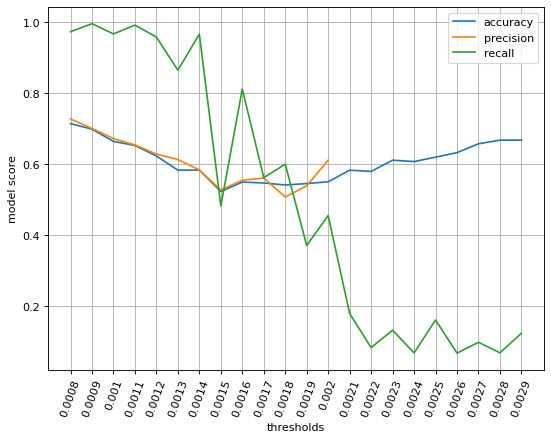

In [125]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
plt.xticks(np.arange(len(thresholds)), np.round(thresholds, decimals=4), rotation='70')
plt.grid()
for i in range(3):
    plt.plot(np.sum(comp_ths, axis=0)[:,i]/9)
plt.legend(['accuracy', 'precision', 'recall'])

# check interval

In [129]:
time_back=1
time_to_skip=30
split_percent = 0.8
threshold = 0.0012
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
intervals=[1,3,5,10,15,30]
comp_ints=np.zeros((len(list_of_companies_number), len(intervals),3))

In [133]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    for i in range(len(intervals)):
        X_hold=get_X(comp_id, intervals[i], time_to_skip, time_back, names) 
        print('interval ', intervals[i])
        print(X.shape)
        y=get_y(comp_id, intervals[i], time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=threshold)
        print(y.shape)
        X,y=permutate_Xy(X_hold,y)
        comp_ints[comp_id,i,0],comp_ints[comp_id,i,1],comp_ints[comp_id,i,2]=logistic_regr(X, y,split_percent, 
                                                                                           comp_id=comp_id, check_up_down=False, track_params=False, local_names=names)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
interval  1
(4790, 15)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -0.9336514913999354
order_inbalance   -2.0877171394332876
vwaps_buy   0.6151908572216229
vwaps_sell   1.4357018843662384
s2f_impact_buy   -0.10133593247945163
s2f_impact_sell   0.49477172387480034
trading_volumes   0.36167818440822425
price_volatilities   0.6521546815358427
vwaps_order_sizes_buy   -0.5462544755237274
vwaps_order_sizes_sell   0.037664425770090416
s2f_order_sizes_buy   -0.5462544755237274
s2f_order_sizes_sell   0.037664425770090416
next_trade_time   -0.9264600650213811
next_trade_size   0.7438986129162031
next_trade_price   3.064073498179754
[[260 142]
 [331 225]]
34.09375% of intervals were SELL empty
22.59375% of intervals were BUY empty
0.15625% of intervals were set not filled
interval  3
(4790, 15)
(1590,)
Coefficient impact:
true

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


26.052083333333332% of intervals were SELL empty
27.729166666666668% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
interval  1
(150, 15)
(4790,)
Coefficient impact:
true_price   -2.541818914508705
order_inbalance   0.22906841288416105
vwaps_buy   0.43660840060492345
vwaps_sell   0.6097357781460505
s2f_impact_buy   0.8508480023828151
s2f_impact_sell   -0.4050320887329333
trading_volumes   -0.13924756491737927
price_volatilities   0.11999987964162605
vwaps_order_sizes_buy   0.16743684883013504
vwaps_order_sizes_sell   -0.43533198263784295
s2f_order_sizes_buy   0.16743684883013504
s2f_order_sizes_sell   -0.43533198263784295
next_trade_time   0.15397629921715492
next_trade_size   0.2860423143678896
next_trade_price   -0.5148466553402197
[[666 292]
 [  0   0]]
24.6875% of intervals were SELL empty
23.21875% of intervals were BUY empty
0.53125% of intervals were set not filled
interval  3
(4790, 15)
(1590,)
Coefficient impact:
true_price   -0.7160681135653

interval  30
(310, 15)
(150,)
Coefficient impact:
true_price   0.16122580265567368
order_inbalance   -0.6087806315836075
vwaps_buy   -0.7790016296527555
vwaps_sell   0.0516346913805872
s2f_impact_buy   1.4961948386709252
s2f_impact_sell   -1.3152577655572815
trading_volumes   0.7021719346934983
price_volatilities   1.5345599035212083
vwaps_order_sizes_buy   0.5240133936738545
vwaps_order_sizes_sell   0.8149530407855529
s2f_order_sizes_buy   0.5240133936738545
s2f_order_sizes_sell   0.8149530407855529
next_trade_time   -0.2992780320041723
next_trade_size   0.7502116408827947
next_trade_price   0.10752077559872283
[[ 2 10]
 [ 6 12]]
3
31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
interval  1
(150, 15)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   0.026042214772333736
order_inbalance   0.8843733

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


31.489583333333332% of intervals were SELL empty
31.541666666666668% of intervals were BUY empty
0.09375% of intervals were set not filled
interval  1
(150, 15)
true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -1.4605550554551163
order_inbalance   1.5393415425403676
vwaps_buy   -1.155164146540593
vwaps_sell   -0.24109018134545251
s2f_impact_buy   1.98568385663424
s2f_impact_sell   -0.9363707179934182
trading_volumes   0.3848045152524917
price_volatilities   0.14625100640481276
vwaps_order_sizes_buy   0.6915729489045058
vwaps_order_sizes_sell   -0.392876794067621
s2f_order_sizes_buy   0.6915729489045058
s2f_order_sizes_sell   -0.392876794067621
next_trade_time   -0.13151234102659023
next_trade_size   0.5643541563148998
next_trade_price   -1.0799557886397677
[[590 367]
 [  0   1]]
25.84375% of intervals were SELL empty

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


17.21875% of intervals were SELL empty
20.8125% of intervals were BUY empty
0.15625% of intervals were set not filled
interval  1
(150, 15)
(4790,)
Coefficient impact:
true_price   -1.8296228562429442
order_inbalance   -0.29245827550368825
vwaps_buy   -0.17712398335479645
vwaps_sell   0.33209098634870476
s2f_impact_buy   0.32100649859067953
s2f_impact_sell   0.18587721913049327
trading_volumes   -0.2867051761961673
price_volatilities   -0.05869070134403071
vwaps_order_sizes_buy   0.3342470242602203
vwaps_order_sizes_sell   0.23411245345226422
s2f_order_sizes_buy   0.3342470242602203
s2f_order_sizes_sell   0.23411245345226422
next_trade_time   -0.29694834682517807
next_trade_size   0.3317789730228026
next_trade_price   -0.4446465853757655
[[635 323]
 [  0   0]]
25.0625% of intervals were SELL empty
20.4375% of intervals were BUY empty
1.25% of intervals were set not filled
interval  3
(4790, 15)
(1590,)
Coefficient impact:
true_price   0.09205064802505333
order_inbalance   -1.4277679898

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


35.71875% of intervals were SELL empty
35.46875% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
interval  1
(150, 15)
(4790,)
Coefficient impact:
true_price   -2.4583509376689556
order_inbalance   0.25229825007520473
vwaps_buy   -0.8401348368473608
vwaps_sell   1.654878495246344
s2f_impact_buy   0.30481475779071965
s2f_impact_sell   -0.15664181757933598
trading_volumes   -1.0336132561925155
price_volatilities   -0.16915286993043474
vwaps_order_sizes_buy   -0.652525936850376
vwaps_order_sizes_sell   -0.45943732491128814
s2f_order_sizes_buy   -0.652525936850376
s2f_order_sizes_sell   -0.45943732491128814
next_trade_time   1.0730899686266435
next_trade_size   -0.5734040204921295
next_trade_price   1.4319756451139307
[[615 334]
 [  2   7]]
33.375% of intervals were SELL empty
24.28125% of intervals were BUY empty
0.125% of intervals were set not filled
interval  3
(4790, 15)
(1590,)
Coefficient impact:
true_price   -1.1010852261251614
order_inbalance   0

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


interval  30
(310, 15)
(150,)
Coefficient impact:
true_price   -0.41855707574566114
order_inbalance   0.5873487796270205
vwaps_buy   -0.4087953846430121
vwaps_sell   0.10957945497172793
s2f_impact_buy   -1.1907342934412826
s2f_impact_sell   0.299702015396124
trading_volumes   -0.270780258169773
price_volatilities   0.13092891177147514
vwaps_order_sizes_buy   0.48050233069133563
vwaps_order_sizes_sell   0.191012748148593
s2f_order_sizes_buy   0.48050233069133563
s2f_order_sizes_sell   0.191012748148593
next_trade_time   0.02370048768743736
next_trade_size   -0.3654640340276589
next_trade_price   0.034300505313952276
[[ 0  0]
 [ 7 23]]
8


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


30.75% of intervals were SELL empty
29.59375% of intervals were BUY empty
0.21875% of intervals were set not filled
interval  1
(150, 15)
(4790,)
Coefficient impact:
true_price   -1.0988001585489777
order_inbalance   0.7048557883954526
vwaps_buy   -0.0020789263996787433
vwaps_sell   1.2935533386087814
s2f_impact_buy   0.47906518369976686
s2f_impact_sell   -0.7583210912168677
trading_volumes   -0.8295367553043816
price_volatilities   -0.12687577599965558
vwaps_order_sizes_buy   -1.1122598991814767
vwaps_order_sizes_sell   0.07435993141321119
s2f_order_sizes_buy   -1.1122598991814767
s2f_order_sizes_sell   0.07435993141321119
next_trade_time   -0.9958292302910298
next_trade_size   -2.096018884586572
next_trade_price   1.004053914277088
[[600 342]
 [  7   9]]
24.625% of intervals were SELL empty
26.0% of intervals were BUY empty
1.4375% of intervals were set not filled
interval  3
(4790, 15)
(1590,)
Coefficient impact:
true_price   -0.32859561176581914
order_inbalance   0.3153771866440384

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


20.9375% of intervals were SELL empty
20.46875% of intervals were BUY empty
22.03125% of intervals were set not filled
interval  15
(470, 15)
(310,)
Coefficient impact:
true_price   -0.18753716585174254
order_inbalance   -0.13225083187376216
vwaps_buy   -0.16539037541648755
vwaps_sell   0.22532626994793112
s2f_impact_buy   -0.5080680641086776
s2f_impact_sell   0.34027371470206236
trading_volumes   -0.762146316549948
price_volatilities   -1.5471080193072146
vwaps_order_sizes_buy   -0.44227318065060367
vwaps_order_sizes_sell   0.26275397965690206
s2f_order_sizes_buy   -0.44227318065060367
s2f_order_sizes_sell   0.26275397965690206
next_trade_time   0.9904952135843031
next_trade_size   -0.34593769479379494
next_trade_price   -0.6603412094714601
[[ 4  4]
 [24 30]]
18.75% of intervals were SELL empty
19.375% of intervals were BUY empty
40.625% of intervals were set not filled
interval  30
(310, 15)
(150,)
Coefficient impact:
true_price   -0.020081169425430777
order_inbalance   0.25827241654

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


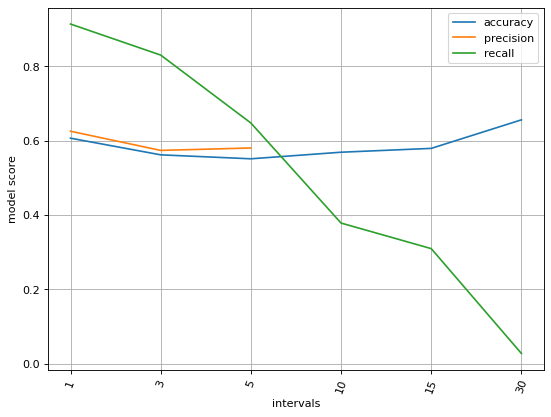

In [135]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='intervals', ylabel='model score')
plt.xticks(np.arange(len(intervals)), intervals, rotation='70')
plt.grid()
for i in range(3):
    plt.plot(np.sum(comp_ints, axis=0)[:,i]/9)
plt.legend(['accuracy', 'precision', 'recall'])

# time back

In [140]:
interval=1
time_to_skip=30
split_percent = 0.8
threshold = 0.0012
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
backs=[1,3,5,10,15,30]
comp_backs=np.zeros((len(list_of_companies_number), len(intervals),3))

In [141]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    for i in range(len(backs)):
        X_hold=get_X(comp_id, interval, time_to_skip, backs[i], names) 
        print('interval ', backs[i])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, backs[i], y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=threshold)
        print(y.shape)
        X,y=permutate_Xy(X_hold,y)
        comp_backs[comp_id,i,0],comp_backs[comp_id,i,1],comp_backs[comp_id,i,2]=logistic_regr(X, y,split_percent, 
                                                                                           comp_id=comp_id, check_up_down=False, track_params=False, local_names=names)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
interval  1
(150, 15)
true price at index 9,479 was zero!
(4790,)
Coefficient impact:
true_price   -0.9367761027028966
order_inbalance   -1.8649986451498102
vwaps_buy   0.6341778966627784
vwaps_sell   0.5268870511193433
s2f_impact_buy   -0.21987446413908704
s2f_impact_sell   -0.20095775797202578
trading_volumes   -0.12131804964376479
price_volatilities   0.027981981763548196
vwaps_order_sizes_buy   -0.6849797886842833
vwaps_order_sizes_sell   -0.827983033567725
s2f_order_sizes_buy   -0.6849797886842833
s2f_order_sizes_sell   -0.827983033567725
next_trade_time   -1.3631587379436678
next_trade_size   1.2033473284020373
next_trade_price   1.7677029201372632
[[563 303]
 [ 42  50]]
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
interval  3
(4790, 15)
true price at

interval  15
(4700, 15)
(4650,)
Coefficient impact:
true_price   -2.3258567011458315
order_inbalance   0.4071527749286118
vwaps_buy   1.2337886520932018
vwaps_sell   1.3196742965113817
s2f_impact_buy   0.5710070715689157
s2f_impact_sell   -0.4644511709042092
trading_volumes   -2.0291227692334592
price_volatilities   -0.7048751041104996
vwaps_order_sizes_buy   0.13598982336514662
vwaps_order_sizes_sell   -0.2653109085041978
s2f_order_sizes_buy   0.13598982336514662
s2f_order_sizes_sell   -0.2653109085041978
next_trade_time   -0.34108239182152
next_trade_size   0.130923656473788
next_trade_price   0.06554586131364822
[[625 282]
 [  2  21]]
26.052083333333332% of intervals were SELL empty
27.729166666666668% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
interval  30
(4650, 15)
(4500,)
Coefficient impact:
true_price   -2.344878858493216
order_inbalance   0.32555096409021367
vwaps_buy   1.5311439338194897
vwaps_sell   2.2073822511768997
s2f_impact_buy   -

31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
interval  10
(4750, 15)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4700,)
Coefficient impact:
true_price   -0.6546844904646074
order_inbalance   0.679602719071293
vwaps_buy   -0.8204151224394741
vwaps_sell   1.6627186285818696
s2f_impact_buy   0.5245588219974232
s2f_impact_sell   -0.4100638256776293
trading_volumes   1.2978129399494944
price_volatilities   -0.6976427742749663
vwaps_order_sizes_buy   0.3040410159576139
vwaps_order_sizes_sell   0.2714406010347389
s2f_order_sizes_buy   0.3040410159576139
s2f_order_sizes_sell   0.2714406010347389
next_trade_time   -0.5440852652244074
next_trade_size   1.0014613256730958
next_trade_price   -0.8369466339020781
[[478 333]
 [ 68  61]]
31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% o

17.21875% of intervals were SELL empty
20.8125% of intervals were BUY empty
0.15625% of intervals were set not filled
interval  1
(4500, 15)
(4790,)
Coefficient impact:
true_price   -1.5930449939424198
order_inbalance   -0.49854546827110574
vwaps_buy   -0.38065224275893317
vwaps_sell   0.3853638106989378
s2f_impact_buy   0.7042305666651425
s2f_impact_sell   0.05019468090447415
trading_volumes   -0.7830823507561231
price_volatilities   -0.16437916795633833
vwaps_order_sizes_buy   0.40229888407594255
vwaps_order_sizes_sell   0.1731150001171072
s2f_order_sizes_buy   0.40229888407594255
s2f_order_sizes_sell   0.1731150001171072
next_trade_time   -0.14630349351847743
next_trade_size   0.42766976889277836
next_trade_price   -0.30339653954388784
[[640 316]
 [  2   0]]
17.21875% of intervals were SELL empty
20.8125% of intervals were BUY empty
0.15625% of intervals were set not filled
interval  3
(4790, 15)
(4770,)
Coefficient impact:
true_price   -1.1403274537283243
order_inbalance   -0.03908

35.71875% of intervals were SELL empty
35.46875% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
interval  30
(4650, 15)
(4500,)
Coefficient impact:
true_price   -1.3837301556596384
order_inbalance   0.15432315393738638
vwaps_buy   -0.026618881410748474
vwaps_sell   1.7688370260043873
s2f_impact_buy   0.5732006165760223
s2f_impact_sell   -1.4730897351716645
trading_volumes   -2.787483640665514
price_volatilities   -0.34526972115203564
vwaps_order_sizes_buy   0.8814681714723737
vwaps_order_sizes_sell   0.2675462002133973
s2f_order_sizes_buy   0.8814681714723737
s2f_order_sizes_sell   0.2675462002133973
next_trade_time   0.04617091850187086
next_trade_size   -0.6199102326866759
next_trade_price   1.6046344684945353
[[578 300]
 [  5  17]]
7
23.697916666666668% of intervals were SELL empty
24.3125% of intervals were BUY empty
0.16666666666666666% of intervals were set not filled
interval  1
(4500, 15)
(4790,)
Coefficient impact:
true_price   -1.8547730114

30.75% of intervals were SELL empty
29.59375% of intervals were BUY empty
0.21875% of intervals were set not filled
interval  15
(4700, 15)
(4650,)
Coefficient impact:
true_price   -0.19069235648462793
order_inbalance   0.2510897126837503
vwaps_buy   0.5576920983329955
vwaps_sell   0.49040536403571466
s2f_impact_buy   0.24772815352720032
s2f_impact_sell   -3.009328655430922
trading_volumes   -0.871409831579349
price_volatilities   -1.2169299459443628
vwaps_order_sizes_buy   -0.777779525355964
vwaps_order_sizes_sell   2.3667312821806847
s2f_order_sizes_buy   -0.777779525355964
s2f_order_sizes_sell   2.3667312821806847
next_trade_time   -1.6438596773928613
next_trade_size   -4.703242035559965
next_trade_price   0.39703740303689994
[[466 210]
 [143 111]]
30.75% of intervals were SELL empty
29.59375% of intervals were BUY empty
0.21875% of intervals were set not filled
interval  30
(4650, 15)
(4500,)
Coefficient impact:
true_price   -0.3756970509214685
order_inbalance   0.91485089414087
vw

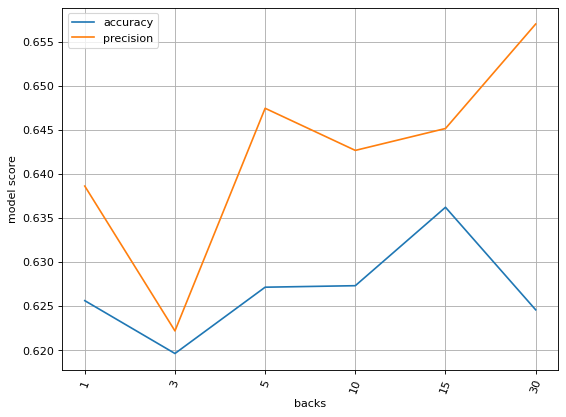

In [143]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='backs', ylabel='model score')
plt.xticks(np.arange(len(backs)), backs, rotation='70')
plt.grid()
for i in range(2):
    plt.plot(np.sum(comp_backs, axis=0)[:,i]/9)
plt.legend(['accuracy', 'precision', 'recall'])

# scaled vs non scaled

In [169]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
threshold = 0.0012
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
comp_nonscaled=np.zeros((len(list_of_companies_number),4)) #acc, prec,rec,time
comp_scaled=np.zeros((len(list_of_companies_number),4))

In [171]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X_hold=get_X(comp_id, interval, time_to_skip, time_back, names) 
    print(X.shape)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=threshold)
    print(y.shape)
    X,y=permutate_Xy(X_hold,y)
    time_start=time.time()
    comp_scaled[comp_id,0],comp_scaled[comp_id,1],comp_scaled[comp_id,2]=logistic_regr(X, y,split_percent, 
                                                                                       comp_id=comp_id, use_scaling=True, check_up_down=False, track_params=False, local_names=names)
    comp_scaled[comp_id,3]=time.time()-time_start
    comp_nonscaled[comp_id,0],comp_nonscaled[comp_id,1],comp_nonscaled[comp_id,2]=logistic_regr(X, y,split_percent, 
                                                                                       comp_id=comp_id, use_scaling=False, check_up_down=False, track_params=False, local_names=names)
    comp_nonscaled[comp_id,3]=time.time()-time_start
    
print("calculations took: {} seconds".format(  time.time()-time_start))

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -0.8873356107232355
order_inbalance   -0.8446639714080526
vwaps_buy   1.4762474626241942
vwaps_sell   0.745882416077046
s2f_impact_buy   0.8107018129527132
s2f_impact_sell   0.7486129074610014
trading_volumes   -0.3015060517713322
price_volatilities   -0.1645648548864763
vwaps_order_sizes_buy   -0.5463091823222785
vwaps_order_sizes_sell   -0.6720734310896552
s2f_order_sizes_buy   -0.5463091823222785
s2f_order_sizes_sell   -0.6720734310896552
next_trade_time   -1.1981709611385682
next_trade_size   0.9718895066316889
next_trade_price   1.5567900503444037
[[563 318]
 [ 22  47]]
Coefficient impact:
true_price   3.639093242645267e-05
order_inbalance   -8.085717364648641e-09
vwaps_buy   4.4740731841759234e-08
vwaps_sell   1.947807410338463e-08
s2f_impact_buy   5.82510

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


26.052083333333332% of intervals were SELL empty
27.729166666666668% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.3665310307873018
order_inbalance   0.5451367470937482
vwaps_buy   0.31680600961584515
vwaps_sell   1.7173049671362506
s2f_impact_buy   0.42921785288354136
s2f_impact_sell   -0.16205598588456083
trading_volumes   -1.2991787175877816
price_volatilities   -0.4288260276500665
vwaps_order_sizes_buy   0.40296040905638214
vwaps_order_sizes_sell   -0.4462950491597996
s2f_order_sizes_buy   0.40296040905638214
s2f_order_sizes_sell   -0.4462950491597996
next_trade_time   -0.06733270190025
next_trade_size   0.8624912509259591
next_trade_price   0.3908709355364804
[[641 305]
 [  0   4]]
Coefficient impact:
true_price   4.233028849962297e-06
order_inbalance   6.106606471361205e-10
vwaps_buy   2.208188068983816e-09
vwaps_sell   2.302919909838696e-09
s2f_impact_buy   3.7226327182053627e-09
s2f_impac

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


30.0% of intervals were SELL empty
27.25% of intervals were BUY empty
0.010416666666666666% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   0.2680610932231057
order_inbalance   -0.314024569032211
vwaps_buy   -0.21658728959954845
vwaps_sell   0.6364884447107297
s2f_impact_buy   0.3659010590589435
s2f_impact_sell   -0.9093515056926017
trading_volumes   -1.6596682385069814
price_volatilities   0.006896882730321143
vwaps_order_sizes_buy   -0.21889591709537262
vwaps_order_sizes_sell   -0.06889956618970197
s2f_order_sizes_buy   -0.21889591709537262
s2f_order_sizes_sell   -0.06889956618970197
next_trade_time   -1.0770713595415198
next_trade_size   1.352376499346904
next_trade_price   -0.08928319313269756
[[525 391]
 [ 17  17]]
Coefficient impact:
true_price   8.2991243070443e-07
order_inbalance   -7.705892719029331e-12
vwaps_buy   2.822406389882192e-10
vwaps_sell   3.191783242693294e-10
s2f_impact_buy   5.896698716761929e-10
s2f_impact_sell   4.72388721881

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
(4750, 15)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -0.7466785976902721
order_inbalance   0.4033050398597334
vwaps_buy   -0.3494892837915371
vwaps_sell   0.5596355479090088
s2f_impact_buy   0.060721316807298906
s2f_impact_sell   -1.0384394264552708
trading_volumes   1.1351919726486788
price_volatilities   -0.40573977608457473
vwaps_order_sizes_buy   -0.04381326810247868
vwaps_order_sizes_sell   0.24653968580952262
s2f_order_sizes_buy   -0.04381326810247868
s2f_order_sizes_sell   0.24653968580952262
next_trade_time   -0.6774857041717353
next_trade_size   0.9670942923110288
next_trade_price   -0.38484027642506574
[[551 396]
 [  0   3]]
Coefficient impact:
true_price   3.2876158061047237e-07
order_inbalance   8.398340122826903e-11
vwaps_buy   -1

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   1.2730918132756774e-05
order_inbalance   1.8303845546939295e-09
vwaps_buy   -4.96829167200426e-08
vwaps_sell   5.2471401054847755e-09
s2f_impact_buy   1.4527145440954139e-08
s2f_impact_sell   1.0050980617373785e-08
trading_volumes   6.355183905400094e-05
price_volatilities   -3.830459220906237e-08
vwaps_order_sizes_buy   3.738029630301872e-05
vwaps_order_sizes_sell   2.3359358290794285e-05
s2f_order_sizes_buy   3.738029630301872e-05
s2f_order_sizes_sell   2.3359358290794285e-05
next_trade_time   8.446452672482719e-09
next_trade_size   9.327865395525882e-06
next_trade_price   -3.7203432257255637e-08
[[595 355]
 [  0   0]]
5
17.21875% of intervals were SELL empty
20.8125% of intervals were BUY empty
0.15625% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.2237646618040294
order_inbalance   -0.45070410758006824
vwaps_buy   0.21541267135624398
vwaps_sell   -0.1795845452624829
s2f_impact_buy   -0.31502308970592435
s2f_

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



vwaps_order_sizes_buy   8.696728141378251e-06
vwaps_order_sizes_sell   8.628719037737764e-06
s2f_order_sizes_buy   8.696728141378251e-06
s2f_order_sizes_sell   8.628719037737764e-06
next_trade_time   2.2866739129205408e-08
next_trade_size   4.133632060175801e-06
next_trade_price   -8.271173063740188e-11
[[626 324]
 [  0   0]]
6
35.71875% of intervals were SELL empty
35.46875% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.7219885610273757
order_inbalance   0.3522245045356506
vwaps_buy   -0.14856957863615816
vwaps_sell   1.3898970574572245
s2f_impact_buy   0.23382669740951464
s2f_impact_sell   -0.401636879169478
trading_volumes   -2.1896526740874154
price_volatilities   0.2197968360921518
vwaps_order_sizes_buy   -0.28643317996933193
vwaps_order_sizes_sell   -0.668539691889943
s2f_order_sizes_buy   -0.28643317996933193
s2f_order_sizes_sell   -0.668539691889943
next_trade_time   0.573089498076396
n

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


23.697916666666668% of intervals were SELL empty
24.3125% of intervals were BUY empty
0.16666666666666666% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.8231441660566948
order_inbalance   -0.6700818021198492
vwaps_buy   -0.2688748136522054
vwaps_sell   2.36874741072836
s2f_impact_buy   0.7162532894739749
s2f_impact_sell   0.9212051492842693
trading_volumes   -2.9711986790347504
price_volatilities   0.8111259798244764
vwaps_order_sizes_buy   -0.9902513740296531
vwaps_order_sizes_sell   0.6352971555187984
s2f_order_sizes_buy   -0.9902513740296531
s2f_order_sizes_sell   0.6352971555187984
next_trade_time   0.3076092970376878
next_trade_size   2.4760550687632157
next_trade_price   0.831786003893937
[[503 410]
 [ 13  24]]


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   8.658779836035223e-07
order_inbalance   -7.652409558947489e-11
vwaps_buy   2.8651257227178403e-10
vwaps_sell   4.1774078802076793e-10
s2f_impact_buy   4.93035511409151e-10
s2f_impact_sell   6.00034792984409e-10
trading_volumes   8.60724252640096e-07
price_volatilities   -3.013558417149057e-08
vwaps_order_sizes_buy   1.20014426458167e-06
vwaps_order_sizes_sell   4.965705815127184e-06
s2f_order_sizes_buy   1.20014426458167e-06
s2f_order_sizes_sell   4.965705815127184e-06
next_trade_time   3.026313649504616e-08
next_trade_size   5.2056882895913266e-06
next_trade_price   4.293674202431827e-12
[[516 434]
 [  0   0]]
8
30.75% of intervals were SELL empty
29.59375% of intervals were BUY empty
0.21875% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.012876665560413
order_inbalance   0.7545099213978006
vwaps_buy   0.6333817262641688
vwaps_sell   1.9598162824130756
s2f_impact_buy   -0.10352778041023963
s2f_impact_sell   -1.

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


25.604166666666668% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
0.1875% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.2702454329474784
order_inbalance   1.0287931001901467
vwaps_buy   -0.3974889735691938
vwaps_sell   1.237089130745516
s2f_impact_buy   0.21966869413062695
s2f_impact_sell   0.5970861994846829
trading_volumes   0.20207054050869144
price_volatilities   -0.22178591426971447
vwaps_order_sizes_buy   0.21063012900001618
vwaps_order_sizes_sell   1.3995339316711253
s2f_order_sizes_buy   0.21063012900001618
s2f_order_sizes_sell   1.3995339316711253
next_trade_time   -0.3499924192845898
next_trade_size   0.09308707950448628
next_trade_price   -0.4498028405754205
[[502 333]
 [ 43  72]]
Coefficient impact:
true_price   4.1982848992315835e-06
order_inbalance   5.286776137640643e-10
vwaps_buy   8.322092742878904e-10
vwaps_sell   5.268284772055336e-09
s2f_impact_buy   1.843467494949389e-09
s2f_impact_sell   2.75

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


30.197916666666668% of intervals were SELL empty
28.90625% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.1738619380994757
order_inbalance   -0.5744185860437632
vwaps_buy   -0.3520157064335754
vwaps_sell   0.35052328989963283
s2f_impact_buy   0.12120278026626115
s2f_impact_sell   0.4299086275049303
trading_volumes   -0.4851591501517558
price_volatilities   -0.5268666574902037
vwaps_order_sizes_buy   0.943764117942754
vwaps_order_sizes_sell   0.4108496777968628
s2f_order_sizes_buy   0.943764117942754
s2f_order_sizes_sell   0.4108496777968628
next_trade_time   -0.6930775638737807
next_trade_size   1.0678280012347154
next_trade_price   0.38530442381081387
[[228 224]
 [225 273]]
Coefficient impact:
true_price   -8.267479323949109e-06
order_inbalance   -2.470539369550583e-09
vwaps_buy   -1.669361387989521e-09
vwaps_sell   -1.5440368004929231e-09
s2f_impact_buy   -3.3556221644760936e-09
s2f_impact_sell

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


26.5625% of intervals were SELL empty
26.260416666666668% of intervals were BUY empty
0.07291666666666667% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.0003324155494027
order_inbalance   0.034138507580213064
vwaps_buy   -0.21016117101558407
vwaps_sell   0.4786984619568425
s2f_impact_buy   0.3395237737722618
s2f_impact_sell   -0.19726110272913386
trading_volumes   0.05856952286904815
price_volatilities   -1.0287103025791078
vwaps_order_sizes_buy   0.7146806242924763
vwaps_order_sizes_sell   0.08001872940981661
s2f_order_sizes_buy   0.7146806242924763
s2f_order_sizes_sell   0.08001872940981661
next_trade_time   -1.1507376630836612
next_trade_size   0.5553806896246294
next_trade_price   0.19525923128237194
[[641 309]
 [  0   0]]
Coefficient impact:
true_price   6.4796521625653e-08
order_inbalance   3.0830723762506e-11
vwaps_buy   2.1188428223072288e-11
vwaps_sell   2.3189265789761267e-11
s2f_impact_buy   4.0671658813126595e-11
s2f_impact_sell   3

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


25.177083333333332% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
0.4895833333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.808558182682525
order_inbalance   0.2800989820159802
vwaps_buy   -0.40255489440748615
vwaps_sell   0.5811845538720405
s2f_impact_buy   1.0735311432942949
s2f_impact_sell   1.015617322388438
trading_volumes   1.001685845789075
price_volatilities   -0.20537289398261774
vwaps_order_sizes_buy   -0.3843206826111909
vwaps_order_sizes_sell   -0.23496121954648783
s2f_order_sizes_buy   -0.3843206826111909
s2f_order_sizes_sell   -0.23496121954648783
next_trade_time   0.6674436056417687
next_trade_size   1.4198195117895376
next_trade_price   0.6522140189071076
[[275 205]
 [239 231]]
Coefficient impact:
true_price   2.6374450781846757e-08
order_inbalance   1.117572704740247e-11
vwaps_buy   1.3295441955155546e-11
vwaps_sell   1.4430481887764156e-11
s2f_impact_buy   2.5251704290856176e-11
s2f_impac

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


33.6875% of intervals were SELL empty
31.802083333333332% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.6122661040898079
order_inbalance   -0.08090832582257072
vwaps_buy   0.34871261544343124
vwaps_sell   0.9136074775717316
s2f_impact_buy   0.5671075531586345
s2f_impact_sell   -0.3275555473011375
trading_volumes   -0.3213978173579184
price_volatilities   -0.2331196366790304
vwaps_order_sizes_buy   0.10943639901049164
vwaps_order_sizes_sell   0.7710280821907133
s2f_order_sizes_buy   0.10943639901049164
s2f_order_sizes_sell   0.7710280821907133
next_trade_time   -0.5285979014105617
next_trade_size   0.49374400892231307
next_trade_price   0.13547527923291752
[[485 328]
 [ 71  66]]
Coefficient impact:
true_price   1.2567157790328376e-07
order_inbalance   6.959404863313424e-11
vwaps_buy   8.197529348599363e-11
vwaps_sell   6.409466263329997e-11
s2f_impact_buy   1.5679001769707556e-10
s2f_impact_sell 

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


31.5625% of intervals were SELL empty
30.239583333333332% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.9136715399916975
order_inbalance   0.9270939408374177
vwaps_buy   -0.013590630535730069
vwaps_sell   -0.8735950355863562
s2f_impact_buy   2.1100481474309993
s2f_impact_sell   -0.4845270939866359
trading_volumes   -0.1359077067172192
price_volatilities   -0.6036956821823014
vwaps_order_sizes_buy   0.6622136470905787
vwaps_order_sizes_sell   0.5579987786226306
s2f_order_sizes_buy   0.6622136470905787
s2f_order_sizes_sell   0.5579987786226306
next_trade_time   1.876342231765317
next_trade_size   -1.6243932779137937
next_trade_price   1.0218536003356196
[[346 216]
 [214 174]]
Coefficient impact:
true_price   1.0510867457712245e-05
order_inbalance   3.1329192205073763e-09
vwaps_buy   7.04751784373476e-09
vwaps_sell   -1.9252378692067682e-09
s2f_impact_buy   1.6684304282318106e-08
s2f_impact_sell   3.157559450419

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


31.052083333333332% of intervals were SELL empty
33.145833333333336% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.04667349249938618
order_inbalance   0.523998681935789
vwaps_buy   -0.5809326839655905
vwaps_sell   1.156591499537503
s2f_impact_buy   0.5419490501500174
s2f_impact_sell   -0.6034346128007151
trading_volumes   -0.0014471809409783009
price_volatilities   -0.6465209081657357
vwaps_order_sizes_buy   -1.0578153970482402
vwaps_order_sizes_sell   0.5137852260937872
s2f_order_sizes_buy   -1.0578153970482402
s2f_order_sizes_sell   0.5137852260937872
next_trade_time   -0.3165045075115216
next_trade_size   -1.384240442492153
next_trade_price   0.7472083996898791
[[479 370]
 [ 47  54]]
Coefficient impact:
true_price   -2.0931165186763904e-06
order_inbalance   1.0363980222244172e-09
vwaps_buy   -1.2490423126333884e-09
vwaps_sell   3.4546526264977344e-10
s2f_impact_buy   -1.1786034422339978e-09
s

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


30.416666666666668% of intervals were SELL empty
30.333333333333332% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -3.423572946239274
order_inbalance   -0.4570807204449778
vwaps_buy   0.12937286465769618
vwaps_sell   1.7836154988574948
s2f_impact_buy   0.060688310684691105
s2f_impact_sell   -0.44035524174862845
trading_volumes   0.19313088719577748
price_volatilities   0.13892139814876925
vwaps_order_sizes_buy   0.4318290664264112
vwaps_order_sizes_sell   1.2753346984334433
s2f_order_sizes_buy   0.4318290664264112
s2f_order_sizes_sell   1.2753346984334433
next_trade_time   -0.22119428902160188
next_trade_size   0.6244579923314448
next_trade_price   0.7195194833639099
[[652 296]
 [  1   1]]
Coefficient impact:
true_price   2.2533568446356002e-05
order_inbalance   -6.873823270150109e-10
vwaps_buy   1.32520314416515e-08
vwaps_sell   1.61867435523485e-08
s2f_impact_buy   2.1119499137941376e-08
s2f_impac

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


25.5% of intervals were SELL empty
25.5625% of intervals were BUY empty
0.125% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.1084103617078567
order_inbalance   -0.7977870879914096
vwaps_buy   1.680938818313306
vwaps_sell   -0.4743632825532215
s2f_impact_buy   -0.5905638339466658
s2f_impact_sell   0.6360869947773135
trading_volumes   -0.8270687731390861
price_volatilities   -0.33253063860328885
vwaps_order_sizes_buy   0.2481584944074012
vwaps_order_sizes_sell   -0.5464085249291055
s2f_order_sizes_buy   0.2481584944074012
s2f_order_sizes_sell   -0.5464085249291055
next_trade_time   0.024914449047767517
next_trade_size   -0.16036411262994751
next_trade_price   -0.24342892159100812
[[648 299]
 [  1   2]]
Coefficient impact:
true_price   1.292687638714577e-06
order_inbalance   -3.9334605401585864e-11
vwaps_buy   6.623261485989227e-10
vwaps_sell   5.06315491777717e-10
s2f_impact_buy   1.042049832084344e-09
s2f_impact_sell   1.0366890766553855e-09
tra

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


27.677083333333332% of intervals were SELL empty
29.114583333333332% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.940492991138143
order_inbalance   0.3475126233256905
vwaps_buy   -1.0802152291703178
vwaps_sell   -0.2526835644789323
s2f_impact_buy   1.1068548524974977
s2f_impact_sell   0.09940917016640262
trading_volumes   -2.0814976712046342
price_volatilities   -0.036979095457289016
vwaps_order_sizes_buy   -0.3309915787999258
vwaps_order_sizes_sell   -0.31736247571103177
s2f_order_sizes_buy   -0.3309915787999258
s2f_order_sizes_sell   -0.31736247571103177
next_trade_time   -1.0423842864396144
next_trade_size   1.899037348398584
next_trade_price   0.361355249894541
[[  1   2]
 [427 520]]
Coefficient impact:
true_price   -4.102420329240375e-06
order_inbalance   1.238499319573501e-09
vwaps_buy   -2.1252680028405715e-09
vwaps_sell   -1.1269735067669441e-09
s2f_impact_buy   7.600779433394109e-10
s2

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


30.458333333333332% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.316290685603447
order_inbalance   0.3777313070667701
vwaps_buy   0.8325813544589127
vwaps_sell   1.6611146761860776
s2f_impact_buy   -0.27270854645583215
s2f_impact_sell   -0.15528127601073083
trading_volumes   -0.10407645076102763
price_volatilities   -0.7073868077592412
vwaps_order_sizes_buy   -0.4382879670378419
vwaps_order_sizes_sell   0.16376143298510495
s2f_order_sizes_buy   -0.4382879670378419
s2f_order_sizes_sell   0.16376143298510495
next_trade_time   -1.383111774315743
next_trade_size   -0.5233432175214159
next_trade_price   -0.09944011221876671
[[  8   3]
 [539 400]]
Coefficient impact:
true_price   3.643810086926049e-08
order_inbalance   1.5442372390415977e-09
vwaps_buy   2.3326530413151445e-09
vwaps_sell   4.76760826191556e-09
s2f_impact_buy   1.058988829096426e-09
s2f_

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


32.270833333333336% of intervals were SELL empty
35.125% of intervals were BUY empty
0.03125% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.3680168610842582
order_inbalance   -0.033395495655234676
vwaps_buy   0.5358453763466362
vwaps_sell   1.0149154980860524
s2f_impact_buy   0.1507608534500827
s2f_impact_sell   -0.05331144580651574
trading_volumes   -0.8951994655600348
price_volatilities   -1.3740612189079358
vwaps_order_sizes_buy   -0.04459646019898205
vwaps_order_sizes_sell   0.4208624377969153
s2f_order_sizes_buy   -0.04459646019898205
s2f_order_sizes_sell   0.4208624377969153
next_trade_time   -0.7298049398084406
next_trade_size   0.37367523627783744
next_trade_price   0.38241064161654137
[[591 359]
 [  0   0]]
Coefficient impact:
true_price   1.54953412510858e-06
order_inbalance   3.7835284432207477e-10
vwaps_buy   8.639261097778409e-10
vwaps_sell   1.677997286772899e-09
s2f_impact_buy   1.5423246744271526e-09
s2f_impact_sell   1.55491051

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


22.385416666666668% of intervals were SELL empty
25.635416666666668% of intervals were BUY empty
0.2708333333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   0.11258974977845941
order_inbalance   0.784907320201827
vwaps_buy   0.8253955016233275
vwaps_sell   0.39549563444085695
s2f_impact_buy   -0.16968257953506202
s2f_impact_sell   0.12330617403916326
trading_volumes   -1.2086643319256958
price_volatilities   0.4603270504215668
vwaps_order_sizes_buy   0.300209731175988
vwaps_order_sizes_sell   1.3106044408739081
s2f_order_sizes_buy   0.300209731175988
s2f_order_sizes_sell   1.3106044408739081
next_trade_time   -0.9741961326031984
next_trade_size   0.15239663768803643
next_trade_price   0.5964900060693695
[[419 276]
 [128 127]]
Coefficient impact:
true_price   6.30769739935897e-07
order_inbalance   1.090374073028698e-10
vwaps_buy   2.870479676100902e-10
vwaps_sell   2.5834737654869493e-10
s2f_impact_buy   4.4279113886801676e-10
s2f_impact_sell

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


32.072916666666664% of intervals were SELL empty
33.583333333333336% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   0.31257327340226976
order_inbalance   -0.5573724296445248
vwaps_buy   0.3182808516744594
vwaps_sell   1.6398409729466692
s2f_impact_buy   0.2855301692851616
s2f_impact_sell   -0.4747748172026731
trading_volumes   -1.3639254491297272
price_volatilities   -0.6103402981307998
vwaps_order_sizes_buy   -0.10639824349716082
vwaps_order_sizes_sell   -0.47873708498557677
s2f_order_sizes_buy   -0.10639824349716082
s2f_order_sizes_sell   -0.47873708498557677
next_trade_time   -0.15152809548109455
next_trade_size   0.40019321248076567
next_trade_price   -0.21295896193734704
[[567 347]
 [ 17  19]]
Coefficient impact:
true_price   1.572504504411636e-06
order_inbalance   -8.051916657891552e-10
vwaps_buy   8.074798808856672e-10
vwaps_sell   9.318687869018699e-10
s2f_impact_buy   1.4031630095870556e-09

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


31.458333333333332% of intervals were SELL empty
31.0% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.339465789257516
order_inbalance   -0.2644074153431094
vwaps_buy   0.23309368871263467
vwaps_sell   1.5965774467527174
s2f_impact_buy   -0.5097926916007981
s2f_impact_sell   -0.11711730494902242
trading_volumes   -0.7785583381569479
price_volatilities   -0.9670217384883212
vwaps_order_sizes_buy   0.8639151178281766
vwaps_order_sizes_sell   -1.5218448639575304
s2f_order_sizes_buy   0.8639151178281766
s2f_order_sizes_sell   -1.5218448639575304
next_trade_time   1.8317705737170873
next_trade_size   1.3001362120375684
next_trade_price   0.5473654111520606
[[551 397]
 [  0   2]]
Coefficient impact:
true_price   7.828163426065119e-11
order_inbalance   -5.431778494950953e-15
vwaps_buy   2.5585049917941458e-14
vwaps_sell   3.895285086064999e-14
s2f_impact_buy   2.0597325696917022e-14
s2f_impact_sell   1.909177208533163

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


26
37.958333333333336% of intervals were SELL empty
36.052083333333336% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -1.3913478660484164
order_inbalance   0.21320620044463057
vwaps_buy   1.2779867936300933
vwaps_sell   0.9109070505452254
s2f_impact_buy   -1.2315476672182457
s2f_impact_sell   -1.8129040167704562
trading_volumes   -0.24045403835837226
price_volatilities   0.2979105034809082
vwaps_order_sizes_buy   0.9679946483776339
vwaps_order_sizes_sell   -0.69549994156985
s2f_order_sizes_buy   0.9679946483776339
s2f_order_sizes_sell   -0.69549994156985
next_trade_time   -1.322752102139494
next_trade_size   -0.15450102466577945
next_trade_price   -0.5231001302853048
[[671 273]
 [  2   4]]
Coefficient impact:
true_price   6.462179751625597e-05
order_inbalance   -4.2760720763631136e-10
vwaps_buy   1.0472516413358896e-07
vwaps_sell   6.8540226

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


24.635416666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
0.10416666666666667% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.8755634071140692
order_inbalance   -1.0100242134208819
vwaps_buy   0.2187365126162718
vwaps_sell   -1.548797212640462
s2f_impact_buy   -0.06252499573964686
s2f_impact_sell   1.001751569654175
trading_volumes   -0.9741994151717304
price_volatilities   -0.4924014780173765
vwaps_order_sizes_buy   0.2688781263916902
vwaps_order_sizes_sell   -0.25891835550433356
s2f_order_sizes_buy   0.2688781263916902
s2f_order_sizes_sell   -0.25891835550433356
next_trade_time   0.38385175129594634
next_trade_size   -1.0199785159243584
next_trade_price   -0.35192360107875414
[[707 236]
 [  5   2]]
Coefficient impact:
true_price   9.018662663654839e-08
order_inbalance   -4.6273652539049734e-11
vwaps_buy   3.032144969369201e-11
vwaps_sell   1.9636821558868373e-11
s2f_impact_buy   5.438310680004009e-11
s2f_

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


27.427083333333332% of intervals were SELL empty
27.520833333333332% of intervals were BUY empty
0.09375% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.5145625657204272
order_inbalance   0.6163087971476793
vwaps_buy   0.674833650939797
vwaps_sell   0.3637302966795668
s2f_impact_buy   0.13438959240258666
s2f_impact_sell   -0.11139464234699673
trading_volumes   -0.8766343334665446
price_volatilities   -0.5933384188769089
vwaps_order_sizes_buy   -0.02201741493329933
vwaps_order_sizes_sell   0.9800392946974272
s2f_order_sizes_buy   -0.02201741493329933
s2f_order_sizes_sell   0.9800392946974272
next_trade_time   0.5611293822779265
next_trade_size   0.36343853844586427
next_trade_price   0.5138440301363801
[[146 108]
 [326 370]]
Coefficient impact:
true_price   -1.4217849435816637e-06
order_inbalance   4.4143468729157757e-10
vwaps_buy   2.138034707276846e-12
vwaps_sell   -3.161467696775841e-10
s2f_impact_buy   -2.8572105465320403e-10
s2f_impact_sell 

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


25.041666666666668% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
0.125% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -0.34984824863732766
order_inbalance   0.05723686561223609
vwaps_buy   1.3592594944974006
vwaps_sell   -0.34918526466939637
s2f_impact_buy   0.1123701636533013
s2f_impact_sell   -0.3457752973541727
trading_volumes   -0.2907553928314004
price_volatilities   -0.40099548854224154
vwaps_order_sizes_buy   1.7004792245490494
vwaps_order_sizes_sell   0.17644126350491396
s2f_order_sizes_buy   1.7004792245490494
s2f_order_sizes_sell   0.17644126350491396
next_trade_time   -1.2159771716735013
next_trade_size   0.7354380608556143
next_trade_price   -0.5516813839261923
[[598 347]
 [  2   3]]
Coefficient impact:
true_price   5.144497483477455e-07
order_inbalance   -1.4731475744315432e-10
vwaps_buy   2.24062929364693e-10
vwaps_sell   1.0793501785507856e-10
s2f_impact_buy   3.535

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


37.270833333333336% of intervals were SELL empty
31.71875% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.49066091661580014
order_inbalance   -0.9456088636458332
vwaps_buy   1.442080248306654
vwaps_sell   -0.8127083212522743
s2f_impact_buy   0.8931951663965608
s2f_impact_sell   0.4056216684817593
trading_volumes   -1.2856084276475885
price_volatilities   -0.07522048127283157
vwaps_order_sizes_buy   -0.8931918480116453
vwaps_order_sizes_sell   1.048222076531617
s2f_order_sizes_buy   -0.8931918480116453
s2f_order_sizes_sell   1.048222076531617
next_trade_time   0.8721105298218701
next_trade_size   -0.4034585791477266
next_trade_price   2.405195652968778
[[435 361]
 [ 80  74]]
Coefficient impact:
true_price   -1.8646226579650432e-05
order_inbalance   -4.084404166535412e-09
vwaps_buy   1.0976728325379029e-08
vwaps_sell   -3.939490489419364e-08
s2f_impact_buy   3.699230759288517e-09
s2f_impact_sell   

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


19.21875% of intervals were SELL empty
22.552083333333332% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.4824790133636057
order_inbalance   1.088520581418956
vwaps_buy   -0.17797889211920406
vwaps_sell   1.1228893194039273
s2f_impact_buy   1.517765224481693
s2f_impact_sell   0.6345434950107437
trading_volumes   -1.7969750245541876
price_volatilities   -0.045317703879114615
vwaps_order_sizes_buy   0.652909761790276
vwaps_order_sizes_sell   0.25897246489428205
s2f_order_sizes_buy   0.652909761790276
s2f_order_sizes_sell   0.25897246489428205
next_trade_time   2.1229059741552616
next_trade_size   -1.0201806615679039
next_trade_price   0.7348297012795154
[[361 185]
 [189 215]]
Coefficient impact:
true_price   4.371765907980881e-07
order_inbalance   3.4401689218551785e-10
vwaps_buy   1.4020327929034906e-10
vwaps_sell   1.7780342318854518e-10
s2f_impact_buy   2.794791125598988e-10
s2f_impact_sell   2.28270079304153

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[440 289]
 [110 111]]
32
37.052083333333336% of intervals were SELL empty
36.625% of intervals were BUY empty
0.010416666666666666% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -0.6074002015939272
order_inbalance   0.16004004354086912
vwaps_buy   1.2936967714457037
vwaps_sell   -0.18339347830391728
s2f_impact_buy   -1.1441487119834726
s2f_impact_sell   -0.07954746426319141
trading_volumes   0.10300471330454963
price_volatilities   0.4220535716032519
vwaps_order_sizes_buy   0.620747307470273
vwaps_order_sizes_sell   -0.26066454027919583
s2f_order_sizes_buy   0.620747307470273
s2f_order_sizes_sell   -0.26066454027919583
next_trade_time   0.9837784273394169
next_trade_size   -0.35702766736670083
next_trade_price   -0.2434895937945302
[[579 370]
 [  1   0]]
Coefficient impact:
true_price   9.60978975910055e-05
order_inbalance   1.3323001574516248e-08
vwaps_buy   6.242024144291551e-08
vwaps_sell   4.106397782003683

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


20.9375% of intervals were SELL empty
15.59375% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.72474959434054
order_inbalance   -0.4479055293906766
vwaps_buy   1.327974947950604
vwaps_sell   1.4701038752643685
s2f_impact_buy   -0.46067087430174186
s2f_impact_sell   0.04421282398253493
trading_volumes   0.027409579344118886
price_volatilities   -1.2622344052998904
vwaps_order_sizes_buy   -0.32952699515223466
vwaps_order_sizes_sell   -0.9847859436179691
s2f_order_sizes_buy   -0.32952699515223466
s2f_order_sizes_sell   -0.9847859436179691
next_trade_time   -1.5215923852479454
next_trade_size   -0.36046661749181536
next_trade_price   0.23348908664866358
[[396 352]
 [ 83 119]]
Coefficient impact:
true_price   8.286701720753937e-08
order_inbalance   -7.446570475001583e-11
vwaps_buy   1.3173756641794899e-10
vwaps_sell   1.3024528722787424e-11
s2f_impact_buy   7.645522119413831e-11
s2f_impact_sell   2.16

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


36.645833333333336% of intervals were SELL empty
35.979166666666664% of intervals were BUY empty
0.0% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.9422890794482623
order_inbalance   -0.03862613844610266
vwaps_buy   -0.2489406030351498
vwaps_sell   0.947755249136875
s2f_impact_buy   0.38696388774488377
s2f_impact_sell   0.819350203041832
trading_volumes   -0.8372235071928048
price_volatilities   -0.3873133407249151
vwaps_order_sizes_buy   -0.16881443977864558
vwaps_order_sizes_sell   -0.07585599927574885
s2f_order_sizes_buy   -0.16881443977864558
s2f_order_sizes_sell   -0.07585599927574885
next_trade_time   -0.38212140776666187
next_trade_size   0.16783036922532826
next_trade_price   0.4154643106738799
[[180 102]
 [375 293]]
Coefficient impact:
true_price   0.00012407910317610265
order_inbalance   1.3806419862924305e-08
vwaps_buy   6.470944698994807e-08
vwaps_sell   1.4784880120158144e-07
s2f_impact_buy   1.377758005791963e-07
s2f_impact_sell  

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


21.479166666666668% of intervals were SELL empty
16.864583333333332% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.139234423063247
order_inbalance   -0.12089738242877734
vwaps_buy   3.0493381715352417
vwaps_sell   0.38423257811663775
s2f_impact_buy   1.0239856782190346
s2f_impact_sell   0.10657538595284559
trading_volumes   -1.5107959539316262
price_volatilities   -0.1036651222229526
vwaps_order_sizes_buy   -0.8413103088254484
vwaps_order_sizes_sell   1.3611896708085673
s2f_order_sizes_buy   -0.8413103088254484
s2f_order_sizes_sell   1.3611896708085673
next_trade_time   -1.3660065563937505
next_trade_size   -2.123750384894819
next_trade_price   1.489786165404153
[[  7   0]
 [447 496]]
Coefficient impact:
true_price   5.5633264552695815e-06
order_inbalance   -9.951438268770588e-10
vwaps_buy   9.215915586129357e-09
vwaps_sell   1.4503095092448714e-09
s2f_impact_buy   6.473298400037782e-09
s2f_impa

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


23.708333333333332% of intervals were SELL empty
23.96875% of intervals were BUY empty
0.25% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.1323167800326943
order_inbalance   0.680800124822451
vwaps_buy   0.3831661652165039
vwaps_sell   0.8399577133580873
s2f_impact_buy   -0.1429160660096322
s2f_impact_sell   -0.05761640886284474
trading_volumes   -1.3755871835213442
price_volatilities   0.11075718176813255
vwaps_order_sizes_buy   0.17139777261040667
vwaps_order_sizes_sell   0.18438781998814202
s2f_order_sizes_buy   0.17139777261040667
s2f_order_sizes_sell   0.18438781998814202
next_trade_time   0.017272016902122028
next_trade_size   -0.6981481965566009
next_trade_price   -0.01467857151846738
[[640 301]
 [  8   1]]
Coefficient impact:
true_price   6.195960875213925e-07
order_inbalance   1.3108915129559963e-10
vwaps_buy   2.32510193095171e-10
vwaps_sell   2.385323750125915e-10
s2f_impact_buy   3.2045137674067777e-10
s2f_impact_sell   3.4505860107

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


37
36.21875% of intervals were SELL empty
32.59375% of intervals were BUY empty
0.07291666666666667% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.8458099220568467
order_inbalance   -0.5574809649664242
vwaps_buy   -0.9645801468196591
vwaps_sell   -2.5241879697382053
s2f_impact_buy   0.4611365033977228
s2f_impact_sell   -0.28315385547168687
trading_volumes   0.42492799868310477
price_volatilities   -0.09324246081042818
vwaps_order_sizes_buy   0.10513368603245396
vwaps_order_sizes_sell   1.055540599245007
s2f_order_sizes_buy   0.10513368603245396
s2f_order_sizes_sell   1.055540599245007
next_trade_time   -0.1054940221800185
next_trade_size   1.7900148236729556
next_trade_price   0.9626634194785434
[[156 115]
 [320 359]]
Coefficient impact:
true_price   7.505798895285829e-13
order_inbalance   -7.715428067735816e-16
vwaps_buy   9.467563562049916e-16
vwaps_sell   -4.1302366079964854e-15
s2f_impact_buy   2.925734390749459e-15
s2f_impact_sell   -2.710

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


24.84375% of intervals were SELL empty
25.75% of intervals were BUY empty
0.23958333333333334% of intervals were set not filled
(4750, 15)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -2.2344565791560815
order_inbalance   -0.11905326578401759
vwaps_buy   -0.6863299621538556
vwaps_sell   1.0282581548241074
s2f_impact_buy   0.7523504620679212
s2f_impact_sell   0.5058741514182065
trading_volumes   1.364762757580506
price_volatilities   -0.47857780439086006
vwaps_order_sizes_buy   -0.8842196552777916
vwaps_order_sizes_sell   -0.5587892108783896
s2f_order_sizes_buy   -0.8842196552777916
s2f_order_sizes_sell   -0.5587892108783896
next_trade_time   -1.0504852331412504
next_trade_size   -1.433536524637777
next_trade_price   -0.6532005237014507
[[582 361]
 [  1   6]]
Coefficient impact:
true_price   0.00010198616256941433
order_inbalance   1.1842804357358034e-09
vwaps_buy   -1.7603540544482275e-07
vwaps_sell   4.756135905296454

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


36.958333333333336% of intervals were SELL empty
36.0% of intervals were BUY empty
0.010416666666666666% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -1.9397833435345275
order_inbalance   0.07330978098956627
vwaps_buy   1.0264634277629483
vwaps_sell   0.5561604190720852
s2f_impact_buy   -0.026419720224894312
s2f_impact_sell   0.11715573799176458
trading_volumes   -1.3029821426072639
price_volatilities   -0.06392847619346395
vwaps_order_sizes_buy   -0.669004614538761
vwaps_order_sizes_sell   0.4850007065838094
s2f_order_sizes_buy   -0.669004614538761
s2f_order_sizes_sell   0.4850007065838094
next_trade_time   -0.1631419443900697
next_trade_size   1.2496364569502065
next_trade_price   0.7138838761251559
[[483 332]
 [ 67  68]]
Coefficient impact:
true_price   1.3838158774443031e-11
order_inbalance   -4.522264346906718e-17
vwaps_buy   7.259310676634784e-15
vwaps_sell   4.146505069337519e-15
s2f_impact_buy   1.18660

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


37.604166666666664% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
0.03125% of intervals were set not filled
(4750, 15)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -1.6097356706965322
order_inbalance   0.3412413603691957
vwaps_buy   0.6341262211481468
vwaps_sell   1.523394068113529
s2f_impact_buy   0.2589540103412794
s2f_impact_sell   -1.2713880137347755
trading_volumes   1.6307146373792027
price_volatilities   0.08366704371445849
vwaps_order_sizes_buy   -0.23071314790863773
vwaps_order_sizes_sell   0.8098744321670286
s2f_order_sizes_buy   -0.23071314790863773
s2f_order_sizes_sell   0.8098744321670286
next_trade_time   0.7283595371067951
next_trade_size   -1.1292834847938888
next_trade_price   -0.5709718477204564
[[598 352]
 [  0   0]]
Coefficient impact:
true_price   2.8841064487348042e-05
order_inbalance   3.1892702131303637e-09
vwaps_buy   1.838881335915749e-08
vwaps_sell   2.069933406

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


21.46875% of intervals were SELL empty
21.708333333333332% of intervals were BUY empty
0.17708333333333334% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.157480289009161
order_inbalance   1.577530585562024
vwaps_buy   -0.8815541603057038
vwaps_sell   -0.39248228432739585
s2f_impact_buy   1.469307937179458
s2f_impact_sell   0.8166959150158039
trading_volumes   -0.21767719753874978
price_volatilities   0.8223578223437671
vwaps_order_sizes_buy   0.5998384692536803
vwaps_order_sizes_sell   1.3079726034502304
s2f_order_sizes_buy   0.5998384692536803
s2f_order_sizes_sell   1.3079726034502304
next_trade_time   1.2359768713128467
next_trade_size   0.9036711663294172
next_trade_price   1.1683123810196183
[[217 158]
 [265 310]]
Coefficient impact:
true_price   1.718548972872052e-05
order_inbalance   2.5159496934504584e-09
vwaps_buy   5.327188650639299e-09
vwaps_sell   7.317786743834098e-09
s2f_impact_buy   9.051688586164057e-09
s2f_impact_sell   1.102567

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


41.208333333333336% of intervals were SELL empty
40.0% of intervals were BUY empty
0.875% of intervals were set not filled
(4750, 15)
true price at index 9,378 was zero!
true price at index 9,379 was zero!
true price at index 9,380 was zero!
true price at index 9,381 was zero!
true price at index 9,382 was zero!
true price at index 9,383 was zero!
true price at index 9,384 was zero!
true price at index 9,385 was zero!
true price at index 9,386 was zero!
true price at index 9,387 was zero!
true price at index 9,388 was zero!
true price at index 9,389 was zero!
true price at index 9,390 was zero!
true price at index 9,391 was zero!
true price at index 9,392 was zero!
true price at index 9,393 was zero!
true price at index 9,394 was zero!
true price at index 9,395 was zero!
true price at index 9,396 was zero!
true price at index 9,397 was zero!
true price at index 9,398 was zero!
true price at index 9,399 was zero!
true price at index 9,400 was zero!
true price at index 9,401 was zero!
tr

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   8.2551196032291e-07
order_inbalance   7.242679406545515e-10
vwaps_buy   -2.425771473936019e-07
vwaps_sell   2.6253136991823276e-10
s2f_impact_buy   1.1790257134178292e-09
s2f_impact_sell   -3.189388485129311e-10
trading_volumes   1.878668561983508e-05
price_volatilities   -7.743110923724804e-08
vwaps_order_sizes_buy   1.4805025083687666e-05
vwaps_order_sizes_sell   8.957572960420109e-06
s2f_order_sizes_buy   1.4805025083687666e-05
s2f_order_sizes_sell   8.957572960420109e-06
next_trade_time   -4.1259158908114963e-07
next_trade_size   1.588663845662172e-05
next_trade_price   -3.231946609396125e-07
[[656 294]
 [  0   0]]
45
35.03125% of intervals were SELL empty
29.135416666666668% of intervals were BUY empty
0.03125% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.904398610388333
order_inbalance   0.36307383927894976
vwaps_buy   1.3805194301659316
vwaps_sell   0.21890078788383496
s2f_impact_buy   -0.072450525051989

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


25.708333333333332% of intervals were SELL empty
23.916666666666668% of intervals were BUY empty
0.23958333333333334% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.8109100146232278
order_inbalance   -1.1859683717244083
vwaps_buy   0.9146555797668307
vwaps_sell   0.7755502487486685
s2f_impact_buy   -0.11585690173045594
s2f_impact_sell   -0.5414586859267091
trading_volumes   -2.1892967222089053
price_volatilities   -0.2916732766056055
vwaps_order_sizes_buy   0.6170467683599596
vwaps_order_sizes_sell   1.5473236789855442
s2f_order_sizes_buy   0.6170467683599596
s2f_order_sizes_sell   1.5473236789855442
next_trade_time   0.24550216523546395
next_trade_size   -1.2004114430751192
next_trade_price   1.0393717759403682
[[782 167]
 [  1   0]]


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   3.244933932819688e-05
order_inbalance   -2.444119664819687e-09
vwaps_buy   2.661872973853076e-08
vwaps_sell   2.0493215059874634e-08
s2f_impact_buy   3.853821008140075e-08
s2f_impact_sell   3.272454861169998e-08
trading_volumes   0.00010216804202109705
price_volatilities   -2.427111566717635e-07
vwaps_order_sizes_buy   5.938971108482113e-05
vwaps_order_sizes_sell   4.132827249092346e-05
s2f_order_sizes_buy   5.938971108482113e-05
s2f_order_sizes_sell   4.132827249092346e-05
next_trade_time   4.661823274801344e-07
next_trade_size   8.141857331881037e-06
next_trade_price   6.7774315073288586e-09
[[783 167]
 [  0   0]]
47
34.229166666666664% of intervals were SELL empty
29.625% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.0294631278645068
order_inbalance   0.016755793465275816
vwaps_buy   -0.2844001649517753
vwaps_sell   0.6167091851772232
s2f_impact_buy   0.161086

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


25.40625% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.58558053162363
order_inbalance   -0.6852736810400463
vwaps_buy   1.1804354184562293
vwaps_sell   1.099499475321363
s2f_impact_buy   1.1045090941580162
s2f_impact_sell   -0.5802071187745492
trading_volumes   -1.748376054219894
price_volatilities   -0.08465821603099463
vwaps_order_sizes_buy   -1.317532213290347
vwaps_order_sizes_sell   0.5138047505612543
s2f_order_sizes_buy   -1.317532213290347
s2f_order_sizes_sell   0.5138047505612543
next_trade_time   -1.3355931486795927
next_trade_size   -1.7585410433949675
next_trade_price   -0.32565518028595725
[[479 418]
 [ 23  30]]


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   1.9896804208200044e-05
order_inbalance   -2.322665141507836e-09
vwaps_buy   9.347427151013285e-09
vwaps_sell   8.28232600264034e-09
s2f_impact_buy   1.6784762330528205e-08
s2f_impact_sell   6.468948489037082e-09
trading_volumes   -3.355347035140398e-05
price_volatilities   -1.88207988251984e-08
vwaps_order_sizes_buy   -1.755037167697449e-05
vwaps_order_sizes_sell   5.197294525377822e-06
s2f_order_sizes_buy   -1.755037167697449e-05
s2f_order_sizes_sell   5.197294525377822e-06
next_trade_time   -2.439422047407557e-07
next_trade_size   -3.822170333564355e-06
next_trade_price   5.551056071473282e-11
[[376 303]
 [126 145]]
49
33.604166666666664% of intervals were SELL empty
33.447916666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -1.1205628255864981
order_inbalance   0.38004901326446316
vwaps_buy   -0.571

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


50
27.208333333333332% of intervals were SELL empty
25.635416666666668% of intervals were BUY empty
0.5625% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -2.5492485354446766
order_inbalance   -0.16553214976969913
vwaps_buy   0.38210894265661627
vwaps_sell   -0.9939048545822263
s2f_impact_buy   0.1494287741802777
s2f_impact_sell   0.7621013225105236
trading_volumes   1.8500971725632263
price_volatilities   0.2003345363330677
vwaps_order_sizes_buy   0.18807891620529238
vwaps_order_sizes_sell   -0.3182458129270331
s2f_order_sizes_buy   0.18807891620529238
s2f_order_sizes_sell   -0.3182458129270331
next_trade_time   1.956623410137149
next_trade_size   2.539465589727586
next_trade_price   -0.4578036788288745
[[622 328]
 [  0   0]]
Coefficient impact:
true_price   0.00012037831985513816
order_inbalance   4.986537063480624e-10
vwaps_buy   8.785447817778266e-08
vwaps_sell   8.016554333688013e-08
s2f_impact_buy   8.16565

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


30.791666666666668% of intervals were SELL empty
32.322916666666664% of intervals were BUY empty
0.20833333333333334% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -3.013961035694599
order_inbalance   -0.33885321146980607
vwaps_buy   1.4425375450291942
vwaps_sell   0.5116072714112908
s2f_impact_buy   0.6546354054326196
s2f_impact_sell   -0.27225771716882097
trading_volumes   0.29209057050072285
price_volatilities   -0.6524096037729815
vwaps_order_sizes_buy   1.5255014203255006
vwaps_order_sizes_sell   0.0167686981058779
s2f_order_sizes_buy   1.5255014203255006
s2f_order_sizes_sell   0.0167686981058779
next_trade_time   -0.12210710737407932
next_trade_size   0.789295987088298
next_trade_price   0.3923418485914665
[[494 374]
 [ 46  36]]
Coefficient impact:
true_price   6.617120489036619e-06
order_inbalance   -1.1199105361515866e-11
vwaps_buy   1.5728764753900535e-08
vwaps_sell   6.480765023769657e-09
s2f_impact_buy   1.3198610048783538e-08
s2f_impac

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  3.033738033240453e-09
trading_volumes   2.9293015510958646e-05
price_volatilities   -2.853697933396162e-08
vwaps_order_sizes_buy   2.336073828645477e-05
vwaps_order_sizes_sell   1.369917820331532e-05
s2f_order_sizes_buy   2.336073828645477e-05
s2f_order_sizes_sell   1.369917820331532e-05
next_trade_time   -2.1717583023542294e-07
next_trade_size   1.6174070782481437e-05
next_trade_price   1.1768308310506956e-08
[[540 410]
 [  0   0]]
52
31.229166666666668% of intervals were SELL empty
30.09375% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -3.621368436718076
order_inbalance   0.24354168228319786
vwaps_buy   1.1427399610364628
vwaps_sell   1.05654602792461
s2f_impact_buy   0.6325949894149432
s2f_impact_sell   0.16889141893563542
trading_volumes   0.29860136242671775
price_volatilities   -0.920115874525715
vwaps_order_sizes_buy   -0.19463286879571676
vwaps_order_sizes_sell   1.1005697559762022
s2f_or

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


12.791666666666666% of intervals were SELL empty
12.677083333333334% of intervals were BUY empty
0.2708333333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.2572430761523774
order_inbalance   -0.45308865927555086
vwaps_buy   2.5636850832679072
vwaps_sell   0.7066536490592251
s2f_impact_buy   0.753834619316215
s2f_impact_sell   -1.9199100728729064
trading_volumes   -3.941557816008548
price_volatilities   0.16389915543476938
vwaps_order_sizes_buy   0.14796730660654095
vwaps_order_sizes_sell   -1.6677353897302596
s2f_order_sizes_buy   0.14796730660654095
s2f_order_sizes_sell   -1.6677353897302596
next_trade_time   -0.9194501968789665
next_trade_size   -0.5737846174745045
next_trade_price   0.5852895563026331
[[549 360]
 [ 17  24]]
Coefficient impact:
true_price   1.5635401067650725e-05
order_inbalance   -1.770478072560048e-10
vwaps_buy   6.148807296253303e-09
vwaps_sell   1.015168491933538e-08
s2f_impact_buy   5.569966848333595e-09
s2f_impac

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


54
9.635416666666666% of intervals were SELL empty
8.875% of intervals were BUY empty
1.21875% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.45400965343795596
order_inbalance   1.4935916628844388
vwaps_buy   0.11672539278029982
vwaps_sell   1.1585837107386179
s2f_impact_buy   0.8587020255687419
s2f_impact_sell   -0.08908078050445484
trading_volumes   -3.2686139921929196
price_volatilities   -0.6503117712808477
vwaps_order_sizes_buy   -0.22298433468512105
vwaps_order_sizes_sell   0.8455213325391626
s2f_order_sizes_buy   -0.22298433468512105
s2f_order_sizes_sell   0.8455213325391626
next_trade_time   -0.5257735631919085
next_trade_size   -0.44585737453277197
next_trade_price   2.5656520907300657
[[463 322]
 [ 57 108]]
Coefficient impact:
true_price   0.00016170006595215902
order_inbalance   8.926771445377798e-08
vwaps_buy   3.1697900045591275e-08
vwaps_sell   3.136961705979073e-08
s2f_impact_buy   3.7769398034100355e-08
s2f_impact_sell   3.872246

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


9.885416666666666% of intervals were SELL empty
10.520833333333334% of intervals were BUY empty
1.3541666666666667% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.4995383985744533
order_inbalance   0.08758466549584822
vwaps_buy   1.39328479990809
vwaps_sell   -0.21559424342760836
s2f_impact_buy   1.6227025513376907
s2f_impact_sell   0.49631633448413887
trading_volumes   -4.137710036344048
price_volatilities   0.5771955097392235
vwaps_order_sizes_buy   2.6407594686906464
vwaps_order_sizes_sell   1.881978531750959
s2f_order_sizes_buy   2.6407594686906464
s2f_order_sizes_sell   1.881978531750959
next_trade_time   1.0335056926537847
next_trade_size   1.1799356315137168
next_trade_price   0.06453215310196483
[[622 322]
 [  4   2]]


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   0.00011750029714580214
order_inbalance   2.168075382339265e-09
vwaps_buy   3.397104888934e-08
vwaps_sell   2.8426392474596172e-08
s2f_impact_buy   3.885618828504789e-08
s2f_impact_sell   3.827469412432724e-08
trading_volumes   -7.947469030904496e-05
price_volatilities   -1.0221084385692333e-08
vwaps_order_sizes_buy   8.111670746673869e-05
vwaps_order_sizes_sell   4.04559748781218e-05
s2f_order_sizes_buy   8.111670746673869e-05
s2f_order_sizes_sell   4.04559748781218e-05
next_trade_time   5.885618213402144e-07
next_trade_size   1.5067828906708453e-05
next_trade_price   3.891154430081063e-09
[[612 300]
 [ 14  24]]
56
13.09375% of intervals were SELL empty
12.4375% of intervals were BUY empty
0.375% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.1307090317255875
order_inbalance   1.1292001759052128
vwaps_buy   0.8907644116211167
vwaps_sell   1.3221368954392512
s2f_impact_buy   1.121909281163303
s2f_impact_sell   0.8

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


6.166666666666667% of intervals were SELL empty
7.28125% of intervals were BUY empty
4.5% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   1.722069967848221
order_inbalance   2.130738098202952
vwaps_buy   1.6074534702355119
vwaps_sell   -0.47051604186437107
s2f_impact_buy   0.4136820215692597
s2f_impact_sell   -0.3113435302374784
trading_volumes   -3.246927534446754
price_volatilities   0.21070042273483866
vwaps_order_sizes_buy   0.0039415854275541605
vwaps_order_sizes_sell   0.7194438027063698
s2f_order_sizes_buy   0.0039415854275541605
s2f_order_sizes_sell   0.7194438027063698
next_trade_time   -0.9748862025524144
next_trade_size   -1.0869243783508336
next_trade_price   -0.25345880937861703
[[655 294]
 [  1   0]]
Coefficient impact:
true_price   5.880897059204475e-07
order_inbalance   1.1229888387254537e-09
vwaps_buy   1.6656070491012342e-10
vwaps_sell   1.2647220419487707e-10
s2f_impact_buy   2.0385978753987038e-10
s2f_impact_sell   2.020567058078

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


12.729166666666666% of intervals were SELL empty
12.229166666666666% of intervals were BUY empty
0.40625% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.950904095295061
order_inbalance   1.4688555433341246
vwaps_buy   2.21170447181401
vwaps_sell   -0.5467660699315531
s2f_impact_buy   -0.12551819075773776
s2f_impact_sell   0.98437992235242
trading_volumes   -2.484810585620938
price_volatilities   0.12953252564345133
vwaps_order_sizes_buy   0.4783270051173493
vwaps_order_sizes_sell   0.9215841247857073
s2f_order_sizes_buy   0.4783270051173493
s2f_order_sizes_sell   0.9215841247857073
next_trade_time   0.7048999176495653
next_trade_size   0.7577675513044082
next_trade_price   0.45078560955083574
[[119  48]
 [464 319]]
Coefficient impact:
true_price   8.910792066177594e-06
order_inbalance   5.203461509389774e-10
vwaps_buy   2.5501829637938464e-09
vwaps_sell   1.9575410468919637e-09
s2f_impact_buy   2.923163702938551e-09
s2f_impact_sell   3.461848115

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16.53125% of intervals were SELL empty
14.802083333333334% of intervals were BUY empty
0.25% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.172290515601249
order_inbalance   -0.5236034650887275
vwaps_buy   0.9479715908909903
vwaps_sell   -1.0337598139941426
s2f_impact_buy   -0.9391994727182994
s2f_impact_sell   -0.5075293094204129
trading_volumes   -0.6293487742485652
price_volatilities   -0.1569088484278499
vwaps_order_sizes_buy   -0.039545548156543556
vwaps_order_sizes_sell   0.08507968286576713
s2f_order_sizes_buy   -0.039545548156543556
s2f_order_sizes_sell   0.08507968286576713
next_trade_time   0.6875836708311449
next_trade_size   -0.5285917762161768
next_trade_price   0.46130972037452733
[[449 337]
 [ 79  85]]
Coefficient impact:
true_price   2.4392582420040665e-05
order_inbalance   -1.8310265785040775e-09
vwaps_buy   5.660205146077509e-09
vwaps_sell   -3.0993827587492453e-10
s2f_impact_buy   4.382453813865434e-09
s2f_impact_sell   3.6927

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


8.520833333333334% of intervals were SELL empty
10.010416666666666% of intervals were BUY empty
1.40625% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -3.1425974424414633
order_inbalance   0.6874451019212363
vwaps_buy   1.615858747046
vwaps_sell   1.1165273338458708
s2f_impact_buy   -0.023750735592256142
s2f_impact_sell   2.0190068453967007
trading_volumes   -1.8470025607556397
price_volatilities   0.8447576944128229
vwaps_order_sizes_buy   -0.31111591217897644
vwaps_order_sizes_sell   -0.21666545049007332
s2f_order_sizes_buy   -0.31111591217897644
s2f_order_sizes_sell   -0.21666545049007332
next_trade_time   0.7437741954359522
next_trade_size   1.4511374652495432
next_trade_price   0.5453668746630673
[[610 264]
 [ 35  41]]
Coefficient impact:
true_price   3.840274941093813e-06
order_inbalance   1.9950910389952246e-09
vwaps_buy   1.1489096232443406e-09
vwaps_sell   1.339382982321414e-09
s2f_impact_buy   1.4595656549713991e-09
s2f_impact_sell   1.8

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


24.0% of intervals were SELL empty
20.677083333333332% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.5277327623615732
order_inbalance   -0.13621642037101822
vwaps_buy   0.1613600045168466
vwaps_sell   0.7948766555512323
s2f_impact_buy   1.531566310486842
s2f_impact_sell   0.8180805720027521
trading_volumes   -2.0918311731655375
price_volatilities   -0.7160170197774103
vwaps_order_sizes_buy   0.635169454691528
vwaps_order_sizes_sell   -0.2863979561938348
s2f_order_sizes_buy   0.635169454691528
s2f_order_sizes_sell   -0.2863979561938348
next_trade_time   0.05362295795172911
next_trade_size   1.0824499155282628
next_trade_price   1.1065403691060163
[[ 95  66]
 [391 398]]
Coefficient impact:
true_price   -3.760905460391659e-06
order_inbalance   -3.1816851627188914e-11
vwaps_buy   2.5787601895297986e-11
vwaps_sell   -2.548934249131839e-10
s2f_impact_buy   -2.3573539291175423e-10
s2f_impact_sell   -4.

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5.354166666666667% of intervals were SELL empty
8.197916666666666% of intervals were BUY empty
1.8958333333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.157079040467455
order_inbalance   0.570713269971079
vwaps_buy   -0.013703572693005825
vwaps_sell   1.6466964662906534
s2f_impact_buy   0.22812765257767792
s2f_impact_sell   0.6000947067413961
trading_volumes   -1.3337063843978059
price_volatilities   0.06712616619060562
vwaps_order_sizes_buy   -0.38580757646492003
vwaps_order_sizes_sell   0.11930084147645013
s2f_order_sizes_buy   -0.38580757646492003
s2f_order_sizes_sell   0.11930084147645013
next_trade_time   -0.30423339083318895
next_trade_size   0.8424509242369581
next_trade_price   0.3631245939251633
[[151 100]
 [363 336]]
Coefficient impact:
true_price   1.957884864239193e-08
order_inbalance   1.7918987173116638e-11
vwaps_buy   4.5044149859911315e-12
vwaps_sell   7.295417482753495e-12
s2f_impact_buy   6.387885659104382e-12
s2f_impa

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   4.5049074197575665e-06
order_inbalance   -1.1227636835381558e-10
vwaps_buy   2.098025871312609e-09
vwaps_sell   1.3068068950463795e-09
s2f_impact_buy   2.452386534137619e-09
s2f_impact_sell   2.27108787980633e-09
trading_volumes   1.9758095987784774e-05
price_volatilities   -1.798203740132576e-07
vwaps_order_sizes_buy   1.2922408165097808e-05
vwaps_order_sizes_sell   6.079601517111297e-06
s2f_order_sizes_buy   1.2922408165097808e-05
s2f_order_sizes_sell   6.079601517111297e-06
next_trade_time   4.1551890424500314e-08
next_trade_size   2.1290547863127146e-06
next_trade_price   6.671918620964815e-10
[[648 302]
 [  0   0]]
64
12.729166666666666% of intervals were SELL empty
13.5% of intervals were BUY empty
0.375% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.9275632102772384
order_inbalance   0.10499446483572909
vwaps_buy   0.7000291549881478
vwaps_sell   0.3906075174334946
s2f_impact_buy   0.4269966386817402
s2f_

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16.541666666666668% of intervals were SELL empty
17.322916666666668% of intervals were BUY empty
0.17708333333333334% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   0.8726841342623324
order_inbalance   -0.06887265789899233
vwaps_buy   0.8335558058259193
vwaps_sell   -1.7575224908383185
s2f_impact_buy   1.5586308050758353
s2f_impact_sell   1.07508933061219
trading_volumes   -2.021585092161289
price_volatilities   0.25936868264682156
vwaps_order_sizes_buy   0.49837721252966466
vwaps_order_sizes_sell   0.972195509208491
s2f_order_sizes_buy   0.49837721252966466
s2f_order_sizes_sell   0.972195509208491
next_trade_time   1.066144707962298
next_trade_size   1.107633973605051
next_trade_price   0.17520477133735338
[[616 330]
 [  1   3]]


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   4.721221194875054e-05
order_inbalance   -6.917390642901661e-10
vwaps_buy   1.6122741837574926e-08
vwaps_sell   8.012697079645872e-09
s2f_impact_buy   2.3060672537536186e-08
s2f_impact_sell   2.0954382633286254e-08
trading_volumes   -1.9466375401679997e-05
price_volatilities   -1.8505894840124135e-07
vwaps_order_sizes_buy   1.3342072943525308e-05
vwaps_order_sizes_sell   5.684862294143458e-05
s2f_order_sizes_buy   1.3342072943525308e-05
s2f_order_sizes_sell   5.684862294143458e-05
next_trade_time   6.527493800315458e-07
next_trade_size   1.9002136790196332e-05
next_trade_price   4.6908746810686476e-09
[[609 319]
 [  8  14]]
66
15.010416666666666% of intervals were SELL empty
17.1875% of intervals were BUY empty
0.3541666666666667% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.0713002014244361
order_inbalance   0.34709692965995675
vwaps_buy   0.4548041546714686
vwaps_sell   0.7074343098843642
s2f_impact_buy   -0.7

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


12.791666666666666% of intervals were SELL empty
14.541666666666666% of intervals were BUY empty
0.40625% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.628873236075397
order_inbalance   1.2207960111697123
vwaps_buy   1.3319674054742174
vwaps_sell   -0.17099903590665264
s2f_impact_buy   1.0171487729730382
s2f_impact_sell   1.2586645123153426
trading_volumes   -0.9058797474407142
price_volatilities   -0.27007246078395664
vwaps_order_sizes_buy   -1.0054200708009733
vwaps_order_sizes_sell   0.7644452772757709
s2f_order_sizes_buy   -1.0054200708009733
s2f_order_sizes_sell   0.7644452772757709
next_trade_time   0.77267006748238
next_trade_size   0.44118256498209324
next_trade_price   1.866868613241309
[[ 78  40]
 [356 476]]
Coefficient impact:
true_price   -1.1743394984127692e-05
order_inbalance   8.231309357152362e-09
vwaps_buy   1.4432106818376952e-09
vwaps_sell   -1.5824460177846487e-09
s2f_impact_buy   -1.0620404783194098e-09
s2f_impact_sell   -1

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


13.322916666666666% of intervals were SELL empty
15.791666666666666% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.5251725809352302
order_inbalance   1.3296388738350196
vwaps_buy   1.0548875058115617
vwaps_sell   1.0019104389824849
s2f_impact_buy   -0.17343615428468248
s2f_impact_sell   1.5351500699382008
trading_volumes   -2.338354110197399
price_volatilities   0.17551578660421885
vwaps_order_sizes_buy   0.4802211644998737
vwaps_order_sizes_sell   0.0485606279125926
s2f_order_sizes_buy   0.4802211644998737
s2f_order_sizes_sell   0.0485606279125926
next_trade_time   0.49086191484731867
next_trade_size   0.10977415155440316
next_trade_price   1.827076948615256
[[325 229]
 [172 224]]
Coefficient impact:
true_price   4.43428972155564e-05
order_inbalance   1.9151340419100914e-08
vwaps_buy   1.8505064866566447e-08
vwaps_sell   1.4968081917318386e-08
s2f_impact_buy   1.1358892420888668e-08
s2f_impact_sell   1.86759

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


21.03125% of intervals were SELL empty
22.28125% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.13892336193681
order_inbalance   -0.3706568343440305
vwaps_buy   -0.8184574505081229
vwaps_sell   -1.5450073192710623
s2f_impact_buy   0.6677754589951032
s2f_impact_sell   0.662285118378007
trading_volumes   0.5845638658579966
price_volatilities   -0.5760222574037858
vwaps_order_sizes_buy   1.5091533208728214
vwaps_order_sizes_sell   0.33746598757598684
s2f_order_sizes_buy   1.5091533208728214
s2f_order_sizes_sell   0.33746598757598684
next_trade_time   -0.0758194327035875
next_trade_size   0.7892880981732614
next_trade_price   -0.7196955629386745
[[668 282]
 [  0   0]]
Coefficient impact:
true_price   2.5316392546414503e-06
order_inbalance   -5.839736290962851e-11
vwaps_buy   9.015043753178529e-10
vwaps_sell   8.028729501298045e-10
s2f_impact_buy   1.736042665678132e-09
s2f_impact_sell   1.564594216792848e-09
tradi

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


19.427083333333332% of intervals were SELL empty
19.8125% of intervals were BUY empty
0.3229166666666667% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   0.7023081108082231
order_inbalance   0.28553235739893024
vwaps_buy   -0.10350049426145069
vwaps_sell   -1.7500395264431046
s2f_impact_buy   0.32116915750035957
s2f_impact_sell   -0.5144481771139614
trading_volumes   -1.044944102754686
price_volatilities   -0.19806515833436225
vwaps_order_sizes_buy   0.503939169214079
vwaps_order_sizes_sell   0.11008063376766104
s2f_order_sizes_buy   0.503939169214079
s2f_order_sizes_sell   0.11008063376766104
next_trade_time   -1.5707808110862473
next_trade_size   -0.43459183697042814
next_trade_price   -0.3678338753377331
[[539 386]
 [  8  17]]
Coefficient impact:
true_price   2.4848414718106055e-05
order_inbalance   3.2193878699183633e-10
vwaps_buy   4.528029726091766e-09
vwaps_sell   3.4535372439242496e-09
s2f_impact_buy   7.40840769418043e-09
s2f_impact_sell   

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


30.40625% of intervals were SELL empty
31.052083333333332% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -3.358271725520269
order_inbalance   -0.000935552309803237
vwaps_buy   0.1495431447665679
vwaps_sell   -0.00038396971619683866
s2f_impact_buy   0.25240516927786927
s2f_impact_sell   -0.18415416955289388
trading_volumes   0.40784779776296554
price_volatilities   -0.7804633814062686
vwaps_order_sizes_buy   0.2324454181839318
vwaps_order_sizes_sell   1.0030586496806226
s2f_order_sizes_buy   0.2324454181839318
s2f_order_sizes_sell   1.0030586496806226
next_trade_time   -0.0612857201598684
next_trade_size   0.42668258417540456
next_trade_price   -1.1463013701160818
[[645 299]
 [  3   3]]
Coefficient impact:
true_price   5.0939896396242635e-05
order_inbalance   1.38817632422699e-09
vwaps_buy   2.284413614993997e-08
vwaps_sell   4.121805270685107e-08
s2f_impact_buy   4.1814593489491215e-08
s2f_impact_se

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


30.364583333333332% of intervals were SELL empty
29.875% of intervals were BUY empty
0.19791666666666666% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.2367053550781613
order_inbalance   0.10913600106251217
vwaps_buy   0.36926898179950063
vwaps_sell   1.5832341569316053
s2f_impact_buy   -0.18826304253988013
s2f_impact_sell   0.4416126213139219
trading_volumes   -0.24858810094566863
price_volatilities   -1.2247879237957757
vwaps_order_sizes_buy   1.0445210747067282
vwaps_order_sizes_sell   -0.4038003704822488
s2f_order_sizes_buy   1.0445210747067282
s2f_order_sizes_sell   -0.4038003704822488
next_trade_time   -1.9400860744063344
next_trade_size   0.47541712707029526
next_trade_price   -0.07255758755462094
[[560 390]
 [  0   0]]
Coefficient impact:
true_price   1.4461214514615095e-07
order_inbalance   5.548152545548135e-11
vwaps_buy   1.896006055269014e-10
vwaps_sell   1.8697038909406446e-10
s2f_impact_buy   1.3257066101055547e-10
s2f_impact_sell

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


24.90625% of intervals were SELL empty
23.927083333333332% of intervals were BUY empty
0.3229166666666667% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -3.1512034484753917
order_inbalance   -0.3389016354271408
vwaps_buy   1.2969920746395789
vwaps_sell   -1.3730924215055869
s2f_impact_buy   -0.6979618721600755
s2f_impact_sell   1.5672114284041159
trading_volumes   -0.38935823263449604
price_volatilities   1.0507115966602725
vwaps_order_sizes_buy   0.7248263159361268
vwaps_order_sizes_sell   0.017805531916591018
s2f_order_sizes_buy   0.7248263159361268
s2f_order_sizes_sell   0.017805531916591018
next_trade_time   1.6826632966559194
next_trade_size   -0.2875297485257258
next_trade_price   -1.3444357881305087
[[480 205]
 [157 108]]
Coefficient impact:
true_price   9.593472350894778e-07
order_inbalance   4.792291744339108e-11
vwaps_buy   3.2250478558803204e-10
vwaps_sell   2.7992893696784365e-10
s2f_impact_buy   4.815487033511241e-10
s2f_impact_sell  

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


32.083333333333336% of intervals were SELL empty
32.166666666666664% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -3.64025154813538
order_inbalance   0.2269470435039623
vwaps_buy   -0.6063810094176196
vwaps_sell   0.16624475131152772
s2f_impact_buy   -0.5153254416268032
s2f_impact_sell   0.6544325051201643
trading_volumes   -0.44836614971746513
price_volatilities   0.03785952957549877
vwaps_order_sizes_buy   -0.21343671021509253
vwaps_order_sizes_sell   0.4268885660295376
s2f_order_sizes_buy   -0.21343671021509253
s2f_order_sizes_sell   0.4268885660295376
next_trade_time   0.2628981967256065
next_trade_size   1.0785768355734904
next_trade_price   -0.19204024182985002
[[589 361]
 [  0   0]]
Coefficient impact:
true_price   2.593529612975964e-05
order_inbalance   -1.608370426461595e-09
vwaps_buy   1.2884344255254837e-09
vwaps_sell   2.3262954340667086e-08
s2f_impact_buy   1.2840347633839078e-08
s2f_

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


20.90625% of intervals were SELL empty
17.875% of intervals were BUY empty
1.0729166666666667% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -4.723008547545464
order_inbalance   -0.33707308816714926
vwaps_buy   -0.48094143149428004
vwaps_sell   0.42710523999508376
s2f_impact_buy   -1.191717823479154
s2f_impact_sell   0.2819025474591285
trading_volumes   -2.152149541566833
price_volatilities   0.18627846754471325
vwaps_order_sizes_buy   -0.8777135715767637
vwaps_order_sizes_sell   0.6435773397219487
s2f_order_sizes_buy   -0.8777135715767637
s2f_order_sizes_sell   0.6435773397219487
next_trade_time   0.03223604494219404
next_trade_size   -1.0711612293042823
next_trade_price   -0.5207901306825438
[[670 241]
 [ 23  16]]
Coefficient impact:
true_price   5.211116310221906e-07
order_inbalance   -2.393245752317483e-11
vwaps_buy   1.4865673371647115e-10
vwaps_sell   1.453206498354673e-10
s2f_impact_buy   2.8615084942240046e-10
s2f_impact_sell   2.954177652

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


36.4375% of intervals were SELL empty
36.302083333333336% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.1157400042039816
order_inbalance   -0.28693165011465394
vwaps_buy   -0.14043763268742332
vwaps_sell   -0.08132597124178749
s2f_impact_buy   -0.7395437918809359
s2f_impact_sell   0.35762324345444885
trading_volumes   -0.3695420895076842
price_volatilities   -0.2672556090409688
vwaps_order_sizes_buy   0.7998973817244731
vwaps_order_sizes_sell   -0.5944365282605247
s2f_order_sizes_buy   0.7998973817244731
s2f_order_sizes_sell   -0.5944365282605247
next_trade_time   -0.6218337228883276
next_trade_size   0.6288464868212543
next_trade_price   1.942573179648432
[[552 321]
 [ 51  26]]
Coefficient impact:
true_price   0.00011438978638958602
order_inbalance   -4.38925198572199e-09
vwaps_buy   6.555966354291972e-08
vwaps_sell   2.3033412391397713e-08
s2f_impact_buy   1.0771079008737019e-07
s2f_impact_sell

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


77
28.947916666666668% of intervals were SELL empty
27.8125% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.297107210669673
order_inbalance   1.1678381814736378
vwaps_buy   -0.22558058990154506
vwaps_sell   0.3302620852169061
s2f_impact_buy   -0.18662854890436326
s2f_impact_sell   0.5036192445382869
trading_volumes   -0.29339887898052297
price_volatilities   -0.6771056935772735
vwaps_order_sizes_buy   0.01923922862208848
vwaps_order_sizes_sell   1.0832346295168287
s2f_order_sizes_buy   0.01923922862208848
s2f_order_sizes_sell   1.0832346295168287
next_trade_time   0.6394421682061747
next_trade_size   0.5931344207954783
next_trade_price   0.30221194291357656
[[154 130]
 [338 328]]
Coefficient impact:
true_price   -1.003770146071351e-06
order_inbalance   4.369948377596061e-10
vwaps_buy   -2.8491652917576925e-10
vwaps_sell   1.2986732655605982e-12
s2f_impact_buy   -6.859211187104519e-10
s2f_impact_se

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


8.208333333333334% of intervals were SELL empty
9.3125% of intervals were BUY empty
6.59375% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   2.1190084861092644
order_inbalance   1.0397621474521679
vwaps_buy   2.8075521357015947
vwaps_sell   -0.18348524970602623
s2f_impact_buy   1.6332217558958613
s2f_impact_sell   0.7246476511135216
trading_volumes   -2.1623058850312136
price_volatilities   0.5661641321553924
vwaps_order_sizes_buy   0.92787734112352
vwaps_order_sizes_sell   0.5549788362658568
s2f_order_sizes_buy   0.92787734112352
s2f_order_sizes_sell   0.5549788362658568
next_trade_time   0.5739140814617759
next_trade_size   0.7873939239081699
next_trade_price   0.011216321858300814
[[624 320]
 [  4   2]]
Coefficient impact:
true_price   3.8216105036977083e-07
order_inbalance   2.438160771157824e-10
vwaps_buy   1.8357979839429676e-10
vwaps_sell   6.802997051800615e-11
s2f_impact_buy   1.7082230112046706e-10
s2f_impact_sell   1.617554570779711e-10
t

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


33.802083333333336% of intervals were SELL empty
32.645833333333336% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -0.4848177003392995
order_inbalance   0.4330886513006283
vwaps_buy   -0.6904093789656033
vwaps_sell   -0.2645429328334026
s2f_impact_buy   0.25820827377845534
s2f_impact_sell   0.7299068942985868
trading_volumes   0.7815094640937639
price_volatilities   -0.48563291907191586
vwaps_order_sizes_buy   -0.027260187722090143
vwaps_order_sizes_sell   0.23428794862099328
s2f_order_sizes_buy   -0.027260187722090143
s2f_order_sizes_sell   0.23428794862099328
next_trade_time   1.9809446779603774
next_trade_size   1.2842394010675464
next_trade_price   -0.557488085853541
[[514 348]
 [ 31  57]]
Coefficient impact:
true_price   5.391090610729988e-06
order_inbalance   9.763749076279404e-10
vwaps_buy   -3.3468

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


33.520833333333336% of intervals were SELL empty
29.40625% of intervals were BUY empty
0.22916666666666666% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -1.8504434743420801
order_inbalance   0.2091159080024902
vwaps_buy   0.05689739332066403
vwaps_sell   2.076582972135672
s2f_impact_buy   -0.49112084420477714
s2f_impact_sell   -1.2920607661085883
trading_volumes   -0.23877038880877674
price_volatilities   0.3011300921969492
vwaps_order_sizes_buy   -0.7140968647419688
vwaps_order_sizes_sell   -0.24012328140218062
s2f_order_sizes_buy   -0.7140968647419688
s2f_order_sizes_sell   -0.24012328140218062
next_trade_time   0.24845418141768158
next_trade_size   -0.33901982355726096
next_trade_price   0.22335234498935777
[[658 290]
 [  2   0]]
Coefficient impact:
true_price   3.6244044938569095e-05
order_inbalance   9.134623461543506e-10
vwaps_buy   1.803970335100027e-08
vwaps_sell   2.1136350161391352e-08
s2f_impact_buy 

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17.5% of intervals were SELL empty
20.135416666666668% of intervals were BUY empty
0.16666666666666666% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.9246900800340376
order_inbalance   0.14965205704532542
vwaps_buy   1.4984977984613337
vwaps_sell   0.7261279538876855
s2f_impact_buy   -1.0536827514577796
s2f_impact_sell   -0.7378838614612218
trading_volumes   -3.0833858597836823
price_volatilities   0.3877759689679918
vwaps_order_sizes_buy   0.793310033276347
vwaps_order_sizes_sell   -0.6507961272470116
s2f_order_sizes_buy   0.793310033276347
s2f_order_sizes_sell   -0.6507961272470116
next_trade_time   -1.1132804288445437
next_trade_size   -0.9474174525878869
next_trade_price   -0.48728935323253814
[[284 231]
 [220 215]]


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   0.0001294635154707471
order_inbalance   4.751817927336172e-09
vwaps_buy   3.188996154753601e-08
vwaps_sell   2.765640925463076e-08
s2f_impact_buy   2.081242662481065e-08
s2f_impact_sell   3.404761796161308e-08
trading_volumes   -6.0474067495339915e-05
price_volatilities   7.125902131463555e-08
vwaps_order_sizes_buy   3.4729979283512346e-05
vwaps_order_sizes_sell   1.5308145643547254e-05
s2f_order_sizes_buy   3.4729979283512346e-05
s2f_order_sizes_sell   1.5308145643547254e-05
next_trade_time   7.04192824685604e-07
next_trade_size   -1.470282051059375e-05
next_trade_price   -7.088644619190261e-09
[[401 322]
 [103 124]]
82
36.083333333333336% of intervals were SELL empty
37.09375% of intervals were BUY empty
0.07291666666666667% of intervals were set not filled
(4750, 15)
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


26.40625% of intervals were SELL empty
29.90625% of intervals were BUY empty
0.09375% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.3201573989466073
order_inbalance   -0.4628105306179837
vwaps_buy   0.14532781390570346
vwaps_sell   1.057278777216063
s2f_impact_buy   -0.2139820768890234
s2f_impact_sell   -0.4607366280068384
trading_volumes   0.25306288477061756
price_volatilities   -0.6735167285265712
vwaps_order_sizes_buy   -0.3685247301327954
vwaps_order_sizes_sell   0.5572360228655996
s2f_order_sizes_buy   -0.3685247301327954
s2f_order_sizes_sell   0.5572360228655996
next_trade_time   -1.1502634367183828
next_trade_size   1.3180567836921357
next_trade_price   0.8448277178122275
[[665 284]
 [  0   1]]
Coefficient impact:
true_price   6.2319669520116935e-06
order_inbalance   9.210137835000309e-11
vwaps_buy   3.2365930419810994e-09
vwaps_sell   3.1639384314307685e-09
s2f_impact_buy   4.683995744731445e-09
s2f_impact_sell   4.758761867535341e-09


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


23.145833333333332% of intervals were SELL empty
17.84375% of intervals were BUY empty
0.3333333333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -3.2358421969130804
order_inbalance   0.728838638675358
vwaps_buy   1.7115787138648513
vwaps_sell   0.34683442931761915
s2f_impact_buy   -0.12516571800961487
s2f_impact_sell   -0.3368328951205908
trading_volumes   -1.9396253410513906
price_volatilities   -1.1568036505834385
vwaps_order_sizes_buy   -0.2088629404589694
vwaps_order_sizes_sell   0.6747396372118369
s2f_order_sizes_buy   -0.2088629404589694
s2f_order_sizes_sell   0.6747396372118369
next_trade_time   0.4602517303595635
next_trade_size   0.17859502316652356
next_trade_price   -1.7520308271101122
[[681 265]
 [  4   0]]
Coefficient impact:
true_price   8.41594846499864e-07
order_inbalance   1.4627703165152947e-10
vwaps_buy   3.2771090050720805e-10
vwaps_sell   3.689616368442604e-10
s2f_impact_buy   4.406902328350091e-10
s2f_impact_sell   4.

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


33.625% of intervals were SELL empty
33.125% of intervals were BUY empty
0.10416666666666667% of intervals were set not filled
(4750, 15)
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -1.0280497711968566
order_inbalance   -0.47939267571543737
vwaps_buy   -0.406389184852848
vwaps_sell   -1.206446618765606
s2f_impact_buy   -0.18434438012864118
s2f_impact_sell   -0.5845618033518074
trading_volumes   0.20658326978227703
price_volatilities   -0.3335275224689531
vwaps_order_sizes_buy   0.3565514074368334
vwaps_order_sizes_sell   -0.015744454618869305
s2f_order_sizes_buy   0.3565514074368334
s2f_order_sizes_sell   -0.015744454618869305
next_trade_time   -1.104724258198792
next_trade_size   -0.7893138864060817
next_trade_price   -0.3416838845389506
[[559 388]
 [  2   1]]
Coefficient impact:
true_price   6.707336304365832e-11
order_inbalance   -3.3854444303801174e-15
vwaps_buy   -7.307080251789461e-14
vwaps_sell   1.174218662896

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


12.458333333333334% of intervals were SELL empty
17.208333333333332% of intervals were BUY empty
0.4270833333333333% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   1.8635734395872128
order_inbalance   0.15249373087494172
vwaps_buy   -0.5797961289516583
vwaps_sell   -1.860305029983719
s2f_impact_buy   -0.145407020815506
s2f_impact_sell   0.5473157696087878
trading_volumes   -1.5270584899043653
price_volatilities   0.009852113276729609
vwaps_order_sizes_buy   0.5228282174080685
vwaps_order_sizes_sell   0.10257883817016485
s2f_order_sizes_buy   0.5228282174080685
s2f_order_sizes_sell   0.10257883817016485
next_trade_time   -0.39346206156334285
next_trade_size   0.503096773660289
next_trade_price   0.2567353749745348
[[713 234]
 [  1   2]]
Coefficient impact:
true_price   1.9287710079906605e-06
order_inbalance   -2.0737076319601785e-10
vwaps_buy   5.375587946639496e-10
vwaps_sell   4.941897658224984e-10
s2f_impact_buy   9.901169155319527e-10
s2f_impact

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


36.802083333333336% of intervals were SELL empty
36.041666666666664% of intervals were BUY empty
0.11458333333333333% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -3.532533219860644
order_inbalance   -0.22258829802465321
vwaps_buy   0.3393606113564996
vwaps_sell   -0.2098237490949295
s2f_impact_buy   -0.2485663375043455
s2f_impact_sell   0.585874421701534
trading_volumes   -0.21896676407792082
price_volatilities   -0.372888156407974
vwaps_order_sizes_buy   -0.1979927711404007
vwaps_order_sizes_sell   -0.29466331879915425
s2f_order_sizes_buy   -0.1979927711404007
s2f_order_sizes_sell   -0.29466331879915425
next_trade_time   -0.454099035541285
next_trade_size   2.420362131785878
next_trade_price   1.2309728365617638
[[467 475]
 [  1   7]]
Coefficient impact:
true_price   6.8525140230595705e-12
order_inbalance   -1.0777889667647135e-15
vwaps_buy   7.2140316570465e-15
vwaps_sell   2.918907998871757e-17
s2f_impact_b

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


30.1875% of intervals were SELL empty
30.354166666666668% of intervals were BUY empty
0.5% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.1326350249668615
order_inbalance   0.052504036930979665
vwaps_buy   -0.5858915832079183
vwaps_sell   -0.3063774003814159
s2f_impact_buy   0.6508873134126106
s2f_impact_sell   -0.4053426302437828
trading_volumes   -2.3096184914979374
price_volatilities   -1.1622109170126205
vwaps_order_sizes_buy   -0.4166795764474451
vwaps_order_sizes_sell   0.034432774531770516
s2f_order_sizes_buy   -0.4166795764474451
s2f_order_sizes_sell   0.034432774531770516
next_trade_time   -1.3878187735540681
next_trade_size   0.6271152091017574
next_trade_price   0.23411512252837932
[[643 295]
 [  6   6]]
Coefficient impact:
true_price   1.5537333747597684e-06
order_inbalance   2.0054893200658565e-10
vwaps_buy   7.080200284576125e-10
vwaps_sell   4.215428634010293e-10
s2f_impact_buy   1.5462635580592764e-09
s2f_impact_sell   9.78243711

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.5740831695657874e-06
vwaps_order_sizes_sell   7.890496081303736e-06
s2f_order_sizes_buy   1.5740831695657874e-06
s2f_order_sizes_sell   7.890496081303736e-06
next_trade_time   -5.3029545485365876e-08
next_trade_size   3.015732485164344e-06
next_trade_price   3.0825007352068567e-10
[[602 259]
 [ 47  42]]
92
25.75% of intervals were SELL empty
24.354166666666668% of intervals were BUY empty
0.14583333333333334% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.3563721547249916
order_inbalance   0.8857570238248103
vwaps_buy   1.3715972666998792
vwaps_sell   -0.34397075076145256
s2f_impact_buy   0.22132726659339885
s2f_impact_sell   2.4370725846996395
trading_volumes   -1.8941900360187454
price_volatilities   0.14582245965437646
vwaps_order_sizes_buy   0.5915461324105943
vwaps_order_sizes_sell   0.3342970311685316
s2f_order_sizes_buy   0.5915461324105943
s2f_order_sizes_sell   0.3342970311685316
next_trade_time   1.0876786759304695
next_trade_size   

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
true_price   0.00012557929434255438
order_inbalance   1.953143532250012e-09
vwaps_buy   6.233489767951304e-08
vwaps_sell   5.062857488118534e-08
s2f_impact_buy   6.553109175752636e-08
s2f_impact_sell   7.07511524001828e-08
trading_volumes   6.200479436999765e-05
price_volatilities   -5.992908012449502e-08
vwaps_order_sizes_buy   3.520046879727759e-05
vwaps_order_sizes_sell   3.1124362890353206e-05
s2f_order_sizes_buy   3.520046879727759e-05
s2f_order_sizes_sell   3.1124362890353206e-05
next_trade_time   7.391009534601969e-07
next_trade_size   8.32576918681156e-06
next_trade_price   5.657814729471144e-09
[[641 309]
 [  0   0]]
93
26.739583333333332% of intervals were SELL empty
26.916666666666668% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.072447801969972
order_inbalance   -0.4539326453394665
vwaps_buy   -1.0028535278793775
vwaps_sell   0.6361029933670621
s2f_impact_buy   1

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


34.770833333333336% of intervals were SELL empty
34.145833333333336% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -2.184125244207967
order_inbalance   0.24851994692187654
vwaps_buy   -0.9559868553886652
vwaps_sell   -0.8815815324298492
s2f_impact_buy   0.5568492967526665
s2f_impact_sell   0.08280870908188168
trading_volumes   -1.4847667223045682
price_volatilities   -0.14904033068443387
vwaps_order_sizes_buy   -0.014311796831022518
vwaps_order_sizes_sell   1.097219118772385
s2f_order_sizes_buy   -0.014311796831022518
s2f_order_sizes_sell   1.097219118772385
next_trade_time   -2.7020106528161265
next_trade_size   1.257335505461441
next_trade_price   0.41696304547819885
[[ 17  15]
 [474 444]]
Coefficient impact:
true_price   7.674150079288901e-06
order_inbalance   -3.956859576551968e-09
vwaps_buy   1.1726194952377296e-09
vwaps_sell   3.4492811482717983e-09
s2f_impa

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  7.801031071895308e-09
trading_volumes   -2.951439868443012e-05
price_volatilities   2.1749016021366075e-08
vwaps_order_sizes_buy   -6.698222430683457e-06
vwaps_order_sizes_sell   3.879606994507729e-05
s2f_order_sizes_buy   -6.698222430683457e-06
s2f_order_sizes_sell   3.879606994507729e-05
next_trade_time   -3.446802770201009e-06
next_trade_size   2.749330008867857e-05
next_trade_price   1.1903777298933816e-09
[[ 83  80]
 [408 379]]
95
23.520833333333332% of intervals were SELL empty
23.010416666666668% of intervals were BUY empty
0.5520833333333334% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -3.3104270545066345
order_inbalance   0.525360246525684
vwaps_buy   0.4209839365043261
vwaps_sell   -0.07389528005415696
s2f_impact_buy   1.6092020332682273
s2f_impact_sell   -0.7854958809717438
trading_volumes   -2.351066782775435
price_volatilities   0.6063896238990107
vwaps_order_sizes_buy   0.6811869286059632
vwaps_order_sizes_sell   0.05821673203342

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


24.145833333333332% of intervals were SELL empty
23.104166666666668% of intervals were BUY empty
0.7083333333333334% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -1.3190484590141025
order_inbalance   -0.9271839191085717
vwaps_buy   0.3382123217872496
vwaps_sell   1.4937315663057593
s2f_impact_buy   1.1192039818395627
s2f_impact_sell   0.47583056054151956
trading_volumes   -3.2696860030793724
price_volatilities   0.2022718233064709
vwaps_order_sizes_buy   -0.8565845514028726
vwaps_order_sizes_sell   0.5322320822821794
s2f_order_sizes_buy   -0.8565845514028726
s2f_order_sizes_sell   0.5322320822821794
next_trade_time   0.09813639572920067
next_trade_size   -0.23451582736412566
next_trade_price   0.23107525029878032
[[509 377]
 [ 17  47]]
Coefficient impact:
true_price   1.7227427171740105e-06
order_inbalance   -1.928461023100598e-09
vwaps_buy   9.832854558277387e-10
vwaps_sell   1.0551578146368224e-09
s2f_impact_buy   1.5767406273761583e-09
s2f_imp

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


32.458333333333336% of intervals were SELL empty
31.885416666666668% of intervals were BUY empty
0.1875% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -0.12340771189197307
order_inbalance   -0.5395880364398447
vwaps_buy   1.169121737594393
vwaps_sell   1.2945353482238657
s2f_impact_buy   0.03023390513267594
s2f_impact_sell   -0.5074545959842175
trading_volumes   -1.6292079788452887
price_volatilities   -0.7536961103964684
vwaps_order_sizes_buy   0.1030124163569875
vwaps_order_sizes_sell   0.0881711258835226
s2f_order_sizes_buy   0.1030124163569875
s2f_order_sizes_sell   0.0881711258835226
next_trade_time   -0.7404066811417511
next_trade_size   1.8486220452610964
next_trade_price   0.2866373352919358
[[526 380]
 [ 14  30]]
Coefficient impact:
true_price   3.015043350887791e-07
order_inbalance   -7.145211051669121e-10
vwaps_buy 

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  4.557234848312795e-10
vwaps_sell   4.620112036134194e-10
s2f_impact_buy   3.511999760634984e-10
s2f_impact_sell   2.2659707162437968e-10
trading_volumes   -5.107381990970616e-06
price_volatilities   -4.593743657295729e-08
vwaps_order_sizes_buy   7.0473640225141005e-06
vwaps_order_sizes_sell   5.615257350625012e-06
s2f_order_sizes_buy   7.0473640225141005e-06
s2f_order_sizes_sell   5.615257350625012e-06
next_trade_time   -1.7631412007284334e-07
next_trade_size   2.4043775649285903e-05
next_trade_price   1.755469633510107e-10
[[536 405]
 [  4   5]]
98
34.791666666666664% of intervals were SELL empty
33.697916666666664% of intervals were BUY empty
0.010416666666666666% of intervals were set not filled
(4750, 15)
(4750,)
Coefficient impact:
true_price   -2.311480711252089
order_inbalance   -0.35509584903627084
vwaps_buy   1.694482262146878
vwaps_sell   0.08789561280948431
s2f_impact_buy   -0.1655330644897578
s2f_impact_sell   0.32688798714899964
trading_volumes   -0.33289662326438263
pri

In [172]:
for i in range(comp_nonscaled.shape[0]):
    if math.isnan(comp_nonscaled[i,1]):
        print('nan')
        comp_nonscaled[i,1]=0

nan
nan


In [173]:
#df = pd.DataFrame(np.array)
df=pd.DataFrame(np.array([np.round(np.sum(comp_nonscaled, axis=0)/99, decimals=3), np.round(np.sum(comp_scaled, axis=0)/99, decimals=3)]))
df

0      1      2      3
0  0.613  0.603  0.885  0.074
1  0.608  0.632  0.807  0.027

In [153]:
np.sum(comp_scaled, axis=0)

array([5.48315789, 5.75128643, 7.76722249, 0.26683545])

In [164]:
comp_scaled.shape

(99, 4)

# permutated vs non permutated

# try different features for price swing

In [54]:
interval=1
time_to_skip=30
time_back=1
split_percent = 0.8
threshold=1e-3
names_all=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names_all:
    names_dict[name]=[]
param_dict_logreg={}
for n in names_all:
    param_dict_logreg[n]=[]
models={
    'log_reg': logistic_regr,
    'dec_tree': decision_tree,
    'xgb': xgb_model,
    
}

In [55]:
comps=np.arange(len(list_of_companies_number))
comps_X=[]
comps_y=[]
skipped_params=['none']+names_all
names_len=len(names_all)
scores=np.zeros(shape=(len(comps), names_len+1, 3))
pom_acc=0
pom_prec=0
pom_rec=0

In [56]:

for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names_all)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    X,y=permutate_Xy(X,y)
    #for avg in range(10):
    pom_acc, pom_prec, pom_rec=logistic_regr(X, np.copy(y),split_percent, comps[c], True, 
                                             check_up_down=False, local_names=names_all, track_params=False, param_dict_logreg=param_dict_logreg)
    scores[c,0,0]+=pom_acc
    scores[c,0,1]+=pom_prec
    scores[c,0,2]+=pom_rec
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names_all.pop(0)
       # for avg in range(10):
        pom_acc, pom_prec, pom_rec=logistic_regr(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               comps[c], True, check_up_down=False, local_names=names_all, 
                                               track_params=False, param_dict_logreg=param_dict_logreg)
        scores[c,i,0]+=pom_acc
        scores[c,i,1]+=pom_prec
        scores[c,i,2]+=pom_rec
      #  scores[c,i,0],scores[c,i,1],scores[c,i,2]=logistic_regr(np.delete(comps_X[c], i-1, 1), 
       #                                        np.copy(comps_y[c]),split_percent, 
        #                                       comps[c], True, check_up_down=False, local_names=names)
        names_all.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
true_price   -0.7760915309359263
order_inbalance   -0.5569753981176238
vwaps_buy   0.23314069909740642
vwaps_sell   1.1541108053648153
s2f_impact_buy   0.4915942122172765
s2f_impact_sell   0.23975853653053214
trading_volumes   -0.29221593959696174
price_volatilities   -0.002820606301157527
vwaps_order_sizes_buy   -0.727810537419532
vwaps_order_sizes_sell   -0.3355897599759823
s2f_order_sizes_buy   -0.727810537419532
s2f_order_sizes_sell   -0.3355897599759823
next_trade_time   -1.1031467935464974
next_trade_size   1.346883656429147
next_trade_price   1.5736778132364893
[[ 96  62]
 [398 402]]
26.052083333333332% of intervals were SELL empty
27.729166666666668% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
Coefficient impact:
true_price   -2.116328657114844
order

26.5625% of intervals were SELL empty
26.260416666666668% of intervals were BUY empty
0.07291666666666667% of intervals were set not filled
Coefficient impact:
true_price   -1.4493509002754714
order_inbalance   0.08978096321124494
vwaps_buy   -0.2094419983639896
vwaps_sell   0.49302466291890407
s2f_impact_buy   -0.3198528091367484
s2f_impact_sell   -0.0010985184467972053
trading_volumes   0.3466898768719827
price_volatilities   -0.12458331974826872
vwaps_order_sizes_buy   0.2311955728189573
vwaps_order_sizes_sell   0.23307052640394865
s2f_order_sizes_buy   0.2311955728189573
s2f_order_sizes_sell   0.23307052640394865
next_trade_time   -0.24516744040240704
next_trade_size   -0.19540870232326454
next_trade_price   0.45255745290394933
[[542 416]
 [  0   0]]
25.177083333333332% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
0.4895833333333333% of intervals were set not filled
Coefficient impact:
true_price   -0.4004875348550727
order_inbalance   0.170172940716

22.385416666666668% of intervals were SELL empty
25.635416666666668% of intervals were BUY empty
0.2708333333333333% of intervals were set not filled
Coefficient impact:
true_price   1.3520194599967055
order_inbalance   0.40776417590876163
vwaps_buy   1.6239039022432078
vwaps_sell   0.3357879843448963
s2f_impact_buy   0.9895660439618335
s2f_impact_sell   -0.28917547018177125
trading_volumes   0.6124687634002064
price_volatilities   0.35395527302814017
vwaps_order_sizes_buy   -0.2773306048489728
vwaps_order_sizes_sell   0.6391910971555371
s2f_order_sizes_buy   -0.2773306048489728
s2f_order_sizes_sell   0.6391910971555371
next_trade_time   0.1245495588648491
next_trade_size   0.15486939425952195
next_trade_price   -0.2330737741418936
[[432 369]
 [ 64  93]]
32.072916666666664% of intervals were SELL empty
33.583333333333336% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
Coefficient impact:
true_price   -0.7251173791719681
order_inbalance   -0.023529238

20.9375% of intervals were SELL empty
15.59375% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
Coefficient impact:
true_price   -1.3676172235344832
order_inbalance   -0.38005060484545955
vwaps_buy   0.5717591087040099
vwaps_sell   -0.05584989741884659
s2f_impact_buy   0.004859105218243202
s2f_impact_sell   0.21438356796464822
trading_volumes   0.400745436446399
price_volatilities   0.05050411200930398
vwaps_order_sizes_buy   0.2689597392278569
vwaps_order_sizes_sell   0.00020852254078804875
s2f_order_sizes_buy   0.2689597392278569
s2f_order_sizes_sell   0.00020852254078804875
next_trade_time   -0.7724379738811985
next_trade_size   0.08185653291265108
next_trade_price   0.0948540818193171
[[360 423]
 [ 64 111]]
36.645833333333336% of intervals were SELL empty
35.979166666666664% of intervals were BUY empty
0.0% of intervals were set not filled
Coefficient impact:
true_price   -1.465613372513121
order_inbalance   0.35739518856199093
vwaps_buy   -0.0873

41.208333333333336% of intervals were SELL empty
40.0% of intervals were BUY empty
0.875% of intervals were set not filled
true price at index 9,378 was zero!
true price at index 9,379 was zero!
true price at index 9,380 was zero!
true price at index 9,381 was zero!
true price at index 9,382 was zero!
true price at index 9,383 was zero!
true price at index 9,384 was zero!
true price at index 9,385 was zero!
true price at index 9,386 was zero!
true price at index 9,387 was zero!
true price at index 9,388 was zero!
true price at index 9,389 was zero!
true price at index 9,390 was zero!
true price at index 9,391 was zero!
true price at index 9,392 was zero!
true price at index 9,393 was zero!
true price at index 9,394 was zero!
true price at index 9,395 was zero!
true price at index 9,396 was zero!
true price at index 9,397 was zero!
true price at index 9,398 was zero!
true price at index 9,399 was zero!
true price at index 9,400 was zero!
true price at index 9,401 was zero!
true price at

27.208333333333332% of intervals were SELL empty
25.635416666666668% of intervals were BUY empty
0.5625% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.7584123664714904
order_inbalance   0.7301405106724803
vwaps_buy   0.45158401898594874
vwaps_sell   0.4715249616960525
s2f_impact_buy   0.42746789341346325
s2f_impact_sell   0.17547439455930605
trading_volumes   1.0523352679855782
price_volatilities   0.06935153168952365
vwaps_order_sizes_buy   0.07987133677027417
vwaps_order_sizes_sell   0.27527066495574376
s2f_order_sizes_buy   0.07987133677027417
s2f_order_sizes_sell   0.27527066495574376
next_trade_time   0.6200200083602353
next_trade_size   0.32867171309629173
next_trade_price   -0.4020755678107388
[[554 381]
 [ 12  11]]
30.791666666666668% of intervals were SELL empty
32.322916666666664% of intervals were BUY empty
0.20833333333333334% of intervals were set not filled
Coefficient impact:
true_price   -2.1940847918736033
orde

24.0% of intervals were SELL empty
20.677083333333332% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
Coefficient impact:
true_price   -0.1843890363992064
order_inbalance   -1.0282161279876665
vwaps_buy   -0.17349570916344798
vwaps_sell   0.987180534028918
s2f_impact_buy   -0.03210134751797417
s2f_impact_sell   0.6291933894495607
trading_volumes   0.1925148138230852
price_volatilities   0.12248285444011577
vwaps_order_sizes_buy   0.5670036210063778
vwaps_order_sizes_sell   -1.1607165334777338
s2f_order_sizes_buy   0.5670036210063778
s2f_order_sizes_sell   -1.1607165334777338
next_trade_time   0.353303764001941
next_trade_size   -0.07049790638189016
next_trade_price   0.8344107687866361
[[ 11  14]
 [401 532]]
5.354166666666667% of intervals were SELL empty
8.197916666666666% of intervals were BUY empty
1.8958333333333333% of intervals were set not filled
Coefficient impact:
true_price   -1.1854215502691852
order_inbalance   0.3026345291016467
vwaps_bu

30.364583333333332% of intervals were SELL empty
29.875% of intervals were BUY empty
0.19791666666666666% of intervals were set not filled
Coefficient impact:
true_price   -2.468737810547006
order_inbalance   0.4029868363221836
vwaps_buy   0.5412923094999151
vwaps_sell   -0.7090834613713738
s2f_impact_buy   0.046808510018686744
s2f_impact_sell   -0.31931915277269957
trading_volumes   -0.06730557545061941
price_volatilities   -0.04740558300810666
vwaps_order_sizes_buy   -0.5590824415963102
vwaps_order_sizes_sell   -0.07219414748257887
s2f_order_sizes_buy   -0.5590824415963102
s2f_order_sizes_sell   -0.07219414748257887
next_trade_time   -0.6237115120900396
next_trade_size   -0.23404445420357456
next_trade_price   0.2922974727152006
[[447 469]
 [ 23  19]]
24.90625% of intervals were SELL empty
23.927083333333332% of intervals were BUY empty
0.3229166666666667% of intervals were set not filled
Coefficient impact:
true_price   -1.9675047780703454
order_inbalance   0.2574569795458835
vwaps_

26.40625% of intervals were SELL empty
29.90625% of intervals were BUY empty
0.09375% of intervals were set not filled
Coefficient impact:
true_price   -1.064298020198858
order_inbalance   -0.22606513225114064
vwaps_buy   0.0270873597153307
vwaps_sell   0.7674744631799993
s2f_impact_buy   0.13829726674258652
s2f_impact_sell   0.11972448592524268
trading_volumes   0.408388182924391
price_volatilities   -0.44333434995489485
vwaps_order_sizes_buy   0.017351474338396365
vwaps_order_sizes_sell   0.3666915788660049
s2f_order_sizes_buy   0.017351474338396365
s2f_order_sizes_sell   0.3666915788660049
next_trade_time   0.4110447907667729
next_trade_size   0.24199567673559585
next_trade_price   2.4885656621917445
[[623 333]
 [  1   1]]
23.145833333333332% of intervals were SELL empty
17.84375% of intervals were BUY empty
0.3333333333333333% of intervals were set not filled
Coefficient impact:
true_price   -2.3978401221839154
order_inbalance   0.4251069501668502
vwaps_buy   0.19099576767953352
vw

34.770833333333336% of intervals were SELL empty
34.145833333333336% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.1674755767209881
order_inbalance   0.21459498316089695
vwaps_buy   -1.8247064462137474
vwaps_sell   0.48398506675434044
s2f_impact_buy   0.342404965432166
s2f_impact_sell   0.28187153555188743
trading_volumes   -0.5351696594137093
price_volatilities   -0.10017552152302671
vwaps_order_sizes_buy   -0.1333462016514577
vwaps_order_sizes_sell   0.694551138750222
s2f_order_sizes_buy   -0.1333462016514577
s2f_order_sizes_sell   0.694551138750222
next_trade_time   -1.8923168885930448
next_trade_size   0.1311857012847557
next_trade_price   2.9494335367738107
[[345 342]
 [ 97 174]]
23.520833333333332% of intervals were SELL empty
23.010416666666668% of intervals were BUY empty
0.5520833333333334% of intervals were set not filled
Coefficient impact:
true_price   -2.526526144563

next_trade_time   -0.0544139937729913
next_trade_size   1.1438323095518566
next_trade_price   0.3254849756910687
true_price   0.24870112400871008
order_inbalance   -0.6129452688478307
vwaps_buy   -0.059722315670127105
vwaps_sell   -0.658815086160021
s2f_impact_buy   -0.658815086160021
s2f_impact_sell   -0.5693523933666496
trading_volumes   -0.8562694167047703
price_volatilities   1.4227114562013312
vwaps_order_sizes_buy   2.0515232704334996
[[464 402]
 [ 30  62]]
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.4197328959090292
next_trade_time   -0.5037197223731236
next_trade_size   0.15037649031537287
next_trade_price   1.337049710537316
true_price   0.31296818324554104
order_inbalance   0.5782357594024682
vwaps_buy   -0.36534671333450064
vwaps_sell   -0.06419855543733341
s2f_impact_buy   -1.042171604556806
s2f_impact_sell   -0.19012308429267077
trading_volumes   -0.19012308429267077
price_volatilities   -1.0016070955017744
vwaps_order_sizes_buy   2.1515

true_price   0.8101037393534528
order_inbalance   0.9042779095419284
vwaps_buy   0.010008810294872536
vwaps_sell   -0.07194003822816936
s2f_impact_buy   0.05392208966023241
s2f_impact_sell   0.14664318809036625
trading_volumes   -0.28311338822871196
price_volatilities   0.14664318809036625
vwaps_order_sizes_buy   0.5061461289724294
vwaps_order_sizes_sell   0.3659001228598548
s2f_order_sizes_buy   -0.11142162676119408
[[592 356]
 [  3   7]]
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -1.850271196387018
next_trade_price   0.05760700177099994
true_price   -0.2667780050189685
order_inbalance   0.7620843793069773
vwaps_buy   -0.035225731556523324
vwaps_sell   0.3071779983891368
s2f_impact_buy   0.1187724682302884
s2f_impact_sell   -0.07200495084292607
trading_volumes   0.16038727111042747
price_volatilities   -0.41806860234315263
vwaps_order_sizes_buy   0.16038727111042747
vwaps_order_sizes_sell   -0.41806860234315263
s2f_order_sizes_buy   0.3111010769407579
s2f_or

Coefficient impact:
next_trade_size   1.1833537570327473
next_trade_price   -0.35090339423323036
true_price   -0.19187321928895315
order_inbalance   0.08192058615069635
vwaps_buy   0.4595203380445498
vwaps_sell   -0.2088419791295125
s2f_impact_buy   0.10681273361198272
s2f_impact_sell   0.2592159115110744
trading_volumes   -0.11571098289378509
price_volatilities   -0.34811063190046915
vwaps_order_sizes_buy   -0.11571098289378509
vwaps_order_sizes_sell   -0.34811063190046915
s2f_order_sizes_buy   0.7043750786539943
s2f_order_sizes_sell   0.4745811126027235
[[261 255]
 [223 219]]
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.9962539705395198
true_price   -0.28418443067794147
order_inbalance   -0.24653269143162532
vwaps_buy   0.0815654861305349
vwaps_sell   -0.08674876337422634
s2f_impact_buy   -0.34249304627522537
s2f_impact_sell   0.15943711836004348
trading_volumes   -0.08623419576754485
price_volatilities   -0.07228461793183827
vwaps_order_sizes_buy   -0.21335937

Coefficient impact:
next_trade_size   -0.3290714497933008
next_trade_price   0.6812201538812402
true_price   -0.37088390273473953
order_inbalance   0.48863509705337993
vwaps_buy   0.5341104826740583
vwaps_sell   -0.19927657996769918
s2f_impact_buy   -0.1646392783116051
s2f_impact_sell   0.07081231149775702
trading_volumes   -0.23949458610862093
price_volatilities   0.7395781850052768
vwaps_order_sizes_buy   -0.23949458610862093
vwaps_order_sizes_sell   0.7395781850052768
s2f_order_sizes_buy   0.3222687573305616
s2f_order_sizes_sell   -0.35887658130091826
[[193 192]
 [285 288]]
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.30284602662738624
true_price   0.682711397017702
order_inbalance   -0.4886554943308551
vwaps_buy   0.5098635779238201
vwaps_sell   0.20032605032062387
s2f_impact_buy   -0.353756472348137
s2f_impact_sell   -0.11314878353369633
trading_volumes   0.14798461104276117
price_volatilities   -0.26105341382393743
vwaps_order_sizes_buy   0.677272216645386

Coefficient impact:
next_trade_price   -1.6269601621145615
true_price   0.9956683180277268
order_inbalance   -1.0540452875691684
vwaps_buy   -0.3240207485900304
vwaps_sell   1.0380764773659732
s2f_impact_buy   -0.18214002357585293
s2f_impact_sell   0.9425563035730518
trading_volumes   0.219507850420496
price_volatilities   1.1581266478014463
vwaps_order_sizes_buy   0.19810157869702574
vwaps_order_sizes_sell   1.1581266478014463
s2f_order_sizes_buy   0.19810157869702574
s2f_order_sizes_sell   -0.5215078420339243
next_trade_time   -0.9766875503488218
[[314 192]
 [223 229]]
skipped  next_trade_size 

Coefficient impact:
true_price   -1.2936570236946796
order_inbalance   1.170474173337464
vwaps_buy   -1.3551693971455872
vwaps_sell   -0.3418280448780297
s2f_impact_buy   0.8106722507995894
s2f_impact_sell   -0.19657251754036845
trading_volumes   1.1012339056656548
price_volatilities   0.06621033463929668
vwaps_order_sizes_buy   1.1668863091232438
vwaps_order_sizes_sell   0.2781158177469511
s

skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.438010915743604
vwaps_buy   -0.048893009658254154
vwaps_sell   0.7154721826450609
s2f_impact_buy   0.07938651040566456
s2f_impact_sell   0.4922307623345368
trading_volumes   -0.1950255593530824
price_volatilities   0.15251018713101946
vwaps_order_sizes_buy   -0.5699549580113641
vwaps_order_sizes_sell   -0.7578756676087083
s2f_order_sizes_buy   -0.5699549580113641
s2f_order_sizes_sell   -0.7578756676087083
next_trade_time   -0.1279948404385441
next_trade_size   -0.9261598572533897
next_trade_price   1.999330828543993
[[537 363]
 [ 27  31]]
skipped  true_price 

Coefficient impact:
vwaps_buy   -2.250450282800913
vwaps_sell   -0.453061920721987
s2f_impact_buy   0.6262527808571196
s2f_impact_sell   -0.1285018634289271
trading_volumes   -0.008350840819939854
price_volatilities   -0.813931950254106
vwaps_order_sizes_buy   0.032725350318349326
vwaps_order_sizes_sell   -0.4662617440190058
s2f_order_sizes_buy   -0.3498207131064

Coefficient impact:
vwaps_buy   -1.8068614662634195
vwaps_sell   0.16414061373296268
s2f_impact_buy   0.42770698541458335
s2f_impact_sell   0.9601762981120193
trading_volumes   0.18012869106204688
price_volatilities   -0.8053453172370098
vwaps_order_sizes_buy   0.1053996333801556
vwaps_order_sizes_sell   -0.6886311125011433
s2f_order_sizes_buy   -0.1730274652719958
s2f_order_sizes_sell   -0.6886311125011433
next_trade_time   -0.1730274652719958
next_trade_size   0.5694232955288169
next_trade_price   1.120079052930931
true_price   0.5118619593908604
[[ 53  28]
 [453 424]]
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -1.7126800773383608
s2f_impact_buy   -1.0815828948732968
s2f_impact_sell   0.45167270166666557
trading_volumes   0.9492855407047627
price_volatilities   0.755114061036086
vwaps_order_sizes_buy   -0.9041443040751492
vwaps_order_sizes_sell   -0.03684090369997267
s2f_order_sizes_buy   -0.7105209187538979
s2f_order_sizes_sell   -0.28011763959467495
next_trade_time

skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -0.8016721490527905
trading_volumes   0.3608589794395487
price_volatilities   0.536294432974443
vwaps_order_sizes_buy   1.573649774896247
vwaps_order_sizes_sell   -0.6878494910754992
s2f_order_sizes_buy   -0.5306049916317094
s2f_order_sizes_sell   -0.5056112635661894
next_trade_time   -0.5347479049432854
next_trade_size   0.37708313676817545
next_trade_price   -0.5347479049432854
true_price   0.37708313676817545
order_inbalance   -0.7101143280727428
vwaps_buy   -0.9193476843769871
vwaps_sell   1.3497425357543913
[[552 399]
 [  0   7]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -1.1517140624492384
price_volatilities   0.06422049730682447
vwaps_order_sizes_buy   0.8608163524701878
vwaps_order_sizes_sell   0.5101289168153065
s2f_order_sizes_buy   0.11431314698543524
s2f_order_sizes_sell   -0.46709889610719996
next_trade_time   0.12147336521302728
next_trade_size   -0.3608062645622788
next_trade_price   0.4022

Coefficient impact:
price_volatilities   -1.3837200722217842
vwaps_order_sizes_buy   0.6047085424042975
vwaps_order_sizes_sell   0.8351788069440745
s2f_order_sizes_buy   0.32371042905003283
s2f_order_sizes_sell   0.455902804128342
next_trade_time   1.0085467928761886
next_trade_size   0.11424985550157656
next_trade_price   0.5283519971206604
true_price   0.6797525155388466
order_inbalance   0.5283519971206604
vwaps_buy   0.6797525155388466
vwaps_sell   0.5577123841653893
s2f_impact_buy   0.28453816527748804
s2f_impact_sell   0.15220139927807283
[[240 212]
 [197 309]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -1.3459455760186856
vwaps_order_sizes_sell   0.4972661289021909
s2f_order_sizes_buy   0.6899800793999599
s2f_order_sizes_sell   0.3717381073075114
next_trade_time   0.5266369454284776
next_trade_size   0.9079606945147121
next_trade_price   1.3874870668876407
true_price   0.41373960453830705
order_inbalance   0.7653188602204322
vwaps_buy   0.413739604538

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
trading_volumes   -1.1757081290766482
price_volatilities   -0.13287379175666816
vwaps_order_sizes_buy   0.4345353090620609
vwaps_order_sizes_sell   0.8669196878139086
s2f_order_sizes_buy   -0.10662144347833716
s2f_order_sizes_sell   0.7127078371776719
next_trade_time   -0.14056213998776979
next_trade_size   0.09280793259284391
next_trade_price   0.40929855303699103
true_price   0.09280793259284391
order_inbalance   0.40929855303699103
vwaps_buy   -0.4546556525904075
vwaps_sell   0.3741200557959626
s2f_impact_buy   0.6030492928190139
[[  0   1]
 [409 548]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.6181293336452187
vwaps_order_sizes_buy   -0.11479280628357601
vwaps_order_sizes_sell   0.07023973961005112
s2f_order_sizes_buy   1.0368525068526828
s2f_order_sizes_sell   -0.0004628605971234656
next_trade_time   0.21248357459166287
next_trade_size   0.5486985510612549
next_trade_price   0.3652301846902204
true_price   0.22696761322449657
order_i

vwaps_order_sizes_sell   -1.758048628363229
s2f_order_sizes_buy   0.04980444947534331
s2f_order_sizes_sell   -0.027203596860320357
next_trade_time   0.5466074145060955
next_trade_size   -0.38366749043250165
next_trade_price   0.16370186344803184
true_price   0.5477940768492733
order_inbalance   -0.2319032827091274
vwaps_buy   0.23264159308248203
vwaps_sell   0.4476355390958129
s2f_impact_buy   0.23264159308248203
s2f_impact_sell   -0.6538459665515821
trading_volumes   -0.04605149102506211
price_volatilities   0.27238617103502694
[[542 416]
 [  0   0]]
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -1.4893576144985616
s2f_order_sizes_sell   -0.18721584280938475
next_trade_time   -0.016218144095701135
next_trade_size   0.48112725441674686
next_trade_price   -0.09750632808614833
true_price   -0.13106482336865705
order_inbalance   0.36991874718449
vwaps_buy   -0.36847261633351786
vwaps_sell   0.3974044954251278
s2f_impact_buy   0.3974044954251278
s2f_impact_sell

order_inbalance   1.867751383361347
vwaps_buy   -0.254757168746692
vwaps_sell   0.03863089376193356
s2f_impact_buy   0.03863089376193356
s2f_impact_sell   -0.08223742306654432
trading_volumes   0.2601320450839142
price_volatilities   0.07516397508157317
vwaps_order_sizes_buy   -0.41739317264073134
[[  0   0]
 [468 490]]
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.4663591844616003
next_trade_time   0.2496297133388735
next_trade_size   0.31452031660329327
next_trade_price   -0.3228292223024172
true_price   0.5959955075333248
order_inbalance   1.0277894499741207
vwaps_buy   1.1937225303378336
vwaps_sell   -0.17691096328733433
s2f_impact_buy   0.07376103577768836
s2f_impact_sell   0.03421383893544554
trading_volumes   0.03421383893544554
price_volatilities   -0.04070218037090268
vwaps_order_sizes_buy   0.337654604701636
vwaps_order_sizes_sell   0.023406512920085006
[[360 353]
 [108 137]]
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time 

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
order_inbalance   -0.020558412017643243
vwaps_buy   0.31869350997422885
vwaps_sell   0.1493149248104377
s2f_impact_buy   0.20068564788504928
s2f_impact_sell   0.01848622054505224
trading_volumes   0.19865192859278366
price_volatilities   0.01363199935876407
vwaps_order_sizes_buy   -0.558061781415679
vwaps_order_sizes_sell   0.3708404251297238
s2f_order_sizes_buy   -0.558061781415679
s2f_order_sizes_sell   0.3708404251297238
next_trade_time   -0.4206231169512285
next_trade_size   0.4132541528883503
next_trade_price   0.5225407049678386
[[172 168]
 [310 308]]
skipped  true_price 

Coefficient impact:
vwaps_buy   -1.4196543388233338
vwaps_sell   0.35221599604035225
s2f_impact_buy   0.26937083401074646
s2f_impact_sell   0.11916274042930995
trading_volumes   0.16555717993020777
price_volatilities   0.15058382124615183
vwaps_order_sizes_buy   0.04902947983815596
vwaps_order_sizes_sell   -0.5175317236289861
s2f_order_sizes_buy   0.4271232927945218
s2f_order_sizes_sell   -0

Coefficient impact:
order_inbalance   0.4362977779792543
vwaps_buy   -0.3937723349106118
vwaps_sell   -0.24099688123419166
s2f_impact_buy   1.0126121069499592
s2f_impact_sell   -0.09903725742968436
trading_volumes   -0.5505496436120758
price_volatilities   0.12634205144759703
vwaps_order_sizes_buy   0.28554459638860435
vwaps_order_sizes_sell   0.08640971948518207
s2f_order_sizes_buy   0.28554459638860435
s2f_order_sizes_sell   0.08640971948518207
next_trade_time   -0.8347957469471589
next_trade_size   -0.5729564813736658
next_trade_price   1.12866483343398
[[137 108]
 [334 379]]
skipped  true_price 

Coefficient impact:
vwaps_buy   -0.7042665028423587
vwaps_sell   -0.6982991447532946
s2f_impact_buy   -0.1935688250110009
s2f_impact_sell   0.7998384288482563
trading_volumes   0.17085495585422233
price_volatilities   -0.6721299387169976
vwaps_order_sizes_buy   -0.0206465993821543
vwaps_order_sizes_sell   0.2820070618784005
s2f_order_sizes_buy   0.19149719821725972
s2f_order_sizes_sell   0

order_inbalance   0.24187022130710145
vwaps_buy   -0.4024451142161444
vwaps_sell   0.38852064318697754
s2f_impact_buy   -0.4729973931793558
s2f_impact_sell   -0.433545432249827
trading_volumes   0.4904694613377384
price_volatilities   0.19605516798614847
vwaps_order_sizes_buy   -0.13706302700946885
vwaps_order_sizes_sell   0.33013635854082984
s2f_order_sizes_buy   -0.13706302700946885
s2f_order_sizes_sell   0.33013635854082984
next_trade_time   -0.31507811434905464
next_trade_size   0.007011444564319328
next_trade_price   1.4699391217541082
[[ 12  13]
 [428 505]]
skipped  true_price 

Coefficient impact:
vwaps_buy   -0.28182869953859924
vwaps_sell   -0.34340698313484613
s2f_impact_buy   0.7855500251853677
s2f_impact_sell   -0.16928866387309646
trading_volumes   -0.4601088075353063
price_volatilities   -0.0327835703110798
vwaps_order_sizes_buy   0.022779456531772626
vwaps_order_sizes_sell   -0.17974255522539961
s2f_order_sizes_buy   0.29708308635824326
s2f_order_sizes_sell   -0.17974255

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])




Coefficient impact:
price_volatilities   -0.23292039738906836
vwaps_order_sizes_buy   0.49248972978491795
vwaps_order_sizes_sell   -0.35260878930963685
s2f_order_sizes_buy   0.7635485111970298
s2f_order_sizes_sell   -0.03524508051483551
next_trade_time   -0.3537010751979747
next_trade_size   -0.14930029808636489
next_trade_price   -0.12503710826712827
true_price   0.3703108825303435
order_inbalance   -0.12503710826712827
vwaps_buy   0.3703108825303435
vwaps_sell   -0.22583887524788715
s2f_impact_buy   -0.2384353612765675
s2f_impact_sell   1.5463880676289408
[[ 30  29]
 [410 489]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.3201704694640886
vwaps_order_sizes_sell   0.4506820370224116
s2f_order_sizes_buy   -0.2776822275145989
s2f_order_sizes_sell   0.6821153768810321
next_trade_time   -0.04866589783134718
next_trade_size   -0.2625782434436017
next_trade_price   -0.2157314921004698
true_price   -0.18719688735166695
order_inbalance   0.38554378462093103
vwap

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


next_trade_size   0.13141547032530076
next_trade_price   0.3682975987576304
true_price   0.5937819573678215
[[618 319]
 [ 12   9]]
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -3.4565151210023126
s2f_impact_buy   -0.3600762611597196
s2f_impact_sell   0.47984988887694774
trading_volumes   -0.15756093464386617
price_volatilities   0.20665232487342808
vwaps_order_sizes_buy   1.293682433856697
vwaps_order_sizes_sell   0.163567034779112
s2f_order_sizes_buy   0.4316720626883602
s2f_order_sizes_sell   0.3224886172560707
next_trade_time   0.4316720626883602
next_trade_size   0.3224886172560707
next_trade_price   0.22534010240992136
true_price   0.6529941792854047
order_inbalance   1.5527089592620462
[[508 241]
 [122  87]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -3.2602508963651853
s2f_impact_sell   -0.5364893241662176
trading_volumes   0.8531700249526281
price_volatilities   -0.05250840690783054
vwaps_order_sizes_buy   0.39562002689808934
vwaps_order_sizes_sell

Coefficient impact:
price_volatilities   -2.7965823479285965
vwaps_order_sizes_buy   -0.9945236450812787
vwaps_order_sizes_sell   1.2748094815375686
s2f_order_sizes_buy   -0.13946046327160327
s2f_order_sizes_sell   0.28990728887764083
next_trade_time   -0.07270500548786082
next_trade_size   0.38411933148758654
next_trade_price   -0.20754497424136548
true_price   -0.2745097388400522
order_inbalance   -0.20754497424136548
vwaps_buy   -0.2745097388400522
vwaps_sell   -0.12716515638564274
s2f_impact_buy   -0.9439461659195758
s2f_impact_sell   0.3347688268179995
[[584 374]
 [  0   0]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -3.3467376377884888
vwaps_order_sizes_sell   -0.8355839400833506
s2f_order_sizes_buy   1.1340473985885322
s2f_order_sizes_sell   -0.4936693939743301
next_trade_time   -0.07568914322627643
next_trade_size   -0.2644502382825398
next_trade_price   -0.742521963976521
true_price   -0.19256217319706825
order_inbalance   -0.2879508314323011
vwaps_

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



s2f_impact_buy   -1.5888727567138528
s2f_impact_sell   0.5758825435513217
trading_volumes   -0.2250897387376949
price_volatilities   0.34197840181615297
vwaps_order_sizes_buy   0.018780943393627035
vwaps_order_sizes_sell   -0.8511649039574681
s2f_order_sizes_buy   -0.02680824745674678
s2f_order_sizes_sell   -0.5493829608357886
next_trade_time   -0.41886522476209753
next_trade_size   -0.5493829608357886
next_trade_price   -0.41886522476209753
true_price   -0.415594988594883
order_inbalance   0.6159426359423854
vwaps_buy   0.7174106561116181
[[  0   0]
 [383 575]]
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -1.517823724069886
trading_volumes   0.42192090735888266
price_volatilities   0.08098159866933406
vwaps_order_sizes_buy   0.4949777943189703
vwaps_order_sizes_sell   0.13035010059329416
s2f_order_sizes_buy   -0.8429939417392301
s2f_order_sizes_sell   -0.009036457973369025
next_trade_time   -0.24942402833165095
next_trade_size   -0.4985717503186868
next_trade_price   -

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


   -0.14253862085070063
vwaps_buy   -0.47946665075223516
vwaps_sell   -0.4524269419602138
s2f_impact_buy   -0.47946665075223516
s2f_impact_sell   -0.3791815827330448
trading_volumes   0.7703376830354703
price_volatilities   0.746883938880624
[[ 19  24]
 [364 551]]
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -1.5720973406379588
s2f_order_sizes_sell   0.272339932769701
next_trade_time   -0.21927285050871662
next_trade_size   0.189264734451313
next_trade_price   0.27194047046304953
true_price   0.22360451101815532
order_inbalance   -1.1050603627512374
vwaps_buy   -0.025014298043371814
vwaps_sell   -0.45423497400147
s2f_impact_buy   -0.45423497400147
s2f_impact_sell   -0.7363694298778293
trading_volumes   -0.3596139242519345
price_volatilities   0.5868557388257704
vwaps_order_sizes_buy   0.9202863567899405
[[  6   5]
 [377 570]]
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -1.7486993535657454
next_trade_time   0.604738923704055

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


skipped  next_trade_size 

Coefficient impact:
true_price   -1.7108416116997818
order_inbalance   0.5158851506807056
vwaps_buy   0.0047441437976155415
vwaps_sell   0.13663701719319596
s2f_impact_buy   0.20242769027996096
s2f_impact_sell   0.2126743528892488
trading_volumes   -1.0244550609824066
price_volatilities   0.03518453122403424
vwaps_order_sizes_buy   -0.27637203793468523
vwaps_order_sizes_sell   -0.5451432177481788
s2f_order_sizes_buy   -0.27637203793468523
s2f_order_sizes_sell   -0.5451432177481788
next_trade_time   -0.3777197321337157
next_trade_size   0.8654845422065365
[[  0   0]
 [383 575]]
skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.21186881589104667
vwaps_buy   -0.06612216471373017
vwaps_sell   1.4900900156449428
s2f_impact_buy   -0.05941891347141662
s2f_impact_sell   0.32010010112300025
trading_volumes   -0.2540946693382001
price_volatilities   -0.04797916123798405
vwaps_order_sizes_buy   0.3847262291238091
vwaps_order_sizes_sell   -0.15852608820

s2f_impact_buy   -0.01540300397219878
s2f_impact_sell   0.07279564639222623
trading_volumes   -0.3336033719012056
price_volatilities   0.14959868093286582
vwaps_order_sizes_buy   0.3309861966556722
vwaps_order_sizes_sell   -0.42098302967396106
s2f_order_sizes_buy   0.3309861966556722
s2f_order_sizes_sell   -0.42098302967396106
next_trade_time   0.6050001435287327
next_trade_size   -0.3635429795077377
[[468 465]
 [ 14  11]]
skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.19633991839154327
vwaps_buy   0.04540623053893191
vwaps_sell   1.707295016206207
s2f_impact_buy   -0.5022227835285707
s2f_impact_sell   -0.4546266296149494
trading_volumes   0.1917632974925004
price_volatilities   -0.14435571654899174
vwaps_order_sizes_buy   -0.22619630374244384
vwaps_order_sizes_sell   0.5617826850989297
s2f_order_sizes_buy   -0.22619630374244384
s2f_order_sizes_sell   0.5617826850989297
next_trade_time   -0.1860517002695576
next_trade_size   -0.21072565776822427
next_trade_price   

vwaps_order_sizes_buy   -0.6603481192720626
vwaps_order_sizes_sell   0.6059994558332462
s2f_order_sizes_buy   -0.6603481192720626
s2f_order_sizes_sell   0.6059994558332462
next_trade_time   0.05145976920324511
next_trade_size   -0.8695794210779804
next_trade_price   2.026689520208289
[[546 390]
 [ 13   9]]
skipped  true_price 

Coefficient impact:
vwaps_buy   -3.603592448819547
vwaps_sell   -0.780167482555879
s2f_impact_buy   1.6615883680144548
s2f_impact_sell   -0.4777037957091306
trading_volumes   0.7948867983519767
price_volatilities   -0.9317238730359482
vwaps_order_sizes_buy   -0.26686908534006715
vwaps_order_sizes_sell   -0.540454762303499
s2f_order_sizes_buy   0.8377650371326717
s2f_order_sizes_sell   -0.540454762303499
next_trade_time   0.8377650371326717
next_trade_size   -0.20202986969733921
next_trade_price   -0.8761438872341151
true_price   2.2633164685408893
[[ 55  24]
 [504 375]]
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -2.31214671710059
s2f_impact_buy 

Coefficient impact:
order_inbalance   0.4730960897013114
vwaps_buy   1.6727059421455515
vwaps_sell   0.33679415976864124
s2f_impact_buy   0.9913908422313941
s2f_impact_sell   0.06039457076405063
trading_volumes   0.6897407654303828
price_volatilities   0.4258397138239904
vwaps_order_sizes_buy   -0.3002462827740636
vwaps_order_sizes_sell   0.44663846478262886
s2f_order_sizes_buy   -0.3002462827740636
s2f_order_sizes_sell   0.44663846478262886
next_trade_time   0.1860299870210973
next_trade_size   0.25155707556000484
next_trade_price   -0.24363228484182003
[[148  93]
 [348 369]]
skipped  true_price 

Coefficient impact:
vwaps_buy   0.5856682614035067
vwaps_sell   1.9087310244304718
s2f_impact_buy   0.6741234702578441
s2f_impact_sell   0.817152581564554
trading_volumes   -0.1296611036744038
price_volatilities   0.19497534324330662
vwaps_order_sizes_buy   0.19716879664228057
vwaps_order_sizes_sell   -0.059133114835012955
s2f_order_sizes_buy   0.46031281017572884
s2f_order_sizes_sell   -0.0

vwaps_buy   1.0912129052556625
vwaps_sell   0.734205759124357
s2f_impact_buy   0.9803997858624798
s2f_impact_sell   0.03470644062108718
trading_volumes   0.49648603011023523
price_volatilities   0.2962133624647701
vwaps_order_sizes_buy   -0.3435986936330612
vwaps_order_sizes_sell   0.7510500708991095
s2f_order_sizes_buy   -0.3435986936330612
s2f_order_sizes_sell   0.7510500708991095
next_trade_time   0.32197911766818554
next_trade_size   0.2446185046106739
[[384 318]
 [112 144]]
skipped  next_trade_price 

Coefficient impact:
order_inbalance   -0.12781380424087443
vwaps_buy   0.8896907898038054
vwaps_sell   1.093217356767189
s2f_impact_buy   -0.517106041236898
s2f_impact_sell   -0.27710139362132624
trading_volumes   -0.4200209024906053
price_volatilities   0.18735428094453563
vwaps_order_sizes_buy   0.01108368951856337
vwaps_order_sizes_sell   -0.2880891220855985
s2f_order_sizes_buy   0.01108368951856337
s2f_order_sizes_sell   -0.2880891220855985
next_trade_time   -0.7869276172250189
n

Coefficient impact:
true_price   -0.9333389190439405
order_inbalance   0.0914576644569769
vwaps_buy   1.211618820912977
vwaps_sell   0.6765686001570013
s2f_impact_buy   -0.7528791612489033
s2f_impact_sell   -0.7484441017826083
trading_volumes   -0.5349055172679331
price_volatilities   0.251599860992974
vwaps_order_sizes_buy   0.07304945980667836
vwaps_order_sizes_sell   -0.20552711475978255
s2f_order_sizes_buy   0.07304945980667836
s2f_order_sizes_sell   -0.20552711475978255
next_trade_time   -0.8531903078665924
next_trade_size   -0.04129721811149772
[[264 243]
 [251 200]]
skipped  next_trade_price 

Coefficient impact:
order_inbalance   -0.505421271930599
vwaps_buy   0.20048851588186456
vwaps_sell   0.16242317167331427
s2f_impact_buy   0.42192932352672224
s2f_impact_sell   -0.4330573313909843
trading_volumes   0.10714760188893824
price_volatilities   0.012131576966220676
vwaps_order_sizes_buy   0.10361796871818836
vwaps_order_sizes_sell   0.016004184478913552
s2f_order_sizes_buy   0.1

Coefficient impact:
true_price   -2.689897097114898
order_inbalance   -0.3406086448057333
vwaps_buy   0.23566170332446804
vwaps_sell   -0.02289212386352256
s2f_impact_buy   0.5585819674071508
s2f_impact_sell   -0.23819715095925725
trading_volumes   0.01616194900415495
price_volatilities   -0.14409773281467872
vwaps_order_sizes_buy   0.14721591425007352
vwaps_order_sizes_sell   -0.062315703614248846
s2f_order_sizes_buy   0.14721591425007352
s2f_order_sizes_sell   -0.062315703614248846
next_trade_time   0.796042505395087
next_trade_size   0.5042152119043513
[[291 239]
 [184 244]]
skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.75718016622307
vwaps_buy   2.09320043212473
vwaps_sell   0.29845265301655094
s2f_impact_buy   2.1569444601442083
s2f_impact_sell   -0.3925181321214616
trading_volumes   -0.11503811785086734
price_volatilities   -0.20244151321703777
vwaps_order_sizes_buy   -0.968775051644485
vwaps_order_sizes_sell   -0.5748261955749631
s2f_order_sizes_buy   -0.96

vwaps_sell   -0.06006907073206446
s2f_impact_buy   -0.7708780569506624
s2f_impact_sell   -1.2862334963470292
trading_volumes   0.5301332544123807
price_volatilities   -0.003641437573593343
vwaps_order_sizes_buy   0.6919749207670942
vwaps_order_sizes_sell   -0.4224996690319969
s2f_order_sizes_buy   0.6919749207670942
s2f_order_sizes_sell   -0.4224996690319969
next_trade_time   -0.7098042581392601
next_trade_size   0.3325904824761684
next_trade_price   1.6120431620293854
[[624 334]
 [  0   0]]
skipped  true_price 

Coefficient impact:
vwaps_buy   -1.715501000259099
vwaps_sell   0.1014484698497254
s2f_impact_buy   -0.27924513792010536
s2f_impact_sell   -1.0931744894326023
trading_volumes   -1.38885138191187
price_volatilities   0.29545389630324365
vwaps_order_sizes_buy   -0.013247474903409408
vwaps_order_sizes_sell   0.6082939065683226
s2f_order_sizes_buy   -0.7526256526107199
s2f_order_sizes_sell   0.6082939065683226
next_trade_time   -0.7526256526107199
next_trade_size   -0.697986153494

Coefficient impact:
vwaps_sell   -2.8910852385855477
s2f_impact_buy   0.00852567874895629
s2f_impact_sell   -0.19301524647651525
trading_volumes   -0.7136173503660023
price_volatilities   -0.16920603384253613
vwaps_order_sizes_buy   -0.005372763997395962
vwaps_order_sizes_sell   -0.5614053369776043
s2f_order_sizes_buy   0.6470310857275966
s2f_order_sizes_sell   -0.016012792206310446
next_trade_time   0.6470310857275966
next_trade_size   -0.016012792206310446
next_trade_price   -0.21122162094977118
true_price   -0.2870134777602132
order_inbalance   0.685645643959151
[[648 310]
 [  0   0]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -2.209591371792457
s2f_impact_sell   -0.31616082772519116
trading_volumes   0.4961235383299145
price_volatilities   -0.42288203742534125
vwaps_order_sizes_buy   0.018197268692006822
vwaps_order_sizes_sell   -0.23611757794177243
s2f_order_sizes_buy   -0.4280577772981231
s2f_order_sizes_sell   0.47794778323192655
next_trade_time   0.13255146544334

Coefficient impact:
s2f_impact_sell   -0.44735018528776566
trading_volumes   0.14406217791411388
price_volatilities   1.2793678383079565
vwaps_order_sizes_buy   0.5476377641683621
vwaps_order_sizes_sell   -0.5363627949435832
s2f_order_sizes_buy   -0.16764103342242181
s2f_order_sizes_sell   -0.3854453901317862
next_trade_time   0.06651511430755218
next_trade_size   0.43661435976923285
next_trade_price   0.06651511430755218
true_price   0.43661435976923285
order_inbalance   -0.36037075403135815
vwaps_buy   0.2733624931339916
vwaps_sell   0.5626551662883559
[[ 22  24]
 [371 541]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.19352345816226613
price_volatilities   0.26283166459807356
vwaps_order_sizes_buy   0.4456817485224837
vwaps_order_sizes_sell   0.2215671026042161
s2f_order_sizes_buy   0.7829449587547685
s2f_order_sizes_sell   0.0885943336724997
next_trade_time   -0.10406435416908168
next_trade_size   -0.20262704248222435
next_trade_price   0.2161806819883107
true

s2f_order_sizes_buy   1.1962800794822348
s2f_order_sizes_sell   -0.1406444297831208
next_trade_time   0.7421055458138184
next_trade_size   0.4176812415087756
next_trade_price   0.7421055458138184
true_price   0.4176812415087756
order_inbalance   -0.6474499303983727
vwaps_buy   0.8491223796086695
vwaps_sell   0.9615916920303714
[[515 443]
 [  0   0]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.31032384420428416
price_volatilities   0.12708056696058026
vwaps_order_sizes_buy   0.13499915324620396
vwaps_order_sizes_sell   0.5677164884258166
s2f_order_sizes_buy   0.10040725237766306
s2f_order_sizes_sell   1.4256711335515677
next_trade_time   -0.008336099769292957
next_trade_size   0.7901793643699387
next_trade_price   0.5062184611731012
true_price   0.7901793643699387
order_inbalance   0.5062184611731012
vwaps_buy   -0.9124372166096523
vwaps_sell   0.8089292415507137
s2f_impact_buy   1.0788455151235516
[[369 290]
 [146 153]]
skipped  s2f_impact_sell 

Coefficient impa

Coefficient impact:
price_volatilities   -0.3356637985057152
vwaps_order_sizes_buy   -0.1016042085402514
vwaps_order_sizes_sell   1.2929993882575013
s2f_order_sizes_buy   -0.12344036629651786
s2f_order_sizes_sell   -0.4082493242659292
next_trade_time   -0.6320590735227348
next_trade_size   -0.23368703336844898
next_trade_price   -0.5328196712977926
true_price   0.38322060388518625
order_inbalance   -0.5328196712977926
vwaps_buy   0.38322060388518625
vwaps_sell   -0.17777183175617256
s2f_impact_buy   -0.2760292088737088
s2f_impact_sell   1.9174919675289928
[[210 254]
 [207 287]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.30641637392595517
vwaps_order_sizes_sell   0.0014340992224600197
s2f_order_sizes_buy   1.1626892394858435
s2f_order_sizes_sell   -0.13735381194655177
next_trade_time   -0.17275283864094668
next_trade_size   -0.32516528627649316
next_trade_price   -1.1122163248166024
true_price   -0.46518680414365565
order_inbalance   0.2854375479920527
vwa

Coefficient impact:
vwaps_order_sizes_sell   -0.5660741546939932
s2f_order_sizes_buy   1.0597394885455358
s2f_order_sizes_sell   0.8242466502769336
next_trade_time   0.5629640842892059
next_trade_size   2.3807397375793937
next_trade_price   0.3676834400336024
true_price   -0.5675503559178993
order_inbalance   -0.42945922016050425
vwaps_buy   -0.2676819688391461
vwaps_sell   0.5754322419790368
s2f_impact_buy   -0.2676819688391461
s2f_impact_sell   1.1418380251961884
trading_volumes   -0.0042736204060583515
price_volatilities   0.8886778948532228
[[466 489]
 [  1   2]]
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -0.9105854218028437
s2f_order_sizes_sell   0.9050126198207404
next_trade_time   0.35805842611861627
next_trade_size   0.6676626300934232
next_trade_price   2.162639792719031
true_price   0.524351581446944
order_inbalance   -0.6074636950697888
vwaps_buy   -0.14629318251170537
vwaps_sell   -0.09761654409327022
s2f_impact_buy   -0.09761654409327022
s2f

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



s2f_order_sizes_buy   0.22375114853577
s2f_order_sizes_sell   0.7363851382454496
next_trade_time   0.5280191145059254
next_trade_size   1.252341444694904
next_trade_price   -0.5513925865109267
true_price   0.2608083289525646
order_inbalance   1.0436470575567172
vwaps_buy   0.017852423061804977
vwaps_sell   -0.11820511628045427
s2f_impact_buy   -0.11820511628045427
s2f_impact_sell   0.15565048105191334
trading_volumes   0.8957236799190297
price_volatilities   -1.4031128988615098
vwaps_order_sizes_buy   0.8926995696464686
[[331 309]
 [152 166]]
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   0.023050615467772723
next_trade_time   0.8359763306645481
next_trade_size   0.42594349943259696
next_trade_price   1.0187981019633576
true_price   -0.08852141105311905
order_inbalance   0.24504022098978198
vwaps_buy   1.029418156886485
vwaps_sell   0.07672242393095863
s2f_impact_buy   -0.27665389865761064
s2f_impact_sell   0.16156584297288232
trading_volumes   0.16156584

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


  -0.14817283668778333
vwaps_sell   0.3721509093490431
s2f_impact_buy   -0.14817283668778333
s2f_impact_sell   -0.6192141514791742
trading_volumes   0.3655298176974957
price_volatilities   0.3457370932694312
[[398 505]
 [ 26  29]]
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -1.5721098644529823
s2f_order_sizes_sell   -0.3900790070458828
next_trade_time   0.624857800897064
next_trade_size   -0.005886684661055298
next_trade_price   0.02179911676069086
true_price   0.1308140938396547
order_inbalance   0.37244528083963196
vwaps_buy   0.03466227962922683
vwaps_sell   0.2867544523044979
s2f_impact_buy   0.2867544523044979
s2f_impact_sell   -0.030154109109029877
trading_volumes   -0.5515439404621181
price_volatilities   0.18838212320410996
vwaps_order_sizes_buy   0.30618776506947565
[[ 40  41]
 [384 493]]
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -1.3919055771990152
next_trade_time   -0.3529260749331722
next_trade_size   0.59275

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



next_trade_price   -1.5189774436498726
true_price   -0.18253772196399393
order_inbalance   0.479509050035072
vwaps_buy   0.10060621144560146
vwaps_sell   0.009985276724841136
s2f_impact_buy   -0.01326370130580997
s2f_impact_sell   0.45503368723527954
trading_volumes   0.17060446886106714
price_volatilities   0.30729044903922037
vwaps_order_sizes_buy   0.06561654933193706
vwaps_order_sizes_sell   0.30729044903922037
s2f_order_sizes_buy   0.06561654933193706
s2f_order_sizes_sell   -0.7285018938777036
next_trade_time   0.007988688797959699
[[  0   1]
 [424 533]]
skipped  next_trade_size 

Coefficient impact:
true_price   -1.2659852836186967
order_inbalance   -0.3919410069048274
vwaps_buy   0.699416293418374
vwaps_sell   -0.0671675131899919
s2f_impact_buy   0.08511415820401703
s2f_impact_sell   0.2790189360957095
trading_volumes   0.43579686915820687
price_volatilities   0.11568227132788376
vwaps_order_sizes_buy   0.3836013603926823
vwaps_order_sizes_sell   0.10156061866876122
s2f_order_s

Coefficient impact:
true_price   -1.4355308144295378
order_inbalance   0.35126000602878527
vwaps_buy   0.16032888160339598
vwaps_sell   0.35645148802948595
s2f_impact_buy   0.3714028145226087
s2f_impact_sell   0.32514551894599225
trading_volumes   0.36259338834275895
price_volatilities   0.08222167005460895
vwaps_order_sizes_buy   0.00809667507991816
vwaps_order_sizes_sell   0.10596627857206821
s2f_order_sizes_buy   0.00809667507991816
s2f_order_sizes_sell   0.10596627857206821
next_trade_time   0.17221477634048624
next_trade_size   0.868282610172389
[[519 439]
 [  0   0]]
skipped  next_trade_price 

Coefficient impact:
order_inbalance   -0.22156947692659507
vwaps_buy   0.7519299705312705
vwaps_sell   1.3975640574224046
s2f_impact_buy   0.6197104674049548
s2f_impact_sell   -0.035802414085958176
trading_volumes   -0.07446964884555389
price_volatilities   0.07236376091493979
vwaps_order_sizes_buy   -0.3423019630950734
vwaps_order_sizes_sell   0.6316112189416992
s2f_order_sizes_buy   -0.3

next_trade_price   -0.7755944030421319
true_price   -0.4434344564812008
order_inbalance   0.7880158000715579
vwaps_buy   1.3407834008486126
vwaps_sell   0.8618202398845325
s2f_impact_buy   -0.05128685549116336
s2f_impact_sell   -0.10630823791153762
trading_volumes   0.12398213808046844
price_volatilities   -0.318932697226193
vwaps_order_sizes_buy   0.5296066382195707
vwaps_order_sizes_sell   -0.318932697226193
s2f_order_sizes_buy   0.5296066382195707
s2f_order_sizes_sell   0.0735636170915777
next_trade_time   0.5099442581479156
[[171 156]
 [244 387]]
skipped  next_trade_size 

Coefficient impact:
true_price   -0.8363002354000812
order_inbalance   -0.40617865075220005
vwaps_buy   0.7156330443875658
vwaps_sell   1.1593958851040318
s2f_impact_buy   1.6051479262002635
s2f_impact_sell   -0.03804994335929322
trading_volumes   -0.18311547967164662
price_volatilities   0.3686022604834679
vwaps_order_sizes_buy   -0.19115288002012834
vwaps_order_sizes_sell   0.7959363718518878
s2f_order_sizes_bu

[[196 195]
 [228 339]]
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -2.197831717695551
s2f_impact_buy   0.1471989004912045
s2f_impact_sell   0.27378918390136636
trading_volumes   0.25171379398901617
price_volatilities   -0.3223163465536921
vwaps_order_sizes_buy   0.5137536978109445
vwaps_order_sizes_sell   -0.6187531023594735
s2f_order_sizes_buy   0.34165074124290795
s2f_order_sizes_sell   -0.05666933005730643
next_trade_time   0.34165074124290795
next_trade_size   -0.05666933005730643
next_trade_price   0.2067958844866652
true_price   -0.22864570042841775
order_inbalance   2.48679848406097
[[  1   1]
 [423 533]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -1.9318012896506944
s2f_impact_sell   0.05235467636104856
trading_volumes   -0.025539247237067422
price_volatilities   -0.17333371437827147
vwaps_order_sizes_buy   -0.08855481674642303
vwaps_order_sizes_sell   0.18525923655371712
s2f_order_sizes_buy   -0.08572753803423695
s2f_order_sizes_sell   0.74347468

next_trade_time   0.027053861295994016
next_trade_size   -0.08587879342191419
next_trade_price   0.29373002736310966
true_price   -0.08587879342191419
order_inbalance   0.29373002736310966
vwaps_buy   0.0757996650621246
vwaps_sell   1.4543546802675313
s2f_impact_buy   -0.8603488209233553
[[ 57  41]
 [463 397]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.5128796191737067
vwaps_order_sizes_buy   0.17807795176556235
vwaps_order_sizes_sell   -1.0437724650123699
s2f_order_sizes_buy   -1.2970002153778701
s2f_order_sizes_sell   0.0032057897613021855
next_trade_time   -0.05253659634726224
next_trade_size   0.17264280933235085
next_trade_price   0.276623716703622
true_price   0.10727364960782282
order_inbalance   0.276623716703622
vwaps_buy   0.10727364960782282
vwaps_sell   -0.24720858751165625
s2f_impact_buy   1.0323491316187756
s2f_impact_sell   -1.0774319645189057
[[  3   0]
 [517 438]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.1094

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



vwaps_order_sizes_buy   -1.8647686365121794
vwaps_order_sizes_sell   0.4433347533294874
s2f_order_sizes_buy   -0.6368179620926927
s2f_order_sizes_sell   -0.39072579107845706
next_trade_time   0.6048927765855479
next_trade_size   0.34520447129084114
next_trade_price   0.5177962632391845
true_price   -0.17771350782709067
order_inbalance   -0.3855967660612868
vwaps_buy   -0.17771350782709067
vwaps_sell   -0.3855967660612868
s2f_impact_buy   -0.49246641542730785
s2f_impact_sell   -0.3305228928102275
trading_volumes   -0.6045071614956974
[[363 341]
 [144 110]]
skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -1.6883395318363423
s2f_order_sizes_buy   0.41488109873049095
s2f_order_sizes_sell   -0.4827262062517902
next_trade_time   -0.16507676796432347
next_trade_size   0.6619331569323942
next_trade_price   0.7293073933551153
true_price   0.6488173622440169
order_inbalance   -0.24169312555911113
vwaps_buy   -0.3658702219233495
vwaps_sell   0.07123812733888134
s2f_imp

vwaps_order_sizes_buy   0.09720072788478393
vwaps_order_sizes_sell   0.4686372952780648
s2f_order_sizes_buy   1.2066915053511
s2f_order_sizes_sell   0.12315331006123026
next_trade_time   0.04363683233991015
next_trade_size   0.037205353526826565
next_trade_price   -0.6458415267554021
true_price   0.26922347329384566
order_inbalance   -0.6458415267554021
vwaps_buy   0.26922347329384566
vwaps_sell   0.44801886435849914
s2f_impact_buy   0.9794139161467234
s2f_impact_sell   1.4500102980774023
[[ 88  74]
 [378 418]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.41435836925451514
vwaps_order_sizes_sell   -0.17550204204021227
s2f_order_sizes_buy   0.4657341808439364
s2f_order_sizes_sell   1.178746045448251
next_trade_time   -0.16723580727080775
next_trade_size   0.08336440252602656
next_trade_price   -0.46599807617041233
true_price   -0.9874156735556455
order_inbalance   0.39646373796999235
vwaps_buy   -0.9874156735556455
vwaps_sell   0.39646373796999235
s2f_impact

Coefficient impact:
trading_volumes   -2.6555916250315574
price_volatilities   0.1828866353270723
vwaps_order_sizes_buy   -0.8427441231659317
vwaps_order_sizes_sell   1.2304559673881181
s2f_order_sizes_buy   0.4688591898328972
s2f_order_sizes_sell   0.29090112734097756
next_trade_time   -0.18086866406730037
next_trade_size   -0.493781184867882
next_trade_price   0.6461500214241372
true_price   -0.493781184867882
order_inbalance   0.6461500214241372
vwaps_buy   0.18707690238666522
vwaps_sell   0.8560842680868169
s2f_impact_buy   1.264639338238159
[[349 261]
 [166 182]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -2.8576330032391626
vwaps_order_sizes_buy   0.1242102592603643
vwaps_order_sizes_sell   -0.7625059903887512
s2f_order_sizes_buy   1.1159466492081944
s2f_order_sizes_sell   -0.14322347651383344
next_trade_time   0.17088529099985636
next_trade_size   0.10457547139575721
next_trade_price   -0.6848069089730983
true_price   0.679582635092668
order_inbalance   

 [352 364]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -1.5779888692127073
price_volatilities   0.17302433670003836
vwaps_order_sizes_buy   0.6056408502023767
vwaps_order_sizes_sell   -0.3759261087787321
s2f_order_sizes_buy   -0.13621085268971536
s2f_order_sizes_sell   0.8981623167413689
next_trade_time   -0.11424072861165661
next_trade_size   -0.0837310209061656
next_trade_price   0.4219169137329026
true_price   -0.0837310209061656
order_inbalance   0.4219169137329026
vwaps_buy   -1.0366806906432324
vwaps_sell   -0.0855671416630138
s2f_impact_buy   -0.6501673117355654
[[501 447]
 [  1   9]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -1.5037547164559977
vwaps_order_sizes_buy   -0.07489267498943321
vwaps_order_sizes_sell   0.7894055636759506
s2f_order_sizes_buy   -0.07746814478333079
s2f_order_sizes_sell   -0.4403289733278909
next_trade_time   -0.4402608914739371
next_trade_size   0.22031906327513434
next_trade_price   -0.12087528993805488
t

[[ 92  74]
 [370 422]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -1.2864116713026181
price_volatilities   0.8185193749342057
vwaps_order_sizes_buy   -0.4472947387963569
vwaps_order_sizes_sell   -0.2780588468259595
s2f_order_sizes_buy   1.0511055243956586
s2f_order_sizes_sell   0.45024823969475675
next_trade_time   0.16626469556674192
next_trade_size   0.17152917260343728
next_trade_price   -0.011558461956883448
true_price   0.17152917260343728
order_inbalance   -0.011558461956883448
vwaps_buy   0.4442635590933542
vwaps_sell   0.5441009003708359
s2f_impact_buy   0.1810966592140149
[[ 38  21]
 [424 475]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.9681414758389371
vwaps_order_sizes_buy   0.8303588853195616
vwaps_order_sizes_sell   -0.537179606354288
s2f_order_sizes_buy   -0.6625210431470667
s2f_order_sizes_sell   1.2593443694826372
next_trade_time   0.7826876274979386
next_trade_size   0.2897597344831192
next_trade_price   0.04025167666658

Coefficient impact:
s2f_impact_sell   1.8080706546689225
trading_volumes   0.37185106072701085
price_volatilities   -0.5986928425028462
vwaps_order_sizes_buy   -0.743298323083801
vwaps_order_sizes_sell   -2.269014983925265
s2f_order_sizes_buy   0.5889919036114589
s2f_order_sizes_sell   -0.21666841288185582
next_trade_time   0.7230258381569509
next_trade_size   -0.27108225308942496
next_trade_price   0.7230258381569509
true_price   -0.27108225308942496
order_inbalance   -0.2470264297743379
vwaps_buy   0.3989769514560192
vwaps_sell   -1.7609554470760993
[[510 350]
 [ 40  58]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   2.2894021116035344
price_volatilities   0.3605842393709201
vwaps_order_sizes_buy   -0.6091100381509047
vwaps_order_sizes_sell   -0.6282124373633169
s2f_order_sizes_buy   1.1023901253481958
s2f_order_sizes_sell   0.6772942942919171
next_trade_time   0.01977467998914911
next_trade_size   0.665726737997023
next_trade_price   -0.36502146205683367
true_price

Coefficient impact:
price_volatilities   -1.8713540754932008
vwaps_order_sizes_buy   0.14852800039833072
vwaps_order_sizes_sell   0.3719382317790161
s2f_order_sizes_buy   0.9127335833309879
s2f_order_sizes_sell   -0.10237558412143494
next_trade_time   -0.668186053516524
next_trade_size   0.0564553300828425
next_trade_price   -0.366646206601912
true_price   0.3314474947036615
order_inbalance   -0.366646206601912
vwaps_buy   0.3314474947036615
vwaps_sell   -0.610040969189848
s2f_impact_buy   -0.63754973641162
s2f_impact_sell   0.8509749814620899
[[416 530]
 [  3   9]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -2.9164547830431173
vwaps_order_sizes_sell   -0.02527918952308566
s2f_order_sizes_buy   0.5157335099886836
s2f_order_sizes_sell   0.5684615220244611
next_trade_time   -0.1499658444463275
next_trade_size   -0.5742512987863968
next_trade_price   0.4598673430090715
true_price   0.09713578653522192
order_inbalance   0.4852552328632575
vwaps_buy   0.097135786

Coefficient impact:
vwaps_order_sizes_sell   -1.6726624209142995
s2f_order_sizes_buy   -0.30530792224874687
s2f_order_sizes_sell   0.6907817887628057
next_trade_time   0.04211701593960493
next_trade_size   -0.07706905380948964
next_trade_price   -0.3630625587301485
true_price   -0.1511048314076567
order_inbalance   -0.08057199502156157
vwaps_buy   -0.10626932571654854
vwaps_sell   0.2143606575049311
s2f_impact_buy   -0.10626932571654854
s2f_impact_sell   0.02595500189502318
trading_volumes   -0.920614204527306
price_volatilities   1.3539540168840647
[[699 258]
 [  1   0]]
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -1.77000641547977
s2f_order_sizes_sell   -0.30813882328719827
next_trade_time   0.7814223777598311
next_trade_size   0.01601537856446231
next_trade_price   -0.14408970067300084
true_price   -0.1505626895393308
order_inbalance   -0.25934733529921805
vwaps_buy   -0.32809727655322085
vwaps_sell   0.19356623621909944
s2f_impact_buy   0.193566236219

Coefficient impact:
s2f_order_sizes_buy   -1.002724178549794
s2f_order_sizes_sell   0.369246841483887
next_trade_time   -0.3940784387100697
next_trade_size   0.7471814418810372
next_trade_price   0.18095154624010915
true_price   -0.07189011772381619
order_inbalance   -1.1514206792727346
vwaps_buy   0.21269985467497124
vwaps_sell   -0.9255624714699145
s2f_impact_buy   -0.9255624714699145
s2f_impact_sell   0.16558032702423464
trading_volumes   -0.7613265934699204
price_volatilities   1.1897804678403157
vwaps_order_sizes_buy   0.6460996173578232
[[  8   5]
 [384 561]]
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.9675858407588395
next_trade_time   0.49515966314170673
next_trade_size   -0.44147183210261093
next_trade_price   0.43928152461522785
true_price   0.4541651093747246
order_inbalance   -0.06838639445125763
vwaps_buy   -1.0278317054970652
vwaps_sell   -0.06343482445195417
s2f_impact_buy   -1.369470467284025
s2f_impact_sell   0.23101956618291938
trad

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



s2f_order_sizes_buy   -1.07457284609696
s2f_order_sizes_sell   0.0017777531807556949
next_trade_time   -0.7662644485053722
next_trade_size   1.4038898136983127
[[143 198]
 [249 368]]
skipped  next_trade_price 

Coefficient impact:
order_inbalance   -0.9731664783465055
vwaps_buy   0.6286008356239027
vwaps_sell   0.23263051762565215
s2f_impact_buy   0.5096708258900461
s2f_impact_sell   0.3608828853657869
trading_volumes   -0.29444498293026183
price_volatilities   0.34257303811399187
vwaps_order_sizes_buy   -1.0373778242208476
vwaps_order_sizes_sell   0.12925705221270148
s2f_order_sizes_buy   -1.0373778242208476
s2f_order_sizes_sell   0.12925705221270148
next_trade_time   -0.5996156594219646
next_trade_size   -0.4200113021786167
next_trade_price   0.24686027508013403
[[142 116]
 [306 394]]
skipped  true_price 

Coefficient impact:
vwaps_buy   -1.4568284108213694
vwaps_sell   0.4766710070698459
s2f_impact_buy   0.5726622595458386
s2f_impact_sell   0.7549340114478769
trading_volumes   -0.1

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



vwaps_buy   -1.4009596237644557
vwaps_sell   -0.5473336053059379
s2f_impact_buy   -0.18416275714038924
s2f_impact_sell   0.3753720409491413
trading_volumes   -0.39003482324609
price_volatilities   0.737738943457366
vwaps_order_sizes_buy   0.26475698146174825
vwaps_order_sizes_sell   -0.2874671924534307
s2f_order_sizes_buy   0.9838648876596766
s2f_order_sizes_sell   -0.2874671924534307
next_trade_time   0.9838648876596766
next_trade_size   -0.4742810513313948
next_trade_price   -0.704802191148296
true_price   -0.5009841460995674
[[ 45  36]
 [418 459]]
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -1.2854528984398372
s2f_impact_buy   0.13114632907878657
s2f_impact_sell   -0.3423107738150206
trading_volumes   0.45337427797933955
price_volatilities   -0.46827376790471076
vwaps_order_sizes_buy   0.7302767645270508
vwaps_order_sizes_sell   0.5239623659703757
s2f_order_sizes_buy   -0.321085779561293
s2f_order_sizes_sell   1.0458981934415852
next_trade_time   -0.321085779561293


vwaps_order_sizes_sell   -0.38707875243354134
s2f_order_sizes_buy   -0.10194574373539987
s2f_order_sizes_sell   0.6779029156420703
next_trade_time   -0.10194574373539987
next_trade_size   0.6779029156420703
next_trade_price   1.3590498829904214
true_price   0.2172116132286021
order_inbalance   0.03123937829850409
[[561 389]
 [  5   3]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -2.102934454043511
s2f_impact_sell   0.5522774016551121
trading_volumes   0.5783782011697606
price_volatilities   0.29368648206149783
vwaps_order_sizes_buy   0.4389591588533088
vwaps_order_sizes_sell   1.2609617582571553
s2f_order_sizes_buy   0.25448263910359137
s2f_order_sizes_sell   -0.3063370450286445
next_trade_time   0.28265926590453117
next_trade_size   -0.3063370450286445
next_trade_price   0.28265926590453117
true_price   0.8971781234932839
order_inbalance   0.41208392845392244
vwaps_buy   -0.43838144476805524
[[428 259]
 [138 133]]
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell

vwaps_order_sizes_sell   0.21038480579139965
s2f_order_sizes_buy   0.4167642930210162
s2f_order_sizes_sell   0.031842796802451695
next_trade_time   0.519542595777965
next_trade_size   -0.23784747861721905
next_trade_price   0.519542595777965
true_price   -0.23784747861721905
order_inbalance   -0.5057286494309234
vwaps_buy   1.143815291842143
vwaps_sell   1.3705575488681245
[[438 474]
 [ 20  26]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -1.6733487539633176
price_volatilities   -0.47503051077933645
vwaps_order_sizes_buy   0.05145869334992326
vwaps_order_sizes_sell   1.2057760636261416
s2f_order_sizes_buy   -0.22715383004487316
s2f_order_sizes_sell   0.7552200462517189
next_trade_time   0.34412658046965117
next_trade_size   0.9641253244978516
next_trade_price   -0.11247152056105039
true_price   0.9641253244978516
order_inbalance   -0.11247152056105039
vwaps_buy   -0.226814127075381
vwaps_sell   0.9109231790467924
s2f_impact_buy   1.211058226004713
[[420 438]
 [ 38  

vwaps_order_sizes_buy   -0.551374826425033
vwaps_order_sizes_sell   0.4758382792625636
s2f_order_sizes_buy   0.6977119926672954
s2f_order_sizes_sell   -0.11977881147464833
next_trade_time   0.7819360568756772
next_trade_size   -0.1724437611104557
next_trade_price   0.06110447803665214
true_price   0.7889019685898858
order_inbalance   0.06110447803665214
vwaps_buy   0.7889019685898858
vwaps_sell   1.219722851884711
s2f_impact_buy   0.34998803430361924
s2f_impact_sell   0.5596194158800787
[[518 413]
 [ 17  10]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -2.785021417648325
vwaps_order_sizes_sell   -0.36678398632326514
s2f_order_sizes_buy   0.27069000604655796
s2f_order_sizes_sell   0.157056857400499
next_trade_time   -0.09382535354656114
next_trade_size   0.8532517453503354
next_trade_price   0.9966185231501944
true_price   -0.020342305952864292
order_inbalance   0.7862547190233602
vwaps_buy   -0.020342305952864292
vwaps_sell   0.7862547190233602
s2f_impact_buy

Coefficient impact:
vwaps_order_sizes_sell   -2.88293692467162
s2f_order_sizes_buy   -0.29751910426454276
s2f_order_sizes_sell   1.0632408203303956
next_trade_time   -0.7113577719984807
next_trade_size   0.022845675411331205
next_trade_price   0.3882874528971618
true_price   -0.9036629929636382
order_inbalance   0.1504022271910847
vwaps_buy   -0.8408639702205944
vwaps_sell   0.005651764422867133
s2f_impact_buy   -0.8408639702205944
s2f_impact_sell   -0.6618211715423111
trading_volumes   -0.4610427637222608
price_volatilities   -0.6023990117525511
[[  1   0]
 [488 469]]
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -1.7868164835795146
s2f_order_sizes_sell   -0.18865743639774749
next_trade_time   1.2452908033828465
next_trade_size   -0.4555731892160475
next_trade_price   0.1842750447182673
true_price   0.8524094691457677
order_inbalance   -0.86600106498454
vwaps_buy   0.3058802816176129
vwaps_sell   -0.018514688361141684
s2f_impact_buy   -0.018514688361141684

Coefficient impact:
s2f_order_sizes_buy   -0.7496431639572048
s2f_order_sizes_sell   1.232743955792132
next_trade_time   0.4037968894101537
next_trade_size   0.7965779562459534
next_trade_price   -0.09836301097934974
true_price   -0.3075849984446301
order_inbalance   -0.6940440806217373
vwaps_buy   0.8209220307913524
vwaps_sell   -0.14705355894665578
s2f_impact_buy   -0.14705355894665578
s2f_impact_sell   0.2481493495908783
trading_volumes   -0.7713018654940902
price_volatilities   -0.7521793168214393
vwaps_order_sizes_buy   0.8601615617115311
[[133 104]
 [334 387]]
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.74379193563124
next_trade_time   1.1924886456994248
next_trade_size   0.6320722554972273
next_trade_price   0.8248619874292278
true_price   -0.1920435839448121
order_inbalance   -0.37535645932798867
vwaps_buy   -0.8899866161533591
vwaps_sell   0.7177808177545536
s2f_impact_buy   -0.058885413839331546
s2f_impact_sell   0.1992066934041619
trading_

Coefficient impact:
s2f_order_sizes_buy   -3.6144332112432775
s2f_order_sizes_sell   0.07470826735533295
next_trade_time   0.2455336240079574
next_trade_size   0.14313528859536273
next_trade_price   -0.45742356342396956
true_price   0.08012911162373411
order_inbalance   0.7708491121317143
vwaps_buy   -0.16338833856236384
vwaps_sell   0.3191665572468026
s2f_impact_buy   0.3191665572468026
s2f_impact_sell   0.5916470077729095
trading_volumes   0.590066005923098
price_volatilities   0.33499734724052854
vwaps_order_sizes_buy   0.08343206370993926
[[574 384]
 [  0   0]]
skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -4.345348345229067
next_trade_time   -0.4792110897374361
next_trade_size   0.6933611600968494
next_trade_price   0.0480328217116472
true_price   -0.41744742258924733
order_inbalance   0.5258900820100585
vwaps_buy   0.5562394867544173
vwaps_sell   -0.6515640059488246
s2f_impact_buy   0.6684837205489997
s2f_impact_sell   0.3825666147995311
trading_vol

Coefficient impact:
s2f_order_sizes_sell   -1.1817487953761392
next_trade_time   0.08096079273996247
next_trade_size   0.10653263848083869
next_trade_price   -0.16915026360753246
true_price   1.3009843038383033
order_inbalance   1.1701745167095396
vwaps_buy   -0.14595954838457154
vwaps_sell   0.23645339689918193
s2f_impact_buy   -0.34767064939230613
s2f_impact_sell   0.1688916925383376
trading_volumes   0.1688916925383376
price_volatilities   0.3557510672987251
vwaps_order_sizes_buy   -0.6203859231787605
vwaps_order_sizes_sell   0.6740738160832972
[[ 18  23]
 [357 560]]
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   -1.1881122006429736
next_trade_size   0.2188428308345449
next_trade_price   0.07810080334066345
true_price   -0.1255277851985857
order_inbalance   1.2592619452040332
vwaps_buy   1.241489177647637
vwaps_sell   -0.026028215479506175
s2f_impact_buy   0.2666938045582279
s2f_impact_sell   -0.3183825071787129
trading_volumes   0.19840907482757072
price_volat

Coefficient impact:
next_trade_size   -0.025746856435647447
next_trade_price   0.7727654616219788
true_price   2.016334226425115
order_inbalance   0.3804498071636575
vwaps_buy   -0.07089988032392577
vwaps_sell   -1.2500551196743814
s2f_impact_buy   -0.583309651006175
s2f_impact_sell   -0.21630285794986384
trading_volumes   0.11229158610909379
price_volatilities   0.19180232741506806
vwaps_order_sizes_buy   0.11229158610909379
vwaps_order_sizes_sell   0.19180232741506806
s2f_order_sizes_buy   0.4839270013322839
s2f_order_sizes_sell   -0.29401320765071953
[[590 368]
 [  0   0]]
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.3196662911840279
true_price   1.193964337272155
order_inbalance   1.5538573114335823
vwaps_buy   0.24806478772368415
vwaps_sell   -0.019876747041114168
s2f_impact_buy   -1.0529216860676613
s2f_impact_sell   -0.7781769911457118
trading_volumes   0.43790595134503835
price_volatilities   0.13241109676486434
vwaps_order_sizes_buy   0.1490540851914863

Coefficient impact:
order_inbalance   -0.40340469244951843
vwaps_buy   0.17255844426740488
vwaps_sell   -0.5592062580476328
s2f_impact_buy   0.11441408985694486
s2f_impact_sell   -0.13140824702217205
trading_volumes   0.053107724813559395
price_volatilities   -0.10023596879868839
vwaps_order_sizes_buy   -0.08100952892677683
vwaps_order_sizes_sell   0.14981410345589524
s2f_order_sizes_buy   -0.08100952892677683
s2f_order_sizes_sell   0.14981410345589524
next_trade_time   -0.5045825527326913
next_trade_size   -0.4847619170695005
next_trade_price   0.5113901868810061
[[ 84  73]
 [379 422]]
skipped  true_price 

Coefficient impact:
vwaps_buy   -1.7835173393447108
vwaps_sell   0.2637634286075599
s2f_impact_buy   -0.3008651736312355
s2f_impact_sell   0.24662099430682688
trading_volumes   -0.11886437207840479
price_volatilities   0.250875230967799
vwaps_order_sizes_buy   -0.34669208491974496
vwaps_order_sizes_sell   -0.07019100073547886
s2f_order_sizes_buy   0.10102427612214983
s2f_order_size

 [ 20  19]]
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -3.4619100684637796
s2f_impact_buy   0.4020570807629676
s2f_impact_sell   0.18752234453165587
trading_volumes   0.5133077615047495
price_volatilities   0.665455152816556
vwaps_order_sizes_buy   -0.996511959152721
vwaps_order_sizes_sell   -0.2499289426830084
s2f_order_sizes_buy   0.06630260050443863
s2f_order_sizes_sell   0.08791079340627311
next_trade_time   0.06630260050443863
next_trade_size   0.08791079340627311
next_trade_price   0.8019656169140129
true_price   0.46344625025596337
order_inbalance   1.0345017042526905
[[491 302]
 [ 86  79]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -3.3848829646132397
s2f_impact_sell   0.7351052223145731
trading_volumes   1.1054706844210327
price_volatilities   0.40509917775002563
vwaps_order_sizes_buy   0.657817577608562
vwaps_order_sizes_sell   -1.2042608654660383
s2f_order_sizes_buy   -0.19808064373795684
s2f_order_sizes_sell   -0.24388290852703567
next_trade_

Coefficient impact:
s2f_impact_sell   -0.12567195175416648
trading_volumes   -0.9164971610004682
price_volatilities   -0.39642502516538397
vwaps_order_sizes_buy   1.0353955800149415
vwaps_order_sizes_sell   0.7582205520571982
s2f_order_sizes_buy   0.19778110105670202
s2f_order_sizes_sell   0.00841961562056518
next_trade_time   0.5820416852786567
next_trade_size   -1.1930693786720907
next_trade_price   0.5820416852786567
true_price   -1.1930693786720907
order_inbalance   0.1874436536488203
vwaps_buy   -0.06299198652085197
vwaps_sell   0.956997397624083
[[ 25  21]
 [387 525]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.22439827463296422
price_volatilities   -1.0489765323159805
vwaps_order_sizes_buy   -0.2973697386082958
vwaps_order_sizes_sell   1.5296167903153182
s2f_order_sizes_buy   0.11503164185008846
s2f_order_sizes_sell   0.1518027180375508
next_trade_time   -0.05030513008290792
next_trade_size   0.5148411622834784
next_trade_price   -0.7311385485639212
true_p

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.22616538167428873
next_trade_time   -1.09970667277819
next_trade_size   -0.17080556694450452
next_trade_price   1.038784677397008
true_price   0.36826509030038485
order_inbalance   0.7287499961478371
vwaps_buy   0.15503948887760605
vwaps_sell   -0.12173282980947922
s2f_impact_buy   0.5736413285870687
s2f_impact_sell   -1.0929561025887329
trading_volumes   -1.0929561025887329
price_volatilities   0.3484025913864674
vwaps_order_sizes_buy   0.049424603210925504
vwaps_order_sizes_sell   0.7120055131132697
[[ 27  24]
 [385 522]]
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   -0.1206120738429425
next_trade_size   -0.9848750906544266
next_trade_price   -0.02998151268751561
true_price   0.9058242809262742
order_inbalance   0.3572518468724815
vwaps_buy   0.6752096833422125
vwaps_sell   0.2059097307339204
s2f_impact_buy   0.1540551487731175
s2f_impact_sell   0.5093717750289646
trading_volumes   

skipped  vwaps_order_sizes_sell 

Coefficient impact:
s2f_order_sizes_sell   -0.9953561490539379
next_trade_time   0.3697057327405425
next_trade_size   0.2320615630328815
next_trade_price   0.8199901752067642
true_price   0.24446232625099293
order_inbalance   0.30892387683425115
vwaps_buy   -0.5641854767979645
vwaps_sell   0.32900405500808766
s2f_impact_buy   -0.4475878236259511
s2f_impact_sell   0.18708407955309472
trading_volumes   0.18708407955309472
price_volatilities   -0.5258108815646595
vwaps_order_sizes_buy   1.2126343017590586
vwaps_order_sizes_sell   0.4150889855600558
[[147 142]
 [327 342]]
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   -1.2067931970725745
next_trade_size   0.23056268897312657
next_trade_price   0.2860480423158617
true_price   0.8832062061628606
order_inbalance   0.2899368479417012
vwaps_buy   0.4846598307117099
vwaps_sell   -0.3976204548524175
s2f_impact_buy   0.3469066638705632
s2f_impact_sell   -0.2080952600209907
trading_volumes   0

Coefficient impact:
next_trade_time   -2.804557851673695
next_trade_size   -1.5488762698710978
next_trade_price   0.40873047360024267
true_price   -0.7279687504602406
order_inbalance   0.18071306713044305
vwaps_buy   0.6351541022108378
vwaps_sell   0.059973697564210324
s2f_impact_buy   -0.4137107032455375
s2f_impact_sell   0.38036011436720696
trading_volumes   -0.6649111316458178
price_volatilities   0.38036011436720696
vwaps_order_sizes_buy   0.2993990082031945
vwaps_order_sizes_sell   0.5753304701273213
s2f_order_sizes_buy   0.7697703807736084
[[609 349]
 [  0   0]]
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -2.6325310660127306
next_trade_price   -1.537587257049167
true_price   0.7320205734041233
order_inbalance   -0.13063996442357842
vwaps_buy   -0.006697177285179601
vwaps_sell   0.01825884111743779
s2f_impact_buy   0.2329458580519413
s2f_impact_sell   -0.2457332570689709
trading_volumes   0.36652802185357225
price_volatilities   -0.43299628719840927
vwaps

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
price_volatilities   -2.106770366776079
vwaps_order_sizes_buy   0.435204906408481
vwaps_order_sizes_sell   0.40467748173468376
s2f_order_sizes_buy   0.44019773608298585
s2f_order_sizes_sell   1.4203971228841137
next_trade_time   1.021215483553942
next_trade_size   -0.25309382068068903
next_trade_price   -0.059800387903165095
true_price   -0.24527873566952474
order_inbalance   -0.059800387903165095
vwaps_buy   -0.24527873566952474
vwaps_sell   0.011067831134314542
s2f_impact_buy   -0.7607743315654382
s2f_impact_sell   -0.20690249520180032
[[146 224]
 [232 356]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -2.5397351977997196
vwaps_order_sizes_sell   0.57578734982909
s2f_order_sizes_buy   0.10296457925521402
s2f_order_sizes_sell   0.3684364030771527
next_trade_time   1.058575342617907
next_trade_size   0.847813183844012
next_trade_price   -0.11425336226906889
true_price   0.07001016501750389
order_inbalance   -0.41600408043449694
vwaps_buy   

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -2.0121096062751342
next_trade_price   0.6456728683743209
true_price   0.10561170983915374
order_inbalance   0.3498277933915001
vwaps_buy   0.9385312869444988
vwaps_sell   1.0794094825048677
s2f_impact_buy   0.18633437410438164
s2f_impact_sell   -0.13498058771326568
trading_volumes   -0.21429214482532238
price_volatilities   -0.24863574359114946
vwaps_order_sizes_buy   -0.21429214482532238
vwaps_order_sizes_sell   -0.24863574359114946
s2f_order_sizes_buy   -0.6829000786544516
s2f_order_sizes_sell   -0.06474387994673744
[[158 228]
 [220 352]]
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -2.4125293194603104
true_price   0.3320391931171967
order_inbalance   0.1284058542704117
vwaps_buy   -0.06416433929336156
vwaps_sell   1.0977779293336716
s2f_impact_buy   0.806553905647291
s2f_impact_sell   -0.045952102797585326
trading_volumes   0.08979592306193225
price_volatilities   -0.044176224022920686
vwaps_

Coefficient impact:
true_price   0.1448134735478432
order_inbalance   -0.6966286099140627
vwaps_buy   1.48954379288146
vwaps_sell   -0.9813701293517619
s2f_impact_buy   0.0687191686139893
s2f_impact_sell   0.6903322923202715
trading_volumes   -0.044866645817328285
price_volatilities   0.1259584797535513
vwaps_order_sizes_buy   -0.2704098892285349
vwaps_order_sizes_sell   -0.4496814331422165
s2f_order_sizes_buy   -0.2704098892285349
s2f_order_sizes_sell   -0.4496814331422165
next_trade_time   0.3160741644042541
next_trade_size   -0.23137970649098222
[[580 377]
 [  0   1]]
skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.3843772397475946
vwaps_buy   0.28063598111956417
vwaps_sell   0.3327073321021148
s2f_impact_buy   0.23199793022560816
s2f_impact_sell   -0.47828825239444805
trading_volumes   0.052852887018691876
price_volatilities   -0.09379443806439222
vwaps_order_sizes_buy   -0.16354715319453053
vwaps_order_sizes_sell   0.13538924493313054
s2f_order_sizes_buy   -0.1

[[ 60  61]
 [350 487]]
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -1.8402511763898368
s2f_impact_buy   1.7021353748128891
s2f_impact_sell   0.3294559050836687
trading_volumes   0.6840489929932155
price_volatilities   1.10859891376095
vwaps_order_sizes_buy   0.3304919363061911
vwaps_order_sizes_sell   -0.17148824431512394
s2f_order_sizes_buy   -0.3159009710064909
s2f_order_sizes_sell   0.9979146466976835
next_trade_time   -0.3159009710064909
next_trade_size   0.9979146466976835
next_trade_price   1.0284867952476473
true_price   0.3599377578718593
order_inbalance   0.5937475717263924
[[ 30  25]
 [380 523]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -1.86500007142129
s2f_impact_sell   1.8111516495721245
trading_volumes   1.650417112676159
price_volatilities   0.6457761319054376
vwaps_order_sizes_buy   1.4067253158471118
vwaps_order_sizes_sell   0.3918737434982907
s2f_order_sizes_buy   -0.3075913523189266
s2f_order_sizes_sell   -0.35003540831831176
next_trad

next_trade_time   0.12737194126945334
next_trade_size   0.172776064292994
next_trade_price   0.1580892425510955
true_price   0.172776064292994
order_inbalance   0.1580892425510955
vwaps_buy   -0.1743902402708036
vwaps_sell   0.8943582224442295
s2f_impact_buy   0.5582100240482055
[[  0   0]
 [416 542]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.2532304584414252
vwaps_order_sizes_buy   1.9088130087415727
vwaps_order_sizes_sell   0.6419342690620008
s2f_order_sizes_buy   0.5979923375833882
s2f_order_sizes_sell   0.11822540063026066
next_trade_time   0.405483908154289
next_trade_size   0.2375692015453352
next_trade_price   0.18252428701104612
true_price   -0.15214274101339129
order_inbalance   0.18252428701104612
vwaps_buy   -0.15214274101339129
vwaps_sell   0.21572957724032799
s2f_impact_buy   0.8042695854238529
s2f_impact_sell   0.8509443841716594
[[ 76  38]
 [340 504]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.278481930835248
vw

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



s2f_impact_buy   0.18538554450684042
s2f_impact_sell   0.2405942028443325
trading_volumes   0.21807108077673465
price_volatilities   0.2405942028443325
vwaps_order_sizes_buy   -0.06814052121182768
vwaps_order_sizes_sell   0.9324053873135424
s2f_order_sizes_buy   0.8217687764264686
[[ 65  27]
 [351 515]]
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.18842758147431468
next_trade_price   1.8770977403670752
true_price   0.6875617281213654
order_inbalance   0.7561110799944426
vwaps_buy   -0.09756728307349863
vwaps_sell   0.6278488764595886
s2f_impact_buy   -0.1476212348607712
s2f_impact_sell   0.18778281878470082
trading_volumes   0.06375133260908865
price_volatilities   -0.013670066141289124
vwaps_order_sizes_buy   0.06375133260908865
vwaps_order_sizes_sell   -0.013670066141289124
s2f_order_sizes_buy   0.7040255478853451
s2f_order_sizes_sell   0.8350979805222772
[[119  84]
 [297 458]]
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -0.353216434

next_trade_time   -1.1103460029483407
next_trade_size   -0.44380949745223724
next_trade_price   -0.2808802490127466
true_price   -0.4761124161540228
order_inbalance   0.15151275833203912
vwaps_buy   -0.5052895032973964
vwaps_sell   0.4972283600088344
s2f_impact_buy   0.09283754291837845
s2f_impact_sell   0.679734193155753
trading_volumes   -0.057390630956360565
price_volatilities   0.679734193155753
vwaps_order_sizes_buy   0.04510433312766
vwaps_order_sizes_sell   0.10827805881106092
s2f_order_sizes_buy   -0.8102553611336045
[[630 316]
 [  6   6]]
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -1.0187917345174329
next_trade_price   -0.121378933510201
true_price   -0.35779906600815137
order_inbalance   -0.7222832813211809
vwaps_buy   0.09346655375821879
vwaps_sell   -0.31952756365947865
s2f_impact_buy   0.4555207670477834
s2f_impact_sell   -0.024569806687137773
trading_volumes   0.6728542942964975
price_volatilities   0.07686789586817726
vwaps_order_sizes_buy   0.

vwaps_buy   0.431013233718807
vwaps_sell   0.29334516808062633
s2f_impact_buy   -0.4243797450423625
s2f_impact_sell   0.06900523423140628
trading_volumes   -0.3426439646869271
price_volatilities   0.026806034485388527
vwaps_order_sizes_buy   -0.3426439646869271
vwaps_order_sizes_sell   0.026806034485388527
s2f_order_sizes_buy   -0.5240424756575635
s2f_order_sizes_sell   0.009592195503494551
[[ 31  24]
 [445 458]]
skipped  next_trade_time 

Coefficient impact:
next_trade_price   0.7927291551654745
true_price   0.037116822848466076
order_inbalance   0.056237193839358164
vwaps_buy   -0.3549292317779961
vwaps_sell   0.008908863299873147
s2f_impact_buy   0.30072507446928287
s2f_impact_sell   -0.38029815825500746
trading_volumes   0.14366015510175484
price_volatilities   -0.23011076687357251
vwaps_order_sizes_buy   -0.07474448011433178
vwaps_order_sizes_sell   -0.23011076687357251
s2f_order_sizes_buy   -0.07474448011433178
s2f_order_sizes_sell   -0.9606252515494145
next_trade_time   0.212437

s2f_impact_buy   0.40722662675392957
s2f_impact_sell   -0.20857530907045435
trading_volumes   -0.08831605750869528
price_volatilities   -0.2020299694610249
vwaps_order_sizes_buy   0.3544335826004424
vwaps_order_sizes_sell   -0.2020299694610249
s2f_order_sizes_buy   0.3544335826004424
s2f_order_sizes_sell   -0.5654389674399835
next_trade_time   0.5371315093865616
[[444 322]
 [102  90]]
skipped  next_trade_size 

Coefficient impact:
true_price   -3.3677519134130267
order_inbalance   -0.391297896825479
vwaps_buy   0.05383979235123555
vwaps_sell   -0.07475644619873646
s2f_impact_buy   0.20876951554753256
s2f_impact_sell   -0.427607734647317
trading_volumes   0.5274107454903622
price_volatilities   -0.39250875280796405
vwaps_order_sizes_buy   -0.27122591153940523
vwaps_order_sizes_sell   0.20247018341387849
s2f_order_sizes_buy   -0.27122591153940523
s2f_order_sizes_sell   0.20247018341387849
next_trade_time   -0.20225410511188255
next_trade_size   -1.0750473340773128
[[531 401]
 [ 15  11]]


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


 vwaps_sell 

Coefficient impact:
s2f_impact_sell   -2.8322061415846345
trading_volumes   0.7870897334134035
price_volatilities   0.3926849451066902
vwaps_order_sizes_buy   -0.3725030497253665
vwaps_order_sizes_sell   -0.417667443368776
s2f_order_sizes_buy   0.06008626942248666
s2f_order_sizes_sell   0.0033844952279037366
next_trade_time   -0.46077003083333834
next_trade_size   0.16235477533698967
next_trade_price   -0.46077003083333834
true_price   0.16235477533698967
order_inbalance   -0.2954583859915931
vwaps_buy   -0.10287473372680016
vwaps_sell   0.19624689327206493
[[  0   0]
 [470 488]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -1.972123226609261
price_volatilities   -0.008106348555576195
vwaps_order_sizes_buy   0.1737954972692444
vwaps_order_sizes_sell   -0.871530635513387
s2f_order_sizes_buy   0.0023003157185492976
s2f_order_sizes_sell   0.10867518773027585
next_trade_time   -0.05426790424033555
next_trade_size   -0.4749740775937374
next_trade_price   -0.

next_trade_time   -0.06157461687942262
next_trade_size   0.08940790051260408
next_trade_price   -0.2830497397131336
true_price   0.08940790051260408
order_inbalance   -0.2830497397131336
vwaps_buy   0.44928845653296395
vwaps_sell   0.6698419576613491
s2f_impact_buy   -0.5151750793125958
[[565 390]
 [  1   2]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -2.7900246706273695
vwaps_order_sizes_buy   0.35567033411066534
vwaps_order_sizes_sell   0.9136948624506739
s2f_order_sizes_buy   -0.360082698065164
s2f_order_sizes_sell   0.01635874795987669
next_trade_time   1.0735469081907192
next_trade_size   0.19672389369315044
next_trade_price   0.12184620377020958
true_price   -0.6739938551670188
order_inbalance   0.12184620377020958
vwaps_buy   -0.6739938551670188
vwaps_sell   0.47052753017419136
s2f_impact_buy   0.34777816893475766
s2f_impact_sell   -0.24859387173888758
[[564 390]
 [  2   2]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -2.234795

vwaps_order_sizes_buy   -0.23507438206280318
vwaps_order_sizes_sell   -0.19981617069990076
s2f_order_sizes_buy   0.7869704607726162
s2f_order_sizes_sell   -0.9684236025367672
next_trade_time   1.27470016305366
next_trade_size   -0.03308991417153078
next_trade_price   -0.02934960837585494
true_price   -0.14117621015639506
order_inbalance   -0.02934960837585494
vwaps_buy   -0.14117621015639506
vwaps_sell   -0.12557513772847548
s2f_impact_buy   -0.5268482561019711
s2f_impact_sell   1.594823865604876
[[516 406]
 [ 14  22]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -3.5349451434955887
vwaps_order_sizes_sell   -0.1553344762192523
s2f_order_sizes_buy   -0.3047405514696715
s2f_order_sizes_sell   0.8800762689346123
next_trade_time   0.03712549156833781
next_trade_size   1.0073632536055426
next_trade_price   -0.4765446582439211
true_price   -0.11021567452054967
order_inbalance   0.37320849733666517
vwaps_buy   -0.11021567452054967
vwaps_sell   0.37320849733666517
s2f

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



vwaps_sell   -3.498860397036947
s2f_impact_buy   -0.3800398332365263
s2f_impact_sell   0.09991656632742839
trading_volumes   0.23396957807539798
price_volatilities   0.1268623691386539
vwaps_order_sizes_buy   -0.808730570566278
vwaps_order_sizes_sell   0.1225815455664757
s2f_order_sizes_buy   -0.9016313847520954
s2f_order_sizes_sell   0.2562235253377508
next_trade_time   -0.9016313847520954
next_trade_size   0.2562235253377508
next_trade_price   -0.43523296814576157
true_price   1.3175085789365393
order_inbalance   0.33770705061199824
[[647 310]
 [  1   0]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -4.421851123599502
s2f_impact_sell   -0.40264150845487306
trading_volumes   0.2128355084936252
price_volatilities   -0.1750527965669117
vwaps_order_sizes_buy   -0.17345135508675133
vwaps_order_sizes_sell   -0.9815585635450662
s2f_order_sizes_buy   0.02463480457960135
s2f_order_sizes_sell   -0.7603358900702708
next_trade_time   0.5382093662004166
next_trade_size   -0.76033589

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



s2f_impact_sell   -0.8749340680951574
trading_volumes   0.0600029725782309
price_volatilities   -0.4542102243491459
vwaps_order_sizes_buy   0.8622654093759891
vwaps_order_sizes_sell   0.18780098820723812
s2f_order_sizes_buy   0.22001030749465503
s2f_order_sizes_sell   -0.0682413492829304
next_trade_time   -0.18163295815010883
next_trade_size   -0.4293909606387895
next_trade_price   -0.18163295815010883
true_price   -0.4293909606387895
order_inbalance   -0.07884195282447878
vwaps_buy   0.03352892054064263
vwaps_sell   2.293009679830212
[[528 418]
 [  6   6]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.7430713834714768
price_volatilities   0.018692638146081218
vwaps_order_sizes_buy   -0.5523089742565171
vwaps_order_sizes_sell   0.9877540510535194
s2f_order_sizes_buy   -0.46538091078325744
s2f_order_sizes_sell   0.25718315340618353
next_trade_time   -0.10811272569760114
next_trade_size   -0.32422867687476814
next_trade_price   -0.34011463203480324
true_price   -0.3

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



vwaps_buy   -1.5626907492364357
vwaps_sell   0.4858577800883064
s2f_impact_buy   0.4831928868078794
s2f_impact_sell   0.41216531185466787
trading_volumes   0.08642927343000018
price_volatilities   -0.23883498652931345
vwaps_order_sizes_buy   -0.0199092460261526
vwaps_order_sizes_sell   0.7420289819553473
s2f_order_sizes_buy   0.5983835513713127
s2f_order_sizes_sell   0.7420289819553473
next_trade_time   0.5983835513713127
next_trade_size   0.8216275417672425
next_trade_price   -1.0167027882205346
true_price   0.24085932672017016
[[ 22  14]
 [409 513]]
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -1.6882180734323105
s2f_impact_buy   0.620176623704215
s2f_impact_sell   0.41354459307403696
trading_volumes   0.21582533299149811
price_volatilities   -0.14002021646410057
vwaps_order_sizes_buy   -0.5811411241676074
vwaps_order_sizes_sell   0.19449272600545697
s2f_order_sizes_buy   0.659519979502814
s2f_order_sizes_sell   0.506474714523466
next_trade_time   0.659519979502814
ne

skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   1.6391698842746505
s2f_impact_sell   0.8981204519772416
trading_volumes   0.09361583150699651
price_volatilities   0.3676125472305357
vwaps_order_sizes_buy   -0.018935374670322958
vwaps_order_sizes_sell   0.05849683315047716
s2f_order_sizes_buy   -0.09884685201174843
s2f_order_sizes_sell   0.7046533103747697
next_trade_time   0.9540193571103873
next_trade_size   0.7046533103747697
next_trade_price   0.9540193571103873
true_price   -0.29325606279247385
order_inbalance   -0.06496244199175598
vwaps_buy   -0.0008118625969415201
[[571 387]
 [  0   0]]
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   1.2576448879365125
trading_volumes   0.47959703647370483
price_volatilities   0.17916372714951528
vwaps_order_sizes_buy   0.04031572793483989
vwaps_order_sizes_sell   0.15597854860604365
s2f_order_sizes_buy   0.1161319407004531
s2f_order_sizes_sell   0.06294959955522576
next_trade_time   0.7939279595579836
next_trade_size   1.3

skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -1.3417681504226473
s2f_impact_sell   0.39689486526778245
trading_volumes   -0.5249795392252005
price_volatilities   0.20821362094489865
vwaps_order_sizes_buy   0.4110343914427183
vwaps_order_sizes_sell   0.7791814568748232
s2f_order_sizes_buy   0.04153958183255817
s2f_order_sizes_sell   0.48225405845363156
next_trade_time   -0.33818971093454053
next_trade_size   0.48225405845363156
next_trade_price   -0.33818971093454053
true_price   1.254608092169564
order_inbalance   1.67034997717808
vwaps_buy   -0.4811820856847172
[[533 410]
 [  7   8]]
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -1.3484002733325988
trading_volumes   0.47454545873894155
price_volatilities   -0.5471991497654837
vwaps_order_sizes_buy   -0.12300860205520253
vwaps_order_sizes_sell   0.10226727183201019
s2f_order_sizes_buy   0.9513807109433887
s2f_order_sizes_sell   0.039909354328082826
next_trade_time   0.5772112998558814
next_trade_size   -0.125

Coefficient impact:
s2f_impact_sell   -1.2537162967925393
trading_volumes   0.2159836778785489
price_volatilities   -0.1883076237106264
vwaps_order_sizes_buy   1.150408962131468
vwaps_order_sizes_sell   -0.3569775981670482
s2f_order_sizes_buy   -0.0879212409624519
s2f_order_sizes_sell   0.1317090141502458
next_trade_time   -0.16947002684326343
next_trade_size   -0.25307393242669574
next_trade_price   -0.16947002684326343
true_price   -0.25307393242669574
order_inbalance   -0.5512073155530447
vwaps_buy   0.20843253819757643
vwaps_sell   0.18440606837115875
[[578 376]
 [  1   3]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -1.271309452374906
price_volatilities   0.4168135518388609
vwaps_order_sizes_buy   -0.32900950074800717
vwaps_order_sizes_sell   0.8549565766851006
s2f_order_sizes_buy   0.48091366792455426
s2f_order_sizes_sell   -0.1808672705421999
next_trade_time   0.33996360435203127
next_trade_size   -0.25789184649957403
next_trade_price   -0.2819893565278888
tr

Coefficient impact:
s2f_impact_sell   -1.9607132034335044
trading_volumes   0.39162329732186074
price_volatilities   1.2399668534669666
vwaps_order_sizes_buy   0.4943345941984173
vwaps_order_sizes_sell   -0.1136182904207276
s2f_order_sizes_buy   -0.5614813939480671
s2f_order_sizes_sell   0.07003568155913975
next_trade_time   -0.18465693962978058
next_trade_size   -0.30780771211021846
next_trade_price   -0.18465693962978058
true_price   -0.30780771211021846
order_inbalance   -0.38011165771136796
vwaps_buy   -0.8419753160027003
vwaps_sell   0.5291398941160459
[[  4   2]
 [434 518]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -1.686482583982922
price_volatilities   0.7575772999348723
vwaps_order_sizes_buy   1.2716694993845865
vwaps_order_sizes_sell   0.3362771408174005
s2f_order_sizes_buy   0.42206773151036053
s2f_order_sizes_sell   -1.0208325728007235
next_trade_time   0.17669495169506952
next_trade_size   -0.12458631945257836
next_trade_price   -0.4748434980489299
tr

next_trade_price   -0.017830404756320934
true_price   0.8026464191731322
order_inbalance   -0.017830404756320934
vwaps_buy   -0.5300266062591341
vwaps_sell   0.22139943397206108
s2f_impact_buy   -1.1874990881699847
[[526 403]
 [ 19  10]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -1.3048813304730122
vwaps_order_sizes_buy   -0.6116762929681094
vwaps_order_sizes_sell   -0.7689084785030225
s2f_order_sizes_buy   -0.6562912673975618
s2f_order_sizes_sell   -0.11621796422443165
next_trade_time   -0.7871464301282493
next_trade_size   -0.030136930597636093
next_trade_price   0.7552116230647109
true_price   -0.025337590226679713
order_inbalance   0.7552116230647109
vwaps_buy   -0.025337590226679713
vwaps_sell   -0.509965207983731
s2f_impact_buy   0.16153520940760716
s2f_impact_sell   -1.2027751057636462
[[539 408]
 [  6   5]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -1.3601251577352478
vwaps_order_sizes_sell   -0.8855804988178477
s2f_order_s

Coefficient impact:
vwaps_order_sizes_sell   -1.9196394447969918
s2f_order_sizes_buy   -0.10128577174617322
s2f_order_sizes_sell   0.24307493478673936
next_trade_time   1.5592575156015807
next_trade_size   0.20392550531622375
next_trade_price   -0.27789478810418944
true_price   0.46947719888124206
order_inbalance   -0.05105354527552375
vwaps_buy   0.3386648113698521
vwaps_sell   0.12995501602107595
s2f_impact_buy   0.3386648113698521
s2f_impact_sell   -0.32959134605032
trading_volumes   0.2791961531600524
price_volatilities   2.2016294809254737
[[614 327]
 [ 10   7]]
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -1.7449044057082261
s2f_order_sizes_sell   -0.49388283257923443
next_trade_time   -0.3748196881698664
next_trade_size   1.2113235501320414
next_trade_price   0.08348082747553708
true_price   -0.11642753905488211
order_inbalance   0.5142811066286205
vwaps_buy   -0.4984741175880859
vwaps_sell   0.29396170115306886
s2f_impact_buy   0.29396170115306886


next_trade_time   0.7281322782202558
next_trade_size   0.3523052100218035
next_trade_price   0.16930657778203473
true_price   -0.26101591648476885
order_inbalance   -0.6560533459952274
vwaps_buy   -0.26505774077955835
vwaps_sell   -0.4857502711716022
s2f_impact_buy   0.17611252754920068
s2f_impact_sell   -0.09377551863265211
trading_volumes   -0.09377551863265211
price_volatilities   -0.5556299346360603
vwaps_order_sizes_buy   -0.8055727641140322
vwaps_order_sizes_sell   0.25279041463533897
[[586 331]
 [ 25  16]]
skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   -2.62179627221734
next_trade_size   0.54894630989663
next_trade_price   0.04294698236941004
true_price   0.08077930525338863
order_inbalance   -0.21115781217119708
vwaps_buy   -0.44073332653112834
vwaps_sell   -0.1869366385117387
s2f_impact_buy   -0.28021415019157037
s2f_impact_sell   -0.015292976663005456
trading_volumes   -0.08063039888424375
price_volatilities   -0.015292976663005456
vwaps_order_sizes_buy 

skipped  s2f_order_sizes_buy 

Coefficient impact:
next_trade_time   -0.5922063305122564
next_trade_size   -0.1127779107596712
next_trade_price   -0.04971066527075566
true_price   -0.43762349370729653
order_inbalance   -0.0974844503033074
vwaps_buy   0.31262913845926965
vwaps_sell   0.49783081057995365
s2f_impact_buy   0.14599759007211618
s2f_impact_sell   0.268619818161561
trading_volumes   0.18995579323061298
price_volatilities   0.268619818161561
vwaps_order_sizes_buy   -0.015820592464433212
vwaps_order_sizes_sell   -0.15542840850986367
s2f_order_sizes_buy   0.4954065403121241
[[514 420]
 [ 15   9]]
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   -0.5693108708450478
next_trade_price   -0.14105312412052765
true_price   -0.06271695078913758
order_inbalance   -0.5986714862030158
vwaps_buy   -0.08029485133317926
vwaps_sell   0.3089959357405909
s2f_impact_buy   0.39921542461854
s2f_impact_sell   0.1396667898197031
trading_volumes   0.27730158264549515
price_volatili

Coefficient impact:
next_trade_size   -2.1404485193211396
next_trade_price   0.49727624674436616
true_price   -0.10487104374779548
order_inbalance   -0.381823026908729
vwaps_buy   0.12367874862603177
vwaps_sell   0.40960292157094547
s2f_impact_buy   -0.07580285384458946
s2f_impact_sell   -0.3565827504539455
trading_volumes   0.07551690072411543
price_volatilities   0.011559145596349706
vwaps_order_sizes_buy   0.07551690072411543
vwaps_order_sizes_sell   0.011559145596349706
s2f_order_sizes_buy   0.45266701002497917
s2f_order_sizes_sell   1.0994748244347645
[[577 379]
 [  1   1]]
skipped  next_trade_time 

Coefficient impact:
next_trade_price   -2.122051519084181
true_price   0.5531428001087397
order_inbalance   0.04595336267407331
vwaps_buy   -0.6558190711264483
vwaps_sell   0.1619508347267836
s2f_impact_buy   0.35062887131000803
s2f_impact_sell   -0.3467771466487653
trading_volumes   -0.1179131413326044
price_volatilities   -0.12031318893657093
vwaps_order_sizes_buy   0.15108415892239

Coefficient impact:
next_trade_price   -0.28632070626555306
true_price   0.7888230165445674
order_inbalance   -0.27326568810037705
vwaps_buy   -0.557032867172642
vwaps_sell   -0.14267566093354
s2f_impact_buy   -0.33258578779533804
s2f_impact_sell   -0.16545869010825984
trading_volumes   0.2368383978925086
price_volatilities   0.024544119839940565
vwaps_order_sizes_buy   -0.7173928566781446
vwaps_order_sizes_sell   0.024544119839940565
s2f_order_sizes_buy   -0.7173928566781446
s2f_order_sizes_sell   -0.14667557065456321
next_trade_time   -0.1959623065979732
[[609 347]
 [  0   2]]
skipped  next_trade_size 

Coefficient impact:
true_price   -0.22627645386102468
order_inbalance   0.6913168267927184
vwaps_buy   -0.30666811403582517
vwaps_sell   -0.351573514439664
s2f_impact_buy   -0.15877586915511208
s2f_impact_sell   -0.21833298647790073
trading_volumes   -0.30342652165617573
price_volatilities   0.16771635223670422
vwaps_order_sizes_buy   0.037968348128638384
vwaps_order_sizes_sell   -0.7

vwaps_sell   -0.3964954661879592
s2f_impact_buy   0.5787342547327302
s2f_impact_sell   0.5386813449460334
trading_volumes   -0.3995660318404561
price_volatilities   0.43892708493768084
vwaps_order_sizes_buy   -0.8547851573339182
vwaps_order_sizes_sell   -0.7026791345138249
s2f_order_sizes_buy   -0.8547851573339182
s2f_order_sizes_sell   -0.7026791345138249
next_trade_time   -0.09564089851951704
next_trade_size   -0.8366707785955502
[[186 148]
 [255 369]]
skipped  next_trade_price 

Coefficient impact:
order_inbalance   0.8239169753171436
vwaps_buy   0.1267989565111917
vwaps_sell   0.3416872024077822
s2f_impact_buy   0.6801801248986068
s2f_impact_sell   0.5903481516983925
trading_volumes   -0.131824800841107
price_volatilities   -0.054944605562513765
vwaps_order_sizes_buy   -0.6189715438079636
vwaps_order_sizes_sell   -0.1281600739655883
s2f_order_sizes_buy   -0.6189715438079636
s2f_order_sizes_sell   -0.1281600739655883
next_trade_time   0.3288902927547426
next_trade_size   0.379665851

skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -2.54427534152252
s2f_impact_buy   0.4776399356852192
s2f_impact_sell   0.2812102025954518
trading_volumes   0.64592216959
price_volatilities   -0.17309937693138577
vwaps_order_sizes_buy   0.24829923699432788
vwaps_order_sizes_sell   0.031212164621823524
s2f_order_sizes_buy   0.35936802974946536
s2f_order_sizes_sell   -0.1509804708695967
next_trade_time   0.35936802974946536
next_trade_size   -0.1509804708695967
next_trade_price   0.584410308070153
true_price   0.36186425653330034
order_inbalance   1.4518550477673884
[[230 160]
 [293 275]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -2.312416772206259
s2f_impact_sell   0.266120956563286
trading_volumes   0.41341488370559343
price_volatilities   0.6947196800319014
vwaps_order_sizes_buy   -0.16059829798533962
vwaps_order_sizes_sell   0.04578168846547773
s2f_order_sizes_buy   0.10000383161763969
s2f_order_sizes_sell   0.015595995705162439
next_trade_time   0.0464637

Coefficient impact:
s2f_impact_sell   -1.075883805062116
trading_volumes   -0.050714237659930446
price_volatilities   0.10607904234381262
vwaps_order_sizes_buy   -0.8715339984693616
vwaps_order_sizes_sell   -0.3597185587552515
s2f_order_sizes_buy   -1.3733799144291028
s2f_order_sizes_sell   -0.3554334915740675
next_trade_time   -0.5540332052475251
next_trade_size   -0.1157127377036498
next_trade_price   -0.5540332052475251
true_price   -0.1157127377036498
order_inbalance   -0.33661898337703794
vwaps_buy   -0.5589866102278209
vwaps_sell   1.1959265860741934
[[585 354]
 [ 11   8]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.963846518036129
price_volatilities   0.17855827534699242
vwaps_order_sizes_buy   -0.39328842906117295
vwaps_order_sizes_sell   -1.3795980996267088
s2f_order_sizes_buy   0.4193663739194405
s2f_order_sizes_sell   -1.4135855245233184
next_trade_time   -0.2808682259298804
next_trade_size   -0.6048348025297781
next_trade_price   -0.10643771882320588


vwaps_order_sizes_buy   1.497289580200831
vwaps_order_sizes_sell   -0.06189836588241056
s2f_order_sizes_buy   0.3467784030627257
s2f_order_sizes_sell   -0.08898135304933721
next_trade_time   -0.026706110023729215
next_trade_size   -0.3768524757715636
next_trade_price   -0.6869700727250515
true_price   -0.3768524757715636
order_inbalance   -0.6869700727250515
vwaps_buy   1.267483806165771
vwaps_sell   0.1406246767180658
s2f_impact_buy   -0.06248256523874303
[[624 329]
 [  3   2]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -1.6857157722920488
vwaps_order_sizes_buy   0.6394001988810463
vwaps_order_sizes_sell   1.5965492734335387
s2f_order_sizes_buy   -0.6560785501403719
s2f_order_sizes_sell   0.2203133455138158
next_trade_time   1.073674617768169
next_trade_size   0.45414525659683513
next_trade_price   -0.11316095852504017
true_price   -0.8655346983433614
order_inbalance   -0.11316095852504017
vwaps_buy   -0.8655346983433614
vwaps_sell   1.545583983469283
s2f_impa

Coefficient impact:
price_volatilities   -1.287279719424861
vwaps_order_sizes_buy   -0.0867182959216883
vwaps_order_sizes_sell   0.12137031237259771
s2f_order_sizes_buy   -0.04284074707509461
s2f_order_sizes_sell   0.12791776147047784
next_trade_time   -0.2948574391194831
next_trade_size   -0.1285065103679559
next_trade_price   -0.4953426321089789
true_price   0.23502329848570216
order_inbalance   -0.4953426321089789
vwaps_buy   0.23502329848570216
vwaps_sell   -0.22438323520336836
s2f_impact_buy   0.24902124706983897
s2f_impact_sell   0.7597450107189468
[[548 400]
 [  8   2]]
skipped  trading_volumes 

Coefficient impact:
vwaps_order_sizes_buy   -0.9539029033357131
vwaps_order_sizes_sell   -0.07886798097655895
s2f_order_sizes_buy   0.21182049942435538
s2f_order_sizes_sell   0.17545558812546286
next_trade_time   0.1791863603082041
next_trade_size   -0.26988755731445957
next_trade_price   0.2406599058333249
true_price   -0.47111235418476577
order_inbalance   0.16165870511201832
vwaps_bu

skipped  price_volatilities 

Coefficient impact:
vwaps_order_sizes_sell   -1.657572704256857
s2f_order_sizes_buy   0.2673850330586947
s2f_order_sizes_sell   -1.4841883933473514
next_trade_time   0.04369606068347873
next_trade_size   0.3213710499617516
next_trade_price   0.385118243808185
true_price   -0.47719251299662147
order_inbalance   0.07259703577246907
vwaps_buy   0.29504987771903435
vwaps_sell   -0.17429286942544414
s2f_impact_buy   0.29504987771903435
s2f_impact_sell   -1.757902431949972
trading_volumes   0.12967196675084847
price_volatilities   3.010863547326636
[[  4   2]
 [438 514]]
skipped  vwaps_order_sizes_buy 

Coefficient impact:
s2f_order_sizes_buy   -1.2436608857440856
s2f_order_sizes_sell   0.28723434670610193
next_trade_time   -2.6079919424948965
next_trade_size   -0.6036218969965509
next_trade_price   0.11106974791097708
true_price   1.153225405465499
order_inbalance   -0.6356541104293026
vwaps_buy   -0.009797138296589418
vwaps_sell   -0.3376487052878684
s2f_impac

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
s2f_impact_sell   -2.271129966862954
trading_volumes   0.2740468652853426
price_volatilities   0.9286612436536793
vwaps_order_sizes_buy   -0.44694212157256935
vwaps_order_sizes_sell   -0.13162393086109053
s2f_order_sizes_buy   -0.6077250021717648
s2f_order_sizes_sell   0.2686916078837781
next_trade_time   -0.3952911328445069
next_trade_size   0.2510664746285309
next_trade_price   -0.3952911328445069
true_price   0.2510664746285309
order_inbalance   -0.5244840177632537
vwaps_buy   -0.06658824405895082
vwaps_sell   0.2783701008127856
[[627 331]
 [  0   0]]
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -1.9498675226026438
price_volatilities   0.3297466680687567
vwaps_order_sizes_buy   0.8405392439563669
vwaps_order_sizes_sell   -0.03699330432598851
s2f_order_sizes_buy   0.19311121437637133
s2f_order_sizes_sell   -0.7328141999596418
next_trade_time   0.15698359695489164
next_trade_size   -0.4021492603789565
next_trade_price   0.4081774905110064
true_pr

s2f_order_sizes_sell   -0.27502503680608315
next_trade_time   -0.6921366572789189
next_trade_size   -0.27502503680608315
next_trade_price   -0.09879890237104408
true_price   0.5722677319054071
order_inbalance   0.9995303833013636
[[ 24  18]
 [482 434]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   -1.7850898837564375
s2f_impact_sell   -1.3682511183266475
trading_volumes   0.27004199134828394
price_volatilities   0.7473515465447381
vwaps_order_sizes_buy   0.5016412250877738
vwaps_order_sizes_sell   -0.7179904235995409
s2f_order_sizes_buy   0.17342254875596336
s2f_order_sizes_sell   -0.7526668282160099
next_trade_time   -0.07379491538654867
next_trade_size   -0.7526668282160099
next_trade_price   -0.07379491538654867
true_price   0.2350549573142072
order_inbalance   0.2967360345364751
vwaps_buy   0.45376532502770267
[[346 256]
 [160 196]]
skipped  vwaps_sell 

Coefficient impact:
s2f_impact_sell   -1.7050176481796089
trading_volumes   -0.8618902930304623
price_volatilities   

skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.11503306385784065
s2f_impact_buy   -0.2555215993837657
s2f_impact_sell   0.5313685232597045
trading_volumes   -0.36085491919060597
price_volatilities   0.11779758859955701
vwaps_order_sizes_buy   -0.24844459381199172
vwaps_order_sizes_sell   0.00016367061309156985
s2f_order_sizes_buy   0.6746222911647028
s2f_order_sizes_sell   0.33690374868777834
next_trade_time   0.6746222911647028
next_trade_size   0.33690374868777834
next_trade_price   0.4168432151812197
true_price   1.2939664685382952
order_inbalance   1.1630717916698405
[[ 76  57]
 [425 400]]
skipped  vwaps_buy 

Coefficient impact:
s2f_impact_buy   0.30515031313296137
s2f_impact_sell   -0.16056877146747575
trading_volumes   0.681098364321473
price_volatilities   -0.6985443002470899
vwaps_order_sizes_buy   0.1746879758314293
vwaps_order_sizes_sell   -0.12049616504016193
s2f_order_sizes_buy   0.1673047617784066
s2f_order_sizes_sell   0.4676878160908831
next_trade_time  

price_volatilities   -0.607920769568899
vwaps_order_sizes_buy   0.8736997288182141
vwaps_order_sizes_sell   1.1720077150475228
s2f_order_sizes_buy   -0.24565945322482136
s2f_order_sizes_sell   0.1685206862639291
next_trade_time   -0.05623420450188349
next_trade_size   -0.28818415210445386
next_trade_price   0.15844868930055458
true_price   -0.28818415210445386
order_inbalance   0.15844868930055458
vwaps_buy   -0.1676703027429146
vwaps_sell   0.29810876531706093
s2f_impact_buy   1.4035897450434356
[[513 445]
 [  0   0]]
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -1.4437044830436525
vwaps_order_sizes_buy   -0.08867534252538238
vwaps_order_sizes_sell   0.3643171416983263
s2f_order_sizes_buy   0.976148884775296
s2f_order_sizes_sell   -0.4068720355640327
next_trade_time   -0.7451317690298965
next_trade_size   -0.1646186551768648
next_trade_price   -0.528361628688017
true_price   0.11027144506729851
order_inbalance   -0.528361628688017
vwaps_buy   0.11027144506729851

In [197]:
for k,v in param_dict_logreg.items():
    print(k, np.sum(np.abs(v))/len(v))

true_price nan
order_inbalance nan
vwaps_buy nan
vwaps_sell nan
s2f_impact_buy nan
s2f_impact_sell nan
trading_volumes nan
price_volatilities nan
vwaps_order_sizes_buy nan
vwaps_order_sizes_sell nan
s2f_order_sizes_buy nan
s2f_order_sizes_sell nan
next_trade_time nan
next_trade_size nan
next_trade_price nan


<ipython-input-197-dee38e1b4768>:2: RuntimeWarning: invalid value encountered in double_scalars
  print(k, np.sum(np.abs(v))/len(v))


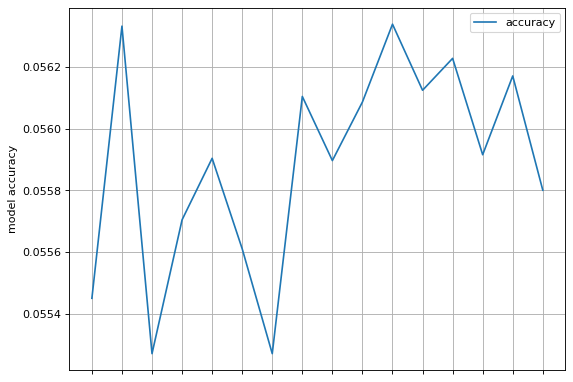

In [57]:
figure(figsize=(8, 6), dpi=80)

plt.axes(ylabel='model accuracy')
plt.xticks(np.arange(len(skipped_params)), [])#, skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)[:,0]/(len(comps)*10))
#plt.plot(np.sum(scores, axis=0)[:,1]/(len(comps)*10))
#plt.plot(np.sum(scores, axis=0)[:,2]/(len(comps)*10))
plt.legend(['accuracy', 'precision', 'recall'])
#plt.legend(comps)
 ### LOG REg

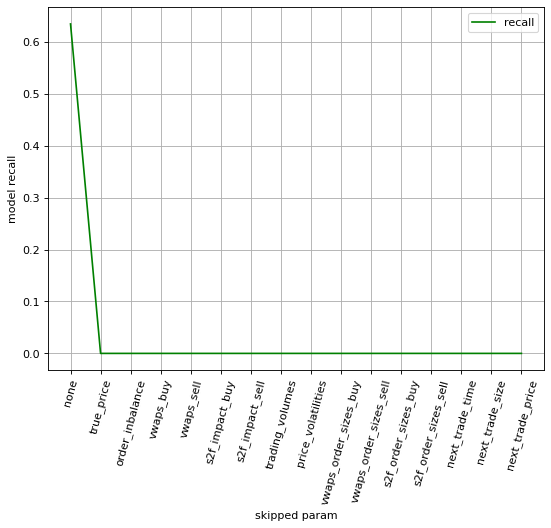

In [181]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model recall')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
#plt.plot(np.sum(scores, axis=0)[:,0]/len(comps))
#plt.plot(np.sum(scores, axis=0)[:,1]/len(comps))
plt.plot(np.sum(scores, axis=0)[:,2]/(len(comps)*10), 'g')
plt.legend(['recall'])

# models on not all features

In [179]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
threshold = 0.0012
names=[          
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
      ]
comp_scores=np.zeros((len(list_of_companies_number),10, 3)) 

In [183]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X_hold=get_X(comp_id, interval, time_to_skip, time_back, names) 
    print(X.shape)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=threshold)
    print(y.shape)
    
    for i in range(10):
        X,y=permutate_Xy(X_hold,y)
        comp_scores[comp_id,i,0], comp_scores[comp_id,i,1],comp_scores[comp_id,i,2]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names))

    #comp_scores[comp_id,0],comp_scaled[comp_id,1],comp_scaled[comp_id,2]=logistic_regr(X, y,split_percent, 
     #                                                                                  comp_id=comp_id, use_scaling=True, check_up_down=False, track_params=False, local_names=names)


0
(4750, 3)
true price at index 9,479 was zero!
(4750,)
0
Coefficient impact:
order_inbalance   -1.1052402290153214
vwaps_buy   3.217217748909691
vwaps_sell   0.4487358337478087
[[603 347]
 [  0   0]]
1
Coefficient impact:
order_inbalance   0.03964455845123654
vwaps_buy   0.3231511548044455
vwaps_sell   -0.10983478963928002
[[560 390]
 [  0   0]]
2
Coefficient impact:
order_inbalance   -0.19133981486628038
vwaps_buy   -0.283179286009952
vwaps_sell   0.4331856177683999
[[581 369]
 [  0   0]]
3
Coefficient impact:
order_inbalance   -0.0018105767870230918
vwaps_buy   -0.3709389176745101
vwaps_sell   0.06666354521887426
[[585 363]
 [  1   1]]
4
Coefficient impact:
order_inbalance   -0.04450558618949255
vwaps_buy   -0.6249749508928135
vwaps_sell   0.25752294143634546
[[574 373]
 [  2   1]]
5
Coefficient impact:
order_inbalance   0.12454391924860099
vwaps_buy   -0.023166001220078888
vwaps_sell   -0.20631709466036124
[[594 356]
 [  0   0]]
6
Coefficient impact:
order_inbalance   0.11583731948

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


0.8073393158308638
[[ 20  19]
 [540 371]]
4
Coefficient impact:
order_inbalance   0.07441440313875765
vwaps_buy   0.9127896307650479
vwaps_sell   0.8051368813558087
[[  0   0]
 [550 400]]
5
Coefficient impact:
order_inbalance   -0.09349480642323564
vwaps_buy   0.3301014036945788
vwaps_sell   0.8116646419211413
[[  1   1]
 [533 415]]
6
Coefficient impact:
order_inbalance   0.1650168389697767
vwaps_buy   -0.256906615770515
vwaps_sell   0.9760451514782299
[[536 414]
 [  0   0]]
7
Coefficient impact:
order_inbalance   0.1558703751735515
vwaps_buy   -0.10603764177346983
vwaps_sell   -0.2731753771724524
[[534 416]
 [  0   0]]
8
Coefficient impact:
order_inbalance   0.15520456074089614
vwaps_buy   1.0404323200675203
vwaps_sell   0.6634747474784628
[[564 386]
 [  0   0]]
9
Coefficient impact:
order_inbalance   0.05660994361640748
vwaps_buy   0.42781827800645034
vwaps_sell   0.6400468433588182
[[557 393]
 [  0   0]]
4
(4750, 3)
true price at index 9,475 was zero!
true price at index 9,476 was z

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



4
Coefficient impact:
order_inbalance   -0.008959547992077495
vwaps_buy   -0.9724299712955122
vwaps_sell   0.31669602263306773
[[586 364]
 [  0   0]]
5
Coefficient impact:
order_inbalance   0.09532694318890446
vwaps_buy   0.011881890412224486
vwaps_sell   -0.10278431871323654
[[588 362]
 [  0   0]]
6
Coefficient impact:
order_inbalance   0.024140932235854996
vwaps_buy   -0.2250434785842513
vwaps_sell   -0.35189598203288175
[[607 342]
 [  0   1]]
7
Coefficient impact:
order_inbalance   -1.0231909088564914
vwaps_buy   0.942955885410833
vwaps_sell   -0.8385772483400971
[[597 353]
 [  0   0]]
8
Coefficient impact:
order_inbalance   0.1488665793043166
vwaps_buy   0.10122794588728003
vwaps_sell   -0.5606260213085492
[[572 375]
 [  2   1]]
9
Coefficient impact:
order_inbalance   0.10384251062724228
vwaps_buy   0.4396053438755207
vwaps_sell   -0.1370335912000714
[[584 365]
 [  0   1]]
5
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.4763720909864981
vwaps_buy   0.993658315005990

(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.40731364925869284
vwaps_buy   -0.2180949447915492
vwaps_sell   0.247602028526471
[[ 84  81]
 [378 407]]
1
Coefficient impact:
order_inbalance   0.04938760191239489
vwaps_buy   0.24396731863541513
vwaps_sell   -0.04602847622777289
[[  5   2]
 [460 483]]
2
Coefficient impact:
order_inbalance   -0.04283479090584174
vwaps_buy   0.1043097673905517
vwaps_sell   -0.5913154683809604
[[  0   0]
 [460 490]]
3
Coefficient impact:
order_inbalance   0.40267266218114806
vwaps_buy   -0.2381329717238826
vwaps_sell   0.24002331820334852
[[242 228]
 [220 260]]
4
Coefficient impact:
order_inbalance   -0.11167222112429051
vwaps_buy   -0.3034019600216111
vwaps_sell   0.8917215260534441
[[439 511]
 [  0   0]]
5
Coefficient impact:
order_inbalance   0.014141062149992098
vwaps_buy   -0.11394210542641878
vwaps_sell   0.8891016219483822
[[  2   4]
 [456 488]]
6
Coefficient impact:
order_inbalance   -0.14119198310200468


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


vwaps_buy   -0.0533803270669269
vwaps_sell   -0.5489317797047557
[[ 93 109]
 [376 372]]
7
Coefficient impact:
order_inbalance   0.06047213921642008
vwaps_buy   -0.30827393386318613
vwaps_sell   -0.2679498882702177
[[  0   0]
 [489 461]]
8
Coefficient impact:
order_inbalance   -0.034172218345851206
vwaps_buy   -0.3427833693781059
vwaps_sell   -0.5969864082690439
[[  0   0]
 [453 497]]
9
Coefficient impact:
order_inbalance   -0.09476137973092116
vwaps_buy   -0.15066856162304604
vwaps_sell   0.14554680251256077
[[  2   1]
 [468 479]]
11
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.052943889376207996
vwaps_buy   -0.11441055459561868
vwaps_sell   0.6765536456454394
[[616 334]
 [  0   0]]
1
Coefficient impact:
order_inbalance   0.1331787554044315
vwaps_buy   0.7092945897487537
vwaps_sell   0.9541971743831715
[[ 81  37]
 [536 296]]
2
Coefficient impact:
order_inbalance   0.01208863864474917
vwaps_buy   -0.013616105344176956
vwaps_sell   0.06244926525989656
[[630 320]
 [  0   0

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[ 16  15]
 [506 413]]
5
Coefficient impact:
order_inbalance   -0.3686693345644212
vwaps_buy   0.36629193044319946
vwaps_sell   -0.5898651857618862
[[475 422]
 [ 25  28]]
6
Coefficient impact:
order_inbalance   -0.09134063059383732
vwaps_buy   -0.6815122938538988
vwaps_sell   -0.33994559839030747
[[  0   0]
 [490 460]]
7
Coefficient impact:
order_inbalance   -0.1487359292431552
vwaps_buy   -0.751831290891872
vwaps_sell   -0.2706168389027422
[[495 453]
 [  1   1]]
8
Coefficient impact:
order_inbalance   0.05749135250513188
vwaps_buy   -1.5651374605361632
vwaps_sell   -0.6143818446119683
[[500 449]
 [  1   0]]
9
Coefficient impact:
order_inbalance   0.40006448150632545
vwaps_buy   0.18199147422733658
vwaps_sell   -0.7781350761022413
[[  0   0]
 [520 430]]
13
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   0.024726607306686098
vwaps_buy   0.6956258463216
vwaps_sell   0.17746086172119188
[[571 379]
 [  0   0]]
1
Coefficient impact:
order_inbalance   -0.00723432343875113
vwaps_buy

(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   0.283793737802457
vwaps_buy   0.2933940965688145
vwaps_sell   -0.10149452592271012
[[  0   0]
 [426 524]]
1
Coefficient impact:
order_inbalance   0.3451715990662492
vwaps_buy   0.05128045273701305
vwaps_sell   0.36134503816797986
[[ 44  34]
 [412 460]]
2
Coefficient impact:
order_inbalance   -0.28828412682453486
vwaps_buy   -0.8550516378297496
vwaps_sell   -0.5258339605534802
[[  0   0]
 [440 510]]
3
Coefficient impact:
order_inbalance   0.04448064044301491
vwaps_buy   0.2622520441348644
vwaps_sell   -0.23911055231631384
[[  1   1]
 [433 515]]
4
Coefficient impact:
order_inbalance   0.08607999058799018
vwaps_buy   -0.8065109179845958
vwaps_sell   0.23680588997254837
[[436 513]
 [  0   1]]
5
Coefficient impact:
order_inbalance   0.20572008063689362
vwaps_buy   -0.14202254573621775
vwaps_sell   -0.94191713732103
[[  0   0]
 [433 517]]
6

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
order_inbalance   -0.3830380903670435
vwaps_buy   -0.057752334157324996
vwaps_sell   0.32050079014168226
[[  0   0]
 [455 495]]
7
Coefficient impact:
order_inbalance   -0.2265172634828628
vwaps_buy   0.6129093026733096
vwaps_sell   -0.07561116299466616
[[  0   0]
 [434 516]]
8
Coefficient impact:
order_inbalance   -0.07422721950961253
vwaps_buy   0.11564995692379756
vwaps_sell   0.8122800094908126
[[328 404]
 [105 113]]
9
Coefficient impact:
order_inbalance   0.2997116155695442
vwaps_buy   -0.342673882654867
vwaps_sell   0.9668391371986326
[[  4   6]
 [430 510]]
19
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   0.2533938023291258
vwaps_buy   0.4283572662125592
vwaps_sell   0.5314420444083204
[[531 413]
 [  6   0]]
1
Coefficient impact:
order_inbalance   0.001229308510394402
vwaps_buy   -0.1329205814920672
vwaps_sell   0.22564749567114034
[[549 401]
 [  0   0]]
2
Coefficient impact:
order_inbalance   0.067450829303113
vwaps_buy   -0.05998609591493839
vwap

Coefficient impact:
order_inbalance   -0.05276445353025588
vwaps_buy   0.29245998609919055
vwaps_sell   -0.5008703567744666
[[555 395]
 [  0   0]]
4
Coefficient impact:
order_inbalance   0.1431892987415649
vwaps_buy   -0.06064052204482481
vwaps_sell   -0.013551539818597675
[[549 401]
 [  0   0]]
5
Coefficient impact:
order_inbalance   0.1361425064518633
vwaps_buy   0.04230385953855433
vwaps_sell   -0.11362646978967705
[[542 408]
 [  0   0]]
6
Coefficient impact:
order_inbalance   -0.042681317343152524
vwaps_buy   -0.18569175732816748
vwaps_sell   0.37791358418749976
[[550 400]
 [  0   0]]
7
Coefficient impact:
order_inbalance   0.04488304181988542
vwaps_buy   0.2763980661589156
vwaps_sell   -0.6531582600265593
[[182 105]
 [391 272]]
8
Coefficient impact:
order_inbalance   -0.28412856141744014
vwaps_buy   0.04070349524356127
vwaps_sell   0.19521646299411313
[[564 386]
 [  0   0]]
9
Coefficient impact:
order_inbalance   0.06630058768697254
vwaps_buy   0.5383978160602606
vwaps_sell   -0.1

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4750, 3)
true price at index 9,479 was zero!
(4750,)
0
Coefficient impact:
order_inbalance   -0.12286268760610337
vwaps_buy   1.7784626418357081
vwaps_sell   -0.6202268941080175
[[606 344]
 [  0   0]]
1
Coefficient impact:
order_inbalance   -0.3963247459555119
vwaps_buy   0.7142317608603728
vwaps_sell   -0.2649382009290941
[[581 369]
 [  0   0]]
2
Coefficient impact:
order_inbalance   0.18809464817447955
vwaps_buy   -0.039887708852649896
vwaps_sell   0.4464894260613572
[[583 367]
 [  0   0]]
3
Coefficient impact:
order_inbalance   -0.1744007708573623
vwaps_buy   -0.19453461656224255
vwaps_sell   0.5047356535745363
[[612 338]
 [  0   0]]
4
Coefficient impact:
order_inbalance   -0.07559804570912997
vwaps_buy   -0.37090969704000465
vwaps_sell   0.04631801951130216
[[595 355]
 [  0   0]]
5
Coefficient impact:
order_inbalance   0.17603704837015835
vwaps_buy   0.6574149261740343
vwaps_sell   1.566599209632515
[[589 361]
 [  0   0]]
6
Coefficient impact:
order_inbalance   0.03118979655730391

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   -0.3331100283864164
vwaps_buy   -0.06866645647856252
vwaps_sell   -0.8308996649872914
[[483 401]
 [ 32  34]]
4
Coefficient impact:
order_inbalance   -0.1287168529177644
vwaps_buy   -0.022253016398783968
vwaps_sell   0.0805437674491224
[[444 406]
 [ 42  58]]
5
Coefficient impact:
order_inbalance   0.1909060530554743
vwaps_buy   -0.25497113327793286
vwaps_sell   0.761384689727378
[[482 468]
 [  0   0]]
6
Coefficient impact:
order_inbalance   -0.021969230656262825
vwaps_buy   0.2589763487962161
vwaps_sell   0.12631436805718535
[[ 92  85]
 [414 359]]
7
Coefficient impact:
order_inbalance   -0.008385807032755046
vwaps_buy   -0.14742917068696623
vwaps_sell   0.33732945607999676
[[509 441]
 [  0   0]]
8
Coefficient impact:
order_inbalance   0.13147051558956058
vwaps_buy   -0.635970971387137
vwaps_sell   0.3472696863742923
[[481 460]
 [  4   5]]
9
Coefficient impact:
order_inbalance   -0.07752289388096135
vwaps_buy   -0.31352818052600023
vwaps_sell   0.7113779454132729
[[332

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



5
Coefficient impact:
order_inbalance   0.09099171828108772
vwaps_buy   0.2234517217126855
vwaps_sell   0.12922085378784134
[[570 380]
 [  0   0]]
6
Coefficient impact:
order_inbalance   0.45125595552570225
vwaps_buy   0.15366655024388032
vwaps_sell   -0.4595334473392495
[[117  79]
 [457 297]]
7
Coefficient impact:
order_inbalance   -0.13360923112539125
vwaps_buy   0.26280165498746644
vwaps_sell   0.37273375905837425
[[561 389]
 [  0   0]]
8
Coefficient impact:
order_inbalance   -0.08389968091901422
vwaps_buy   0.25261829814779946
vwaps_sell   -0.816435448622579
[[559 390]
 [  1   0]]
9
Coefficient impact:
order_inbalance   0.030028145610524356
vwaps_buy   0.03266401243647592
vwaps_sell   0.47558477000689414
[[575 375]
 [  0   0]]
33
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.6953538018113729
vwaps_buy   1.4566500102873914
vwaps_sell   0.6887447069613885
[[  2   0]
 [477 471]]
1
Coefficient impact:
order_inbalance   0.01833839093531361
vwaps_buy   0.18468338480253377

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   0.04719635852900438
vwaps_buy   -0.2683432632745094
vwaps_sell   0.05888653550536955
[[511 434]
 [  2   3]]
7
Coefficient impact:
order_inbalance   0.20607576201336422
vwaps_buy   -1.2863849054723253
vwaps_sell   1.6403919127132622
[[487 463]
 [  0   0]]
8
Coefficient impact:
order_inbalance   0.6458079041631726
vwaps_buy   -0.07264988682623531
vwaps_sell   -1.0570867779607591
[[217 220]
 [278 235]]
9
Coefficient impact:
order_inbalance   -0.05763005329989261
vwaps_buy   -0.06619103700651474
vwaps_sell   0.6121711713338321
[[458 425]
 [ 33  34]]
34
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   0.5949474603291893
vwaps_buy   -0.490779680219562
vwaps_sell   1.8209459171376905
[[567 379]
 [  1   3]]
1
Coefficient impact:
order_inbalance   0.0006660233113262864
vwaps_buy   0.1473954856754117
vwaps_sell   -0.21285508210257817
[[572 378]
 [  0   0]]
2
Coefficient impact:
order_inbalance   0.12059610150661182
vwaps_buy   -0.611660424626795
vwaps_sell   0.0451320

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   -0.16796089926159952
vwaps_buy   -0.20614816357962548
vwaps_sell   -0.06298892782266213
[[  4   6]
 [475 465]]
7
Coefficient impact:
order_inbalance   0.03014308664906023
vwaps_buy   0.1587995808092333
vwaps_sell   -0.9275204351235657
[[  0   0]
 [490 460]]
8
Coefficient impact:
order_inbalance   0.11880734221367985
vwaps_buy   -0.20516915100332267
vwaps_sell   0.009549086977276267
[[497 453]
 [  0   0]]
9
Coefficient impact:
order_inbalance   0.18938526325112942
vwaps_buy   -0.07611789650467918
vwaps_sell   0.20317683609281265
[[116 119]
 [390 325]]
36
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   0.4716164809957454
vwaps_buy   0.9214087388216207
vwaps_sell   0.6066412970358946
[[631 319]
 [  0   0]]
1
Coefficient impact:
order_inbalance   -0.1300897456107101
vwaps_buy   1.2688909756126305
vwaps_sell   -0.6982878340951835
[[622 328]
 [  0   0]]
2
Coefficient impact:
order_inbalance   0.06157794324466708
vwaps_buy   -0.39210842488060615
vwaps_sell   -0.45

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


  -0.20201648710275705
vwaps_buy   0.528485033193753
vwaps_sell   0.3585302125694947
[[ 52  51]
 [434 413]]
7
Coefficient impact:
order_inbalance   0.049221501139134524
vwaps_buy   -0.33981943186478
vwaps_sell   0.1150766517850507
[[  1   8]
 [511 430]]
8
Coefficient impact:
order_inbalance   -0.01573402959295568
vwaps_buy   0.03477248037436896
vwaps_sell   -0.2747947886717036
[[453 497]
 [  0   0]]
9
Coefficient impact:
order_inbalance   -0.17893445195146496
vwaps_buy   -0.308887119925871
vwaps_sell   0.5833988105055878
[[492 458]
 [  0   0]]
38
(4750, 3)
true price at index 9,474 was zero!
true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
(4750,)
0
Coefficient impact:
order_inbalance   0.3651827182532442
vwaps_buy   -1.1564818319783565
vwaps_sell   -1.970347469209491
[[628 318]
 [  1   3]]
1
Coefficient impact:
order_inbalance   0.33450044467311457
vwaps_b

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.09549347413943403
vwaps_buy   -0.9627952555273672
vwaps_sell   -0.26251116303209066
[[597 350]
 [  2   1]]
1
Coefficient impact:
order_inbalance   0.10883889090695391
vwaps_buy   0.8544077714475823
vwaps_sell   -0.7946546022885049
[[588 361]
 [  1   0]]
2
Coefficient impact:
order_inbalance   0.032320603095847965
vwaps_buy   -0.29862495065132844
vwaps_sell   0.02156857372886961
[[589 361]
 [  0   0]]
3
Coefficient impact:
order_inbalance   -0.07167365580453144
vwaps_buy   0.24427128639332582
vwaps_sell   0.168329964218705
[[577 373]
 [  0   0]]
4
Coefficient impact:
order_inbalance   0.18514007055170018
vwaps_buy   -0.5940343368495438
vwaps_sell   -0.6637516420420395
[[591 356]
 [  1   2]]
5
Coefficient impact:
order_inbalance   0.2896520649122866
vwaps_buy   0.09908029298809268
vwaps_sell   -0.33776612924444027
[[582 368]
 [  0   0]]
6
Coefficient impact:
order_inbalance   -0.11267366831144603
vwaps_buy   -0.4179849214605960

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   0.22717958914041295
vwaps_buy   0.19981354035274582
vwaps_sell   0.5073671787730908
[[611 339]
 [  0   0]]
8
Coefficient impact:
order_inbalance   0.1807144475154483
vwaps_buy   -0.3873528965160586
vwaps_sell   -0.08364903956710397
[[605 345]
 [  0   0]]
9
Coefficient impact:
order_inbalance   -0.23746389057280348
vwaps_buy   -0.12997823402042652
vwaps_sell   -0.7761436759520509
[[610 340]
 [  0   0]]
43
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   1.9689598669824147
vwaps_buy   0.7004751500060811
vwaps_sell   0.5161554926649079
[[168 110]
 [319 353]]
1
Coefficient impact:
order_inbalance   0.054114280176284585
vwaps_buy   0.11734577834028806
vwaps_sell   -0.4479740618631014
[[  0   0]
 [469 481]]
2
Coefficient impact:
order_inbalance   -0.09340269405639291
vwaps_buy   0.5811125414709324
vwaps_sell   0.3674897687413626
[[499 451]
 [  0   0]]
3
Coefficient impact:
order_inbalance   0.21622864594013352
vwaps_buy   -0.2815516804818702
vwaps_sell   0.5523498

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



6
Coefficient impact:
order_inbalance   0.27238457694500035
vwaps_buy   0.17345333082175315
vwaps_sell   0.5590508968173672
[[462 433]
 [ 29  26]]
7
Coefficient impact:
order_inbalance   0.03964961859609084
vwaps_buy   0.3603035581074517
vwaps_sell   -0.2292958305728269
[[482 467]
 [  0   1]]
8
Coefficient impact:
order_inbalance   0.17952714330850789
vwaps_buy   0.3646639179185725
vwaps_sell   -0.6402742007475622
[[  0   0]
 [491 459]]
9
Coefficient impact:
order_inbalance   -0.07394717982688913
vwaps_buy   -0.13133977099283123
vwaps_sell   -0.4856363482417955
[[  0   0]
 [483 467]]
44
(4750, 3)
true price at index 9,378 was zero!
true price at index 9,379 was zero!
true price at index 9,380 was zero!
true price at index 9,381 was zero!
true price at index 9,382 was zero!
true price at index 9,383 was zero!
true price at index 9,384 was zero!
true price at index 9,385 was zero!
true price at index 9,386 was zero!
true price at index 9,387 was zero!
true price at index 9,388 was zero!

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   0.05724544278360514
vwaps_buy   0.0028846752676211975
vwaps_sell   0.5433510803806841
[[461 489]
 [  0   0]]
5
Coefficient impact:
order_inbalance   -0.03246316446983744
vwaps_buy   -1.1424902615901316
vwaps_sell   -0.23990467563162313
[[464 466]
 [ 13   7]]
6
Coefficient impact:
order_inbalance   0.20921353620871638
vwaps_buy   0.13892410741526948
vwaps_sell   0.5385848496961779
[[  0   0]
 [454 496]]
7
Coefficient impact:
order_inbalance   -0.13291964504437417
vwaps_buy   0.4222949784676838
vwaps_sell   -0.1642596804228472
[[  0   0]
 [451 499]]
8
Coefficient impact:
order_inbalance   -0.18537604733587074
vwaps_buy   0.7110178170137915
vwaps_sell   -0.11835961330954597
[[462 488]
 [  0   0]]
9
Coefficient impact:
order_inbalance   0.11445914245258833
vwaps_buy   0.50707808212466
vwaps_sell   -0.11615542005169295
[[458 490]
 [  1   1]]
46
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -1.5133574766975804
vwaps_buy   1.08818887273646
vwaps_sell   -0.035971

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.8473549458219979
vwaps_buy   0.8742530619285456
vwaps_sell   0.6873137672451856
[[482 467]
 [  0   1]]
1
Coefficient impact:
order_inbalance   -0.06986640469775247
vwaps_buy   0.49833000017919055
vwaps_sell   -0.2139059325632451
[[528 422]
 [  0   0]]
2
Coefficient impact:
order_inbalance   0.0692134632804057
vwaps_buy   0.34395992229506317
vwaps_sell   -0.159713330512883
[[504 446]
 [  0   0]]
3
Coefficient impact:
order_inbalance   0.2295493556274863
vwaps_buy   -0.11794728603087425
vwaps_sell   0.16941205017783048
[[181 144]
 [327 298]]
4
Coefficient impact:
order_inbalance   -0.22334095545076493
vwaps_buy   0.08697353701759421
vwaps_sell   0.3504862580644856
[[459 440]
 [ 34  17]]
5
Coefficient impact:
order_inbalance   -0.007575370768654712
vwaps_buy   -0.2910249875120256
vwaps_sell   -0.206901959121768
[[502 448]
 [  0   0]]
6
Coefficient impact:
order_inbalance   0.0802812447711277
vwaps_buy   -0.1002045283041066
vwaps

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
order_inbalance   0.17686281336460558
vwaps_buy   -0.46499502368455475
vwaps_sell   0.05875433540110562
[[569 381]
 [  0   0]]
7
Coefficient impact:
order_inbalance   0.357285393231736
vwaps_buy   0.5105108354099899
vwaps_sell   -0.4378114718340291
[[  4   4]
 [546 396]]
8
Coefficient impact:
order_inbalance   0.14846611558347392
vwaps_buy   0.41621314149979777
vwaps_sell   -0.8649328343520952
[[554 395]
 [  1   0]]
9
Coefficient impact:
order_inbalance   0.23726363049346172
vwaps_buy   0.26494972530721805
vwaps_sell   0.9051261889675265
[[493 360]
 [ 58  39]]
50
(4750, 3)
true price at index 9,479 was zero!
(4750,)
0
Coefficient impact:
order_inbalance   0.8307831278524002
vwaps_buy   0.35651899819311245
vwaps_sell   0.6862674754897311
[[581 369]
 [  0   0]]
1
Coefficient impact:
order_inbalance   -0.024874255897863202
vwaps_buy   0.03775409486916386
vwaps_sell   -0.827561719657207
[[622 327]
 [  1   0]]
2
Coefficient impact:
order_inbalance   -0.09671524290977239


vwaps_sell   0.850957765169922
[[655 295]
 [  0   0]]
3
Coefficient impact:
order_inbalance   -0.05173413647975318
vwaps_buy   -0.44717894628253824
vwaps_sell   0.18086291478402683
[[665 285]
 [  0   0]]
4
Coefficient impact:
order_inbalance   -0.04316461559068264
vwaps_buy   0.16666310869611947
vwaps_sell   -0.6659034297153238
[[647 303]
 [  0   0]]
5
Coefficient impact:
order_inbalance   0.26146065555260795
vwaps_buy   -0.75013203367036
vwaps_sell   0.13312283953374518
[[669 281]
 [  0   0]]
6
Coefficient impact:
order_inbalance   0.12909527335847013
vwaps_buy   -0.10933679538243297
vwaps_sell   0.36339109496797767
[[631 319]
 [  0   0]]
7
Coefficient impact:
order_inbalance   0.13903225155161278
vwaps_buy   0.5239339513593472
vwaps_sell   -0.2024439455636749
[[632 318]
 [  0   0]]
8
Coefficient impact:
order_inbalance   -0.28862749706321505
vwaps_buy   -0.2892097516434751
vwaps_sell   0.0039177563250566766
[[643 307]
 [  0   0]]
9
Coefficient impact:
order_inbalance   -0.18966266920

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
order_inbalance   0.30484970969418096
vwaps_buy   0.9511737424029184
vwaps_sell   1.0146697430010296
[[ 25  30]
 [410 485]]
4
Coefficient impact:
order_inbalance   -0.15493187373277104
vwaps_buy   -0.7365315856795714
vwaps_sell   -0.23673442722631605
[[ 40  52]
 [395 463]]
5
Coefficient impact:
order_inbalance   -0.22216942171947848
vwaps_buy   -1.394786854673456
vwaps_sell   0.2632452420234431
[[  0   0]
 [434 516]]
6
Coefficient impact:
order_inbalance   0.04457746840515729
vwaps_buy   -0.6058078830814749
vwaps_sell   -0.05306957861820822
[[  0   0]
 [410 540]]
7
Coefficient impact:
order_inbalance   0.07042421652257626
vwaps_buy   -0.1502505430397771
vwaps_sell   -1.137746112629867
[[  0   0]
 [447 503]]
8
Coefficient impact:
order_inbalance   -0.11003425883946262
vwaps_buy   0.403568373673332
vwaps_sell   -0.1100826159374125
[[  1   1]
 [432 516]]
9
Coefficient impact:
order_inbalance   0.1153190399937829
vwaps_buy   0.08817465289000706
vwaps_sell   -0.490321210

(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   0.8067885285604728
vwaps_buy   0.5000918858072632
vwaps_sell   1.6960822036918664
[[511 414]
 [ 10  15]]
1
Coefficient impact:
order_inbalance   0.14051697709079983
vwaps_buy   -0.5083226911409506
vwaps_sell   0.12217520672527447
[[ 22  17]
 [473 438]]
2
Coefficient impact:
order_inbalance   -0.03844941987957819
vwaps_buy   -0.06142929294882453
vwaps_sell   0.02883513128611848
[[522 428]
 [  0   0]]
3
Coefficient impact:
order_inbalance   0.2882959569640253
vwaps_buy   -0.3478034017486701
vwaps_sell   -0.6531390997485946
[[494 454]
 [  2   0]]
4
Coefficient impact:
order_inbalance   -0.022334114716336877
vwaps_buy   0.25781087827990073
vwaps_sell   -0.15437434873744282
[[493 457]
 [  0   0]]
5
Coefficient impact:
order_inbalance   0.17248803116263509
vwaps_buy   0.0875539900007287
vwaps_sell   -0.23626170874381644
[[529 419]
 [  1   1]]
6
Coefficient impact:
order_inbalance   0.03124659274087854
vwaps_buy   -0.6735097753306326
v

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[651 299]
 [  0   0]]
6
Coefficient impact:
order_inbalance   0.1052785268136952
vwaps_buy   -0.3375202673612018
vwaps_sell   0.5934486388701911
[[672 278]
 [  0   0]]
7
Coefficient impact:
order_inbalance   -0.05502844366611984
vwaps_buy   -0.8318989713912037
vwaps_sell   -0.1590618270721804
[[688 262]
 [  0   0]]
8
Coefficient impact:
order_inbalance   -0.3556283730452437
vwaps_buy   0.5694235892740249
vwaps_sell   0.11901454757345947
[[662 288]
 [  0   0]]
9
Coefficient impact:
order_inbalance   0.03741363935217144
vwaps_buy   0.23282841808621335
vwaps_sell   0.05374855759153488
[[655 295]
 [  0   0]]
64
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   0.7643251202639343
vwaps_buy   0.9446826234494928
vwaps_sell   -0.010041687311529431
[[ 21  25]
 [417 487]]
1
Coefficient impact:
order_inbalance   -0.18627833961681062
vwaps_buy   0.12143833718450302
vwaps_sell   0.7440626420207398
[[  0   0]
 [473 477]]
2
Coefficient impact:
order_inbalance   -0.3261351654528604
vwaps_buy 

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   0.020804742701166085
vwaps_buy   0.2162602466486611
vwaps_sell   -0.051541080098602685
[[  0   0]
 [442 508]]
8
Coefficient impact:
order_inbalance   0.1714038452599832
vwaps_buy   -0.40734545188631915
vwaps_sell   0.9343256357585217
[[451 460]
 [ 22  17]]
9
Coefficient impact:
order_inbalance   0.023426274197610012
vwaps_buy   0.43063523652760044
vwaps_sell   -0.36685899939921446
[[ 11  13]
 [440 486]]
65
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.10660507823319999
vwaps_buy   1.6178221180010401
vwaps_sell   -1.9515677214845126
[[640 307]
 [  3   0]]
1
Coefficient impact:
order_inbalance   0.08330756803615263
vwaps_buy   0.6873136845822534
vwaps_sell   0.09070240019058123
[[608 342]
 [  0   0]]
2
Coefficient impact:
order_inbalance   0.318464985227873
vwaps_buy   0.8544125137282162
vwaps_sell   0.4521245262903277
[[635 315]
 [  0   0]]
3
Coefficient impact:
order_inbalance   -0.11442628291798895
vwaps_buy   0.01593265147264827
vwaps_sell   0.403828

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   -0.07790721367993247
vwaps_buy   0.03993744522458441
vwaps_sell   0.1818194990634998
[[  2   0]
 [430 518]]
6
Coefficient impact:
order_inbalance   0.09549817586064702
vwaps_buy   -0.20914760820436162
vwaps_sell   0.4412850916169067
[[  5   8]
 [417 520]]
7
Coefficient impact:
order_inbalance   -0.18632772691879926
vwaps_buy   -0.7003739416230101
vwaps_sell   0.18926634439526233
[[  0   2]
 [414 534]]
8
Coefficient impact:
order_inbalance   -0.18001146528170192
vwaps_buy   0.5560619541398435
vwaps_sell   0.03126205983906594
[[  1   0]
 [450 499]]
9
Coefficient impact:
order_inbalance   -0.12922361727379714
vwaps_buy   -0.2655716197117104
vwaps_sell   -0.41578787601360995
[[  0   0]
 [402 548]]
68
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   1.1601556691518908
vwaps_buy   1.9863390703258084
vwaps_sell   1.13398991261103
[[256 180]
 [260 254]]
1
Coefficient impact:
order_inbalance   0.14271296090309255
vwaps_buy   -0.24132991842833804
vwaps_sell   -0.07057

(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.5992054225284189
vwaps_buy   1.107469865166582
vwaps_sell   0.6137004905485555
[[615 335]
 [  0   0]]
1
Coefficient impact:
order_inbalance   0.33352853747568195
vwaps_buy   0.13139604785778847
vwaps_sell   -0.32473154901879325
[[624 326]
 [  0   0]]
2
Coefficient impact:
order_inbalance   0.008811813116703348
vwaps_buy   0.8742520239225589
vwaps_sell   0.20437781959442905
[[621 329]
 [  0   0]]
3
Coefficient impact:
order_inbalance   -0.31176527310546104
vwaps_buy   0.15379600659656692
vwaps_sell   -0.16824713275501793
[[632 318]
 [  0   0]]
4
Coefficient impact:
order_inbalance   0.11216288160370684
vwaps_buy   -0.20011278159440474
vwaps_sell   0.21585494893717344
[[631 319]
 [  0   0]]
5
Coefficient impact:
order_inbalance   -0.13180211757715785
vwaps_buy   -0.02700175261797953
vwaps_sell   0.3842833647077287
[[633 317]
 [  0   0]]
6
Coefficient impact:
order_inbalance   -0.1513633487310392
vwaps_buy   0.05104670311958476


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "



6
Coefficient impact:
order_inbalance   -0.03212951246066064
vwaps_buy   -0.47442622220075475
vwaps_sell   -0.1574743055500989
[[670 280]
 [  0   0]]
7
Coefficient impact:
order_inbalance   -0.3205209165172761
vwaps_buy   -0.056635609344696206
vwaps_sell   -0.5463346743540897
[[684 266]
 [  0   0]]
8
Coefficient impact:
order_inbalance   -0.01852154771706027
vwaps_buy   0.20858492258013098
vwaps_sell   -0.5353079119402622
[[662 288]
 [  0   0]]
9
Coefficient impact:
order_inbalance   0.07689685278200033
vwaps_buy   0.1529899578476621
vwaps_sell   0.3669223048040655
[[679 271]
 [  0   0]]
76
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.17740328201599462
vwaps_buy   0.07843848894500141
vwaps_sell   -0.5548541202151902
[[599 351]
 [  0   0]]
1
Coefficient impact:
order_inbalance   0.01267420549202103
vwaps_buy   0.08970264285510564
vwaps_sell   0.05622921317356876
[[615 335]
 [  0   0]]
2
Coefficient impact:
order_inbalance   -0.06995640786421853
vwaps_buy   0.00398853277

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   -0.4021847638358075
vwaps_buy   -0.9444997783043226
vwaps_sell   0.8210739906507664
[[  0   0]
 [481 469]]
3
Coefficient impact:
order_inbalance   -0.30773577452244455
vwaps_buy   -0.041812359272207895
vwaps_sell   0.49165823337078524
[[381 382]
 [ 91  96]]
4
Coefficient impact:
order_inbalance   0.1223540324701125
vwaps_buy   0.46952032921084264
vwaps_sell   0.6353058892825594
[[482 468]
 [  0   0]]
5
Coefficient impact:
order_inbalance   -0.07035754095332927
vwaps_buy   -0.22506975982560468
vwaps_sell   0.560424721953353
[[474 476]
 [  0   0]]
6
Coefficient impact:
order_inbalance   -0.011142518271736637
vwaps_buy   -0.11105497133105427
vwaps_sell   0.035393156188346334
[[468 474]
 [  5   3]]
7
Coefficient impact:
order_inbalance   -0.05711382266660152
vwaps_buy   0.4830928653457177
vwaps_sell   -0.38150703177260525
[[476 470]
 [  2   2]]
8
Coefficient impact:
order_inbalance   -0.07819821954333077
vwaps_buy   0.4706583117744324
vwaps_sell   0.5757559193541544
[[47

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   -0.6895305548895299
vwaps_buy   0.7849684032472479
vwaps_sell   -0.516750323176916
[[649 301]
 [  0   0]]
1
Coefficient impact:
order_inbalance   0.012061963930462072
vwaps_buy   -0.6510236245202129
vwaps_sell   1.340741290332365
[[674 276]
 [  0   0]]
2
Coefficient impact:
order_inbalance   -0.32034817710308605
vwaps_buy   0.10953811529747365
vwaps_sell   -0.9858311261805943
[[680 270]
 [  0   0]]
3
Coefficient impact:
order_inbalance   -0.1163750450129831
vwaps_buy   0.6743662435777995
vwaps_sell   -0.14660143316042865
[[649 301]
 [  0   0]]
4
Coefficient impact:
order_inbalance   0.05821549751221844
vwaps_buy   0.2957939187547014
vwaps_sell   0.9524594865760565
[[663 287]
 [  0   0]]
5
Coefficient impact:
order_inbalance   0.39362874257258545
vwaps_buy   -0.050018469018568816
vwaps_sell   0.45919528262175285
[[670 280]
 [  0   0]]
6
Coefficient impact:
order_inbalance   -0.06963295987951872
vwaps_buy   -0.30877990924794874
vw

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



7
Coefficient impact:
order_inbalance   0.16193905147869958
vwaps_buy   0.27197085292581974
vwaps_sell   0.7881065043274443
[[518 432]
 [  0   0]]
8
Coefficient impact:
order_inbalance   -0.47397442913139065
vwaps_buy   -0.029708345760375537
vwaps_sell   -0.3516674267079959
[[509 438]
 [  2   1]]
9
Coefficient impact:
order_inbalance   0.22334813577102544
vwaps_buy   -0.32150972207177014
vwaps_sell   0.08217752858405246
[[136 139]
 [357 318]]
89
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   1.2326216336990234
vwaps_buy   0.0339951008663966
vwaps_sell   0.1491709737064331
[[463 445]
 [ 17  25]]
1
Coefficient impact:
order_inbalance   0.23200219059112057
vwaps_buy   -0.12686168162140393
vwaps_sell   -0.3304032891315957
[[232 181]
 [285 252]]
2
Coefficient impact:
order_inbalance   -0.06926786390312598
vwaps_buy   0.018599414918762044
vwaps_sell   0.26648404750975324
[[523 427]
 [  0   0]]
3
Coefficient impact:
order_inbalance   0.28979197762231396
vwaps_buy   0.1786832923617

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


-0.23357036798248368
[[  0   0]
 [485 465]]
5
Coefficient impact:
order_inbalance   0.3599165322601917
vwaps_buy   1.0699584626886693
vwaps_sell   -0.7455747258541078
[[414 398]
 [ 64  74]]
6
Coefficient impact:
order_inbalance   0.05574849610981755
vwaps_buy   0.30570490791630894
vwaps_sell   -0.17992224046643482
[[479 471]
 [  0   0]]
7
Coefficient impact:
order_inbalance   0.3155724028242341
vwaps_buy   -0.2329646093168121
vwaps_sell   0.4934796633649374
[[466 469]
 [  7   8]]
8
Coefficient impact:
order_inbalance   -0.10574652981101143
vwaps_buy   0.7559990407320748
vwaps_sell   -0.42188681952927004
[[  0   1]
 [472 477]]
9
Coefficient impact:
order_inbalance   -0.22543828658847095
vwaps_buy   -0.05934336825943316
vwaps_sell   -1.182694031010086
[[467 483]
 [  0   0]]
95
(4750, 3)
(4750,)
0
Coefficient impact:
order_inbalance   0.2849690697563238
vwaps_buy   0.8201893004002139
vwaps_sell   -1.0067151386141722
[[675 275]
 [  0   0]]
1
Coefficient impact:
order_inbalance   0.41617772

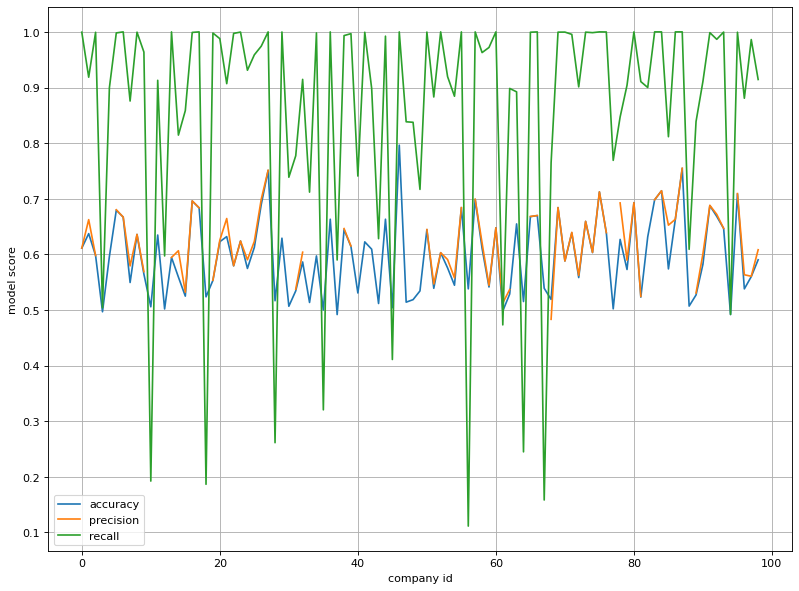

In [208]:
figure(figsize=(12, 9), dpi=80)

plt.axes(xlabel='company id', ylabel='model score')
#plt.xticks(np.arange(len(comps)), comps, rotation='75')
plt.yticks(np.arange(11)*0.1)

plt.grid()
for i in range(3):
    plt.plot(np.sum(comp_scores, axis=1)[:,i]/10)
#plt.plot(np.sum(scores_true, axis=1)[:,0]/10)
plt.legend(['accuracy', 'precision', 'recall'])
#true price only

In [211]:
arr=np.sum(comp_scores, axis=1)[:,2]
arr[arr>9.9].size

42

In [ ]:
# SCALE VS not scale

In [ ]:
comp_id=9
interval=5
time_to_skip=30
time_back=12
swing_interval=60
split_percent = 0.8
threshold=1e-3
names=[         
   # 'mid_price',
   # 'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]

In [ ]:
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)

In [ ]:
log_scale=[]
log=[]
tree_scale=[]
tree=[]
for i in range(100):
    tree_scale.append(decision_tree(X, np.copy(y),split_percent, comp_id , use_scaling=True, check_up_down=False, local_names=names))
    log_scale.append(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names))
    tree.append(decision_tree(X, np.copy(y),split_percent, comp_id, use_scaling=False, check_up_down=False, local_names=names))
    log.append(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=False, check_up_down=False, local_names=names))

In [ ]:
print("log_scale: ", np.sum(log_scale)/100)
print("log: ", np.sum(log)/100)
print("tree_scale: ", np.sum(tree_scale)/100)
print("tree: ", np.sum(tree)/100)

In [ ]:
comps=np.arange(len(list_of_companies_number))
scores=np.zeros(shape=(len(comps), 4))
for c in range(len(comps)):
    print(c)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    scores[c,0]=(decision_tree(X, np.copy(y),split_percent, comp_id , use_scaling=True, check_up_down=False, local_names=names))
    scores[c,1]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names))
    scores[c,2]=(decision_tree(X, np.copy(y),split_percent, comp_id, use_scaling=False, check_up_down=False, local_names=names))
    scores[c,3]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=False, check_up_down=False, local_names=names))

In [ ]:
figure(figsize=(24, 18), dpi=80)

plt.axes(xlabel='comp id', ylabel='model score')
plt.xticks(np.arange(len(comps)), comps, rotation='90')
plt.grid()
for c in range(4):
    plt.plot(scores[:,c])
#plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['tree_scaled', 'log_scaled', 'tree','log'])

In [ ]:
print(['tree_scaled', 'log_scaled', 'tree','log'])
print(np.sum(scores, axis=0)) 

# models only on true price

In [193]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=1
threshold=1e-3
#comp_ths=np.zeros((len(list_of_companies_number),1))

In [122]:
X=get_X(20, interval, time_to_skip, time_back, ['true_price'])
y=get_y(20, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
X,y=permutate_Xy(X,y)
logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=['true_price'])

Coefficient impact:
true_price   -1.8594986026565887
[[522 436]
 [  0   0]]


(0.5448851774530271, 0.5448851774530271, 1.0)

In [194]:
comps=np.arange(len(list_of_companies_number))
scores_true=np.zeros(shape=(len(comps), 10, 3))
for c in range(len(comps)):
    print(c)
    X=get_X(comps[c], interval, time_to_skip, time_back, ['true_price'])
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    X,y=permutate_Xy(X,y)
    for i in range(10):
        scores_true[c,i,0], scores_true[c,i,1],scores_true[c,i,2]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=['true_price']))


0
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.0935783203138842
[[403 370]
 [ 97  88]]
Coefficient impact:
true_price   -0.9736036197641516
[[500 458]
 [  0   0]]
Coefficient impact:
true_price   -1.4400340419262763
[[  0   0]
 [500 458]]
Coefficient impact:
true_price   -1.2139565561815737
[[ 20   1]
 [480 457]]
Coefficient impact:
true_price   -1.4554141309121085
[[  0   0]
 [500 458]]
Coefficient impact:
true_price   -1.2110489214258369
[[500 458]
 [  0   0]]
Coefficient impact:
true_price   -1.0018867491454186
[[500 458]
 [  0   0]]
Coefficient impact:
true_price   -1.0198737913977358
[[500 458]
 [  0   0]]
Coefficient impact:
true_price   -0.5303894407555796
[[500 458]
 [  0   0]]
Coefficient impact:
true_price   -1.0669192289682685
[[500 458]
 [  0   0]]
1


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.1755287053168355
[[595 363]
 [  0   0]]
Coefficient impact:
true_price   -1.9147793966085118
[[595 363]
 [  0   0]]
Coefficient impact:
true_price   -2.301239684566171
[[595 363]
 [  0   0]]
Coefficient impact:
true_price   -2.4400574808586524
[[595 363]
 [  0   0]]
Coefficient impact:
true_price   -2.159911240439305
[[595 363]
 [  0   0]]
Coefficient impact:
true_price   -1.9351091369974434
[[595 363]
 [  0   0]]
Coefficient impact:
true_price   -2.2914279526115924
[[595 363]
 [  0   0]]
Coefficient impact:
true_price   -2.0578188860984383
[[595 363]
 [  0   0]]
Coefficient impact:
true_price   -3.061090340315631
[[  0   0]
 [595 363]]
Coefficient impact:
true_price   -2.3518497069829314
[[595 363]
 [  0   0]]
2


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   1.081423683671111
[[  0   0]
 [486 472]]
Coefficient impact:
true_price   1.7572269331853954
[[486 472]
 [  0   0]]
Coefficient impact:
true_price   1.4049011788665893
[[  0   0]
 [486 472]]
Coefficient impact:
true_price   1.8277372188427994
[[486 472]
 [  0   0]]
Coefficient impact:
true_price   2.0704704822427287
[[486 472]
 [  0   0]]
Coefficient impact:
true_price   3.1695479671369715
[[486 472]
 [  0   0]]
Coefficient impact:
true_price   1.9117586857326356
[[486 472]
 [  0   0]]
Coefficient impact:
true_price   1.5707431844105004
[[486 472]
 [  0   0]]
Coefficient impact:
true_price   0.9336194238074288
[[  0   0]
 [486 472]]
Coefficient impact:
true_price   0.8860825941347308
[[  0   0]
 [486 472]]
3


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   0.21117812404378422
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   0.4894199424971884
[[430 528]
 [  0   0]]
Coefficient impact:
true_price   0.501578422116143
[[430 528]
 [  0   0]]
Coefficient impact:
true_price   0.4331387839758472
[[430 528]
 [  0   0]]
Coefficient impact:
true_price   0.33635826455113177
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   0.1164694988621152
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   0.27677516243949224
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   0.44118536487372967
[[430 528]
 [  0   0]]
Coefficient impact:
true_price   0.2696540943655418
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   0.38658374758134545
[[430 528]
 [  0   0]]
4


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -0.794850782726796
[[522 436]
 [  0   0]]
Coefficient impact:
true_price   -0.7595468727901532
[[522 436]
 [  0   0]]
Coefficient impact:
true_price   -1.1276155646557464
[[522 436]
 [  0   0]]
Coefficient impact:
true_price   -1.8343035509294277
[[522 436]
 [  0   0]]
Coefficient impact:
true_price   -0.7719464463136065
[[522 436]
 [  0   0]]
Coefficient impact:
true_price   -1.3412884981765436
[[522 436]
 [  0   0]]
Coefficient impact:
true_price   -1.0365384119646461
[[  0   0]
 [522 436]]
Coefficient impact:
true_price   -0.813522200948254
[[522 436]
 [  0   0]]
Coefficient impact:
true_price   -0.8098440520205447
[[522 436]
 [  0   0]]
Coefficient impact:
true_price   -0.8430705989256876
[[522 436]
 [  0   0]]

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



5
Coefficient impact:
true_price   -2.2399323223479652
[[559 399]
 [  0   0]]
Coefficient impact:
true_price   -2.7318714090446545
[[559 399]
 [  0   0]]
Coefficient impact:
true_price   -2.8273076728547912
[[559 399]
 [  0   0]]
Coefficient impact:
true_price   -1.6664708072904157
[[559 399]
 [  0   0]]
Coefficient impact:
true_price   -2.806174637506472
[[559 399]
 [  0   0]]
Coefficient impact:
true_price   -3.6237062044422954
[[  0   0]
 [559 399]]
Coefficient impact:
true_price   -3.467938059985537
[[559 399]
 [  0   0]]
Coefficient impact:
true_price   -2.6684530262400985
[[559 399]
 [  0   0]]
Coefficient impact:
true_price   -2.403976453390395
[[559 399]
 [  0   0]]
Coefficient impact:
true_price   -3.2525976639912644
[[  0   0]
 [559 399]]
6


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -3.5937156921014375
[[338 224]
 [210 186]]
Coefficient impact:
true_price   -3.613061310024775
[[548 410]
 [  0   0]]
Coefficient impact:
true_price   -3.136007057974011
[[548 410]
 [  0   0]]
Coefficient impact:
true_price   -3.983923127319852
[[174 123]
 [374 287]]
Coefficient impact:
true_price   -2.6105103583714837
[[548 410]
 [  0   0]]
Coefficient impact:
true_price   -3.061726761652667
[[548 410]
 [  0   0]]
Coefficient impact:
true_price   -2.993945112440322
[[548 410]
 [  0   0]]
Coefficient impact:
true_price   -3.752971859766417
[[  0   0]
 [548 410]]
Coefficient impact:
true_price   -3.6515477888063574
[[548 410]
 [  0   0]]
Coefficient impact:
true_price   -3.136986971027591
[[548 410]
 [  0   0]]
7


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.745320542493841
[[  0   0]
 [490 468]]
Coefficient impact:
true_price   -2.0516610348694133
[[  0   0]
 [490 468]]
Coefficient impact:
true_price   -1.775129971805604
[[490 468]
 [  0   0]]
Coefficient impact:
true_price   -2.143762436898168
[[  0   0]
 [490 468]]
Coefficient impact:
true_price   -1.820210671015226
[[490 468]
 [  0   0]]
Coefficient impact:
true_price   -1.9092175828394196
[[  0   0]
 [490 468]]
Coefficient impact:
true_price   -1.3420104837595115
[[490 468]
 [  0   0]]
Coefficient impact:
true_price   -1.1382119738843433
[[490 468]
 [  0   0]]
Coefficient impact:
true_price   -1.1484920129936533
[[490 468]
 [  0   0]]
Coefficient impact:
true_price   -1.6274290451891433
[[490 468]
 [  0   0]]
8


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.9971675369356143
[[555 403]
 [  0   0]]
Coefficient impact:
true_price   -1.376391878605425
[[  0   0]
 [555 403]]
Coefficient impact:
true_price   -1.180959855073186
[[555 403]
 [  0   0]]
Coefficient impact:
true_price   -1.0484151602277183
[[555 403]
 [  0   0]]
Coefficient impact:
true_price   -1.2131923658131867
[[  0   0]
 [555 403]]
Coefficient impact:
true_price   -0.5558525948917129
[[555 403]
 [  0   0]]
Coefficient impact:
true_price   -1.2314171674564265
[[555 403]
 [  0   0]]
Coefficient impact:
true_price   -1.1315479581723649
[[555 403]
 [  0   0]]
Coefficient impact:
true_price   -0.8692173169194313
[[555 403]
 [  0   0]]
Coefficient impact:
true_price   -1.5568231854557557
[[555 403]
 [  0   0]]
9


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.0352883880287358
[[  0   0]
 [480 478]]
Coefficient impact:
true_price   -0.6945563290254221
[[480 478]
 [  0   0]]
Coefficient impact:
true_price   -0.9957062715508913
[[  0   0]
 [480 478]]
Coefficient impact:
true_price   -0.9236754042896917
[[  0   0]
 [480 478]]
Coefficient impact:
true_price   -2.12923651636091
[[  0   0]
 [480 478]]
Coefficient impact:
true_price   -0.9226826099313277
[[  0   0]
 [480 478]]
Coefficient impact:
true_price   -0.6704152378313676
[[136 167]
 [344 311]]
Coefficient impact:
true_price   -0.5285976385273045
[[480 478]
 [  0   0]]
Coefficient impact:
true_price   -0.9872445019362113
[[  0   0]
 [480 478]]
Coefficient impact:
true_price   -1.0827021403246484
[[  0   0]
 [480 478]]
10


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -0.8078835010760032
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -1.421897302540767
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.8840268552425105
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.6189123015459973
[[440 518]
 [  0   0]]
Coefficient impact:
true_price   -0.653095364507313
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.5721252285054533
[[440 518]
 [  0   0]]
Coefficient impact:
true_price   -0.603687537260665
[[440 518]
 [  0   0]]
Coefficient impact:
true_price   -0.5515668588066981
[[440 518]
 [  0   0]]
Coefficient impact:
true_price   -0.7249928323954548
[[345 380]
 [ 95 138]]
Coefficient impact:
true_price   -0.9312569063774236
[[  0   0]
 [440 518]]
11


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.1822175510024509
[[553 405]
 [  0   0]]
Coefficient impact:
true_price   -1.900833839181141
[[  0   0]
 [553 405]]
Coefficient impact:
true_price   -1.285690916176773
[[553 405]
 [  0   0]]
Coefficient impact:
true_price   -1.3008790500737355
[[553 405]
 [  0   0]]
Coefficient impact:
true_price   -1.7230707217579095
[[553 405]
 [  0   0]]
Coefficient impact:
true_price   -1.1377983910509228
[[553 405]
 [  0   0]]
Coefficient impact:
true_price   -1.2306348699800862
[[553 405]
 [  0   0]]
Coefficient impact:
true_price   -1.6715187463389636
[[  0   0]
 [553 405]]
Coefficient impact:
true_price   -1.4618519246337875
[[257 132]
 [296 273]]
Coefficient impact:
true_price   -1.7562309509473846
[[553 405]
 [  0   0]]
12


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.4145327858853423
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.8198229350212404
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.8644796866158078
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.2960079486235351
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.5574918710447778
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.4869738001505531
[[440 518]
 [  0   0]]
Coefficient impact:
true_price   -0.6105267054413803
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -1.0361171582840611
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.721521696957638
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -0.5705876948001128
[[  0   0]
 [440 518]]
13


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -1.5689575530603055
[[402 460]
 [ 37  59]]
Coefficient impact:
true_price   -1.68460306229937
[[324 340]
 [115 179]]
Coefficient impact:
true_price   -2.055090257690668
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -2.2983780885075378
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -2.0203421772074925
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -2.2100678289390703
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -2.297591027935457
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -1.9206991388069925
[[439 519]
 [  0   0]]
Coefficient impact:
true_price   -1.8883957809655618
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -2.1867773184329673
[[439 519]
 [  0   0]]
14


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.1449263789716413
[[485 473]
 [  0   0]]
Coefficient impact:
true_price   -0.4323677877220021
[[485 473]
 [  0   0]]
Coefficient impact:
true_price   -1.1023121847625346
[[  0   0]
 [485 473]]
Coefficient impact:
true_price   -1.1306587348785557
[[  0   0]
 [485 473]]
Coefficient impact:
true_price   -1.1827069870744058
[[485 473]
 [  0   0]]
Coefficient impact:
true_price   -1.1857817960415127
[[  0   0]
 [485 473]]
Coefficient impact:
true_price   -0.9432969429641713
[[485 473]
 [  0   0]]
Coefficient impact:
true_price   -0.8340255578991178
[[485 473]
 [  0   0]]
Coefficient impact:
true_price   -0.7520713606479793
[[485 473]
 [  0   0]]
Coefficient impact:
true_price   -0.9720663681297752
[[  0   0]
 [485 473]]
15


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.40553593385865444
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.6223837197093278
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.4422923962894081
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.6383336076193217
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.21487507012227647
[[434 524]
 [  0   0]]
Coefficient impact:
true_price   -0.41794493402823674
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.39339601133391244
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.38222165360589316
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.3951008806642972
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.5670111192782189
[[  0   0]
 [434 524]]
16


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -4.17238962126396
[[588 370]
 [  0   0]]
Coefficient impact:
true_price   -3.82321139754191
[[588 370]
 [  0   0]]
Coefficient impact:
true_price   -4.1674681297548375
[[444 251]
 [144 119]]
Coefficient impact:
true_price   -4.333583640541813
[[588 369]
 [  0   1]]
Coefficient impact:
true_price   -3.6764382958670203
[[588 370]
 [  0   0]]
Coefficient impact:
true_price   -3.77318653220264
[[588 370]
 [  0   0]]
Coefficient impact:
true_price   -3.4585076982142557
[[588 370]
 [  0   0]]
Coefficient impact:
true_price   -4.242807067765247
[[540 312]
 [ 48  58]]
Coefficient impact:
true_price   -3.930556689750697
[[588 370]
 [  0   0]]
Coefficient impact:
true_price   -4.138280002715445
[[588 370]
 [  0   0]]
17
Coefficient impact:
true_price   -3.9964679248474684
[[578 380]
 [  0   0]]
Coefficient impact:
true_price   -3.834582114428911
[[578 380]
 [  0   0]]
Coefficient impact:
true_price   -4.611552043237614
[[  0   0]
 [578 380]]
Coefficient impact:
t

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.819867491912486
[[  0   0]
 [389 569]]
Coefficient impact:
true_price   -1.5758132542739554
[[  0   0]
 [389 569]]
Coefficient impact:
true_price   -1.371562306001556
[[389 569]
 [  0   0]]
Coefficient impact:
true_price   -1.563243638996158
[[389 569]
 [  0   0]]
Coefficient impact:
true_price   -1.7113235896662133
[[  0   0]
 [389 569]]
Coefficient impact:
true_price   -1.6615290549625528
[[389 569]
 [  0   0]]
Coefficient impact:
true_price   -2.3807857589359354
[[  0   0]
 [389 569]]
Coefficient impact:
true_price   -2.061276951957111
[[  0   0]
 [389 569]]
Coefficient impact:
true_price   -2.0886014753952717
[[  0   0]
 [389 569]]
Coefficient impact:
true_price   -2.6863382991002895
[[  0   0]
 [389 569]]
19


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -1.2964723818237065
[[  0   0]
 [492 466]]
Coefficient impact:
true_price   -1.2216653436677485
[[292 295]
 [200 171]]
Coefficient impact:
true_price   -0.9188209494362808
[[492 466]
 [  0   0]]
Coefficient impact:
true_price   -1.836999661927593
[[  0   0]
 [492 466]]
Coefficient impact:
true_price   -1.0982729137303011
[[492 466]
 [  0   0]]
Coefficient impact:
true_price   -1.5826283475842
[[  0   0]
 [492 466]]
Coefficient impact:
true_price   -0.7420769398934317
[[492 466]
 [  0   0]]
Coefficient impact:
true_price   -2.4337977048496935
[[  0   0]
 [492 466]]
Coefficient impact:
true_price   -1.3825282524456897
[[  0   0]
 [492 466]]
Coefficient impact:
true_price   -1.1063027961585135
[[492 466]
 [  0   0]]
20


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.821038966124588
[[520 438]
 [  0   0]]
Coefficient impact:
true_price   -1.5563524429171558
[[520 438]
 [  0   0]]
Coefficient impact:
true_price   -1.7394258734994872
[[520 438]
 [  0   0]]
Coefficient impact:
true_price   -1.7141102217203483
[[520 438]
 [  0   0]]
Coefficient impact:
true_price   -2.0228497426601844
[[  0   0]
 [520 438]]
Coefficient impact:
true_price   -1.9813026988127433
[[  0   0]
 [520 438]]
Coefficient impact:
true_price   -1.9176885167773692
[[520 438]
 [  0   0]]
Coefficient impact:
true_price   -2.2314803593872945
[[520 438]
 [  0   0]]
Coefficient impact:
true_price   -1.8230114689905295
[[520 438]
 [  0   0]]
Coefficient impact:
true_price   -2.0805509059900764
[[520 438]
 [  0   0]]
21


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -4.051122759901502
[[566 392]
 [  0   0]]
Coefficient impact:
true_price   -4.020208281493814
[[566 392]
 [  0   0]]
Coefficient impact:
true_price   -4.506545278696107
[[566 392]
 [  0   0]]
Coefficient impact:
true_price   -4.864839957658733
[[  0   0]
 [566 392]]
Coefficient impact:
true_price   -4.058251982269457
[[566 392]
 [  0   0]]
Coefficient impact:
true_price   -4.001738417476346
[[566 392]
 [  0   0]]
Coefficient impact:
true_price   -4.900564702481939
[[ 28   4]
 [538 388]]
Coefficient impact:
true_price   -4.797103334783071
[[566 392]
 [  0   0]]
Coefficient impact:
true_price   -4.316502962149882
[[566 392]
 [  0   0]]
Coefficient impact:
true_price   -4.379595611090879
[[566 392]
 [  0   0]]
22


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   2.2872629962913718
[[493 465]
 [  0   0]]
Coefficient impact:
true_price   0.7950631971297373
[[  0   0]
 [493 465]]
Coefficient impact:
true_price   1.7693814358198536
[[493 465]
 [  0   0]]
Coefficient impact:
true_price   1.337841205586609
[[  0   0]
 [493 465]]
Coefficient impact:
true_price   1.387391299144822
[[  0   0]
 [493 465]]
Coefficient impact:
true_price   1.6221460568188504
[[493 465]
 [  0   0]]
Coefficient impact:
true_price   2.4839309230340545
[[493 465]
 [  0   0]]
Coefficient impact:
true_price   1.375993248486043
[[  0   0]
 [493 465]]
Coefficient impact:
true_price   1.9675870983983377
[[493 465]
 [  0   0]]
Coefficient impact:
true_price   1.7547167002195032
[[236 212]
 [257 253]]
23


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.9473327569776465
[[494 464]
 [  0   0]]
Coefficient impact:
true_price   -0.9727346809829147
[[494 464]
 [  0   0]]
Coefficient impact:
true_price   -1.227620784742709
[[  0   0]
 [494 464]]
Coefficient impact:
true_price   -1.2661379441453988
[[  0   0]
 [494 464]]
Coefficient impact:
true_price   -1.118176750150001
[[494 464]
 [  0   0]]
Coefficient impact:
true_price   -1.3747558568213145
[[  0   0]
 [494 464]]
Coefficient impact:
true_price   -1.240290068531343
[[  0   0]
 [494 464]]
Coefficient impact:
true_price   -0.8097595397347966
[[494 464]
 [  0   0]]
Coefficient impact:
true_price   -0.9013213401251257
[[494 464]
 [  0   0]]
Coefficient impact:
true_price   -0.8423915557356778
[[494 464]
 [  0   0]]
24


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -3.0005583877669757
[[503 455]
 [  0   0]]
Coefficient impact:
true_price   -3.32976593647105
[[  0   0]
 [503 455]]
Coefficient impact:
true_price   -2.624388242056397
[[256 157]
 [247 298]]
Coefficient impact:
true_price   -3.793041832594211
[[  0   0]
 [503 455]]
Coefficient impact:
true_price   -3.6717009245948793
[[  0   0]
 [503 455]]
Coefficient impact:
true_price   -4.043505033574052
[[  0   0]
 [503 455]]
Coefficient impact:
true_price   -3.858394229360596
[[  0   0]
 [503 455]]
Coefficient impact:
true_price   -3.1787333129573256
[[334 263]
 [169 192]]
Coefficient impact:
true_price   -2.8914259419128885
[[503 455]
 [  0   0]]
Coefficient impact:
true_price   -3.3968656502093326
[[  0   0]
 [503 455]]
25


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.020281105754283
[[433 405]
 [ 55  65]]
Coefficient impact:
true_price   -2.0276375572727297
[[  0   0]
 [488 470]]
Coefficient impact:
true_price   -1.1871157837208253
[[488 470]
 [  0   0]]
Coefficient impact:
true_price   -1.7903398219693654
[[484 448]
 [  4  22]]
Coefficient impact:
true_price   -1.059659415125365
[[488 470]
 [  0   0]]
Coefficient impact:
true_price   -0.8267658929232361
[[488 470]
 [  0   0]]
Coefficient impact:
true_price   -1.3085638458735647
[[432 400]
 [ 56  70]]
Coefficient impact:
true_price   -1.234862802262966
[[488 470]
 [  0   0]]
Coefficient impact:
true_price   -1.343467383883124
[[488 470]
 [  0   0]]
Coefficient impact:
true_price   -1.0269511797420667
[[435 408]
 [ 53  62]]
26


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -2.6343210697730464
[[  0   1]
 [602 355]]
Coefficient impact:
true_price   -1.5135309318588133
[[602 356]
 [  0   0]]
Coefficient impact:
true_price   -1.8035280250619645
[[602 356]
 [  0   0]]
Coefficient impact:
true_price   -1.5852098034462923
[[602 356]
 [  0   0]]
Coefficient impact:
true_price   -1.9293742299039425
[[602 356]
 [  0   0]]
Coefficient impact:
true_price   -1.6141156369655496
[[602 356]
 [  0   0]]
Coefficient impact:
true_price   -2.370459657002362
[[  0   1]
 [602 355]]
Coefficient impact:
true_price   -1.5651629823155984
[[602 356]
 [  0   0]]
Coefficient impact:
true_price   -1.991528962241925
[[  0   1]
 [602 355]]
Coefficient impact:
true_price   -2.3541885289502886
[[  0   1]
 [602 355]]
27
Coefficient impact:
true_price   -3.2309301679578284
[[624 334]
 [  0   0]]
Coefficient impact:
true_price   -3.5071501558140716
[[624 334]
 [  0   0]]
Coefficient imp

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

true price at index 9,479 was zero!
Coefficient impact:
true_price   0.18724054235672766
[[531 427]
 [  0   0]]
Coefficient impact:
true_price   0.17666838507854762
[[531 427]
 [  0   0]]
Coefficient impact:
true_price   -0.19001405932367246
[[  0   0]
 [531 427]]
Coefficient impact:
true_price   0.13025622378379093
[[531 427]
 [  0   0]]
Coefficient impact:
true_price   -0.11523135228848264
[[531 427]
 [  0   0]]
Coefficient impact:
true_price   0.1218512478452735
[[531 427]
 [  0   0]]
Coefficient impact:
true_price   0.041539647674680893
[[531 427]
 [  0   0]]
Coefficient impact:
true_price   0.20889576618437994
[[531 427]
 [  0   0]]
Coefficient impact:
true_price   0.13235734839629287
[[531 427]
 [  0   0]]
Coefficient impact:
true_price   0.38209678102269523
[[531 427]
 [  0   0]]
30


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.4945130023906306
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.5090428303688237
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.8885346751116003
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.605721781010916
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.7317198043746994
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.10919944220788204
[[434 524]
 [  0   0]]
Coefficient impact:
true_price   -0.41135311701119004
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.8683292781919196
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -1.031734268391798
[[  0   0]
 [434 524]]
Coefficient impact:
true_price   -0.39586294752844786
[[434 524]
 [  0   0]]
31


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -1.309344646103457
[[464 494]
 [  0   0]]
Coefficient impact:
true_price   -1.6715258543475742
[[  0   0]
 [464 494]]
Coefficient impact:
true_price   -1.7351417419089867
[[  0   0]
 [464 494]]
Coefficient impact:
true_price   -1.6202778025931788
[[  0   0]
 [464 494]]
Coefficient impact:
true_price   -1.6534127405808254
[[  0   0]
 [464 494]]
Coefficient impact:
true_price   -1.326345495942244
[[464 494]
 [  0   0]]
Coefficient impact:
true_price   -1.5720804961392827
[[464 494]
 [  0   0]]
Coefficient impact:
true_price   -1.4230330053353417
[[  0   0]
 [464 494]]
Coefficient impact:
true_price   -1.5694029203509998
[[  0   0]
 [464 494]]
Coefficient impact:
true_price   -1.8247877020041945
[[  0   0]
 [464 494]]
32


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

true price at index 9,479 was zero!
Coefficient impact:
true_price   -0.017089178361010374
[[505 453]
 [  0   0]]
Coefficient impact:
true_price   -0.010954606254574173
[[505 453]
 [  0   0]]
Coefficient impact:
true_price   -0.02035862608760068
[[505 453]
 [  0   0]]
Coefficient impact:
true_price   0.011781585972648487
[[505 453]
 [  0   0]]
Coefficient impact:
true_price   0.5767740684446134
[[505 453]
 [  0   0]]
Coefficient impact:
true_price   -0.695477671901868
[[  0   0]
 [505 453]]
Coefficient impact:
true_price   -0.028826572435737132
[[  0   0]
 [505 453]]
Coefficient impact:
true_price   0.01576083350402221
[[505 453]
 [  0   0]]
Coefficient impact:
true_price   0.1556550224464167
[[505 453]
 [  0   0]]
Coefficient impact:
true_price   -0.010441627745773847
[[505 453]
 [  0   0]]
33


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.6483548884770118
[[  0   0]
 [437 521]]
Coefficient impact:
true_price   -1.5182885477446832
[[  0   0]
 [437 521]]
Coefficient impact:
true_price   -1.440109160127613
[[  0   0]
 [437 521]]
Coefficient impact:
true_price   -1.2203420286244209
[[437 521]
 [  0   0]]
Coefficient impact:
true_price   -1.8073596980868476
[[  0   0]
 [437 521]]
Coefficient impact:
true_price   -2.0325941772830745
[[  0   0]
 [437 521]]
Coefficient impact:
true_price   -1.1957106756802005
[[437 521]
 [  0   0]]
Coefficient impact:
true_price   -1.5607941891826185
[[  0   0]
 [437 521]]
Coefficient impact:
true_price   -1.3862605215582935
[[  0   0]
 [437 521]]
Coefficient impact:
true_price   -1.6303814301344708
[[  0   0]
 [437 521]]
34


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -1.834541992632534
[[509 449]
 [  0   0]]
Coefficient impact:
true_price   -2.2749295769450346
[[  0   0]
 [509 449]]
Coefficient impact:
true_price   -1.8289095137964613
[[  0   0]
 [509 449]]
Coefficient impact:
true_price   -2.174594839354667
[[211 172]
 [298 277]]
Coefficient impact:
true_price   -2.2254919362363323
[[  0   0]
 [509 449]]
Coefficient impact:
true_price   -2.877349331658813
[[  0   0]
 [509 449]]
Coefficient impact:
true_price   -2.145507978010081
[[  0   0]
 [509 449]]
Coefficient impact:
true_price   -1.6574900344914767
[[509 449]
 [  0   0]]
Coefficient impact:
true_price   -2.192182349009592
[[  0   0]
 [509 449]]
Coefficient impact:
true_price   -1.8102356304913667
[[509 449]
 [  0   0]]
35


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.897131364962779
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -1.1065854709112615
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -0.7147045167982972
[[428 530]
 [  0   0]]
Coefficient impact:
true_price   -1.1853164392520381
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -0.9835851443635021
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -0.8099117163031284
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -0.9829742663675337
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -0.5475537524331388
[[428 530]
 [  0   0]]
Coefficient impact:
true_price   -0.30579365026547717
[[428 530]
 [  0   0]]
Coefficient impact:
true_price   -0.9523537571330191
[[  0   0]
 [428 530]]
36


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -1.5666028982125115
[[573 385]
 [  0   0]]
Coefficient impact:
true_price   -1.457469519708539
[[573 385]
 [  0   0]]
Coefficient impact:
true_price   -1.2797275753649326
[[573 385]
 [  0   0]]
Coefficient impact:
true_price   -1.1261343710851506
[[573 385]
 [  0   0]]
Coefficient impact:
true_price   -1.2609109419553866
[[573 385]
 [  0   0]]
Coefficient impact:
true_price   -1.2727801175325693
[[573 385]
 [  0   0]]
Coefficient impact:
true_price   -0.9068899810752584
[[573 385]
 [  0   0]]
Coefficient impact:
true_price   -1.6240300269853456
[[  0   0]
 [573 385]]
Coefficient impact:
true_price   -1.7919046181608882
[[573 385]
 [  0   0]]
Coefficient impact:
true_price   -2.0310205458542128
[[258 143]
 [315 242]]
37


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.7364559913383846
[[  0   0]
 [425 533]]
Coefficient impact:
true_price   -2.427791179011911
[[  0   0]
 [425 533]]
Coefficient impact:
true_price   -1.9818495888550127
[[425 533]
 [  0   0]]
Coefficient impact:
true_price   -1.5295980570171397
[[425 533]
 [  0   0]]
Coefficient impact:
true_price   -2.5007672072851297
[[  0   0]
 [425 533]]
Coefficient impact:
true_price   -1.8636240559626593
[[  0   0]
 [425 533]]
Coefficient impact:
true_price   -3.2386779436417363
[[  0   0]
 [425 533]]
Coefficient impact:
true_price   -1.8771064209300043
[[425 533]
 [  0   0]]
Coefficient impact:
true_price   -2.0866003847460486
[[279 305]
 [146 228]]
Coefficient impact:
true_price   -2.0717658569109467
[[  0   0]
 [425 533]]
38


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,474 was zero!
true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   0.708106344328287
[[512 446]
 [  0   0]]
Coefficient impact:
true_price   0.32859002450985614
[[  0   0]
 [512 446]]
Coefficient impact:
true_price   0.8973945021558709
[[512 446]
 [  0   0]]
Coefficient impact:
true_price   0.5441884827469562
[[512 446]
 [  0   0]]
Coefficient impact:
true_price   0.6406729257819328
[[512 446]
 [  0   0]]
Coefficient impact:
true_price   0.6912240975337997
[[512 446]
 [  0   0]]
Coefficient impact:
true_price   1.2993722928317324
[[512 446]
 [  0   0]]
Coefficient impact:
true_price   0.5630596573714123
[[512 446]
 [  0   0]]
Coefficient impact:
true_price   0.7315830433251911
[[512 446]
 [  0   0]]
Coefficient impact:
true_price   1.0868020090718031
[[  0   0]
 [512 446]]
39


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -2.3596366751035167
[[511 446]
 [  0   1]]
Coefficient impact:
true_price   -1.611168714903949
[[511 447]
 [  0   0]]
Coefficient impact:
true_price   -1.461140736232947
[[511 447]
 [  0   0]]
Coefficient impact:
true_price   -2.0601930951237075
[[  0   0]
 [511 447]]
Coefficient impact:
true_price   -2.44965130438495
[[  0   0]
 [511 447]]
Coefficient impact:
true_price   -2.041254838621085
[[127  92]
 [384 355]]
Coefficient impact:
true_price   -2.575198551543223
[[  0   0]
 [511 447]]
Coefficient impact:
true_price   -2.034946119816374
[[  0   0]
 [511 447]]
Coefficient impact:
true_price   -1.2555375202006036
[[511 447]
 [  0   0]]
Coefficient impact:
true_price   -2.276994591104267
[[  0   0]
 [511 447]]
40


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,479 was zero!
Coefficient impact:
true_price   -0.6963192648238947
[[490 468]
 [  0   0]]
Coefficient impact:
true_price   -0.910453508540525
[[  0   0]
 [490 468]]
Coefficient impact:
true_price   -0.8073382524746021
[[490 468]
 [  0   0]]
Coefficient impact:
true_price   -1.3631530630631443
[[  0   0]
 [490 468]]
Coefficient impact:
true_price   -0.6230659331431095
[[490 468]
 [  0   0]]
Coefficient impact:
true_price   -0.9047194459906249
[[  0   0]
 [490 468]]
Coefficient impact:
true_price   -0.7121561044807291
[[  0   0]
 [490 468]]
Coefficient impact:
true_price   -0.8297049459382838
[[  0   0]
 [490 468]]
Coefficient impact:
true_price   -0.7359910504785626
[[490 468]
 [  0   0]]
Coefficient impact:
true_price   -0.5342156516859665
[[490 468]
 [  0   0]]
41


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.784138036289017
[[194 122]
 [355 287]]
Coefficient impact:
true_price   -2.7613936923568
[[549 409]
 [  0   0]]
Coefficient impact:
true_price   -3.721222222500668
[[549 409]
 [  0   0]]
Coefficient impact:
true_price   -2.457715668525034
[[549 409]
 [  0   0]]
Coefficient impact:
true_price   -3.030137312344751
[[549 409]
 [  0   0]]
Coefficient impact:
true_price   -2.6450245074559344
[[549 409]
 [  0   0]]
Coefficient impact:
true_price   -2.458215454336844
[[549 409]
 [  0   0]]
Coefficient impact:
true_price   -3.3018321670584143
[[385 248]
 [164 161]]
Coefficient impact:
true_price   -2.6307531723287223
[[549 409]
 [  0   0]]
Coefficient impact:
true_price   -3.691879376717923
[[  0   0]
 [549 409]]
42


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.3773951750844922
[[525 433]
 [  0   0]]
Coefficient impact:
true_price   -1.8243861540271749
[[  0   0]
 [525 433]]
Coefficient impact:
true_price   -2.1894475253496846
[[  0   0]
 [525 433]]
Coefficient impact:
true_price   -2.125713282401215
[[  0   0]
 [525 433]]
Coefficient impact:
true_price   -1.692342170076159
[[525 433]
 [  0   0]]
Coefficient impact:
true_price   -2.188716285339161
[[  0   0]
 [525 433]]
Coefficient impact:
true_price   -1.1543069739092784
[[525 433]
 [  0   0]]
Coefficient impact:
true_price   -1.5346442417157116
[[525 433]
 [  0   0]]
Coefficient impact:
true_price   -2.319172015592288
[[  0   0]
 [525 433]]
Coefficient impact:
true_price   -1.2211924206547984
[[525 433]
 [  0   0]]
43


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.7643143508632722
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -1.0059091574670727
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -1.0394798889068655
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -1.6206838039527236
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -1.3594103435219766
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -1.3333162819671085
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -1.500001599903224
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -1.8117195214217647
[[  0   0]
 [428 530]]
Coefficient impact:
true_price   -1.3416231328795636
[[428 530]
 [  0   0]]
Coefficient impact:
true_price   -1.4048338741552024
[[  0   0]
 [428 530]]
44


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

true price at index 9,378 was zero!
true price at index 9,379 was zero!
true price at index 9,380 was zero!
true price at index 9,381 was zero!
true price at index 9,382 was zero!
true price at index 9,383 was zero!
true price at index 9,384 was zero!
true price at index 9,385 was zero!
true price at index 9,386 was zero!
true price at index 9,387 was zero!
true price at index 9,388 was zero!
true price at index 9,389 was zero!
true price at index 9,390 was zero!
true price at index 9,391 was zero!
true price at index 9,392 was zero!
true price at index 9,393 was zero!
true price at index 9,394 was zero!
true price at index 9,395 was zero!
true price at index 9,396 was zero!
true price at index 9,397 was zero!
true price at index 9,398 was zero!
true price at index 9,399 was zero!
true price at index 9,400 was zero!
true price at index 9,401 was zero!
true price at index 9,402 was zero!
true price at index 9,403 was zero!
true price at index 9,404 was zero!
true price at index 9,405 wa

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -3.5830437801572375
[[  0   0]
 [403 555]]
Coefficient impact:
true_price   -3.3278176071360095
[[  0   0]
 [403 555]]
Coefficient impact:
true_price   -2.905566156299146
[[403 555]
 [  0   0]]
Coefficient impact:
true_price   -3.6746619055038843
[[  0   0]
 [403 555]]
Coefficient impact:
true_price   -4.451101384499176
[[  0   0]
 [403 555]]
Coefficient impact:
true_price   -3.122656991207419
[[  0   0]
 [403 555]]
Coefficient impact:
true_price   -3.6622754632637804
[[  0   0]
 [403 555]]
Coefficient impact:
true_price   -3.274642304318561
[[403 555]
 [  0   0]]
Coefficient impact:
true_price   -3.646364290352289
[[  0   0]
 [403 555]]
Coefficient impact:
true_price   -3.6697266940050675
[[  0   0]
 [403 555]]
46


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -1.9007201301004744
[[708 250]
 [  0   0]]
Coefficient impact:
true_price   -2.072461912093221
[[708 250]
 [  0   0]]
Coefficient impact:
true_price   -2.0137036680620692
[[708 250]
 [  0   0]]
Coefficient impact:
true_price   -2.233600163817007
[[708 250]
 [  0   0]]
Coefficient impact:
true_price   -2.023613494700138
[[708 250]
 [  0   0]]
Coefficient impact:
true_price   -2.7966633012048123
[[708 250]
 [  0   0]]
Coefficient impact:
true_price   -1.7055514530186424
[[708 250]
 [  0   0]]
Coefficient impact:
true_price   -2.1434147336617873
[[708 250]
 [  0   0]]
Coefficient impact:
true_price   -2.3360369927112017
[[708 250]
 [  0   0]]
Coefficient impact:
true_price   -1.291381870802616
[[708 250]
 [  0   0]]
47
Coefficient impact:
true_price   -1.2924151490240596
[[  0   0]
 [413 545]]
Coefficient impact:
true_price   -1.0627916545882163
[[  0   0]
 [413 545]]
Coefficient impact:
true_price   -0.8328492386148312
[[413 545]
 [  0   0]]
Coefficient i

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.619345877149615
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -1.88260683447469
[[439 519]
 [  0   0]]
Coefficient impact:
true_price   -1.79400554278074
[[439 519]
 [  0   0]]
Coefficient impact:
true_price   -2.1569234022480233
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -1.3856241736783792
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -2.0129570627022724
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -1.6931872811594029
[[  0   0]
 [439 519]]
Coefficient impact:
true_price   -1.8341954560650608
[[439 519]
 [  0   0]]
Coefficient impact:
true_price   -1.362438137553146
[[439 519]
 [  0   0]]
Coefficient impact:
true_price   -1.4457401267469407
[[439 519]
 [  0   0]]
49


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.3851423025063236
[[454 438]
 [ 15  51]]
Coefficient impact:
true_price   -1.1943571356439684
[[328 290]
 [141 199]]
Coefficient impact:
true_price   -1.7273638486345702
[[  0   0]
 [469 489]]
Coefficient impact:
true_price   -1.3614225743880504
[[  0   0]
 [469 489]]
Coefficient impact:
true_price   -0.8690806118990226
[[469 489]
 [  0   0]]
Coefficient impact:
true_price   -1.5089428656436417
[[  0   0]
 [469 489]]
Coefficient impact:
true_price   -2.2779528555801845
[[  0   0]
 [469 489]]
Coefficient impact:
true_price   -0.8281783146941614
[[469 489]
 [  0   0]]
Coefficient impact:
true_price   -1.2756808097623114
[[  0   0]
 [469 489]]
Coefficient impact:
true_price   -1.183528938661745
[[468 482]
 [  1   7]]
50


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.636317080515111
[[  0   0]
 [557 401]]
Coefficient impact:
true_price   -1.2052429902194997
[[557 401]
 [  0   0]]
Coefficient impact:
true_price   -1.0034164747379752
[[557 401]
 [  0   0]]
Coefficient impact:
true_price   -0.8486783815196003
[[557 401]
 [  0   0]]
Coefficient impact:
true_price   -2.979861656080487
[[  0   0]
 [557 401]]
Coefficient impact:
true_price   -1.2889942022758478
[[557 401]
 [  0   0]]
Coefficient impact:
true_price   -1.761710148589044
[[557 401]
 [  0   0]]
Coefficient impact:
true_price   -1.2875720033500937
[[557 401]
 [  0   0]]
Coefficient impact:
true_price   -1.262957800768042
[[557 401]
 [  0   0]]
Coefficient impact:
true_price   -2.1891289343922784
[[  0   0]
 [557 401]]
51


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.26877887877507
[[  0   0]
 [447 511]]
Coefficient impact:
true_price   -2.6573180489979134
[[447 511]
 [  0   0]]
Coefficient impact:
true_price   -2.3689748955685
[[447 511]
 [  0   0]]
Coefficient impact:
true_price   -2.668586349750981
[[442 502]
 [  5   9]]
Coefficient impact:
true_price   -3.5455954216358676
[[  0   0]
 [447 511]]
Coefficient impact:
true_price   -2.50985308648514
[[  0   0]
 [447 511]]
Coefficient impact:
true_price   -2.5385561018227034
[[447 511]
 [  0   0]]
Coefficient impact:
true_price   -2.4608835601346684
[[  0   0]
 [447 511]]
Coefficient impact:
true_price   -1.7456113649492548
[[447 511]
 [  0   0]]
Coefficient impact:
true_price   -2.277823378819692
[[447 511]
 [  0   0]]
52


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -4.349818012533454
[[507 451]
 [  0   0]]
Coefficient impact:
true_price   -3.6105157152004863
[[507 451]
 [  0   0]]
Coefficient impact:
true_price   -4.854565818293633
[[  0   0]
 [507 451]]
Coefficient impact:
true_price   -3.526378884119883
[[448 382]
 [ 59  69]]
Coefficient impact:
true_price   -3.032238370404919
[[507 451]
 [  0   0]]
Coefficient impact:
true_price   -3.9177974286526314
[[  0   0]
 [507 451]]
Coefficient impact:
true_price   -3.015654345896338
[[507 451]
 [  0   0]]
Coefficient impact:
true_price   -3.990666749796423
[[ 30  36]
 [477 415]]
Coefficient impact:
true_price   -3.9582547048907335
[[475 408]
 [ 32  43]]
Coefficient impact:
true_price   -3.634550988633619
[[  0   0]
 [507 451]]
53


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.3336998134714404
[[484 474]
 [  0   0]]
Coefficient impact:
true_price   -1.8735031168128076
[[484 474]
 [  0   0]]
Coefficient impact:
true_price   -1.856012968643153
[[484 474]
 [  0   0]]
Coefficient impact:
true_price   -1.7946210438717687
[[484 474]
 [  0   0]]
Coefficient impact:
true_price   -1.8002959097085014
[[  0   0]
 [484 474]]
Coefficient impact:
true_price   -1.3740944005297884
[[484 474]
 [  0   0]]
Coefficient impact:
true_price   -1.6659419711193717
[[484 474]
 [  0   0]]
Coefficient impact:
true_price   -1.9919777861733392
[[ 86  73]
 [398 401]]
Coefficient impact:
true_price   -2.300231156689006
[[  0   0]
 [484 474]]
Coefficient impact:
true_price   -1.9449686229714578
[[469 427]
 [ 15  47]]
54


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.7640681774788106
[[479 479]
 [  0   0]]
Coefficient impact:
true_price   -0.7508639982644394
[[479 479]
 [  0   0]]
Coefficient impact:
true_price   -0.8303024372444789
[[  0   0]
 [479 479]]
Coefficient impact:
true_price   -1.0295008597855826
[[  0   0]
 [479 479]]
Coefficient impact:
true_price   -0.5152031137456227
[[479 479]
 [  0   0]]
Coefficient impact:
true_price   -0.7656057436124828
[[479 479]
 [  0   0]]
Coefficient impact:
true_price   -1.2914794636801796
[[  0   0]
 [479 479]]
Coefficient impact:
true_price   -1.2065823830134168
[[  0   0]
 [479 479]]
Coefficient impact:
true_price   -1.1247796915101806
[[  0   0]
 [479 479]]
Coefficient impact:
true_price   -1.135689856592859
[[  0   0]
 [479 479]]
55


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -5.882437070235269
[[561 397]
 [  0   0]]
Coefficient impact:
true_price   -5.215053734858577
[[  3   0]
 [558 397]]
Coefficient impact:
true_price   -4.887646072058671
[[561 397]
 [  0   0]]
Coefficient impact:
true_price   -6.178542814412944
[[  0   0]
 [561 397]]
Coefficient impact:
true_price   -3.7451248385541605
[[561 397]
 [  0   0]]
Coefficient impact:
true_price   -4.730397970917201
[[561 397]
 [  0   0]]
Coefficient impact:
true_price   -4.602567385888318
[[561 397]
 [  0   0]]
Coefficient impact:
true_price   -4.998536560978222
[[561 397]
 [  0   0]]
Coefficient impact:
true_price   -5.041251010775618
[[561 397]
 [  0   0]]
Coefficient impact:
true_price   -5.102425548139575
[[  1   0]
 [560 397]]
56


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.7071819748610506
[[387 571]
 [  0   0]]
Coefficient impact:
true_price   -0.9430997922373973
[[  0   0]
 [387 571]]
Coefficient impact:
true_price   -1.0871582331486696
[[  0   0]
 [387 571]]
Coefficient impact:
true_price   -1.243399188344368
[[  0   0]
 [387 571]]
Coefficient impact:
true_price   -0.9536994892162922
[[  0   0]
 [387 571]]
Coefficient impact:
true_price   -0.7998016892157803
[[387 571]
 [  0   0]]
Coefficient impact:
true_price   -1.1825919966493967
[[  0   0]
 [387 571]]
Coefficient impact:
true_price   -1.6225289436034984
[[  0   0]
 [387 571]]
Coefficient impact:
true_price   -1.002480446076861
[[  0   0]
 [387 571]]
Coefficient impact:
true_price   -1.1327148332846435
[[  0   0]
 [387 571]]
57


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -0.614568420300222
[[615 343]
 [  0   0]]
Coefficient impact:
true_price   -0.7220193458370405
[[615 343]
 [  0   0]]
Coefficient impact:
true_price   -0.5968651055758757
[[615 343]
 [  0   0]]
Coefficient impact:
true_price   -0.837468612421668
[[615 343]
 [  0   0]]
Coefficient impact:
true_price   -0.5922868583438026
[[615 343]
 [  0   0]]
Coefficient impact:
true_price   -0.7897894348502252
[[615 343]
 [  0   0]]
Coefficient impact:
true_price   -0.35666310758809705
[[615 343]
 [  0   0]]
Coefficient impact:
true_price   -0.8809168857735343
[[615 343]
 [  0   0]]
Coefficient impact:
true_price   -0.5403963295495535
[[615 343]
 [  0   0]]
Coefficient impact:
true_price   -1.0735779503251397
[[615 343]
 [  0   0]]
58
Coefficient impact:
true_price   -3.1006050501095728
[[  0   0]
 [509 449]]
Coefficient impact:
true_price   -2.737608724647706
[[  0   0]
 [509 449]]
Coefficient impact:
true_price   -2.6427925485055583
[[  0   0]
 [509 449]]
Coefficient

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.7172127022555923
[[  0   0]
 [462 496]]
Coefficient impact:
true_price   -2.4599615110019126
[[  0   0]
 [462 496]]
Coefficient impact:
true_price   -0.8664884321469156
[[462 496]
 [  0   0]]
Coefficient impact:
true_price   -2.318677303396077
[[  0   0]
 [462 496]]
Coefficient impact:
true_price   -2.224000533025155
[[  0   0]
 [462 496]]
Coefficient impact:
true_price   -2.2672435922041334
[[462 496]
 [  0   0]]
Coefficient impact:
true_price   -2.4089673889612575
[[  0   0]
 [462 496]]
Coefficient impact:
true_price   -2.3949397621692534
[[  0   0]
 [462 496]]
Coefficient impact:
true_price   -2.460060196082581
[[  0   0]
 [462 496]]
Coefficient impact:
true_price   -2.537260050272854
[[340 298]
 [122 198]]
60


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -3.7113753469193336
[[  0   0]
 [563 395]]
Coefficient impact:
true_price   -3.3446502162972247
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -3.331313089201053
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -3.192098824379729
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -3.3586560715754445
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -3.3656728482026774
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -3.3485583499936578
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -3.512660587524397
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -3.621649511963681
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -3.342297659560827
[[563 395]
 [  0   0]]
61


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.6483694993291806
[[  0   0]
 [397 561]]
Coefficient impact:
true_price   -0.1559467098231291
[[  0   0]
 [397 561]]
Coefficient impact:
true_price   -0.18465530293372523
[[  0   0]
 [397 561]]
Coefficient impact:
true_price   -0.28537863650450584
[[  0   0]
 [397 561]]
Coefficient impact:
true_price   -0.2585695084454117
[[  0   0]
 [397 561]]
Coefficient impact:
true_price   -0.12509418182424717
[[  0   0]
 [397 561]]
Coefficient impact:
true_price   -0.1898579511322038
[[  0   0]
 [397 561]]
Coefficient impact:
true_price   -0.20742308607586207
[[  0   0]
 [397 561]]
Coefficient impact:
true_price   -0.18677125340511813
[[  0   0]
 [397 561]]
Coefficient impact:
true_price   -0.17974343725555994
[[  0   0]
 [397 561]]
62


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -1.2806662191473819
[[402 481]
 [ 38  37]]
Coefficient impact:
true_price   -1.3791261158544486
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -2.4743218067747907
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -1.4381322420088631
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -1.1061911961403588
[[440 518]
 [  0   0]]
Coefficient impact:
true_price   -1.268064893569162
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -1.4061717961000828
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -1.582477575584852
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -1.4231441518215344
[[  0   0]
 [440 518]]
Coefficient impact:
true_price   -1.3932890172976213
[[  0   0]
 [440 518]]
63


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -4.1310408022951925
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -3.8632099586062134
[[248 107]
 [359 244]]
Coefficient impact:
true_price   -4.015371457551253
[[332 138]
 [275 213]]
Coefficient impact:
true_price   -4.913642027559774
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -3.767590590174578
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -4.419057295873428
[[602 349]
 [  5   2]]
Coefficient impact:
true_price   -3.9135469686738533
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -3.9001215922567987
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -4.343755962024471
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -4.1222148162762835
[[607 351]
 [  0   0]]
64
Coefficient impact:
true_price   -2.987613298563693
[[  0   0]
 [404 554]]
Coefficient impact:
true_price   -3.4231073892982065
[[  0   0]
 [404 554]]
Coefficient impact:
true_price   -2.6211079330768623
[[404 554]
 [  0   0]]
Coefficient imp

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   0.5506962315429041
[[622 336]
 [  0   0]]
Coefficient impact:
true_price   0.6255087371476586
[[622 336]
 [  0   0]]
Coefficient impact:
true_price   0.7980656767770752
[[622 336]
 [  0   0]]
Coefficient impact:
true_price   0.5029133123065703
[[622 336]
 [  0   0]]
Coefficient impact:
true_price   0.3365846897482057
[[622 336]
 [  0   0]]
Coefficient impact:
true_price   0.32120929232069145
[[622 336]
 [  0   0]]
Coefficient impact:
true_price   1.5313555564112862
[[622 336]
 [  0   0]]
Coefficient impact:
true_price   0.9358579271041109
[[622 336]
 [  0   0]]
Coefficient impact:
true_price   0.4443942918997999
[[622 336]
 [  0   0]]
Coefficient impact:
true_price   0.35882477824930614
[[622 336]
 [  0   0]]
66
Coefficient impact:
true_price   -0.7267080827887432
[[551 407]
 [  0   0]]
Coefficient impact:
true_price   -0.8971474072348271
[[551 407]
 [  0   0]]
Coefficient impact:
true_price   -0.8743456597827185
[[551 407]
 [  0   0]]
Coefficient impac

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.797001758359683
[[  0   0]
 [415 543]]
Coefficient impact:
true_price   -2.0916896498204145
[[  0   0]
 [415 543]]
Coefficient impact:
true_price   -2.747562560991197
[[  0   0]
 [415 543]]
Coefficient impact:
true_price   -2.794939546618712
[[  0   0]
 [415 543]]
Coefficient impact:
true_price   -2.434445208842993
[[  0   0]
 [415 543]]
Coefficient impact:
true_price   -2.723475520414982
[[  0   0]
 [415 543]]
Coefficient impact:
true_price   -2.407383195390302
[[  0   0]
 [415 543]]
Coefficient impact:
true_price   -2.1917384569949605
[[415 543]
 [  0   0]]
Coefficient impact:
true_price   -2.4836489611666464
[[  0   0]
 [415 543]]
Coefficient impact:
true_price   -2.507670910606424
[[  0   0]
 [415 543]]
68


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -0.1912054050864345
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   -0.19794873338999053
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   -0.28816838030055897
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   -0.2448278361390412
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   -0.1866604711479513
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   -0.25913328060407087
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   -0.11342287236391928
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   -0.15749682069135748
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   -0.2466782092532034
[[  0   0]
 [430 528]]
Coefficient impact:
true_price   -0.2331231875585556
[[  0   0]
 [430 528]]
69


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -0.759890430797452
[[617 341]
 [  0   0]]
Coefficient impact:
true_price   -1.0899795464234148
[[617 341]
 [  0   0]]
Coefficient impact:
true_price   -1.5836426889352557
[[617 341]
 [  0   0]]
Coefficient impact:
true_price   -0.7553451950246702
[[617 341]
 [  0   0]]
Coefficient impact:
true_price   -0.8331047612959107
[[617 341]
 [  0   0]]
Coefficient impact:
true_price   -0.8332419663919616
[[617 341]
 [  0   0]]
Coefficient impact:
true_price   -0.8192579514422148
[[617 341]
 [  0   0]]
Coefficient impact:
true_price   -0.8695666080961738
[[617 341]
 [  0   0]]
Coefficient impact:
true_price   -2.278275366216557
[[  0   0]
 [617 341]]
Coefficient impact:
true_price   -0.9790160879695544
[[617 341]
 [  0   0]]
70


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   0.7545281880918472
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   0.6418878722123073
[[378 369]
 [ 92 119]]
Coefficient impact:
true_price   0.8161195166054767
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   0.7189748761836384
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   0.7757289800139457
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   1.1790896419005814
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   0.6232138122807824
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   0.9443867800099897
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   1.037756058585203
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   0.8804376317994383
[[470 488]
 [  0   0]]
71
Coefficient impact:
true_price   -5.299027274142343
[[  0   0]
 [560 398]]
Coefficient impact:
true_price   -5.040389048733692
[[  0   0]
 [560 398]]
Coefficient impact:
true_price   -4.105205398673483
[[560 398]
 [  0   0]]
Coefficient impact:
tru

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -3.3435261209571694
[[168 112]
 [330 348]]
Coefficient impact:
true_price   -3.205331220676311
[[223 151]
 [275 309]]
Coefficient impact:
true_price   -2.1627785008915223
[[498 460]
 [  0   0]]
Coefficient impact:
true_price   -2.709848557238235
[[498 460]
 [  0   0]]
Coefficient impact:
true_price   -3.158368026970624
[[  0   0]
 [498 460]]
Coefficient impact:
true_price   -2.550454888842122
[[498 460]
 [  0   0]]
Coefficient impact:
true_price   -3.981197895888307
[[  0   0]
 [498 460]]
Coefficient impact:
true_price   -2.6113416995264496
[[498 460]
 [  0   0]]
Coefficient impact:
true_price   -3.267200205465731
[[ 18  10]
 [480 450]]
Coefficient impact:
true_price   -3.423344973121374
[[  0   0]
 [498 460]]
73


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -4.3265101728671675
[[583 375]
 [  0   0]]
Coefficient impact:
true_price   -4.470050155254565
[[  0   0]
 [583 375]]
Coefficient impact:
true_price   -3.0794356165550196
[[583 375]
 [  0   0]]
Coefficient impact:
true_price   -5.384679541920748
[[  0   0]
 [583 375]]
Coefficient impact:
true_price   -3.6233213053185107
[[583 375]
 [  0   0]]
Coefficient impact:
true_price   -3.694290306289292
[[583 375]
 [  0   0]]
Coefficient impact:
true_price   -4.380917716924923
[[583 375]
 [  0   0]]
Coefficient impact:
true_price   -4.041484356165066
[[583 375]
 [  0   0]]
Coefficient impact:
true_price   -5.434724003555991
[[  0   0]
 [583 375]]
Coefficient impact:
true_price   -3.868597161522392
[[583 375]
 [  0   0]]
74


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -4.006238315406159
[[421 318]
 [ 92 127]]
Coefficient impact:
true_price   -3.134000097359918
[[513 445]
 [  0   0]]
Coefficient impact:
true_price   -4.284013668836364
[[  0   0]
 [513 445]]
Coefficient impact:
true_price   -3.896846693399797
[[  0   0]
 [513 445]]
Coefficient impact:
true_price   -4.6816588136138675
[[  0   0]
 [513 445]]
Coefficient impact:
true_price   -3.5304456704743528
[[513 445]
 [  0   0]]
Coefficient impact:
true_price   -4.575958707319245
[[  0   0]
 [513 445]]
Coefficient impact:
true_price   -4.526727624596566
[[  0   0]
 [513 445]]
Coefficient impact:
true_price   -4.085280528543147
[[  0   0]
 [513 445]]
Coefficient impact:
true_price   -3.5674680518701636
[[513 445]
 [  0   0]]
75


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -4.270788034008113
[[650 308]
 [  0   0]]
Coefficient impact:
true_price   -5.75858047023457
[[650 308]
 [  0   0]]
Coefficient impact:
true_price   -5.515181262606757
[[650 308]
 [  0   0]]
Coefficient impact:
true_price   -4.98566777747967
[[650 308]
 [  0   0]]
Coefficient impact:
true_price   -4.732985365426801
[[650 308]
 [  0   0]]
Coefficient impact:
true_price   -5.236439297376625
[[650 308]
 [  0   0]]
Coefficient impact:
true_price   -5.554979406217687
[[290 115]
 [360 193]]
Coefficient impact:
true_price   -6.598969547714267
[[  0   0]
 [650 308]]
Coefficient impact:
true_price   -4.5080684901833035
[[650 308]
 [  0   0]]
Coefficient impact:
true_price   -4.539512974868855
[[650 308]
 [  0   0]]
76


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.528311028752868
[[  0   0]
 [530 428]]
Coefficient impact:
true_price   -1.263191784315542
[[530 428]
 [  0   0]]
Coefficient impact:
true_price   -1.375942498388386
[[530 428]
 [  0   0]]
Coefficient impact:
true_price   -1.2019156675238596
[[530 428]
 [  0   0]]
Coefficient impact:
true_price   -1.0380847860995763
[[530 428]
 [  0   0]]
Coefficient impact:
true_price   -1.4365464166808013
[[516 422]
 [ 14   6]]
Coefficient impact:
true_price   -1.412802081316145
[[  0   0]
 [530 428]]
Coefficient impact:
true_price   -1.0611426114987683
[[530 428]
 [  0   0]]
Coefficient impact:
true_price   -1.26972534550627
[[ 21  14]
 [509 414]]
Coefficient impact:
true_price   -1.2116369152011213
[[530 428]
 [  0   0]]
77


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.24893372827565
[[  0   0]
 [404 554]]
Coefficient impact:
true_price   -1.8178021312417478
[[  0   0]
 [404 554]]
Coefficient impact:
true_price   -1.9725855479570438
[[  0   0]
 [404 554]]
Coefficient impact:
true_price   -1.7291722707013613
[[404 554]
 [  0   0]]
Coefficient impact:
true_price   -1.3456995519331807
[[404 554]
 [  0   0]]
Coefficient impact:
true_price   -1.4497756231958412
[[404 554]
 [  0   0]]
Coefficient impact:
true_price   -2.029739065098089
[[  0   0]
 [404 554]]
Coefficient impact:
true_price   -2.1185135185227058
[[  0   0]
 [404 554]]
Coefficient impact:
true_price   -1.9606877139330148
[[  0   0]
 [404 554]]
Coefficient impact:
true_price   -1.8320670729854467
[[  0   0]
 [404 554]]
78


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   0.8271100994328864
[[241 139]
 [331 247]]
Coefficient impact:
true_price   1.8560577519138144
[[572 386]
 [  0   0]]
Coefficient impact:
true_price   0.5756077623469286
[[  0   0]
 [572 386]]
Coefficient impact:
true_price   1.1070919446077179
[[572 386]
 [  0   0]]
Coefficient impact:
true_price   1.599635617393985
[[572 386]
 [  0   0]]
Coefficient impact:
true_price   1.1982690675241663
[[572 386]
 [  0   0]]
Coefficient impact:
true_price   2.240651361052527
[[572 386]
 [  0   0]]
Coefficient impact:
true_price   1.2242123356493333
[[  0   0]
 [572 386]]
Coefficient impact:
true_price   2.4549139250201213
[[572 386]
 [  0   0]]
Coefficient impact:
true_price   1.0671470712345497
[[572 386]
 [  0   0]]
79


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.2860674350753876
[[  0   0]
 [532 426]]
Coefficient impact:
true_price   -0.8331394503181585
[[532 426]
 [  0   0]]
Coefficient impact:
true_price   -1.1925129569968829
[[  0   0]
 [532 426]]
Coefficient impact:
true_price   -1.0259624019769922
[[529 416]
 [  3  10]]
Coefficient impact:
true_price   -1.5431336381201692
[[532 426]
 [  0   0]]
Coefficient impact:
true_price   -1.341003153588173
[[532 426]
 [  0   0]]
Coefficient impact:
true_price   -1.344503076045526
[[  0   0]
 [532 426]]
Coefficient impact:
true_price   -0.8972101806440831
[[532 426]
 [  0   0]]
Coefficient impact:
true_price   -0.8265061220001233
[[532 426]
 [  0   0]]
Coefficient impact:
true_price   -1.1622121912568866
[[137  78]
 [395 348]]
80


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.8417426201975462
[[ 14   1]
 [553 390]]
Coefficient impact:
true_price   -1.0976913053547819
[[567 391]
 [  0   0]]
Coefficient impact:
true_price   -1.7307493238407505
[[567 391]
 [  0   0]]
Coefficient impact:
true_price   -1.9282039786637437
[[  0   0]
 [567 391]]
Coefficient impact:
true_price   -1.2141507568353354
[[567 391]
 [  0   0]]
Coefficient impact:
true_price   -1.537120171637458
[[567 391]
 [  0   0]]
Coefficient impact:
true_price   -1.3788197909219868
[[567 391]
 [  0   0]]
Coefficient impact:
true_price   -1.8353281317397092
[[  0   0]
 [567 391]]
Coefficient impact:
true_price   -0.8042215255550176
[[567 391]
 [  0   0]]
Coefficient impact:
true_price   -1.8476007913748802
[[461 294]
 [106  97]]
81


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.671867037451689
[[459 499]
 [  0   0]]
Coefficient impact:
true_price   -2.168962770618616
[[459 499]
 [  0   0]]
Coefficient impact:
true_price   -2.414734390424014
[[  0   0]
 [459 499]]
Coefficient impact:
true_price   -2.351329497954293
[[  0   0]
 [459 499]]
Coefficient impact:
true_price   -2.687127944423846
[[  0   0]
 [459 499]]
Coefficient impact:
true_price   -2.459264113728308
[[  0   0]
 [459 499]]
Coefficient impact:
true_price   -2.590380656119431
[[  0   0]
 [459 499]]
Coefficient impact:
true_price   -2.7500019793294785
[[  0   0]
 [459 499]]
Coefficient impact:
true_price   -2.821407218888781
[[  0   0]
 [459 499]]
Coefficient impact:
true_price   -2.2881967797630125
[[459 499]
 [  0   0]]
82


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -0.8646712550636674
[[542 416]
 [  0   0]]
Coefficient impact:
true_price   -1.1477308474983163
[[542 416]
 [  0   0]]
Coefficient impact:
true_price   -0.5976112506383169
[[542 416]
 [  0   0]]
Coefficient impact:
true_price   -0.6673815638211972
[[542 416]
 [  0   0]]
Coefficient impact:
true_price   -0.6875404353923625
[[  0   0]
 [542 416]]
Coefficient impact:
true_price   -1.0385356036875917
[[542 416]
 [  0   0]]
Coefficient impact:
true_price   -0.5603909341614531
[[542 416]
 [  0   0]]
Coefficient impact:
true_price   -0.9193913708021307
[[542 416]
 [  0   0]]
Coefficient impact:
true_price   -0.599241400578715
[[542 416]
 [  0   0]]
Coefficient impact:
true_price   -0.5574122362857777
[[542 416]
 [  0   0]]
83


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.028796115145599
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -1.9769861652370468
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -2.7303690924701347
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -2.445714225689324
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -1.7940463642146676
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -2.349025739688982
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -2.093258936041612
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -1.6741747527496795
[[607 351]
 [  0   0]]
Coefficient impact:
true_price   -3.83605321410392
[[  0   0]
 [607 351]]
Coefficient impact:
true_price   -2.2061719106041515
[[607 351]
 [  0   0]]
84


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -3.1112616093323098
[[643 315]
 [  0   0]]
Coefficient impact:
true_price   -3.4526691551182878
[[457 204]
 [186 111]]
Coefficient impact:
true_price   -3.42633566770545
[[423 178]
 [220 137]]
Coefficient impact:
true_price   -2.794788003849089
[[643 315]
 [  0   0]]
Coefficient impact:
true_price   -3.4128221388132145
[[643 315]
 [  0   0]]
Coefficient impact:
true_price   -3.451766553472746
[[643 315]
 [  0   0]]
Coefficient impact:
true_price   -3.3927492901376284
[[643 315]
 [  0   0]]
Coefficient impact:
true_price   -2.633278258450843
[[643 315]
 [  0   0]]
Coefficient impact:
true_price   -2.828145266560458
[[643 315]
 [  0   0]]
Coefficient impact:
true_price   -3.2575233257643097
[[643 315]
 [  0   0]]
85
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -0.24294394739160807
[[492 466]
 [  0   0]]
Coefficient impact:
true_price   -0.3421875642015444
[[492 466]
 [  0   0]]
Coefficient impact

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.7352776628306414
[[570 388]
 [  0   0]]
Coefficient impact:
true_price   -1.593659165790555
[[570 388]
 [  0   0]]
Coefficient impact:
true_price   -2.486203206442624
[[  0   0]
 [570 388]]
Coefficient impact:
true_price   -2.2442926829575303
[[570 388]
 [  0   0]]
Coefficient impact:
true_price   -2.1616847430086117
[[570 388]
 [  0   0]]
Coefficient impact:
true_price   -3.0852912063064024
[[568 383]
 [  2   5]]
Coefficient impact:
true_price   -2.5502353660842174
[[  0   0]
 [570 388]]
Coefficient impact:
true_price   -1.811404305043717
[[570 388]
 [  0   0]]
Coefficient impact:
true_price   -2.414886338932315
[[570 388]
 [  0   0]]
Coefficient impact:
true_price   -2.177929381429695
[[  0   0]
 [570 388]]
87


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.41489064077132887
[[634 324]
 [  0   0]]
Coefficient impact:
true_price   -0.15486730217613337
[[634 324]
 [  0   0]]
Coefficient impact:
true_price   -0.31608645583648576
[[634 324]
 [  0   0]]
Coefficient impact:
true_price   0.5943673976548485
[[634 324]
 [  0   0]]
Coefficient impact:
true_price   -0.2157891443496358
[[634 324]
 [  0   0]]
Coefficient impact:
true_price   -0.38193769292255164
[[634 324]
 [  0   0]]
Coefficient impact:
true_price   0.10899000242555995
[[634 324]
 [  0   0]]
Coefficient impact:
true_price   -0.2324715946918157
[[634 324]
 [  0   0]]
Coefficient impact:
true_price   -0.20701635435748997
[[634 324]
 [  0   0]]
Coefficient impact:
true_price   -0.2179094426671742
[[634 324]
 [  0   0]]
88
true price at index 9,479 was zero!
Coefficient impact:
true_price   -5.477895721666305
[[456 502]
 [  0   0]]
Coefficient impact:
true_price   -5.7666212135688
[[456 502]
 [  0   0]]
Coefficient impact:
true_price   -5.8896669151878

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.806141559690268
[[  0   0]
 [457 501]]
Coefficient impact:
true_price   -3.105229043548643
[[ 23   8]
 [434 493]]
Coefficient impact:
true_price   -2.7146410875188978
[[  0   0]
 [457 501]]
Coefficient impact:
true_price   -3.3483471913914142
[[  0   0]
 [457 501]]
Coefficient impact:
true_price   -3.042216661167606
[[  0   0]
 [457 501]]
Coefficient impact:
true_price   -2.377646476578049
[[457 501]
 [  0   0]]
Coefficient impact:
true_price   -2.6954641905306715
[[457 501]
 [  0   0]]
Coefficient impact:
true_price   -3.318629418754782
[[  0   0]
 [457 501]]
Coefficient impact:
true_price   -3.671467449362072
[[  0   0]
 [457 501]]
Coefficient impact:
true_price   -2.8955306171099107
[[  0   0]
 [457 501]]
90


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -3.1695864825172197
[[  0   0]
 [528 430]]
Coefficient impact:
true_price   -2.3933831963655994
[[528 430]
 [  0   0]]
Coefficient impact:
true_price   -2.7337467430986577
[[528 430]
 [  0   0]]
Coefficient impact:
true_price   -2.041259917530249
[[528 430]
 [  0   0]]
Coefficient impact:
true_price   -2.294864551679435
[[179 117]
 [349 313]]
Coefficient impact:
true_price   -2.2835808290643413
[[528 430]
 [  0   0]]
Coefficient impact:
true_price   -2.9094824373262878
[[356 231]
 [172 199]]
Coefficient impact:
true_price   -3.306069496443209
[[  0   0]
 [528 430]]
Coefficient impact:
true_price   -3.3321840466891333
[[ 63  29]
 [465 401]]
Coefficient impact:
true_price   -2.2768082382398362
[[318 199]
 [210 231]]
91


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.8396528328834091
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -0.8824306581751465
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -1.1760981069829703
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -1.3525336990921975
[[  6   0]
 [557 395]]
Coefficient impact:
true_price   -1.0836201873322233
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -0.8078029827166268
[[563 395]
 [  0   0]]
Coefficient impact:
true_price   -1.430651153971925
[[152  83]
 [411 312]]
Coefficient impact:
true_price   -1.5075262012642827
[[  0   0]
 [563 395]]
Coefficient impact:
true_price   -1.769904478328437
[[  0   0]
 [563 395]]
Coefficient impact:
true_price   -0.32393359091448976
[[563 395]
 [  0   0]]
92


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.3808333535180553
[[593 365]
 [  0   0]]
Coefficient impact:
true_price   -2.3714846545883645
[[593 365]
 [  0   0]]
Coefficient impact:
true_price   -2.4646072714755807
[[593 365]
 [  0   0]]
Coefficient impact:
true_price   -2.0380022242945737
[[  0   0]
 [593 365]]
Coefficient impact:
true_price   -2.2760367225770035
[[593 365]
 [  0   0]]
Coefficient impact:
true_price   -2.9305599910816627
[[  0   0]
 [593 365]]
Coefficient impact:
true_price   -1.758320842908018
[[593 365]
 [  0   0]]
Coefficient impact:
true_price   -1.4289532333979402
[[593 365]
 [  0   0]]
Coefficient impact:
true_price   -2.1884538657163852
[[593 365]
 [  0   0]]
Coefficient impact:
true_price   -2.484921915666484
[[  0   0]
 [593 365]]
93


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.262118733129727
[[569 389]
 [  0   0]]
Coefficient impact:
true_price   -1.5005000374527009
[[569 389]
 [  0   0]]
Coefficient impact:
true_price   -2.024499634969391
[[569 389]
 [  0   0]]
Coefficient impact:
true_price   -1.0862391164397243
[[569 389]
 [  0   0]]
Coefficient impact:
true_price   -1.2044009143719019
[[569 389]
 [  0   0]]
Coefficient impact:
true_price   -0.9868530508094957
[[569 389]
 [  0   0]]
Coefficient impact:
true_price   -1.0097484711863127
[[569 389]
 [  0   0]]
Coefficient impact:
true_price   -1.1981471398907135
[[569 389]
 [  0   0]]
Coefficient impact:
true_price   -0.5707496010175347
[[569 389]
 [  0   0]]
Coefficient impact:
true_price   -0.9795617869176237
[[569 389]
 [  0   0]]
94
true price at index 9,479 was zero!
Coefficient impact:
true_price   -2.0976783011302738
[[  0   0]
 [402 556]]
Coefficient impact:
true_price   -1.756134102277647
[[  0   0]
 [402 556]]
Coefficient impact:
true_price   -2.3190104493242036

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  prec

Coefficient impact:
true_price   -2.7154468395799936
[[636 322]
 [  0   0]]
Coefficient impact:
true_price   -3.3894183377685674
[[636 322]
 [  0   0]]
Coefficient impact:
true_price   -3.1945129870062146
[[636 322]
 [  0   0]]
Coefficient impact:
true_price   -3.003291078218896
[[636 322]
 [  0   0]]
Coefficient impact:
true_price   -3.2809080679780163
[[121  56]
 [515 266]]
Coefficient impact:
true_price   -2.562682760265828
[[636 322]
 [  0   0]]
Coefficient impact:
true_price   -3.1319400769717682
[[636 322]
 [  0   0]]
Coefficient impact:
true_price   -2.561370089848965
[[328 144]
 [308 178]]
Coefficient impact:
true_price   -2.656021274610219
[[636 322]
 [  0   0]]
Coefficient impact:
true_price   -2.663136374311294
[[636 322]
 [  0   0]]
96
Coefficient impact:
true_price   -1.998500834234207
[[489 469]
 [  0   0]]
Coefficient impact:
true_price   -2.3708460188090528
[[  0   0]
 [489 469]]
Coefficient impact:
true_price   -1.3740730557527387
[[489 469]
 [  0   0]]
Coefficient imp

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.17126072196997566
[[  0   0]
 [470 488]]
Coefficient impact:
true_price   -0.01821203737422833
[[  0   0]
 [470 488]]
Coefficient impact:
true_price   -0.015781721483947134
[[  0   0]
 [470 488]]
Coefficient impact:
true_price   -0.007432978313246279
[[ 19  35]
 [451 453]]
Coefficient impact:
true_price   -0.0411726909110921
[[  0   0]
 [470 488]]
Coefficient impact:
true_price   -0.014118648057184978
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   0.11057339158841825
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   0.0253927006969806
[[470 488]
 [  0   0]]
Coefficient impact:

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



true_price   1.0103754100636915
[[470 488]
 [  0   0]]
Coefficient impact:
true_price   0.5280882392758287
[[470 488]
 [  0   0]]
98
Coefficient impact:
true_price   -2.6366188864381397
[[539 419]
 [  0   0]]
Coefficient impact:
true_price   -1.8248790533564534
[[539 419]
 [  0   0]]
Coefficient impact:
true_price   -2.7429927325657073
[[539 419]
 [  0   0]]
Coefficient impact:
true_price   -2.9591496344797825
[[466 348]
 [ 73  71]]
Coefficient impact:
true_price   -2.3017467572886354
[[437 283]
 [102 136]]
Coefficient impact:
true_price   -1.5003501962176449
[[539 419]
 [  0   0]]
Coefficient impact:
true_price   -2.389255209341694
[[539 419]
 [  0   0]]
Coefficient impact:
true_price   -2.1811914148011313
[[539 419]
 [  0   0]]
Coefficient impact:
true_price   -3.0640605563174836
[[539 419]
 [  0   0]]
Coefficient impact:
true_price   -2.525050725504496
[[539 419]
 [  0   0]]


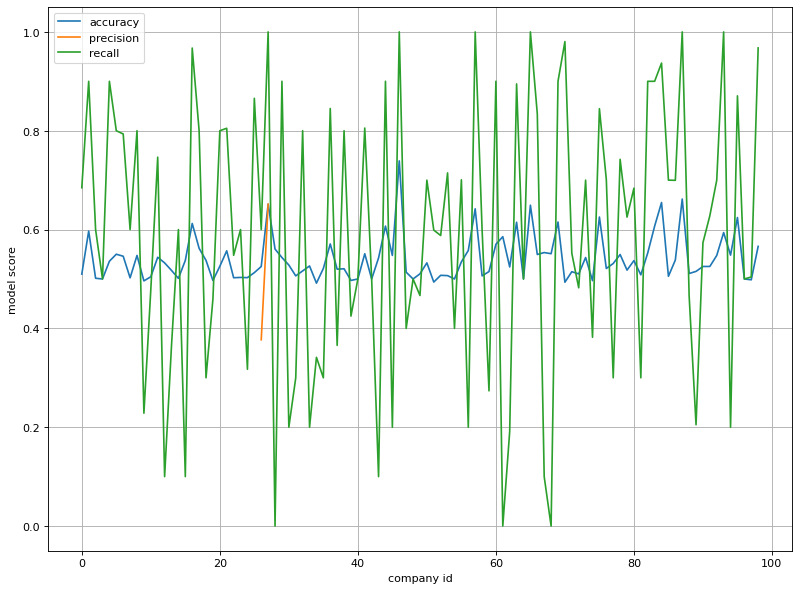

In [196]:
figure(figsize=(12, 9), dpi=80)

plt.axes(xlabel='company id', ylabel='model score')
#plt.xticks(np.arange(len(comps)), comps, rotation='75')
plt.grid()
for i in range(3):
    plt.plot(np.sum(scores_true, axis=1)[:,i]/10)
#plt.plot(np.sum(scores_true, axis=1)[:,0]/10)
plt.legend(['accuracy', 'precision', 'recall'])
#true price only

In [199]:
np.sum(np.sum(scores_true, axis=1)[:,0])/990

0.5410145294278905

In [198]:
print('avg model acc')
np.sum(scores_true)/(99*10)

avg model acc


nan

In [200]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=1
threshold=1e-3
names=[         
   # 'mid_price',
   # 'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
scores_all=np.zeros(shape=(len(comps), 10, 3))


In [201]:
for c in range(len(comps)):
    print(c)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    X,y=permutate_Xy(X,y)
    for i in range(10):
        scores_all[c,i,0], scores_all[c,i,1],scores_all[c,i,2]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names))


0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
order_inbalance   -0.9571038437283107
vwaps_buy   0.11480673312942714
vwaps_sell   1.4253305758526036
s2f_impact_buy   0.09544415579117442
s2f_impact_sell   0.044928764987290724
trading_volumes   0.14815938243119575
price_volatilities   0.012436322797129975
vwaps_order_sizes_buy   -0.10175521632347909
vwaps_order_sizes_sell   -0.4450405915904381
s2f_order_sizes_buy   -0.10175521632347909
s2f_order_sizes_sell   -0.4450405915904381
next_trade_time   -1.207738291252435
next_trade_size   1.6734197762766876
next_trade_price   1.4765046467255145
[[273 226]
 [211 248]]
Coefficient impact:
order_inbalance   -1.1755516669376478
vwaps_buy   0.13980136917103184
vwaps_sell   1.36503023621403
s2f_impact_buy   0.14020014318926186
s2f_impact_sell   0.04636635768985284
trading_volumes   0.18837797269320405
pr

order_inbalance   -0.09483031225935226
vwaps_buy   0.0236851204989636
vwaps_sell   0.6918092051049421
s2f_impact_buy   0.22331604882011494
s2f_impact_sell   0.4188157577799525
trading_volumes   0.06972440132901579
price_volatilities   0.11128816454705291
vwaps_order_sizes_buy   0.4165448560423363
vwaps_order_sizes_sell   -0.4481956773696275
s2f_order_sizes_buy   0.4165448560423363
s2f_order_sizes_sell   -0.4481956773696275
next_trade_time   0.2657364111402574
next_trade_size   0.27721250133325187
next_trade_price   -0.028740680206475
[[588 370]
 [  0   0]]
Coefficient impact:
order_inbalance   -0.3117325204970388
vwaps_buy   -0.04492933012643325
vwaps_sell   0.6927186172210188
s2f_impact_buy   0.3170981491080866
s2f_impact_sell   0.46079879757527925
trading_volumes   0.062330910972422986
price_volatilities   0.14322006912252117
vwaps_order_sizes_buy   0.31221916728739474
vwaps_order_sizes_sell   -0.45402549976638235
s2f_order_sizes_buy   0.31221916728739474
s2f_order_sizes_sell   -0.45

31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
order_inbalance   0.4420787615102252
vwaps_buy   -0.6267520928236626
vwaps_sell   -0.40317507577719053
s2f_impact_buy   0.09796619638453379
s2f_impact_sell   -0.6197381020395044
trading_volumes   -0.0554326186274942
price_volatilities   -0.005666504332446825
vwaps_order_sizes_buy   -0.4427862806978748
vwaps_order_sizes_sell   0.2853691471917921
s2f_order_sizes_buy   -0.4427862806978748
s2f_order_sizes_sell   0.2853691471917921
next_trade_time   -0.8301283293490979
next_trade_size   0.3949045722526702
next_trade_price   -0.5970902241669983
[[301 369]
 [117 171]]
Coefficient impact:
order_inbalance   0.5458926376865558
vwaps_buy   -0.3926946442821808
vwaps_sell   -0.4045947239779075
s2f_impact_buy   0.13596003929785316
s2f_i

Coefficient impact:
order_inbalance   1.4099417018712812
vwaps_buy   -0.8226216169986523
vwaps_sell   -0.49733832833460917
s2f_impact_buy   1.3042511384111228
s2f_impact_sell   -0.43606765648016005
trading_volumes   1.1663775878679594
price_volatilities   0.004473082740803758
vwaps_order_sizes_buy   0.9488543628653447
vwaps_order_sizes_sell   0.22747004096826606
s2f_order_sizes_buy   0.9488543628653447
s2f_order_sizes_sell   0.22747004096826606
next_trade_time   -0.3538713050077156
next_trade_size   0.10800588407813903
next_trade_price   -0.7432445641762923
[[517 426]
 [  8   7]]
Coefficient impact:
order_inbalance   1.3722381988138277
vwaps_buy   -0.680455038319448
vwaps_sell   -0.3849277627925322
s2f_impact_buy   1.2766302138775025
s2f_impact_sell   -0.41013992278321526
trading_volumes   1.2995276152771809
price_volatilities   0.1410871272348102
vwaps_order_sizes_buy   0.8716500856780303
vwaps_order_sizes_sell   0.30706135651327615
s2f_order_sizes_buy   0.8716500856780303
s2f_order_s

35.71875% of intervals were SELL empty
35.46875% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
Coefficient impact:
order_inbalance   0.34298174791644476
vwaps_buy   -0.6862962858522165
vwaps_sell   0.898829356061038
s2f_impact_buy   0.22692440642068717
s2f_impact_sell   0.3467431658258448
trading_volumes   -0.5713486856093228
price_volatilities   0.16998650080349276
vwaps_order_sizes_buy   -0.17791706399526627
vwaps_order_sizes_sell   -0.3371279938552625
s2f_order_sizes_buy   -0.17791706399526627
s2f_order_sizes_sell   -0.3371279938552625
next_trade_time   0.019465201875591892
next_trade_size   -0.40250565621226647
next_trade_price   2.1007543676147313
[[368 217]
 [205 168]]
Coefficient impact:
order_inbalance   0.04275404435435906
vwaps_buy   -0.20550504120846344
vwaps_sell   1.243497231689284
s2f_impact_buy   0.509720498712294
s2f_impact_sell   0.5822193695813064
trading_volumes   -0.6335062864696397
price_volatilities   -0.6592049693610995
vwaps_

Coefficient impact:
order_inbalance   -1.5417380582711604
vwaps_buy   0.5116294131478951
vwaps_sell   0.5133601961626529
s2f_impact_buy   0.325981321334329
s2f_impact_sell   0.6151963928161527
trading_volumes   -0.4398593037588525
price_volatilities   0.3259791642815425
vwaps_order_sizes_buy   -0.6183893215946136
vwaps_order_sizes_sell   0.17154416690171562
s2f_order_sizes_buy   -0.6183893215946136
s2f_order_sizes_sell   0.17154416690171562
next_trade_time   0.3320652966119678
next_trade_size   0.9367705303087421
next_trade_price   0.3507097458300649
[[477 426]
 [ 26  29]]
Coefficient impact:
order_inbalance   -1.1430567531730385
vwaps_buy   0.48146129243896235
vwaps_sell   0.5586340241043873
s2f_impact_buy   0.49266255161667916
s2f_impact_sell   0.5650876606267964
trading_volumes   -0.4245659817559514
price_volatilities   0.21797933504123987
vwaps_order_sizes_buy   -0.591194654979637
vwaps_order_sizes_sell   0.03193612827884792
s2f_order_sizes_buy   -0.591194654979637
s2f_order_sizes_

Coefficient impact:
order_inbalance   0.7698410848459327
vwaps_buy   0.6569557828718606
vwaps_sell   0.10969686532332491
s2f_impact_buy   0.34107053151351174
s2f_impact_sell   0.9175627719457784
trading_volumes   1.448175522394112
price_volatilities   0.14679608337332734
vwaps_order_sizes_buy   0.10604539389704194
vwaps_order_sizes_sell   0.8321998456730326
s2f_order_sizes_buy   0.10604539389704194
s2f_order_sizes_sell   0.8321998456730326
next_trade_time   0.3920515168360417
next_trade_size   0.4032536503263669
next_trade_price   0.03060741828318058
[[182 171]
 [276 329]]
Coefficient impact:
order_inbalance   1.0843707151781423
vwaps_buy   0.2973857149551135
vwaps_sell   0.18421866932082492
s2f_impact_buy   0.17433627176375338
s2f_impact_sell   0.808409699868357
trading_volumes   1.6031246848890452
price_volatilities   0.1977306676790798
vwaps_order_sizes_buy   0.17050051338829245
vwaps_order_sizes_sell   1.012571583273269
s2f_order_sizes_buy   0.17050051338829245
s2f_order_sizes_sell

Coefficient impact:
order_inbalance   -0.2424201265141015
vwaps_buy   -0.12330402912966448
vwaps_sell   0.48820639269455957
s2f_impact_buy   -0.04842682104134911
s2f_impact_sell   -0.1823930099666661
trading_volumes   0.3568691463497808
price_volatilities   -0.09853266324635479
vwaps_order_sizes_buy   0.4497475520888689
vwaps_order_sizes_sell   0.13102407542360459
s2f_order_sizes_buy   0.4497475520888689
s2f_order_sizes_sell   0.13102407542360459
next_trade_time   -0.24433737314841672
next_trade_size   -0.3956385232881818
next_trade_price   0.28282044440208864
[[567 389]
 [  1   1]]
Coefficient impact:
order_inbalance   -0.2377219358967338
vwaps_buy   -0.11451673961708075
vwaps_sell   0.22732434917990535
s2f_impact_buy   -0.0900137904390444
s2f_impact_sell   -0.08665296018987388
trading_volumes   0.4728147842264792
price_volatilities   0.030743168310954725
vwaps_order_sizes_buy   0.4673792187769863
vwaps_order_sizes_sell   -0.11842007442859363
s2f_order_sizes_buy   0.4673792187769863
s

33.6875% of intervals were SELL empty
31.802083333333332% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
Coefficient impact:
order_inbalance   -0.09756715327137289
vwaps_buy   0.23159270632410228
vwaps_sell   0.33772533561789914
s2f_impact_buy   0.18530628751332032
s2f_impact_sell   0.25211172528582737
trading_volumes   0.35680199401220825
price_volatilities   0.000762800266099194
vwaps_order_sizes_buy   -0.10348943117557176
vwaps_order_sizes_sell   0.40875305216990626
s2f_order_sizes_buy   -0.10348943117557176
s2f_order_sizes_sell   0.40875305216990626
next_trade_time   -0.35606097736322107
next_trade_size   0.20195253977468614
next_trade_price   0.5750213118549711
[[322 336]
 [143 157]]
Coefficient impact:
order_inbalance   -0.0965561271339577
vwaps_buy   0.2926893628890405
vwaps_sell   0.3650210420238936
s2f_impact_buy   0.10418916869014161
s2f_impact_sell   0.17460457193955348
trading_volumes   0.3015182784397419
price_volatilities   0.0620173259

trading_volumes   -0.44434459750445676
price_volatilities   -0.07180102465881329
vwaps_order_sizes_buy   0.049173025710372915
vwaps_order_sizes_sell   -0.12035287221384916
s2f_order_sizes_buy   0.049173025710372915
s2f_order_sizes_sell   -0.12035287221384916
next_trade_time   -0.6001114115700729
next_trade_size   -0.6748816206685145
next_trade_price   1.409023862493657
[[285 261]
 [187 225]]
Coefficient impact:
order_inbalance   0.80629677901216
vwaps_buy   0.09528472959781792
vwaps_sell   0.7952775915651611
s2f_impact_buy   0.7116378941838021
s2f_impact_sell   -0.34314855691275475
trading_volumes   -0.2579254290800434
price_volatilities   0.08667810176117371
vwaps_order_sizes_buy   -0.03519307695628161
vwaps_order_sizes_sell   -0.09735189656461951
s2f_order_sizes_buy   -0.03519307695628161
s2f_order_sizes_sell   -0.09735189656461951
next_trade_time   -0.6524980587246079
next_trade_size   -0.6758085255329164
next_trade_price   1.2136108661707325
[[391 361]
 [ 81 125]]
Coefficient impac

Coefficient impact:
order_inbalance   -0.1939106358780303
vwaps_buy   0.7927695908295023
vwaps_sell   0.7173685142826292
s2f_impact_buy   -0.007280643220380306
s2f_impact_sell   0.14861927838386424
trading_volumes   0.5669579361926134
price_volatilities   0.2770206535001426
vwaps_order_sizes_buy   0.21263766211027937
vwaps_order_sizes_sell   0.5010764016308146
s2f_order_sizes_buy   0.21263766211027937
s2f_order_sizes_sell   0.5010764016308146
next_trade_time   -0.3158348441497622
next_trade_size   0.4833629143285696
next_trade_price   1.0723864123179356
[[614 343]
 [  0   1]]
Coefficient impact:
order_inbalance   -0.1681192070149264
vwaps_buy   1.224110727293406
vwaps_sell   0.623934401797894
s2f_impact_buy   -0.0668738176706331
s2f_impact_sell   0.05093993272130016
trading_volumes   0.6608393681122913
price_volatilities   0.10303228894322633
vwaps_order_sizes_buy   0.3927967175178701
vwaps_order_sizes_sell   0.4211710138063451
s2f_order_sizes_buy   0.3927967175178701
s2f_order_sizes_s

[[ 18  21]
 [383 536]]
Coefficient impact:
order_inbalance   0.33917186492881457
vwaps_buy   -0.1999624605242807
vwaps_sell   0.21909624738996364
s2f_impact_buy   0.29260337217837995
s2f_impact_sell   0.7062636533275787
trading_volumes   -0.5569715843864458
price_volatilities   0.021824283598500138
vwaps_order_sizes_buy   -0.18908400516588467
vwaps_order_sizes_sell   -0.7025759512545348
s2f_order_sizes_buy   -0.18908400516588467
s2f_order_sizes_sell   -0.7025759512545348
next_trade_time   -0.019199439640470047
next_trade_size   1.032929375130483
next_trade_price   0.48580789650964107
[[ 70 121]
 [331 436]]
Coefficient impact:
order_inbalance   0.23473725646886193
vwaps_buy   -0.10716628460757294
vwaps_sell   0.17046895613210122
s2f_impact_buy   0.060010474583116855
s2f_impact_sell   0.7085204768088503
trading_volumes   -0.6319675641499441
price_volatilities   0.09684026237076357
vwaps_order_sizes_buy   -0.3998831303264755
vwaps_order_sizes_sell   -0.8534820857472646
s2f_order_sizes_buy

Coefficient impact:
order_inbalance   0.49772331446949597
vwaps_buy   0.2800276731768514
vwaps_sell   0.40833083061332853
s2f_impact_buy   0.2726719079387152
s2f_impact_sell   -0.2985812911265434
trading_volumes   0.3650855325006576
price_volatilities   -0.08932717822812856
vwaps_order_sizes_buy   -0.15980736147941124
vwaps_order_sizes_sell   0.2318709629386151
s2f_order_sizes_buy   -0.15980736147941124
s2f_order_sizes_sell   0.2318709629386151
next_trade_time   -0.18676809155811935
next_trade_size   1.0257168589037091
next_trade_price   2.0700108324856017
[[475 427]
 [ 27  29]]
Coefficient impact:
order_inbalance   0.35889089280372216
vwaps_buy   0.11183546785219463
vwaps_sell   0.499491398952313
s2f_impact_buy   0.16588042475455222
s2f_impact_sell   -0.4578770942302349
trading_volumes   0.2901571467065244
price_volatilities   -0.09080374738491821
vwaps_order_sizes_buy   -0.6612449702559339
vwaps_order_sizes_sell   0.36353392747040914
s2f_order_sizes_buy   -0.6612449702559339
s2f_orde

next_trade_time   -0.18330620576149612
next_trade_size   0.13555643587283828
next_trade_price   -0.08306298984934188
[[397 340]
 [ 94 127]]
Coefficient impact:
order_inbalance   0.6759998227039613
vwaps_buy   1.2001396121626229
vwaps_sell   1.079801299884344
s2f_impact_buy   1.4422680156495231
s2f_impact_sell   -0.14168699995809014
trading_volumes   0.04242606751277408
price_volatilities   0.3332177632288889
vwaps_order_sizes_buy   -0.36029623709473924
vwaps_order_sizes_sell   0.24385554977581192
s2f_order_sizes_buy   -0.36029623709473924
s2f_order_sizes_sell   0.24385554977581192
next_trade_time   -0.3519393577612372
next_trade_size   0.04279174446918486
next_trade_price   -0.28549839295382295
[[273 214]
 [218 253]]
Coefficient impact:
order_inbalance   0.4692915921415507
vwaps_buy   1.2148212248745505
vwaps_sell   0.9184517459857793
s2f_impact_buy   1.0324891531601001
s2f_impact_sell   -0.41842736118017543
trading_volumes   0.21362458486295768
price_volatilities   0.1213641151494613


price_volatilities   -0.28229299564813537
vwaps_order_sizes_buy   0.3107195022934203
vwaps_order_sizes_sell   0.028298817654843045
s2f_order_sizes_buy   0.3107195022934203
s2f_order_sizes_sell   0.028298817654843045
next_trade_time   1.1511856744111169
next_trade_size   0.39800509868868084
next_trade_price   -0.038825338636905814
[[493 458]
 [  5   2]]
Coefficient impact:
order_inbalance   -0.6238859545288873
vwaps_buy   -0.04957142352621837
vwaps_sell   0.10280495943585052
s2f_impact_buy   0.24325632822610443
s2f_impact_sell   -0.11668591677745926
trading_volumes   0.2758669345644219
price_volatilities   -0.04104395365336852
vwaps_order_sizes_buy   0.28115024090273405
vwaps_order_sizes_sell   0.017250072958802622
s2f_order_sizes_buy   0.28115024090273405
s2f_order_sizes_sell   0.017250072958802622
next_trade_time   1.0130281140308057
next_trade_size   0.40337898955562185
next_trade_price   0.031017754261330115
[[316 252]
 [182 208]]
Coefficient impact:
order_inbalance   -0.66607290124

37.958333333333336% of intervals were SELL empty
36.052083333333336% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
order_inbalance   0.5259050022056536
vwaps_buy   0.7485625604794041
vwaps_sell   -0.685359057327404
s2f_impact_buy   -0.24631317637386063
s2f_impact_sell   -0.8837965061817747
trading_volumes   0.6571675836379575
price_volatilities   0.050272615156120457
vwaps_order_sizes_buy   0.9185527419796999
vwaps_order_sizes_sell   -0.4432664133409286
s2f_order_sizes_buy   0.9185527419796999
s2f_order_sizes_sell   -0.4432664133409286
next_trade_time   -0.35983639799147743
next_trade_size   0.2637454440444579
next_trade_price   -0.3824895141612772
[[628 328]
 [  1   1]]
Coefficient impact:
order_inbalance   0.43483900765071193
vwaps_buy   0.873905989987943
vwaps_sell   -0.7101987784754358
s2f_impact_buy   -0.2532198681950888
s2f_impact_sell   -0.8793054441746243
trading_v

 [  2   0]]
Coefficient impact:
order_inbalance   -0.41385552544718374
vwaps_buy   0.32483162490517936
vwaps_sell   -0.43602680326732596
s2f_impact_buy   -1.2403538743948863
s2f_impact_sell   -0.11347988099452462
trading_volumes   -0.31925037988197535
price_volatilities   -0.27662824889086385
vwaps_order_sizes_buy   0.5129593720890097
vwaps_order_sizes_sell   0.094018717711217
s2f_order_sizes_buy   0.5129593720890097
s2f_order_sizes_sell   0.094018717711217
next_trade_time   0.059896936649384905
next_trade_size   -0.7708134794903915
next_trade_price   0.019645575507107545
[[642 314]
 [  2   0]]
Coefficient impact:
order_inbalance   -0.36821688104388045
vwaps_buy   0.6136991950147815
vwaps_sell   -0.3615193489870328
s2f_impact_buy   -1.087548076020599
s2f_impact_sell   -0.32345367317311197
trading_volumes   -0.6046345409841101
price_volatilities   -0.11501362045917567
vwaps_order_sizes_buy   0.5742142262787657
vwaps_order_sizes_sell   0.047291490486517256
s2f_order_sizes_buy   0.5742142

Coefficient impact:
order_inbalance   0.3410829473876407
vwaps_buy   0.2819668246194831
vwaps_sell   0.3343329247524433
s2f_impact_buy   -0.04417968017718312
s2f_impact_sell   0.46220295474913514
trading_volumes   0.5358836675493398
price_volatilities   0.10451035997289501
vwaps_order_sizes_buy   0.4986235483950959
vwaps_order_sizes_sell   0.18190165030350164
s2f_order_sizes_buy   0.4986235483950959
s2f_order_sizes_sell   0.18190165030350164
next_trade_time   -0.5230282678894272
next_trade_size   0.9517076587110825
next_trade_price   0.47327253382189777
[[366 272]
 [182 138]]
Coefficient impact:
order_inbalance   0.38651211045601497
vwaps_buy   0.3382126447935232
vwaps_sell   0.05914073399679061
s2f_impact_buy   0.01909559909838299
s2f_impact_sell   0.34605636702137577
trading_volumes   0.5373974154902807
price_volatilities   -0.009391553767377589
vwaps_order_sizes_buy   0.5740404868373349
vwaps_order_sizes_sell   0.17100338270740298
s2f_order_sizes_buy   0.5740404868373349
s2f_order_s

19.21875% of intervals were SELL empty
22.552083333333332% of intervals were BUY empty
0.0625% of intervals were set not filled
Coefficient impact:
order_inbalance   0.8399130760624753
vwaps_buy   0.17613776437383288
vwaps_sell   0.16125330810279137
s2f_impact_buy   2.4472345220105645
s2f_impact_sell   0.226536795717913
trading_volumes   -0.3462277322652838
price_volatilities   -0.031141746075164716
vwaps_order_sizes_buy   -0.16693158899879001
vwaps_order_sizes_sell   -0.8463111076275646
s2f_order_sizes_buy   -0.16693158899879001
s2f_order_sizes_sell   -0.8463111076275646
next_trade_time   0.9552653113845084
next_trade_size   -0.36855136678204947
next_trade_price   0.44203257567628357
[[ 30  16]
 [428 484]]
Coefficient impact:
order_inbalance   1.1862736386388035
vwaps_buy   0.42171196338190176
vwaps_sell   0.71436181010477
s2f_impact_buy   2.1220874814534643
s2f_impact_sell   0.3891758864936577
trading_volumes   -0.4526841759548241
price_volatilities   0.1698701909253359
vwaps_order_s

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


37.052083333333336% of intervals were SELL empty
36.625% of intervals were BUY empty
0.010416666666666666% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
order_inbalance   0.5932693547775119
vwaps_buy   0.3874642901413075
vwaps_sell   1.0186215728999002
s2f_impact_buy   -0.3297624560709159
s2f_impact_sell   -0.025792868677035508
trading_volumes   0.7677226966647328
price_volatilities   0.1573192917964479
vwaps_order_sizes_buy   -0.12100794070197168
vwaps_order_sizes_sell   -0.013524858527561264
s2f_order_sizes_buy   -0.12100794070197168
s2f_order_sizes_sell   -0.013524858527561264
next_trade_time   0.8275313291492745
next_trade_size   -1.2103083676012352
next_trade_price   0.9995615296762497
[[213 172]
 [282 291]]
Coefficient impact:
order_inbalance   0.7769378123318536
vwaps_buy   0.4496251437947958
vwaps_sell   1.048371674914049
s2f_impact_buy   -0.41998540067906176
s2f_impact_sell   -0.0900743499145296
trading_volumes   1.0554673313038663
pr

Coefficient impact:
order_inbalance   -0.5282926357050198
vwaps_buy   0.919430049820226
vwaps_sell   0.10568908279983738
s2f_impact_buy   -0.1051614998672246
s2f_impact_sell   0.12962465972734374
trading_volumes   0.464323752167868
price_volatilities   -0.013866819730995171
vwaps_order_sizes_buy   0.2403204582046228
vwaps_order_sizes_sell   0.05183083892813911
s2f_order_sizes_buy   0.2403204582046228
s2f_order_sizes_sell   0.05183083892813911
next_trade_time   -0.5649590935813157
next_trade_size   0.1255956222458756
next_trade_price   0.07734332944078093
[[ 79  76]
 [344 459]]
Coefficient impact:
order_inbalance   -0.4422636178526468
vwaps_buy   0.85063662955694
vwaps_sell   0.06931974185311926
s2f_impact_buy   -0.019984175890152608
s2f_impact_sell   0.14996629711051943
trading_volumes   0.38404599443683946
price_volatilities   -0.08088993759281245
vwaps_order_sizes_buy   0.24077151764024673
vwaps_order_sizes_sell   0.061576443564868105
s2f_order_sizes_buy   0.24077151764024673
s2f_ord

Coefficient impact:
order_inbalance   0.8946747873591144
vwaps_buy   -0.4195094852238066
vwaps_sell   0.7206904379820004
s2f_impact_buy   0.33991250529932043
s2f_impact_sell   0.29982221234339024
trading_volumes   -0.18295951686063633
price_volatilities   0.1932522490762445
vwaps_order_sizes_buy   -0.4479329607928742
vwaps_order_sizes_sell   0.24184085315459866
s2f_order_sizes_buy   -0.4479329607928742
s2f_order_sizes_sell   0.24184085315459866
next_trade_time   -0.1349865370826948
next_trade_size   -0.024921296923487473
next_trade_price   1.106031197742784
[[179 167]
 [328 284]]
35
21.479166666666668% of intervals were SELL empty
16.864583333333332% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
Coefficient impact:
order_inbalance   -0.5618975273861705
vwaps_buy   0.9864874797314246
vwaps_sell   1.4081261494050505
s2f_impact_buy   1.11532011343436
s2f_impact_sell   0.32174921369993503
trading_volumes   -0.17598810018016572
price_volatilities   0.003

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   -0.584400271635829
vwaps_buy   0.9548889080530206
vwaps_sell   1.5598219995524756
s2f_impact_buy   0.944367322677889
s2f_impact_sell   0.21280706902966703
trading_volumes   0.08708195231579963
price_volatilities   -0.14801285904179665
vwaps_order_sizes_buy   -0.1342325078678276
vwaps_order_sizes_sell   0.7708105435316266
s2f_order_sizes_buy   -0.1342325078678276
s2f_order_sizes_sell   0.7708105435316266
next_trade_time   0.10296141928847904
next_trade_size   -0.4019008173873637
next_trade_price   0.5667547170642695
[[  0   0]
 [421 537]]
Coefficient impact:
order_inbalance   -0.42326223470855096
vwaps_buy   0.5233477448950261
vwaps_sell   1.4151249036121114
s2f_impact_buy   0.8549752299270716
s2f_impact_sell   0.17519583059869182
trading_volumes   0.41809274397105345
price_volatilities   0.08467178797996057
vwaps_order_sizes_buy   -0.3306973493860241
vwaps_order_sizes_sell   0.7411100240458022
s2f_order_sizes_buy   -0.3306973493860241
s2f_order_sizes_sell   0.7411100

36.21875% of intervals were SELL empty
32.59375% of intervals were BUY empty
0.07291666666666667% of intervals were set not filled
Coefficient impact:
order_inbalance   0.9254853266129424
vwaps_buy   0.20698990018239735
vwaps_sell   -0.36317515922644805
s2f_impact_buy   -0.3547306840834221
s2f_impact_sell   0.6709761666537712
trading_volumes   1.3730808295918329
price_volatilities   -1.0393704021552288
vwaps_order_sizes_buy   0.5663315017072389
vwaps_order_sizes_sell   0.17486295390782225
s2f_order_sizes_buy   0.5663315017072389
s2f_order_sizes_sell   0.17486295390782225
next_trade_time   -0.14155358674019244
next_trade_size   -0.8108357273901002
next_trade_price   3.589758872969255
[[432 500]
 [ 13  13]]
Coefficient impact:
order_inbalance   -0.06218338111393063
vwaps_buy   0.11092269695683506
vwaps_sell   -0.10413898883550889
s2f_impact_buy   -0.5614427378961819
s2f_impact_sell   0.15241791260138554
trading_volumes   1.2644925389594728
price_volatilities   0.014099616667639625
vwaps_

s2f_impact_buy   -0.2799986165083452
s2f_impact_sell   0.15052611133688348
trading_volumes   1.414244023482219
price_volatilities   0.039393428844375404
vwaps_order_sizes_buy   -0.15745825228806867
vwaps_order_sizes_sell   0.16374210977035727
s2f_order_sizes_buy   -0.15745825228806867
s2f_order_sizes_sell   0.16374210977035727
next_trade_time   0.15733369067286482
next_trade_size   1.042573176792232
next_trade_price   -1.0074927124076796
[[533 406]
 [ 11   8]]
Coefficient impact:
order_inbalance   0.0703097933878723
vwaps_buy   -0.4797798207720466
vwaps_sell   -1.0955363632263635
s2f_impact_buy   0.22920574948818206
s2f_impact_sell   -0.0515848828702241
trading_volumes   1.457151058763474
price_volatilities   0.37905404429046674
vwaps_order_sizes_buy   0.3042968961848613
vwaps_order_sizes_sell   -0.06819177084584324
s2f_order_sizes_buy   0.3042968961848613
s2f_order_sizes_sell   -0.06819177084584324
next_trade_time   -0.03824547444298505
next_trade_size   0.8000737272085837
next_trade_

36.958333333333336% of intervals were SELL empty
36.0% of intervals were BUY empty
0.010416666666666666% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
order_inbalance   -0.06799648884841901
vwaps_buy   0.502947050982881
vwaps_sell   1.5696662253017712
s2f_impact_buy   -0.371560953646773
s2f_impact_sell   0.15841585506328806
trading_volumes   -0.8944269220133927
price_volatilities   0.0591541013040246
vwaps_order_sizes_buy   -0.8739014691073177
vwaps_order_sizes_sell   0.3314668018077463
s2f_order_sizes_buy   -0.8739014691073177
s2f_order_sizes_sell   0.3314668018077463
next_trade_time   0.5288506151076607
next_trade_size   1.1033540327562152
next_trade_price   1.2844149515756436
[[345 300]
 [167 146]]
Coefficient impact:
order_inbalance   -0.10007189700712192
vwaps_buy   0.6078047211269229
vwaps_sell   1.3059535999568672
s2f_impact_buy   -0.15784710939297308
s2f_impact_sell   0.12260962996289008
trading_volumes   -0.7067108711835667
price_vola

vwaps_sell   0.8220036604435224
s2f_impact_buy   0.031451318188251726
s2f_impact_sell   0.462954721464112
trading_volumes   0.28995158580074415
price_volatilities   0.28129900388400214
vwaps_order_sizes_buy   0.1992908255829434
vwaps_order_sizes_sell   0.19039410707325616
s2f_order_sizes_buy   0.1992908255829434
s2f_order_sizes_sell   0.19039410707325616
next_trade_time   0.5676402579606044
next_trade_size   1.48683457153465
next_trade_price   1.3664708357288986
[[526 432]
 [  0   0]]
Coefficient impact:
order_inbalance   0.7096626777439953
vwaps_buy   -0.35060078795346056
vwaps_sell   0.28641638406308934
s2f_impact_buy   0.29828714886328606
s2f_impact_sell   -0.24425146798698108
trading_volumes   0.33510893453953267
price_volatilities   0.1067431473452873
vwaps_order_sizes_buy   -0.20132925034728738
vwaps_order_sizes_sell   0.841530795944057
s2f_order_sizes_buy   -0.20132925034728738
s2f_order_sizes_sell   0.841530795944057
next_trade_time   1.1815455739670133
next_trade_size   1.8026

21.46875% of intervals were SELL empty
21.708333333333332% of intervals were BUY empty
0.17708333333333334% of intervals were set not filled
Coefficient impact:
order_inbalance   0.7482469450322553
vwaps_buy   -0.24943886272364307
vwaps_sell   -0.8004569903107815
s2f_impact_buy   1.285945795255991
s2f_impact_sell   0.6671604851646717
trading_volumes   0.2370899700822752
price_volatilities   0.2906334087551552
vwaps_order_sizes_buy   0.35932682839325925
vwaps_order_sizes_sell   -0.4204384978676002
s2f_order_sizes_buy   0.35932682839325925
s2f_order_sizes_sell   -0.4204384978676002
next_trade_time   0.9044241270435359
next_trade_size   0.46629124124912613
next_trade_price   1.063585156290897
[[191 201]
 [240 326]]
Coefficient impact:
order_inbalance   0.8291542666844668
vwaps_buy   -0.1384639193426654
vwaps_sell   -0.8138046442934522
s2f_impact_buy   1.2919079168405654
s2f_impact_sell   0.7755744897695299
trading_volumes   0.13852093549860264
price_volatilities   0.16028176608566586
vwap

Coefficient impact:
order_inbalance   0.7553094393959461
vwaps_buy   -0.717079438529997
vwaps_sell   -0.6614193420488206
s2f_impact_buy   0.9383731115991274
s2f_impact_sell   -2.410701398155729
trading_volumes   0.5355750140715898
price_volatilities   -0.9404592387663229
vwaps_order_sizes_buy   0.656232415768091
vwaps_order_sizes_sell   0.4130613300425074
s2f_order_sizes_buy   0.656232415768091
s2f_order_sizes_sell   0.4130613300425074
next_trade_time   -1.0825840489261733
next_trade_size   0.02432055180519394
next_trade_price   -3.417667906801638
[[551 359]
 [ 13  35]]
Coefficient impact:
order_inbalance   -0.17560787927599658
vwaps_buy   -1.0090994976249759
vwaps_sell   -1.2798924610443043
s2f_impact_buy   1.5558035652438058
s2f_impact_sell   -2.451780803327992
trading_volumes   0.9123718997150567
price_volatilities   -0.9051232101530763
vwaps_order_sizes_buy   0.6923312231011819
vwaps_order_sizes_sell   0.18597184925249483
s2f_order_sizes_buy   0.6923312231011819
s2f_order_sizes_sel

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   0.11662333127316757
vwaps_buy   -0.09650563107712339
vwaps_sell   -0.05065314342947707
s2f_impact_buy   0.28090765471246926
s2f_impact_sell   -0.32821795591605907
trading_volumes   0.8662756997438323
price_volatilities   -0.13834387904509637
vwaps_order_sizes_buy   -0.2726090768925235
vwaps_order_sizes_sell   0.39396347451645286
s2f_order_sizes_buy   -0.2726090768925235
s2f_order_sizes_sell   0.39396347451645286
next_trade_time   -0.48091384117120284
next_trade_size   -0.6443499581775263
next_trade_price   0.7001997720498756
[[ 17  20]
 [397 524]]
Coefficient impact:
order_inbalance   0.25391541685583285
vwaps_buy   -0.04959492447414083
vwaps_sell   0.0021909358751464785
s2f_impact_buy   0.12905516379334472
s2f_impact_sell   -0.33538628323311814
trading_volumes   0.9372321702934548
price_volatilities   -0.007818846725925031
vwaps_order_sizes_buy   -0.23888690607650417
vwaps_order_sizes_sell   0.3412736010802458
s2f_order_sizes_buy   -0.23888690607650417
s2f_order_siz

34.229166666666664% of intervals were SELL empty
29.625% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
Coefficient impact:
order_inbalance   0.5494703759278787
vwaps_buy   0.1916940661883162
vwaps_sell   1.0969929954211304
s2f_impact_buy   -0.10353051807385052
s2f_impact_sell   -0.5219605777972205
trading_volumes   -1.4334171586265432
price_volatilities   0.21419155279233348
vwaps_order_sizes_buy   -0.5599480800466043
vwaps_order_sizes_sell   0.024540106056843508
s2f_order_sizes_buy   -0.5599480800466043
s2f_order_sizes_sell   0.024540106056843508
next_trade_time   -1.3853522298656773
next_trade_size   0.695678503688432
next_trade_price   0.15320405399691334
[[  0   0]
 [418 540]]
Coefficient impact:
order_inbalance   0.43479084977573557
vwaps_buy   0.3129236409842466
vwaps_sell   0.900116265152952
s2f_impact_buy   0.1301684806775115
s2f_impact_sell   -0.4427372660968123
trading_volumes   -0.8967820026545161
price_volatilities   0.15520791677898838


<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



order_inbalance   -0.07462429557278197
vwaps_buy   0.2712775254886371
vwaps_sell   0.7754034700705733
s2f_impact_buy   0.1454853365976061
s2f_impact_sell   -0.3652802926598454
trading_volumes   -1.1046550729570341
price_volatilities   -0.16120895096084484
vwaps_order_sizes_buy   -0.6240345777937405
vwaps_order_sizes_sell   0.20144969429632953
s2f_order_sizes_buy   -0.6240345777937405
s2f_order_sizes_sell   0.20144969429632953
next_trade_time   -1.2038288373907113
next_trade_size   0.8457396743213873
next_trade_price   0.5501077376518639
[[  2   3]
 [416 537]]
Coefficient impact:
order_inbalance   0.24368502482305304
vwaps_buy   -0.06534905872988724
vwaps_sell   0.8472163248352004
s2f_impact_buy   0.09164626672121512
s2f_impact_sell   -0.1048905246774855
trading_volumes   -1.0379364995539335
price_volatilities   0.07332251809681017
vwaps_order_sizes_buy   -0.7625668046459738
vwaps_order_sizes_sell   0.0642099213719121
s2f_order_sizes_buy   -0.7625668046459738
s2f_order_sizes_sell   0.0

33.604166666666664% of intervals were SELL empty
33.447916666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
order_inbalance   0.0937535340293735
vwaps_buy   -0.38637152074419184
vwaps_sell   -0.3280740832919289
s2f_impact_buy   0.16831942388990315
s2f_impact_sell   -0.5194966026977538
trading_volumes   0.6975951383972031
price_volatilities   0.31217960074109186
vwaps_order_sizes_buy   -0.39493685045995025
vwaps_order_sizes_sell   0.9393198089953159
s2f_order_sizes_buy   -0.39493685045995025
s2f_order_sizes_sell   0.9393198089953159
next_trade_time   -0.33484597490041235
next_trade_size   -0.5467693091894215
next_trade_price   -0.32688868411085653
[[ 20   6]
 [447 485]]
Coefficient impact:
order_inbalance   0.07642945620272734
vwaps_buy   -0.32894647558991524
vwaps_sell   -0.24501652788567455
s2f_impact_buy   0.07889795176198149
s2f_impact_sell   -0.38642489824468557

s2f_order_sizes_buy   -0.5093168098260517
s2f_order_sizes_sell   0.3641399384468667
next_trade_time   0.6668615023488007
next_trade_size   0.39118960161281613
next_trade_price   -0.5655004800289339
[[436 277]
 [134 111]]
Coefficient impact:
order_inbalance   0.89644998851989
vwaps_buy   0.8486870999449964
vwaps_sell   0.6799006703048655
s2f_impact_buy   0.18765595896019766
s2f_impact_sell   0.19805527697783007
trading_volumes   1.517421260444902
price_volatilities   0.20405851195669458
vwaps_order_sizes_buy   -0.2568031533903028
vwaps_order_sizes_sell   0.38825785903037024
s2f_order_sizes_buy   -0.2568031533903028
s2f_order_sizes_sell   0.38825785903037024
next_trade_time   0.5205539743626696
next_trade_size   0.2818846440832356
next_trade_price   -0.5286824568910271
[[562 386]
 [  8   2]]
Coefficient impact:
order_inbalance   0.39053871366074255
vwaps_buy   0.9577380660993833
vwaps_sell   0.569153463884558
s2f_impact_buy   0.293703558903368
s2f_impact_sell   0.01262184929654568
tradin

31.229166666666668% of intervals were SELL empty
30.09375% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
Coefficient impact:
order_inbalance   0.011645206961414837
vwaps_buy   0.314315704187661
vwaps_sell   0.117668876552547
s2f_impact_buy   0.12108684110468902
s2f_impact_sell   0.4264735486589096
trading_volumes   0.6216650938268603
price_volatilities   -0.1723354341047591
vwaps_order_sizes_buy   0.22038889208018633
vwaps_order_sizes_sell   0.5472251353617748
s2f_order_sizes_buy   0.22038889208018633
s2f_order_sizes_sell   0.5472251353617748
next_trade_time   1.4176499934050188
next_trade_size   0.13186756385255674
next_trade_price   1.135664410616148
[[300 248]
 [208 202]]
Coefficient impact:
order_inbalance   -0.028822377681919607
vwaps_buy   0.21384522967476227
vwaps_sell   0.0480918775931554
s2f_impact_buy   0.09293276138250535
s2f_impact_sell   0.28726912616535666
trading_volumes   0.730173235886624
price_volatilities   -0.34942067229165447
vwa

order_inbalance   -0.20374736474200308
vwaps_buy   0.800148555281023
vwaps_sell   -0.4610387123688838
s2f_impact_buy   0.5569298995445098
s2f_impact_sell   0.18882810661244703
trading_volumes   -0.9727614950173478
price_volatilities   0.3091372322922954
vwaps_order_sizes_buy   -0.2868918101137257
vwaps_order_sizes_sell   -0.6129144958911085
s2f_order_sizes_buy   -0.2868918101137257
s2f_order_sizes_sell   -0.6129144958911085
next_trade_time   -0.7083635749966107
next_trade_size   0.3299741232598666
next_trade_price   -0.34606474017311095
[[383 331]
 [128 116]]
Coefficient impact:
order_inbalance   -0.2046433486954146
vwaps_buy   0.8999175321617665
vwaps_sell   -0.5153323542362811
s2f_impact_buy   0.5516464662345676
s2f_impact_sell   0.003603696016920226
trading_volumes   -0.9855793322252692
price_volatilities   0.3184885914445612
vwaps_order_sizes_buy   -0.29199086926644635
vwaps_order_sizes_sell   -0.663553845672983
s2f_order_sizes_buy   -0.29199086926644635
s2f_order_sizes_sell   -0.6

Coefficient impact:
order_inbalance   1.0758397665048303
vwaps_buy   0.5787112267502403
vwaps_sell   0.5827228898355523
s2f_impact_buy   -0.07231997421398642
s2f_impact_sell   -0.21309242660190267
trading_volumes   -0.9439735208645675
price_volatilities   0.7452254426313113
vwaps_order_sizes_buy   -0.5514004974429418
vwaps_order_sizes_sell   0.15466859191685417
s2f_order_sizes_buy   -0.5514004974429418
s2f_order_sizes_sell   0.15466859191685417
next_trade_time   -1.0225573570145092
next_trade_size   -0.8030175929039133
next_trade_price   1.2161479833454787
[[ 53  43]
 [407 455]]
55
9.885416666666666% of intervals were SELL empty
10.520833333333334% of intervals were BUY empty
1.3541666666666667% of intervals were set not filled
Coefficient impact:
order_inbalance   -0.08601624438594714
vwaps_buy   0.5415788245699741
vwaps_sell   0.0268714511455731
s2f_impact_buy   -0.020554591450328803
s2f_impact_sell   0.11261853418739727
trading_volumes   0.06219658930064176
price_volatilities   -0.2

Coefficient impact:
order_inbalance   0.3621755571552507
vwaps_buy   0.23571074539032882
vwaps_sell   -0.11652645005452175
s2f_impact_buy   0.7943928269565202
s2f_impact_sell   1.7219757568101872
trading_volumes   0.01000883755048521
price_volatilities   -0.02368672013943949
vwaps_order_sizes_buy   -0.9208495138870758
vwaps_order_sizes_sell   -0.2658402283789424
s2f_order_sizes_buy   -0.9208495138870758
s2f_order_sizes_sell   -0.2658402283789424
next_trade_time   0.08193410478427363
next_trade_size   -0.20583635819222626
next_trade_price   0.8356618616116885
[[  1   1]
 [379 577]]
Coefficient impact:
order_inbalance   0.1551195092211178
vwaps_buy   0.2791510003399717
vwaps_sell   -0.014811027394975812
s2f_impact_buy   0.9673537398990704
s2f_impact_sell   1.813434137754594
trading_volumes   0.003707408334153911
price_volatilities   -0.1003715394979913
vwaps_order_sizes_buy   -0.8618345389014668
vwaps_order_sizes_sell   -0.16039089561602093
s2f_order_sizes_buy   -0.8618345389014668
s2f_o

 [  4   1]]
58
12.729166666666666% of intervals were SELL empty
12.229166666666666% of intervals were BUY empty
0.40625% of intervals were set not filled
Coefficient impact:
order_inbalance   0.5169135817451483
vwaps_buy   0.6722568852738872
vwaps_sell   -0.016305365023778124
s2f_impact_buy   -0.07726482602293859
s2f_impact_sell   0.6767077892624982
trading_volumes   -0.8713679412145939
price_volatilities   0.33600510567633485
vwaps_order_sizes_buy   -0.26717065923887534
vwaps_order_sizes_sell   -0.13944810933806576
s2f_order_sizes_buy   -0.26717065923887534
s2f_order_sizes_sell   -0.13944810933806576
next_trade_time   -0.31067244501570496
next_trade_size   0.6207705935964851
next_trade_price   0.2842284641093139
[[519 373]
 [ 37  29]]
Coefficient impact:
order_inbalance   0.4845376104469658
vwaps_buy   0.7834240013008303
vwaps_sell   0.06755665420118302
s2f_impact_buy   -0.08132821358423235
s2f_impact_sell   0.6650451316145755
trading_volumes   -0.802352058816219
price_volatilities   

Coefficient impact:
order_inbalance   -0.6335192430118576
vwaps_buy   0.4958351986363684
vwaps_sell   -1.064674872887691
s2f_impact_buy   0.12497446160833726
s2f_impact_sell   0.23240746051019215
trading_volumes   -0.06082309405856651
price_volatilities   -0.10291976331981004
vwaps_order_sizes_buy   -0.010253736434061371
vwaps_order_sizes_sell   0.31365358195678283
s2f_order_sizes_buy   -0.010253736434061371
s2f_order_sizes_sell   0.31365358195678283
next_trade_time   -0.0877026167978336
next_trade_size   -0.2916642571065949
next_trade_price   0.43733709344710336
[[ 89  88]
 [366 415]]
Coefficient impact:
order_inbalance   -0.9634283920439882
vwaps_buy   0.3696672447372761
vwaps_sell   -0.8855990317718746
s2f_impact_buy   0.07173890346149155
s2f_impact_sell   0.1305149479974424
trading_volumes   -0.04717342211252226
price_volatilities   0.0216317563432266
vwaps_order_sizes_buy   0.012757726993678088
vwaps_order_sizes_sell   0.3114005406253636
s2f_order_sizes_buy   0.012757726993678088


24.0% of intervals were SELL empty
20.677083333333332% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
Coefficient impact:
order_inbalance   -1.1404722979551365
vwaps_buy   -0.1448279576662283
vwaps_sell   0.8640620404030724
s2f_impact_buy   0.214391684276902
s2f_impact_sell   0.4357849988740172
trading_volumes   -0.023483024237426816
price_volatilities   0.17913112250295649
vwaps_order_sizes_buy   0.48010761282233055
vwaps_order_sizes_sell   -1.1016145762777878
s2f_order_sizes_buy   0.48010761282233055
s2f_order_sizes_sell   -1.1016145762777878
next_trade_time   -0.20560471503808175
next_trade_size   -0.2527629109625139
next_trade_price   0.6090641739031777
[[ 83  83]
 [344 448]]
Coefficient impact:
order_inbalance   -1.0534763589958003
vwaps_buy   -0.35598054691994935
vwaps_sell   0.8500187189158289
s2f_impact_buy   -0.02921384941134641
s2f_impact_sell   0.7086701982564723
trading_volumes   -0.17055459391772707
price_volatilities   0.117255519415334

order_inbalance   0.3190745477750193
vwaps_buy   0.4871125566084985
vwaps_sell   0.9920088812332932
s2f_impact_buy   0.48821822664353576
s2f_impact_sell   0.3597716776517706
trading_volumes   -0.009389723282812979
price_volatilities   -0.016814415739887612
vwaps_order_sizes_buy   0.10865885941723366
vwaps_order_sizes_sell   0.23911627689328244
s2f_order_sizes_buy   0.10865885941723366
s2f_order_sizes_sell   0.23911627689328244
next_trade_time   -0.23506835439587984
next_trade_size   -0.0162836824229011
next_trade_price   0.13543615402041295
[[ 74  64]
 [384 436]]
Coefficient impact:
order_inbalance   0.28464060422021653
vwaps_buy   0.6129229690150202
vwaps_sell   0.8427404774288111
s2f_impact_buy   0.5058357714045912
s2f_impact_sell   0.3356905884123011
trading_volumes   -0.0960628741198555
price_volatilities   -0.011057293535556654
vwaps_order_sizes_buy   0.06331521006582733
vwaps_order_sizes_sell   0.2685129614907295
s2f_order_sizes_buy   0.06331521006582733
s2f_order_sizes_sell   0.

12.729166666666666% of intervals were SELL empty
13.5% of intervals were BUY empty
0.375% of intervals were set not filled
Coefficient impact:
order_inbalance   0.1677156378965379
vwaps_buy   -0.06342927123724831
vwaps_sell   0.9433998744986994
s2f_impact_buy   0.7491503164544626
s2f_impact_sell   0.8799477154146269
trading_volumes   -0.11131985082802724
price_volatilities   0.0024711791616476757
vwaps_order_sizes_buy   -0.4868285959089908
vwaps_order_sizes_sell   -0.5062340389568871
s2f_order_sizes_buy   -0.4868285959089908
s2f_order_sizes_sell   -0.5062340389568871
next_trade_time   0.0843224701401995
next_trade_size   -0.6196553433507198
next_trade_price   0.10532197945840138
[[  8  13]
 [385 552]]
Coefficient impact:
order_inbalance   0.5165316930207751
vwaps_buy   -0.09435833205376733
vwaps_sell   1.1942350861522684
s2f_impact_buy   1.0000190781436018
s2f_impact_sell   0.8964117367743366
trading_volumes   -0.06596690157139135
price_volatilities   -0.00054734459368304
vwaps_order_s

Coefficient impact:
order_inbalance   -0.5849003987277483
vwaps_buy   0.8890630428606867
vwaps_sell   -0.09890326929337823
s2f_impact_buy   0.3242502603193721
s2f_impact_sell   1.1210989339571322
trading_volumes   -1.0030382010421734
price_volatilities   0.06469034428458008
vwaps_order_sizes_buy   0.09889342718863062
vwaps_order_sizes_sell   0.32571973761539674
s2f_order_sizes_buy   0.09889342718863062
s2f_order_sizes_sell   0.32571973761539674
next_trade_time   0.8738385959316727
next_trade_size   0.09004580733310792
next_trade_price   0.4414858215503718
[[584 372]
 [  0   2]]
Coefficient impact:
order_inbalance   -0.7823932745339038
vwaps_buy   0.7090785026210668
vwaps_sell   -0.5159354183901943
s2f_impact_buy   -0.1312005187908616
s2f_impact_sell   0.9363131041653605
trading_volumes   -0.6891294667791401
price_volatilities   0.031456087546829124
vwaps_order_sizes_buy   0.45963784835373567
vwaps_order_sizes_sell   0.2897074837222964
s2f_order_sizes_buy   0.45963784835373567
s2f_order

12.791666666666666% of intervals were SELL empty
14.541666666666666% of intervals were BUY empty
0.40625% of intervals were set not filled
Coefficient impact:
order_inbalance   1.6331787382224516
vwaps_buy   1.6628641172390675
vwaps_sell   0.11113826234850424
s2f_impact_buy   0.9503438751409674
s2f_impact_sell   0.8574618576008924
trading_volumes   0.19309851573261078
price_volatilities   -0.3908328496922429
vwaps_order_sizes_buy   -0.1963824122024577
vwaps_order_sizes_sell   0.2601167710700725
s2f_order_sizes_buy   -0.1963824122024577
s2f_order_sizes_sell   0.2601167710700725
next_trade_time   0.8737302308002951
next_trade_size   0.4187522161344112
next_trade_price   0.06365966822192239
[[ 14  13]
 [372 559]]
Coefficient impact:
order_inbalance   1.8702959112596234
vwaps_buy   1.4755796923093731
vwaps_sell   0.10380515311092961
s2f_impact_buy   0.9687499190208249
s2f_impact_sell   0.7454720059308357
trading_volumes   0.22361996142394555
price_volatilities   -0.06680293331289049
vwaps_

Coefficient impact:
order_inbalance   1.2361972564707109
vwaps_buy   0.535279255571415
vwaps_sell   -0.011266543393038172
s2f_impact_buy   0.08514391820168836
s2f_impact_sell   0.3191684174124062
trading_volumes   -0.25307233919938305
price_volatilities   0.17557466250641046
vwaps_order_sizes_buy   0.2598875621814225
vwaps_order_sizes_sell   -0.19509486922261637
s2f_order_sizes_buy   0.2598875621814225
s2f_order_sizes_sell   -0.19509486922261637
next_trade_time   -0.09386590365743604
next_trade_size   0.9199780842064683
next_trade_price   0.8752610115930755
[[112 108]
 [294 444]]
Coefficient impact:
order_inbalance   1.3245570175040347
vwaps_buy   0.7739249335824809
vwaps_sell   -0.10533955648853621
s2f_impact_buy   -0.004397158260498063
s2f_impact_sell   0.6230820295694953
trading_volumes   -0.3794314785815268
price_volatilities   0.3339314495745247
vwaps_order_sizes_buy   -0.11869759107938957
vwaps_order_sizes_sell   -0.28044277129387807
s2f_order_sizes_buy   -0.11869759107938957
s2f

Coefficient impact:
order_inbalance   0.16402876977946348
vwaps_buy   -0.14265978996551137
vwaps_sell   0.33822046444921905
s2f_impact_buy   0.28854614854898436
s2f_impact_sell   0.3688690393052201
trading_volumes   -0.3203817767384414
price_volatilities   0.14114778421805935
vwaps_order_sizes_buy   -0.19090899636554393
vwaps_order_sizes_sell   -0.14972067856332552
s2f_order_sizes_buy   -0.19090899636554393
s2f_order_sizes_sell   -0.14972067856332552
next_trade_time   -0.6394782845690434
next_trade_size   -0.2815255091965001
next_trade_price   -0.2373762226511058
[[220 192]
 [271 275]]
Coefficient impact:
order_inbalance   0.10064502111547491
vwaps_buy   -0.14439641226473382
vwaps_sell   0.20812949794329594
s2f_impact_buy   0.34461168897201694
s2f_impact_sell   0.16358697301758987
trading_volumes   -0.32539052042894406
price_volatilities   0.15648251745895525
vwaps_order_sizes_buy   -0.2739143554406049
vwaps_order_sizes_sell   -0.19835003114500618
s2f_order_sizes_buy   -0.2739143554406

30.364583333333332% of intervals were SELL empty
29.875% of intervals were BUY empty
0.19791666666666666% of intervals were set not filled
Coefficient impact:
order_inbalance   0.33289589725610436
vwaps_buy   0.12719810548418659
vwaps_sell   -0.3286783289232298
s2f_impact_buy   0.3154194077025359
s2f_impact_sell   0.16568052893468574
trading_volumes   -0.48250513646064414
price_volatilities   0.017145637589158016
vwaps_order_sizes_buy   -0.2384465743323544
vwaps_order_sizes_sell   -0.22947096763564284
s2f_order_sizes_buy   -0.2384465743323544
s2f_order_sizes_sell   -0.22947096763564284
next_trade_time   -0.18693765064380766
next_trade_size   -0.23029464169152492
next_trade_price   -0.09436030439087864
[[295 292]
 [182 189]]
Coefficient impact:
order_inbalance   0.6048712056740565
vwaps_buy   0.2467330510497982
vwaps_sell   -0.2818732005369601
s2f_impact_buy   0.27236506134530614
s2f_impact_sell   0.051411935075296324
trading_volumes   -0.40440596668944134
price_volatilities   -0.021956

[[499 316]
 [ 78  65]]
Coefficient impact:
order_inbalance   0.36653079867209243
vwaps_buy   1.1785949727877114
vwaps_sell   -0.20441932890976555
s2f_impact_buy   0.21238989250848564
s2f_impact_sell   1.2903074779135326
trading_volumes   0.04551044965587996
price_volatilities   0.19740253982798464
vwaps_order_sizes_buy   -0.10545374390626439
vwaps_order_sizes_sell   -0.15814093634379095
s2f_order_sizes_buy   -0.10545374390626439
s2f_order_sizes_sell   -0.15814093634379095
next_trade_time   0.4748364426064335
next_trade_size   0.22490991664838542
next_trade_price   -0.2589693887465315
[[577 381]
 [  0   0]]
Coefficient impact:
order_inbalance   0.3816246762238331
vwaps_buy   1.2010055719150248
vwaps_sell   -0.2597746791067902
s2f_impact_buy   0.2203755526884804
s2f_impact_sell   1.276296555008958
trading_volumes   0.07583270910125141
price_volatilities   0.1472161217434257
vwaps_order_sizes_buy   -0.06933341768014675
vwaps_order_sizes_sell   -0.15972960407625247
s2f_order_sizes_buy   -0

20.90625% of intervals were SELL empty
17.875% of intervals were BUY empty
1.0729166666666667% of intervals were set not filled
Coefficient impact:
order_inbalance   -0.5947846164053984
vwaps_buy   0.3102296571708569
vwaps_sell   -0.1716747452436255
s2f_impact_buy   -0.11002262831960487
s2f_impact_sell   -0.0005702642456469327
trading_volumes   -0.7343032780128329
price_volatilities   0.1981136739852753
vwaps_order_sizes_buy   -0.3606443479020954
vwaps_order_sizes_sell   -0.04190103146894571
s2f_order_sizes_buy   -0.3606443479020954
s2f_order_sizes_sell   -0.04190103146894571
next_trade_time   0.08909446537843164
next_trade_size   0.4786688382472791
next_trade_price   0.4612457826737734
[[648 309]
 [  1   0]]
Coefficient impact:
order_inbalance   -0.4695709226744448
vwaps_buy   0.2878403868578334
vwaps_sell   -0.09884135528013531
s2f_impact_buy   -0.49378232801230226
s2f_impact_sell   0.18238171470385728
trading_volumes   -0.4971069943552675
price_volatilities   0.061650535126949
vwaps

 [ 15  14]]
Coefficient impact:
order_inbalance   -0.08398623721621502
vwaps_buy   -0.4757602598119464
vwaps_sell   1.379211760653592
s2f_impact_buy   -0.4202951621670535
s2f_impact_sell   0.6463317133379278
trading_volumes   0.33326973010936645
price_volatilities   -0.7708174443262823
vwaps_order_sizes_buy   1.0149170279092126
vwaps_order_sizes_sell   -0.7914827039303546
s2f_order_sizes_buy   1.0149170279092126
s2f_order_sizes_sell   -0.7914827039303546
next_trade_time   0.3875414612170865
next_trade_size   -0.1317050801008686
next_trade_price   2.2557851642517175
[[522 436]
 [  0   0]]
Coefficient impact:
order_inbalance   0.22225817895425706
vwaps_buy   -0.543767226928706
vwaps_sell   1.3806830092533355
s2f_impact_buy   -1.0699814461706556
s2f_impact_sell   0.9448829482584826
trading_volumes   -0.17427705464554327
price_volatilities   -0.05338594757089122
vwaps_order_sizes_buy   0.67799056301789
vwaps_order_sizes_sell   -0.4467554869843379
s2f_order_sizes_buy   0.67799056301789
s2f_

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


8.208333333333334% of intervals were SELL empty
9.3125% of intervals were BUY empty
6.59375% of intervals were set not filled
Coefficient impact:
order_inbalance   0.8172478171631855
vwaps_buy   0.4135929012616405
vwaps_sell   -0.17481236754165524
s2f_impact_buy   0.5587959754988076
s2f_impact_sell   -0.03480623304618662
trading_volumes   -0.3831106673886622
price_volatilities   -0.0979484326230938
vwaps_order_sizes_buy   0.8613262607538318
vwaps_order_sizes_sell   0.8537475393797465
s2f_order_sizes_buy   0.8613262607538318
s2f_order_sizes_sell   0.8537475393797465
next_trade_time   -0.3400107138973976
next_trade_size   -0.1128863514846817
next_trade_price   -0.26147924389484795
[[550 394]
 [ 10   4]]
Coefficient impact:
order_inbalance   0.8346593354699248
vwaps_buy   0.17232203337763788
vwaps_sell   -0.09304939347354357
s2f_impact_buy   0.34882010006809483
s2f_impact_sell   -0.3107763855132396
trading_volumes   -0.4386925974218826
price_volatilities   0.09910400422842679
vwaps_order_

Coefficient impact:
order_inbalance   0.6219094351229204
vwaps_buy   -0.47456492290753405
vwaps_sell   -0.5983364849608844
s2f_impact_buy   0.40640851061685446
s2f_impact_sell   0.5201210842471087
trading_volumes   1.4672540267239431
price_volatilities   0.31763144247163316
vwaps_order_sizes_buy   0.4626964037597609
vwaps_order_sizes_sell   0.08540032691508058
s2f_order_sizes_buy   0.4626964037597609
s2f_order_sizes_sell   0.08540032691508058
next_trade_time   1.9225305191369664
next_trade_size   2.218058937926437
next_trade_price   -0.43760128611508253
[[510 385]
 [ 30  33]]
Coefficient impact:
order_inbalance   0.7954223723463464
vwaps_buy   -0.7282280164670826
vwaps_sell   -0.4809568717622639
s2f_impact_buy   0.3436723733052549
s2f_impact_sell   0.37143672418296986
trading_volumes   1.6981749692638595
price_volatilities   0.016552204630033113
vwaps_order_sizes_buy   0.2127817029732843
vwaps_order_sizes_sell   -0.11805047009239748
s2f_order_sizes_buy   0.2127817029732843
s2f_order_si

Coefficient impact:
order_inbalance   0.4577311329450086
vwaps_buy   1.081723315046337
vwaps_sell   0.612611234133673
s2f_impact_buy   -0.4237919965040905
s2f_impact_sell   -0.08094888834475082
trading_volumes   -0.8734633175989337
price_volatilities   0.27361540950627466
vwaps_order_sizes_buy   -0.46801666319630864
vwaps_order_sizes_sell   -0.39633669841558017
s2f_order_sizes_buy   -0.46801666319630864
s2f_order_sizes_sell   -0.39633669841558017
next_trade_time   -0.5644570478458234
next_trade_size   -0.616638611421899
next_trade_price   0.5455721634361191
[[117 117]
 [334 390]]
Coefficient impact:
order_inbalance   0.7247472473131896
vwaps_buy   1.1887060229587982
vwaps_sell   0.6842243399068393
s2f_impact_buy   -0.10114179096876659
s2f_impact_sell   -0.22826411986853767
trading_volumes   -0.9006889350913165
price_volatilities   -0.010110622155714573
vwaps_order_sizes_buy   -0.4416865546305697
vwaps_order_sizes_sell   -0.35020606173229996
s2f_order_sizes_buy   -0.4416865546305697
s2f

s2f_impact_buy   0.2240302520147294
s2f_impact_sell   -0.2408012798888127
trading_volumes   0.8243969607063173
price_volatilities   0.0056092210687957705
vwaps_order_sizes_buy   0.22448590743197286
vwaps_order_sizes_sell   0.28583608520908665
s2f_order_sizes_buy   0.22448590743197286
s2f_order_sizes_sell   0.28583608520908665
next_trade_time   0.2758443819589443
next_trade_size   0.2571979039847227
next_trade_price   1.7594216916144543
[[595 362]
 [  1   0]]
Coefficient impact:
order_inbalance   -0.42174097320931087
vwaps_buy   0.026745613380504105
vwaps_sell   0.7639172054723827
s2f_impact_buy   0.20645839815231976
s2f_impact_sell   -0.34744444765980664
trading_volumes   0.8373444524771255
price_volatilities   0.25327124759484404
vwaps_order_sizes_buy   -0.014760622352647947
vwaps_order_sizes_sell   0.5862578242678204
s2f_order_sizes_buy   -0.014760622352647947
s2f_order_sizes_sell   0.5862578242678204
next_trade_time   -0.088517641308464
next_trade_size   0.05201554296121084
next_tra

33.625% of intervals were SELL empty
33.125% of intervals were BUY empty
0.10416666666666667% of intervals were set not filled
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
order_inbalance   0.07549500975464532
vwaps_buy   -0.4305443916438803
vwaps_sell   -0.5789996879428473
s2f_impact_buy   0.2378913791319008
s2f_impact_sell   0.08131329587404335
trading_volumes   0.7415328288208087
price_volatilities   0.0697825556010241
vwaps_order_sizes_buy   0.25684338600197804
vwaps_order_sizes_sell   0.23820101150609566
s2f_order_sizes_buy   0.25684338600197804
s2f_order_sizes_sell   0.23820101150609566
next_trade_time   0.11929808283185886
next_trade_size   -0.6000463803621996
next_trade_price   -0.3828770707375132
[[544 414]
 [  0   0]]
Coefficient impact:
order_inbalance   -0.029514128518144986
vwaps_buy   -0.4399620570023095
vwaps_sell   -0.6415320482414576
s2f_impact_buy   0.3535237415888727
s2f_impact_sell   -0.1083932661782179
trading_volumes 

Coefficient impact:
order_inbalance   1.3409660122548563
vwaps_buy   -0.08327910459423729
vwaps_sell   -0.6151740591939894
s2f_impact_buy   0.6040164538008449
s2f_impact_sell   1.0785710989564559
trading_volumes   -0.03462996006995888
price_volatilities   1.2282327917611278
vwaps_order_sizes_buy   0.03208887611776827
vwaps_order_sizes_sell   -0.43789832288579117
s2f_order_sizes_buy   0.03208887611776827
s2f_order_sizes_sell   -0.43789832288579117
next_trade_time   0.5869213128775175
next_trade_size   -0.7764547866315525
next_trade_price   3.095565571428585
[[  3   2]
 [545 408]]
Coefficient impact:
order_inbalance   0.4838625453086645
vwaps_buy   -0.22329217534076704
vwaps_sell   -0.6155022527587044
s2f_impact_buy   -0.10595570387953583
s2f_impact_sell   0.7612304708553791
trading_volumes   0.23053967817988985
price_volatilities   -0.07520499293589654
vwaps_order_sizes_buy   0.039807605233982704
vwaps_order_sizes_sell   -0.3859398378202881
s2f_order_sizes_buy   0.039807605233982704
s2f

Coefficient impact:
order_inbalance   -0.3629325586211389
vwaps_buy   1.2198688372854076
vwaps_sell   0.043183016512884434
s2f_impact_buy   0.3413400171745365
s2f_impact_sell   0.9318458865521968
trading_volumes   -0.3141288788995065
price_volatilities   0.33800431165350187
vwaps_order_sizes_buy   -0.8353705172025739
vwaps_order_sizes_sell   -0.5351179300455796
s2f_order_sizes_buy   -0.8353705172025739
s2f_order_sizes_sell   -0.5351179300455796
next_trade_time   0.3009842295935398
next_trade_size   0.10204917783800695
next_trade_price   3.1634598091704498
[[ 84  72]
 [369 433]]
Coefficient impact:
order_inbalance   0.5462818852587867
vwaps_buy   0.9219232942834544
vwaps_sell   0.262522305171207
s2f_impact_buy   -0.2814580856256784
s2f_impact_sell   0.3717971859360719
trading_volumes   -0.21933309500176734
price_volatilities   0.36902216874788224
vwaps_order_sizes_buy   -0.9252364558332445
vwaps_order_sizes_sell   -0.8292216313691176
s2f_order_sizes_buy   -0.9252364558332445
s2f_order_s

31.114583333333332% of intervals were SELL empty
32.864583333333336% of intervals were BUY empty
0.010416666666666666% of intervals were set not filled
Coefficient impact:
order_inbalance   0.3424526649517395
vwaps_buy   0.12221945109602451
vwaps_sell   0.307988663823182
s2f_impact_buy   0.4512351158804454
s2f_impact_sell   -0.01121848990720867
trading_volumes   -0.07953469186905672
price_volatilities   0.19425099879005295
vwaps_order_sizes_buy   0.603342367308493
vwaps_order_sizes_sell   -0.2717046880299019
s2f_order_sizes_buy   0.603342367308493
s2f_order_sizes_sell   -0.2717046880299019
next_trade_time   0.591144004496409
next_trade_size   0.05391667535687409
next_trade_price   1.1682674715888302
[[515 437]
 [  4   2]]
Coefficient impact:
order_inbalance   0.03612852123446803
vwaps_buy   0.13664548792097833
vwaps_sell   -0.007547938610586562
s2f_impact_buy   0.45133500050140135
s2f_impact_sell   0.03538801836909976
trading_volumes   0.11083102774588999
price_volatilities   0.0440364

Coefficient impact:
order_inbalance   -0.12484123133592102
vwaps_buy   0.1629086216069518
vwaps_sell   -1.1101073822619714
s2f_impact_buy   0.28654881064849985
s2f_impact_sell   -0.5257131546371979
trading_volumes   -1.2341767112725286
price_volatilities   -0.1420388071364336
vwaps_order_sizes_buy   -0.8922004235842225
vwaps_order_sizes_sell   -0.19403554789695138
s2f_order_sizes_buy   -0.8922004235842225
s2f_order_sizes_sell   -0.19403554789695138
next_trade_time   -0.3260398608821325
next_trade_size   -0.782663835722716
next_trade_price   0.6451461625428251
[[516 310]
 [ 61  71]]
Coefficient impact:
order_inbalance   -0.2927650154850413
vwaps_buy   -0.025265896647677238
vwaps_sell   -0.9950395107881082
s2f_impact_buy   0.2301665080008307
s2f_impact_sell   -0.39118819658847653
trading_volumes   -1.1250258758654983
price_volatilities   -0.470720752080734
vwaps_order_sizes_buy   -0.597821659885853
vwaps_order_sizes_sell   -0.21999960557854858
s2f_order_sizes_buy   -0.597821659885853
s2f

26.739583333333332% of intervals were SELL empty
26.916666666666668% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
Coefficient impact:
order_inbalance   0.08931496170646541
vwaps_buy   0.03149238863076044
vwaps_sell   0.5940519943799172
s2f_impact_buy   0.10902415146897115
s2f_impact_sell   -0.044231827083937914
trading_volumes   0.3771295546059823
price_volatilities   -0.0922108767040888
vwaps_order_sizes_buy   -0.21680326774631403
vwaps_order_sizes_sell   0.11958689421999834
s2f_order_sizes_buy   -0.21680326774631403
s2f_order_sizes_sell   0.11958689421999834
next_trade_time   0.32242479448257094
next_trade_size   -0.3659451287677779
next_trade_price   0.5977216260001731
[[555 402]
 [  1   0]]
Coefficient impact:
order_inbalance   -0.06416421758841423
vwaps_buy   -0.04553249261890851
vwaps_sell   0.7647518116376679
s2f_impact_buy   0.3537065403633487
s2f_impact_sell   0.01153898080563812
trading_volumes   0.3396975843453457
price_volatilities   -0

<ipython-input-46-fdfff4508f1c>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


  -2.2993301792336927
next_trade_size   -0.7690575943051517
next_trade_price   3.2364071332909425
[[221 221]
 [220 296]]
Coefficient impact:
order_inbalance   0.6407505284186732
vwaps_buy   -1.4927639761943756
vwaps_sell   0.45662097894809645
s2f_impact_buy   -0.16303698535665556
s2f_impact_sell   0.05457417070228132
trading_volumes   -0.35335357820926155
price_volatilities   -0.15432192849884935
vwaps_order_sizes_buy   -0.3234602470928673
vwaps_order_sizes_sell   -0.20741361958822188
s2f_order_sizes_buy   -0.3234602470928673
s2f_order_sizes_sell   -0.20741361958822188
next_trade_time   -2.3092282739911636
next_trade_size   -0.9874329425587532
next_trade_price   3.4238077339189275
[[ 19   6]
 [422 511]]
Coefficient impact:
order_inbalance   0.15678146235695434
vwaps_buy   -1.4830516841001413
vwaps_sell   0.76037439412891
s2f_impact_buy   -0.16893728496908247
s2f_impact_sell   0.5657629780998177
trading_volumes   -0.45222845617923557
price_volatilities   -0.06983567788568776
vwaps_order

24.145833333333332% of intervals were SELL empty
23.104166666666668% of intervals were BUY empty
0.7083333333333334% of intervals were set not filled
Coefficient impact:
order_inbalance   -1.3817728433212333
vwaps_buy   0.5059307838890732
vwaps_sell   2.1542689745110484
s2f_impact_buy   0.47586952411633865
s2f_impact_sell   0.04955287154528496
trading_volumes   -1.2289808058017924
price_volatilities   0.10358037933526905
vwaps_order_sizes_buy   -0.934231639370931
vwaps_order_sizes_sell   -0.059104536619754185
s2f_order_sizes_buy   -0.934231639370931
s2f_order_sizes_sell   -0.059104536619754185
next_trade_time   0.15740754571844007
next_trade_size   -0.49828098735304965
next_trade_price   1.3209476067331782
[[ 25  17]
 [453 463]]
Coefficient impact:
order_inbalance   -1.4332091832620755
vwaps_buy   0.10418273087180618
vwaps_sell   1.7701004160828566
s2f_impact_buy   0.9076580639711026
s2f_impact_sell   0.4113168950425937
trading_volumes   -0.8231351146203538
price_volatilities   -0.5689

Coefficient impact:
order_inbalance   -0.12850244323031143
vwaps_buy   0.6415219344847589
vwaps_sell   0.8413388671103098
s2f_impact_buy   -0.08916062826874659
s2f_impact_sell   0.1706923490547769
trading_volumes   -0.13805747316925263
price_volatilities   -0.1704194374102467
vwaps_order_sizes_buy   0.09562356883331923
vwaps_order_sizes_sell   0.11978382820316297
s2f_order_sizes_buy   0.09562356883331923
s2f_order_sizes_sell   0.11978382820316297
next_trade_time   -0.09009742960072091
next_trade_size   1.656364896459231
next_trade_price   0.7012303273505192
[[ 35  12]
 [445 466]]
Coefficient impact:
order_inbalance   -0.08576444371579263
vwaps_buy   0.6280516754021844
vwaps_sell   0.6788778720793931
s2f_impact_buy   0.1289134930924809
s2f_impact_sell   0.5261674492329845
trading_volumes   -0.35777299064225976
price_volatilities   0.04374420074985623
vwaps_order_sizes_buy   -0.08625093066537141
vwaps_order_sizes_sell   0.038886172707939516
s2f_order_sizes_buy   -0.08625093066537141
s2f_

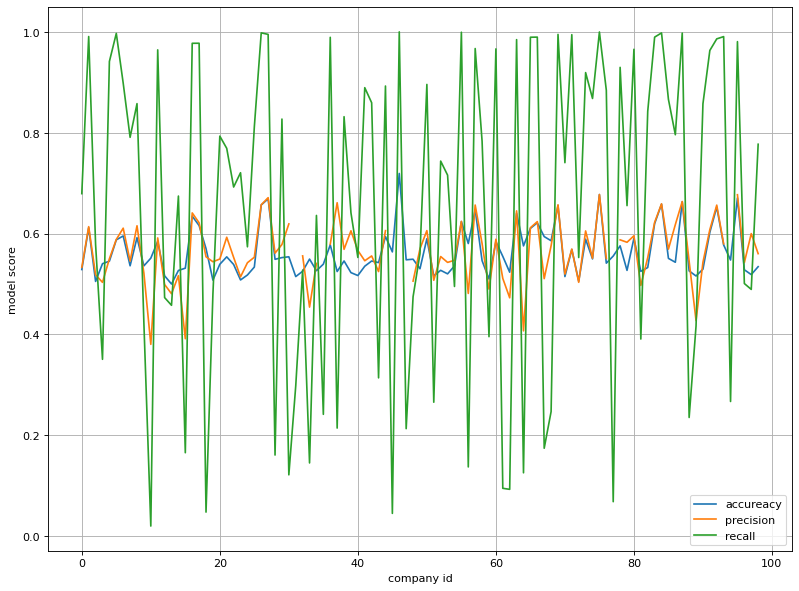

In [205]:
figure(figsize=(12, 9), dpi=80)

plt.axes(xlabel='company id', ylabel='model score')
#plt.xticks(np.arange(len(comps)), comps, rotation='75')
plt.grid()
for i in range(3):
    plt.plot(np.sum(scores_all, axis=1)[:,i]/10)
#plt.plot(np.sum(scores_all, axis=1)[:,0]/10)
plt.legend(['accureacy', 'precision', 'recall'])
#true price only

In [112]:
print('avg model acc')
np.sum(np.sum(scores_all, axis=1)[:,0])/(99*10)

avg model acc


0.5621939646991838

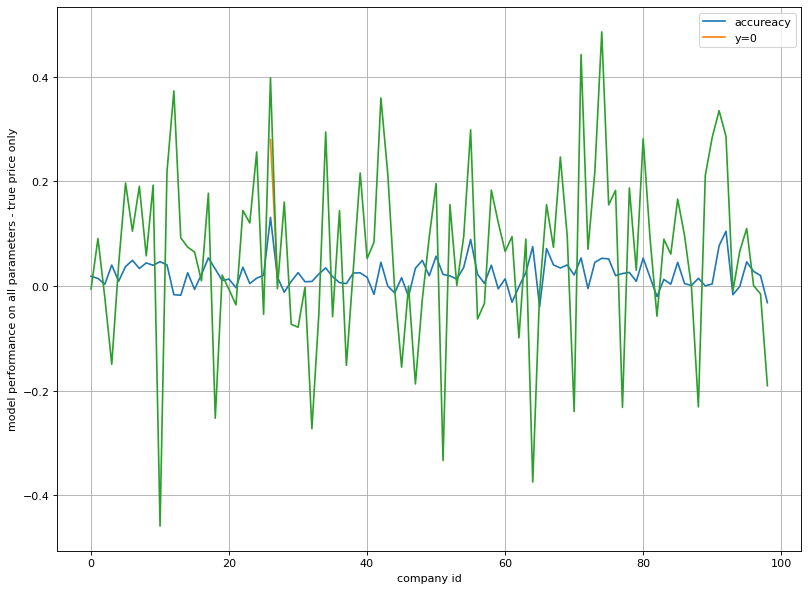

In [204]:
figure(figsize=(12, 9), dpi=80)

plt.axes(xlabel='company id', ylabel='model performance on all parameters - true price only')
#plt.xticks(np.arange(len(comps)), comps, rotation='75')
plt.grid()
for i in range(3):
    plt.plot(np.sum(scores_all, axis=1)[:,i]/10 - np.sum(scores_true, axis=1)[:,i]/10)
#plt.plot(np.sum(scores_all, axis=1)[:,0]/10)
plt.legend(['accureacy', 'y=0',])
#true price only

In [76]:
print('avg model acc')
np.sum(scores_all-scores)/(99*10)

avg model acc


0.0008645958541574415

# compare models

In [ ]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=5
names=[   
  #  'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    'next_trade_price',
   # 'true_price'
]
threshold=1e-3
comp_ths=np.zeros((len(list_of_companies_number),3))

In [ ]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    print(X.shape)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=threshold)
    print(y.shape)
    comp_ths[comp_id,0]=logistic_regr(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
    comp_ths[comp_id,1]=decision_tree(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
    comp_ths[comp_id,2],_,_=xgb_model(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
print("calculations took: {} seconds".format(  time.time()-time_start))

In [ ]:
comp_summed=np.sum(comp_ths, axis=0)/9
print("logreg ", comp_summed[0], ", dec tree ", comp_summed[1], ", xgb ", comp_summed[2])

In [ ]:
import tensorflow as tf


# PYTORCH

In [ ]:
from torch import nn
from IPython.display import clear_output


In [ ]:
comp_id=9
interval=5
time_to_skip=30
time_back=12
swing_interval=60
split_percent = 0.8
threshold=1e-3
names=[         
   # 'mid_price',
   # 'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
X=get_X(0, interval, time_to_skip, time_back, names)
y=get_y(0, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)

In [ ]:
X=get_X(0, interval, time_to_skip, time_back, names)
y=get_y(0, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)

In [ ]:
X=np.arange(100).reshape(10,10)
X=torch.tensor( X.reshape((X.shape[0], X.shape[1], 1)))
X

In [ ]:



rnn = nn.LSTM(1, 20, 2)
input = torch.randn(X.shape)
h0 = torch.randn(2, 10, 20)
c0 = torch.randn(2, 10, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [ ]:
output

In [ ]:
X

In [ ]:
from sklearn.metrics import confusion_matrix
# false positive - truth was false, prediction was true
# false negative - truth was true, prediction was false

In [ ]:
def my_confusion_matrix(y_true, y_pred, labels): # for binary clasification
    if len(labels)!=2:
        raise ValueError("wrong labels fro binary clasiffication")
    if len(y_true)!=len(y_pred):
        raise ValueError("shapes for y differ")
    truth=labels[0]
    tp=0 
    fp=0 #truth was false, prediction was true
    fn=0 #truth was true, prediction was false
    tn=0
    for i in range(len(y_true)):
        if y_true[i]==truth: # true positive or false negative
            if y_true[i]==y_pred[i]:
                tp+=1
            else:
                fn+=1
        else: # true negative or false positive
            if y_true[i]==y_pred[i]:
                tn+=1
            else:
                fp+=1
    return np.array([[tp, fp],[fn, tn]]) 

In [ ]:
test=[0,0,1,1]
pred=[0,1,0,0]
confusion_matrix(test, pred, labels=[1,0]) # 1-true, 0-false

In [ ]:
my_confusion_matrix(test, pred, labels=[1,0]) # 1-true, 0-false

In [ ]:
len(torch.zeros(10))

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return nn.functional.cross_entropy(Out, Targets)

In [ ]:
def compute_error_rate(model, X, y, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)


    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in zip(X,y):
            x = x.to(device).reshape(1,len(x)) # reshape sample from (num_of_features) to (1, num_of_features)
            y = y.to(device).reshape(1)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples
def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()

In [ ]:
def SGD(
    model,
    X_train,
    y_train,
    X_valid,
    y_valid,
    alpha=1e-4,
    epsilon=0.1,
    decay=0.01,
    beta=0.95,
    batch_size=100,
    num_epochs=3,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    polyak=False,
    device="cpu",
):

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    velocities = [torch.zeros_like(m) for m in model.parameters()]
   # if polyak:
    polyaks= [torch.zeros_like(m) for m in model.parameters()]
    #print(velocities)
    #
    alpha0=alpha
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            alpha=alpha0*np.power(beta,epoch)
            
            for counter in range(X_train.size(0)//batch_size):#zip(X_train,y_train):
                x=X_train[counter*batch_size:(counter+1)*batch_size]
                x = x.to(device)#.reshape(1,len(x)) # reshape sample from (num_of_features) to (1, num_of_features)
             #   print(x.shape)
                y=y_train[counter*batch_size:(counter+1)*batch_size]
                y = y.to(device)#.reshape(1)
              #  print(y)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v, pol in zip(model.named_parameters(), velocities, polyaks):
                        if "weight" in name:
                            p.grad +=  decay * 2*p   #### pochodna sumy kwadratów więc mamy 2p

                        v[:] = epsilon*v - alpha * p.grad
                        p[:] =p + v
                        pol[:]=0.99*pol + (1-0.99)*p
                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, X_valid, y_valid, device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

            if(polyak):
                with torch.no_grad():
                    for (name, p), pol in zip(model.named_parameters(), polyaks):
                        p[:]=pol
                        pol[:]=torch.zeros_like(pol)
                  

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

In [ ]:
for x,y in zip(X,y):
    print(x,y)

In [ ]:
comp_id=3
interval=1
time_to_skip=30
time_back=5
swing_interval=60
split_percent = 0.6
valid_percent=split_percent+0.2
threshold=1e-3
names=[         
   # 'mid_price',
   # 'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
no_comps=len(list_of_companies_number)
s=get_X(0, interval, time_to_skip, time_back, names).shape
X=np.zeros(shape=(no_comps, s[0], s[1]))
y=np.zeros(shape=(no_comps, s[0]))
Xy=np.empty(shape=(X.shape[1], X.shape[2]+1))
for i in range(no_comps):
    X_hold=get_X(i, interval, time_to_skip, time_back, names)
    transformer = preprocessing.MaxAbsScaler().fit(X_hold)

    Xy[:,:14]=transformer.transform(X_hold)
    Xy[:,14]=get_y(i, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    Xy=np.random.permutation(Xy)
    X[i]=Xy[:,:14]
    y[i]=Xy[:,14]
split=int(X.shape[1]*split_percent)
valid=int(X.shape[1]*valid_percent)

## save X and y to csv file, upload the files to colab and train much much faster on cloud gpu

In [ ]:
'X_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, swing_interval)

In [ ]:
import pandas as pd
x_df = pd.DataFrame(torch.flatten(X,start_dim=0, end_dim=1).numpy())
x_df.to_csv('X_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, swing_interval))
y_df = pd.DataFrame(torch.flatten(y,start_dim=0, end_dim=1).numpy())
y_df.to_csv('y_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, swing_interval))

In [ ]:
X=torch.tensor(X, dtype=torch.float32)
y=torch.tensor(y, dtype=torch.long)

In [ ]:
transformer = preprocessing.MaxAbsScaler().fit(X)
transformer.transform(X)
transformer.n_features_in_

In [ ]:
MLP=Model(nn.Linear(len(names), 512), nn.Sigmoid(), 
          nn.Linear(512, 1024), nn.Sigmoid(), nn.Dropout(p=0.2),
          nn.Linear(1024,1024), nn.Sigmoid(),
          nn.Linear(1024,64), nn.Sigmoid(),
          nn.Linear(64,2)
         )
with torch.no_grad():
    # Initialize parameters
    for name, p in MLP.named_parameters():
        if "weight" in name:
            p.normal_(1e-8, 0.2)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)
t_start = time.time()

#X=torch.tensor(X, dtype=torch.float32)
#y=torch.tensor(y, dtype=torch.long)

SGD(MLP, torch.flatten(X[:,:split],start_dim=0, end_dim=1), torch.flatten(y[:,:split],start_dim=0, end_dim=1), 
   torch.flatten( X[:,split:valid],start_dim=0, end_dim=1), torch.flatten(y[:,split:valid],start_dim=0, end_dim=1),
    alpha=4e-1, epsilon=0.6, decay=0.0001,beta=0.98,batch_size=1000, max_num_epochs=30)



test_err_rate = compute_error_rate(MLP, torch.flatten(X[:,valid:],start_dim=0, end_dim=1), torch.flatten(y[:,valid:],start_dim=0, end_dim=1))
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

In [ ]:
X.shape

In [ ]:
y_d=torch.tensor([0,0,0,0,0,1,1,1,1,1])
predictions = torch.tensor([0,0,0,0,1,1,1,1,1,1])
num_errs = (predictions != y_d.data).sum().item()
num_examples = y_d.size(0)
num_errs / num_examples

In [ ]:
y_d=y[0].reshape(1)
MLP.eval()
_, predictions=MLP.forward(torch.flatten( X[:,:split],start_dim=0, end_dim=1)[0:10].shape).data.max(dim=1)
num_errs = (predictions != y_d.data).sum().item()
num_examples = y_d.size(0)
num_errs / num_examples

In [ ]:
torch.flatten( X[:,split:valid],start_dim=0, end_dim=1)

In [ ]:
y.shape